## DSM 406 : Advance Machine Learning || Project

### Please enter your details here-

#### **Group Members' names**  (comma separated): ___

---


#### **Group no.:** ________


---



## Instructions:


*   Use the **PyTorch** framework for this project.
*   Build your CNN-based model from scratch. **Using inbuilt architectures is not allowed**.

*   This template must be followed for coding and visualizations.
*   Avoid adding unnecessary code blocks. However, if necessary, you can have additional code blocks.


*   The total number of learnable parameters must not exceed **2.5 million**.

*   Add appropriate comments for the code that you deem necessary.


*   Save the notebook with all the outputs clearly displayed.
*   Do not use oversized or undersized plots/subplots for visualization purposes.
*   Do not use additional markup cells; instead, use multiline comments in the code block itself if some explanation is required to be highlighted.

*   Fill your details carefully before submission.
*   Any form of overlap, including sharing or copying of code, notebooks, or model architectures between students or using any web resource for the same, is **strictly prohibited**.
* Do not forget to rename this notebook before submission in the following format: **notebook_Group_\<Your_Group_Number>.ipynb (e.g., notebook_Group_12.ipynb).**












## Import all the necessary libraries in this section

In [1]:
!unzip dataset.zip
!mkdir -p dataset
!mv images dataset/.
!mv labels dataset/.
!pip install torchinfo
!mkdir -p outputs

Streaming output truncated to the last 5000 lines.
  inflating: labels/image_22194.txt  
  inflating: labels/image_32480.txt  
  inflating: labels/image_26430.txt  
  inflating: labels/image_55947.txt  
  inflating: labels/image_17964.txt  
  inflating: labels/image_13061.txt  
  inflating: labels/image_56069.txt  
  inflating: labels/image_67758.txt  
  inflating: labels/image_61271.txt  
  inflating: labels/image_13567.txt  
  inflating: labels/image_29507.txt  
  inflating: labels/image_63529.txt  
  inflating: labels/image_55347.txt  
  inflating: labels/image_37639.txt  
  inflating: labels/image_16624.txt  
  inflating: labels/image_50789.txt  
  inflating: labels/image_44040.txt  
  inflating: labels/image_38165.txt  
  inflating: labels/image_4645.txt   
  inflating: labels/image_57711.txt  
  inflating: labels/image_1579.txt   
  inflating: labels/image_59562.txt  
  inflating: labels/image_33635.txt  
  inflating: labels/image_9881.txt   
  inflating: labels/image_57135.txt  

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import cv2
import os
import random
import math
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchinfo
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, precision_score, recall_score, f1_score
from warnings import filterwarnings

filterwarnings("ignore")

In [3]:
def set_seed(seed):
    random.seed(seed)  # Set Python random seed
    np.random.seed(seed)  # Set NumPy random seed
    torch.manual_seed(seed)  # Set seed for CPU
    torch.cuda.manual_seed(seed)  # Set seed for current GPU
    torch.cuda.manual_seed_all(seed)  # Set seed for all GPUs (if you have multiple)
    torch.backends.cudnn.deterministic = True  # Make CuDNN deterministic
    torch.backends.cudnn.benchmark = False  # Disable the benchmark to ensure reproducibility

set_seed(123)

In [4]:
# Notebook Parameters
device = ["cuda" if torch.cuda.is_available() else "cpu"][0]
print("Device : ", device)
dataset_directory = "./dataset"
outputs_directory = "./outputs"
image_data_directory = os.path.join(dataset_directory, "images")
label_data_directory = os.path.join(dataset_directory, "labels")
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 1 - (train_ratio + validation_ratio)
batch_size = 32
stratify = True
input_channels = 1

Device :  cuda


## Data exploration


*   You can perform data exploration below this markup block.


*   Clearly display all unique classes with their corresponding labels and show one representative image for each class.
*   Ensure proper visualization and identification of each class.





In [5]:
class FashionDataset:
    def __init__(self, image_files, label_files):
        self.data = self.parse_data(image_files, label_files)
    def parse_data(self, image_files, label_files):
        data = []
        for image_file in tqdm(image_files):
            label_file = "".join(image_file.split('.')[ : -1]) + ".txt"
            assert label_file in label_files, f"{label_file} not in the {label_data_directory}!"
            with open(os.path.join(label_data_directory, label_file), "r") as fd:
                label = int("".join(fd.readlines()).strip())
            data.append(pd.DataFrame({"image_file_path" : [os.path.join(image_data_directory, image_file)], "label" : [label], "image_file_name" : [image_file], "label_file_name" : [label_file]}))
        if len(data):
            return pd.concat(data, axis = 0, ignore_index = True)
        else:
            return pd.DataFrame(columns = ["image_file_path", "label", "image_file_name", "label_file_name"])
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        image_path = self.data.loc[idx, "image_file_path"]
        image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        if len(image.shape) == 2:
            image = image.reshape(-1, image.shape[0], image.shape[1])
        label = self.data.loc[idx, "label"]
        return image, label
    def plot_examples(self, mode = "random"):
        assert mode in ["first", "last", "random"], f"Provided mode {mode} is not supported! Only 'first', 'last' and 'random' are supported modes."
        if mode == "first":
            plot_df = self.data.groupby("label").apply(lambda x : x.loc[0, "image_file_path"]).reset_index().rename(columns = {0 : "image_file_path"})
        elif mode == "last":
            plot_df = self.data.groupby("label").apply(lambda x : x.loc[-1, "image_file_path"]).reset_index().rename(columns = {0 : "image_file_path"})
        else:
            plot_df = self.data.groupby("label").apply(lambda x : x.sample(1, random_state = 123)["image_file_path"].values[0]).reset_index().rename(columns = {0 : "image_file_path"})

        # Calculate grid size (rows and columns)
        num_images = len(plot_df)
        cols = 4  # Number of columns in the grid
        rows = math.ceil(num_images / cols)  # Calculate rows needed

        # Create a figure for the grid
        fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
        axes = axes.flatten()  # Flatten axes for easy iteration

        # Plot each image in the grid
        for idx, (row, ax) in enumerate(zip(plot_df.iterrows(), axes)):
            _, data = row
            image = cv2.cvtColor(cv2.imread(data["image_file_path"]), cv2.COLOR_BGR2RGB)
            label = data["label"]

            ax.imshow(image)
            ax.set_title(f"Label: {label}")
            ax.axis("off")

        # Turn off unused axes
        for ax in axes[num_images:]:
            ax.axis("off")

        # Display the grid
        plt.tight_layout()
        plt.show()
    def get_categories(self):
        return self.data["label"].unique().tolist()
    def get_all_data(self):
        return self.data

100%|██████████| 56000/56000 [01:23<00:00, 670.51it/s]


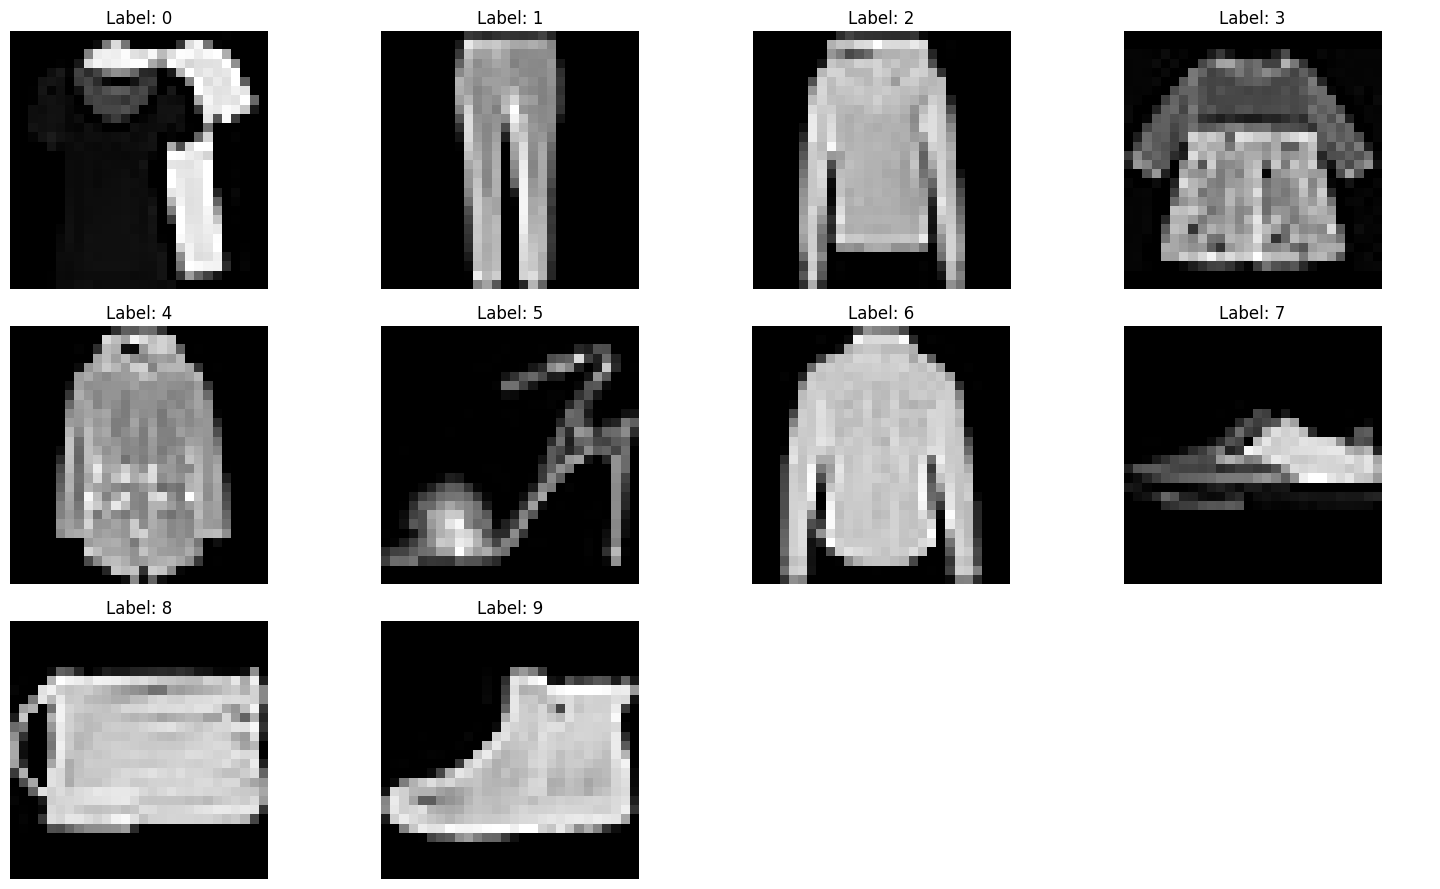

In [6]:
all_images = os.listdir(image_data_directory)
all_labels = os.listdir(label_data_directory)
dataset = FashionDataset(all_images, all_labels)

dataset.plot_examples()

## Create training, validation, and test set using appropriate split ratio.


*   Add seed while generating the splits to ensure reproducibility.
*   Print shapes for the splits.



In [7]:
def train_test_split(dataset, all_images, all_labels, stratify = True):
    if stratify:
        categories = dataset.get_categories()
        train_images = []
        train_labels = []
        validation_images = []
        validation_labels = []
        test_images = []
        test_labels = []
        df = dataset.get_all_data()
        for category in categories:
            df_filtered = df[df["label"] == category].reset_index(drop = True)

            idx = np.array(df_filtered.index.tolist())
            train_idx = np.random.choice(idx, size = int(train_ratio * idx.shape[0]), replace = False)
            remaining_idx = np.array(list(set(idx).difference(set(train_idx))))
            validation_idx = np.random.choice(remaining_idx, size = int(validation_ratio * idx.shape[0]), replace = False)
            test_idx = np.array(list(set(remaining_idx).difference(set(validation_idx))))

            train_images.extend(np.array(df_filtered["image_file_name"].tolist())[train_idx].tolist())
            train_labels.extend(np.array(df_filtered["label_file_name"].tolist())[train_idx].tolist())
            validation_images.extend(np.array(df_filtered["image_file_name"].tolist())[validation_idx].tolist())
            validation_labels.extend(np.array(df_filtered["label_file_name"].tolist())[validation_idx].tolist())
            test_images.extend(np.array(df_filtered["image_file_name"].tolist())[test_idx].tolist())
            test_labels.extend(np.array(df_filtered["label_file_name"].tolist())[test_idx].tolist())
        return train_images, train_labels, validation_images, validation_labels, test_images, test_labels

    else:
        idx = np.arange(len(all_images))
        train_idx = np.random.choice(idx, size = int(train_ratio * idx.shape[0]), replace = False)
        remaining_idx = np.array(list(set(idx).difference(set(train_idx))))
        validation_idx = np.random.choice(remaining_idx, size = int(validation_ratio * idx.shape[0]), replace = False)
        test_idx = np.array(list(set(remaining_idx).difference(set(validation_idx))))
        return np.array(all_images)[train_idx].tolist(), np.array(all_labels)[train_idx].tolist(), np.array(all_images)[validation_idx].tolist(), np.array(all_labels)[validation_idx].tolist(), np.array(all_images)[test_idx].tolist(), np.array(all_labels)[test_idx].tolist()

train_images, train_labels, validation_images, validation_labels, test_images, test_labels = train_test_split(
    dataset,
    all_images,
    all_labels,
    stratify = stratify
)

In [8]:
print("Train Set size : ", len(train_images),"\nValidation set size : ", len(validation_images),"\nTest set size : ", len(test_images))

Train Set size :  39195 
Validation set size :  5595 
Test set size :  11210


In [9]:
train_dataset = FashionDataset(train_images, train_labels)
validation_dataset = FashionDataset(validation_images, validation_labels)
test_dataset = FashionDataset(test_images, test_labels)

100%|██████████| 11210/11210 [00:06<00:00, 1647.62it/s]


In [10]:
train_idx = np.random.randint(len(train_images))
validation_idx = np.random.randint(len(validation_images))
test_idx = np.random.randint(len(test_images))

print("Shape of Image (Train) : ", train_dataset.__getitem__(train_idx)[0].shape)
print("Shape of Image (Validation) : ", validation_dataset.__getitem__(validation_idx)[0].shape)
print("Shape of Image (Test) : ", test_dataset.__getitem__(test_idx)[0].shape)

Shape of Image (Train) :  (1, 28, 28)
Shape of Image (Validation) :  (1, 28, 28)
Shape of Image (Test) :  (1, 28, 28)


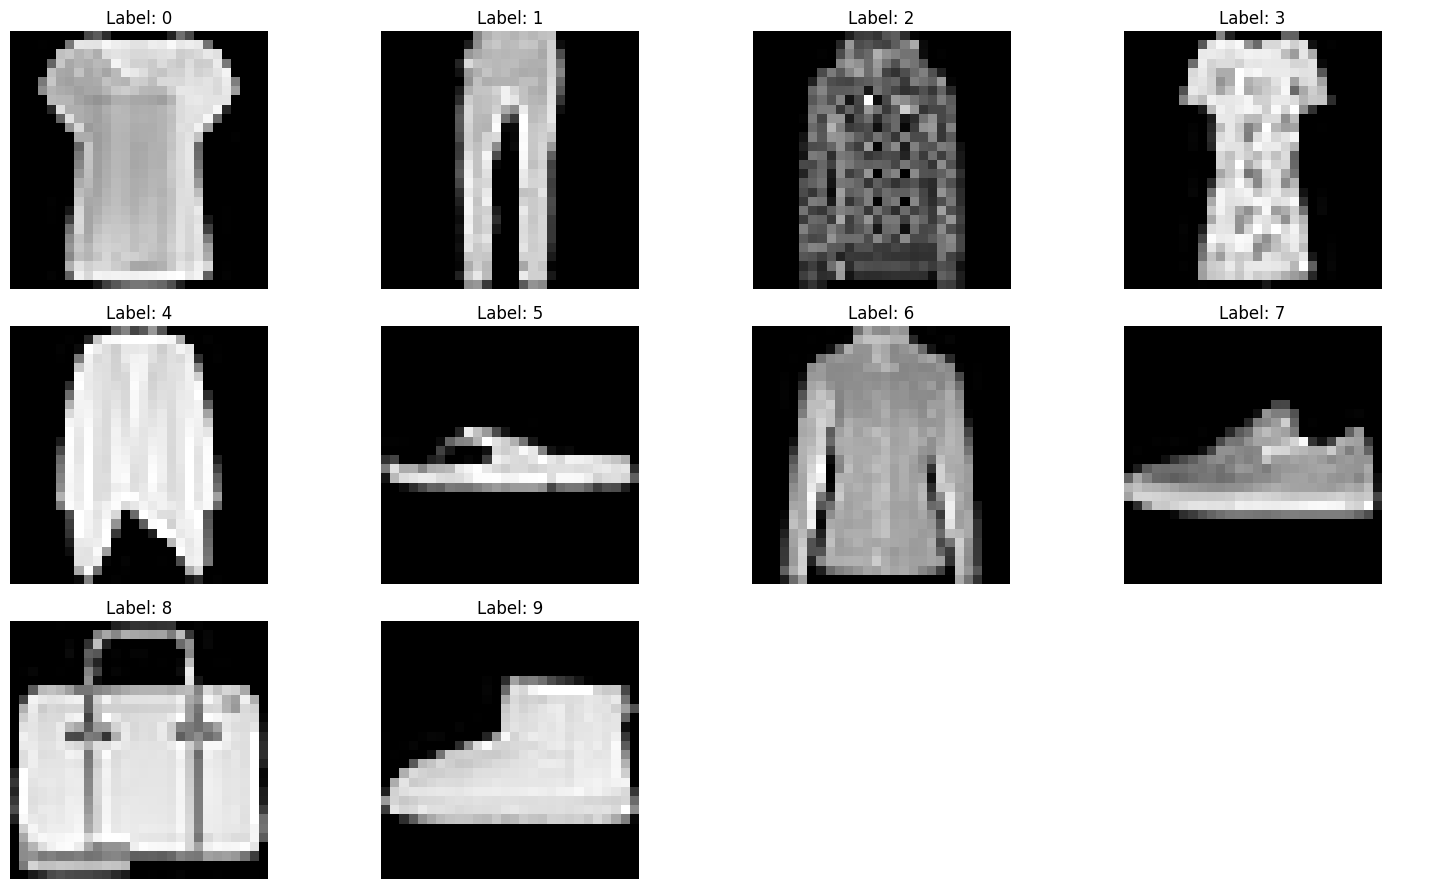

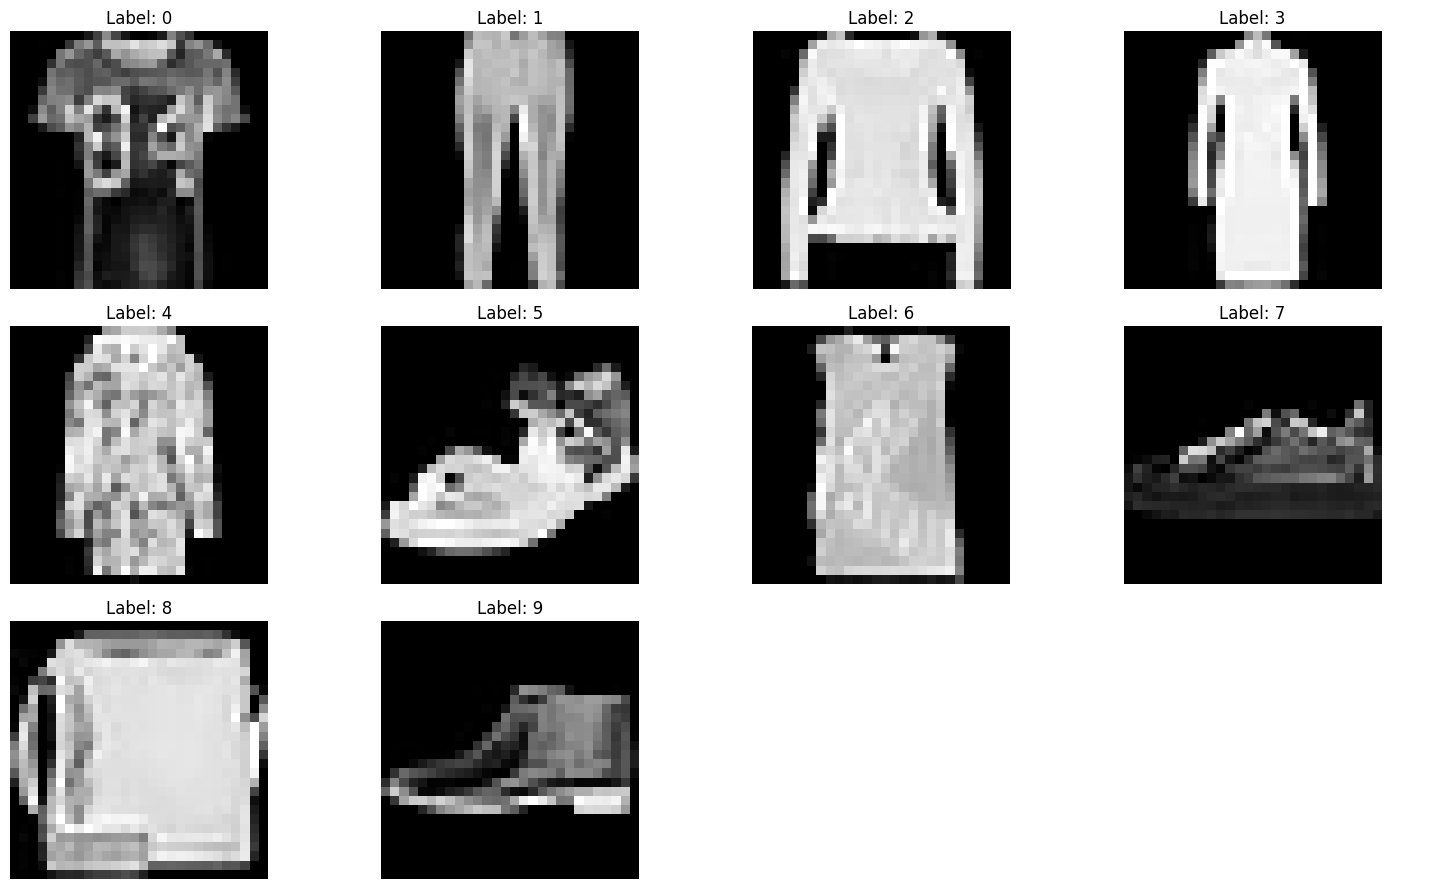

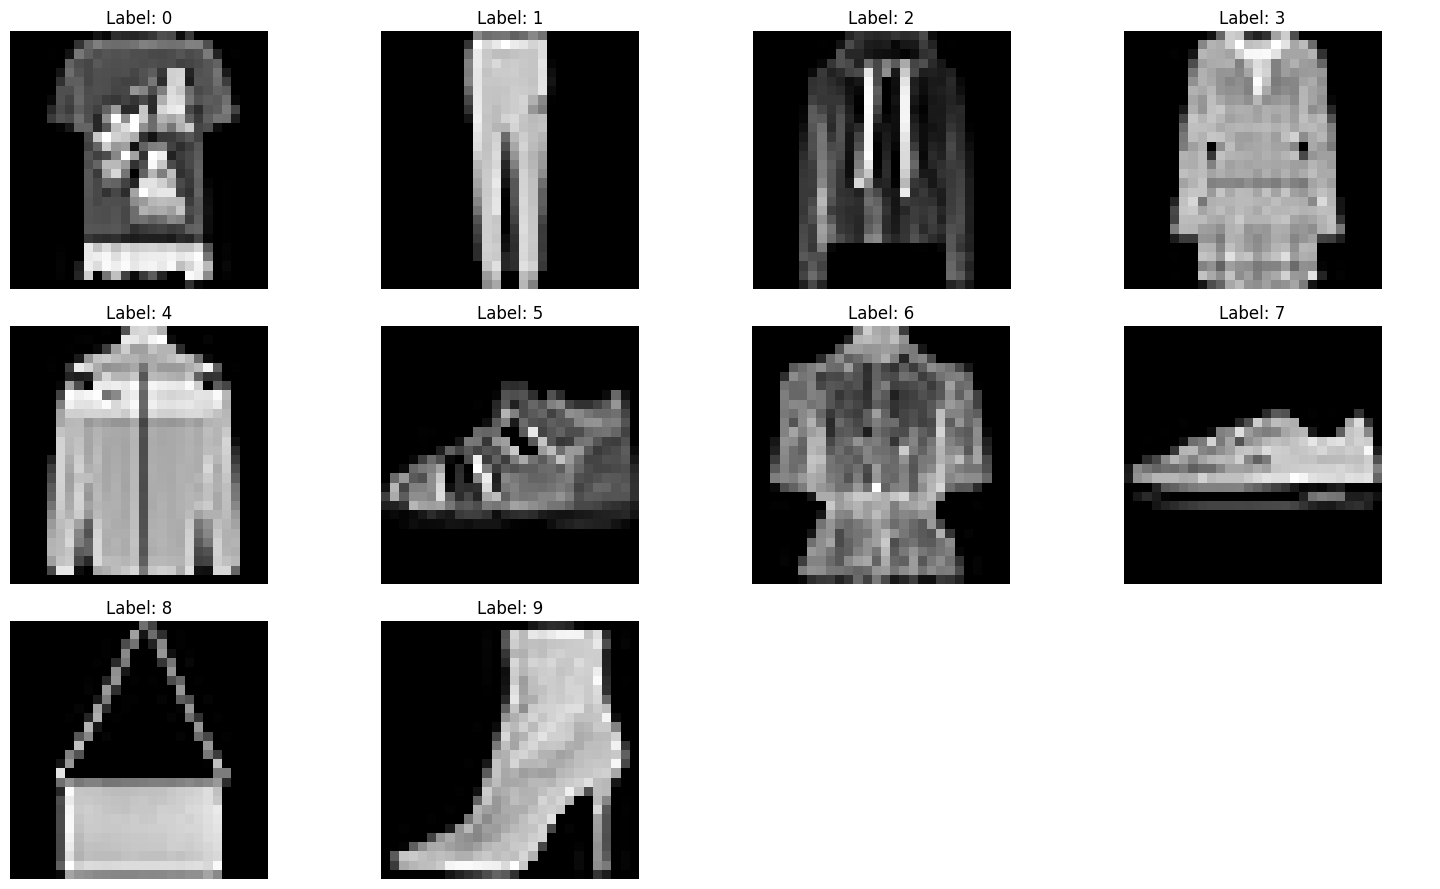

In [11]:
train_dataset.plot_examples()
validation_dataset.plot_examples()
test_dataset.plot_examples()

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers = 1)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle = False, num_workers = 1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False, num_workers = 1)

## Model development

*   Model must be based on CNNs and **built from scratch** .
*   The total number of parameters in your network must be **$\leq$ 2.5 million** .

*   Create a **'ConvClassifier'** class to define the model architecture.
*   Show the summary of the model. (Use torchinfo library to generate summary)





In [13]:
class ConvClassifier(nn.Module):
    def __init__(self, input_channels, n_classes):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=input_channels * 8, kernel_size=(3,3), padding="same")
        self.conv2 = nn.Conv2d(in_channels=input_channels * 8, out_channels=input_channels * 16, kernel_size=(3,3), padding="same")
        self.pool1 = nn.MaxPool2d(kernel_size = (2,2)) # 28 X 28 -> 14 X 14
        self.conv3 = nn.Conv2d(in_channels=input_channels * 16, out_channels=input_channels * 32, kernel_size=(3,3), padding="same")
        self.conv4 = nn.Conv2d(in_channels=input_channels * 32, out_channels=input_channels * 64, kernel_size=(3,3), padding="same")
        self.pool2 = nn.MaxPool2d(kernel_size = (2,2)) # 14 X 14 -> 7 X 7
        self.fc1 = nn.Linear(input_channels * 64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc_cls = nn.Linear(16, n_classes)
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)
        self.flatten = nn.Flatten()
    def forward(self, image):
        image = nn.Dropout(p=0.2)(self.relu(self.conv1(image)))
        image = nn.Dropout(p=0.2)(self.relu(self.conv2(image)))
        image = self.pool1(image)

        image = nn.Dropout(p=0.2)(self.relu(self.conv3(image)))
        image = nn.Dropout(p=0.2)(self.relu(self.conv4(image)))
        image = self.pool2(image)

        image = self.flatten(image)

        image = nn.Dropout(p=0.2)(self.relu(self.fc1(image)))
        image = nn.Dropout(p=0.2)(self.relu(self.fc2(image)))
        image = nn.Dropout(p=0.2)(self.relu(self.fc3(image)))
        # category = self.softmax(self.fc_cls(image))
        category = self.fc_cls(image)

        return category

In [14]:
model = ConvClassifier(input_channels = input_channels, n_classes = len(dataset.get_categories()))
model = model.to(device)
torchinfo.summary(model, train_dataset.__getitem__(train_idx)[0].shape, batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvClassifier                           [1, 1, 28, 28]            [1, 10]                   --                        --                        --
├─Conv2d: 1-1                            [1, 1, 28, 28]            [1, 8, 28, 28]            80                        [3, 3]                    62,720
├─ReLU: 1-2                              [1, 8, 28, 28]            [1, 8, 28, 28]            --                        --                        --
├─Conv2d: 1-3                            [1, 8, 28, 28]            [1, 16, 28, 28]           1,168                     [3, 3]                    915,712
├─ReLU: 1-4                              [1, 16, 28, 28]           [1, 16, 28, 28]           --                        --                        --
├─MaxPool2d: 1-5                         [1, 16, 28, 28]           [1, 16, 14, 14]           -- 

## Model Training


*   Create **'train_model'** function, which takes the required training arguments and returns model, losses, and other metrics as the output.

*   Use a separate code block to set the values of the hyperparameters used for training.

*   Highlight the range of hyperparameters experimented to optimize the model. (You can use multiline comments to highlight the same)

*   Training must include verbose with appropriate information.

* The final submission must include optimized hyperparameters against the best model.



In [15]:
def compute_multiclass_metrics(predictions, labels):
    # Ensure predictions are numpy arrays
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Initialize dictionaries to store per-class metrics
    roc_auc_scores = {}
    pr_auc_scores = {}
    n_classes = predictions.shape[1]

    # One-hot encode the labels
    labels_one_hot = np.eye(n_classes)[labels]

    for class_idx in range(n_classes):
        # True labels and predictions for the current class
        y_true = labels_one_hot[:, class_idx]
        y_pred = predictions[:, class_idx]

        # ROC-AUC
        roc_auc = roc_auc_score(y_true, y_pred)
        roc_auc_scores[f"class_{class_idx}"] = roc_auc

        # PR-AUC
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)
        pr_auc_scores[f"class_{class_idx}"] = pr_auc

    # Overall metrics (micro-average)
    precision_micro = precision_score(labels, np.argmax(predictions, axis=1), average="micro")
    recall_micro = recall_score(labels, np.argmax(predictions, axis=1), average="micro")
    f1_micro = f1_score(labels, np.argmax(predictions, axis=1), average="micro")

    return {
        "roc_auc": roc_auc_scores,
        "pr_auc": pr_auc_scores,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }


In [16]:
# Hyperparameters of Model Training

training_params = {
    "epochs" : 300,
    "loss_fn" : nn.CrossEntropyLoss(),
    "learning_rate" : 1e-3,
    "betas" : [0.9, 0.99],
    "weight_decay" : 0,
    "patience" : 5,
    "t_max" : 60,
    "eta_min" : 1e-4
}

In [17]:
# Trainning Loop
def train_model(training_params, model, train_dataloader, validation_dataloader):
    epochs = training_params["epochs"]
    criterion = training_params["loss_fn"]
    learning_rate = training_params["learning_rate"]
    betas = training_params["betas"]
    weight_decay = training_params["weight_decay"]
    initial_patience = training_params["patience"]
    t_max = training_params["t_max"]
    eta_min = training_params["eta_min"]
    patience = initial_patience
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, weight_decay = weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = t_max, eta_min = eta_min)
    loss_history = {"train_loss" : [], "val_loss" : []}
    for epoch in range(epochs):
        if patience < 0:
            print("Early Stopping!")
            break

        running_loss_train = 0.0
        count = 0
        model.train()
        predictions = []
        labels = []
        for idx, (image, label) in tqdm(enumerate(train_dataloader)):
            image = torch.tensor(image, dtype = torch.float32).to(device)
            label = torch.tensor(label, dtype = torch.long).to(device)
            optimizer.zero_grad()
            prediction = model(image)
            predictions.append(prediction.cpu().detach())
            labels.append(label.cpu().detach())
            loss = criterion(prediction, label)

            running_loss_train += loss.item()
            # if idx%100 == 0:
            #     print(f"\t############# [TRAIN {idx + 1}] : Loss = {loss.item()}")

            loss.backward()
            optimizer.step()
            count+=1
        scheduler.step()
        loss_history["train_loss"].append(running_loss_train / count)
        predictions = torch.concat(predictions, dim = 0)
        labels = torch.concat(labels, dim = 0)
        metrics_train = compute_multiclass_metrics(predictions, labels)

        running_loss_val = 0.0
        count = 0
        predictions = []
        labels = []
        model.eval()
        with torch.no_grad():
            for idx, (image, label) in enumerate(validation_dataloader):
                image = torch.tensor(image, dtype = torch.float32).to(device)
                label = torch.tensor(label, dtype = torch.long).to(device)
                prediction = model(image)
                predictions.append(prediction.cpu().detach())
                labels.append(label.cpu().detach())
                loss = criterion(prediction, label)
                running_loss_val += loss.item()
                # if idx%100 == 0:
                #     print(f"\t############# [Validation {idx + 1}] : Loss = {loss.item()}")
                count += 1
        predictions = torch.concat(predictions, dim = 0)
        labels = torch.concat(labels, dim = 0)
        metrics_val = compute_multiclass_metrics(predictions, labels)

        loss_history["val_loss"].append(running_loss_val / count)

        print(f"[EPOCH = {epoch + 1}] => Train Loss : {loss_history['train_loss'][-1]}, Classification Report : {metrics_train} | Validation Loss : {loss_history['val_loss'][-1]}, , Classification Report : {metrics_val}")

        if epoch > 1:
            if loss_history['val_loss'][-1] >= loss_history['val_loss'][-2]:
                patience -= 1
            else:
                patience = initial_patience

    return model, loss_history, metrics_train, metrics_val

In [18]:
model, loss_history, metrics_train, metrics_val = train_model(training_params, model, train_dataloader, validation_dataloader)

1225it [00:11, 102.62it/s]


[EPOCH = 1] => Train Loss : 1.0605562111309597, Classification Report : {'roc_auc': {'class_0': 0.790816626873151, 'class_1': 0.9758373886995418, 'class_2': 0.8452685429007345, 'class_3': 0.8184543195116496, 'class_4': 0.8375240660386082, 'class_5': 0.917143650901484, 'class_6': 0.7486240790955084, 'class_7': 0.9478649504203364, 'class_8': 0.9377126410850416, 'class_9': 0.9252057341696471}, 'pr_auc': {'class_0': 0.2371478996912117, 'class_1': 0.8881307410623254, 'class_2': 0.29798753962086016, 'class_3': 0.25182185643350435, 'class_4': 0.32023568184417806, 'class_5': 0.603267430177331, 'class_6': 0.1884228529614108, 'class_7': 0.6913819975957234, 'class_8': 0.7406498777655619, 'class_9': 0.5791001259385867}, 'precision_micro': 0.6008929710422247, 'recall_micro': 0.6008929710422247, 'f1_micro': 0.6008929710422247} | Validation Loss : 0.7073990034418447, , Classification Report : {'roc_auc': {'class_0': 0.8534310079223781, 'class_1': 0.989756207083653, 'class_2': 0.8786628820632888, 'cla

1225it [00:11, 107.40it/s]


[EPOCH = 2] => Train Loss : 0.6511194970656414, Classification Report : {'roc_auc': {'class_0': 0.8716295744774556, 'class_1': 0.991303511489604, 'class_2': 0.8874295095404513, 'class_3': 0.8841560273349427, 'class_4': 0.8800866739901729, 'class_5': 0.9691144352679303, 'class_6': 0.779894482066523, 'class_7': 0.9690490000379846, 'class_8': 0.9755930533327055, 'class_9': 0.93748101997087}, 'pr_auc': {'class_0': 0.3304918866157385, 'class_1': 0.9534635062701273, 'class_2': 0.33691564370330906, 'class_3': 0.3894963877318214, 'class_4': 0.40048315296708137, 'class_5': 0.809749515691472, 'class_6': 0.1990776446022593, 'class_7': 0.7894395018486815, 'class_8': 0.8892762512523681, 'class_9': 0.5590146368758286}, 'precision_micro': 0.7619339201428754, 'recall_micro': 0.7619339201428754, 'f1_micro': 0.7619339201428754} | Validation Loss : 0.6029034107753873, , Classification Report : {'roc_auc': {'class_0': 0.8881597639134178, 'class_1': 0.9921327526478424, 'class_2': 0.8968235251625842, 'class

1225it [00:12, 94.86it/s] 


[EPOCH = 3] => Train Loss : 0.5820006881806316, Classification Report : {'roc_auc': {'class_0': 0.9105215907739628, 'class_1': 0.9930830448510626, 'class_2': 0.9005966962608445, 'class_3': 0.9101902996761424, 'class_4': 0.881528039743726, 'class_5': 0.9731313530294633, 'class_6': 0.7893290804404043, 'class_7': 0.9761799195930139, 'class_8': 0.9768070841668027, 'class_9': 0.934990703746101}, 'pr_auc': {'class_0': 0.47670511641518304, 'class_1': 0.9637232042673715, 'class_2': 0.3849915997713995, 'class_3': 0.4667101871554848, 'class_4': 0.3972839097396879, 'class_5': 0.8101389585021408, 'class_6': 0.20282366844885052, 'class_7': 0.8415269800831418, 'class_8': 0.8853117048772242, 'class_9': 0.5437452596303377}, 'precision_micro': 0.7972955734149764, 'recall_micro': 0.7972955734149764, 'f1_micro': 0.7972955734149764} | Validation Loss : 0.5696740452012247, , Classification Report : {'roc_auc': {'class_0': 0.9162933792676119, 'class_1': 0.9943333510839638, 'class_2': 0.914136102665865, 'cla

1225it [00:11, 104.91it/s]


[EPOCH = 4] => Train Loss : 0.5374695051689538, Classification Report : {'roc_auc': {'class_0': 0.9124549637662294, 'class_1': 0.9947695404052673, 'class_2': 0.9142733624621144, 'class_3': 0.923524643858322, 'class_4': 0.8884702960104767, 'class_5': 0.9755922487725757, 'class_6': 0.796039531521077, 'class_7': 0.9751396770457756, 'class_8': 0.9809784085946327, 'class_9': 0.9416487633663465}, 'pr_auc': {'class_0': 0.47909181069320655, 'class_1': 0.9717716504937812, 'class_2': 0.4383059371253426, 'class_3': 0.49750215811395754, 'class_4': 0.3812787481068872, 'class_5': 0.8234469190937785, 'class_6': 0.20697576508506504, 'class_7': 0.8247843626636023, 'class_8': 0.9025296953799145, 'class_9': 0.5867247132335193}, 'precision_micro': 0.8110983543819364, 'recall_micro': 0.8110983543819364, 'f1_micro': 0.8110983543819364} | Validation Loss : 0.5630204294794904, , Classification Report : {'roc_auc': {'class_0': 0.9015299369950358, 'class_1': 0.9945956526307154, 'class_2': 0.908746194327769, 'cl

1225it [00:10, 112.98it/s]


[EPOCH = 5] => Train Loss : 0.5125568235893638, Classification Report : {'roc_auc': {'class_0': 0.9242420568684193, 'class_1': 0.9948452372803126, 'class_2': 0.9201123012999721, 'class_3': 0.9391783093584009, 'class_4': 0.8982680306625167, 'class_5': 0.9798522405773668, 'class_6': 0.7934555704609212, 'class_7': 0.9762684309612338, 'class_8': 0.9834369138782165, 'class_9': 0.9447738221404753}, 'pr_auc': {'class_0': 0.5268039044368916, 'class_1': 0.9724784581851843, 'class_2': 0.4593547812119897, 'class_3': 0.541432641240759, 'class_4': 0.412687152715792, 'class_5': 0.8450594542559906, 'class_6': 0.19835944976917197, 'class_7': 0.8251905603563945, 'class_8': 0.9113841325684916, 'class_9': 0.5968654360827254}, 'precision_micro': 0.8216098992218395, 'recall_micro': 0.8216098992218395, 'f1_micro': 0.8216098992218395} | Validation Loss : 0.5231348116270134, , Classification Report : {'roc_auc': {'class_0': 0.936746256894068, 'class_1': 0.9955444718060019, 'class_2': 0.9235359979943868, 'clas

1225it [00:10, 115.92it/s]


[EPOCH = 6] => Train Loss : 0.48921813739805803, Classification Report : {'roc_auc': {'class_0': 0.9373952174771905, 'class_1': 0.9959475129389919, 'class_2': 0.9267535298894702, 'class_3': 0.9364033427744513, 'class_4': 0.9060975382396759, 'class_5': 0.9878041065674865, 'class_6': 0.7930227365485568, 'class_7': 0.964416348630391, 'class_8': 0.9843537988415371, 'class_9': 0.9485243314681453}, 'pr_auc': {'class_0': 0.5517298787522905, 'class_1': 0.9774648505362395, 'class_2': 0.48223788988153915, 'class_3': 0.4958679794992452, 'class_4': 0.43091876389394895, 'class_5': 0.9075674311572889, 'class_6': 0.19606968531782262, 'class_7': 0.7442241846161699, 'class_8': 0.9044162260002081, 'class_9': 0.6139665860674621}, 'precision_micro': 0.8308202576859294, 'recall_micro': 0.8308202576859294, 'f1_micro': 0.8308202576859294} | Validation Loss : 0.5191640137162592, , Classification Report : {'roc_auc': {'class_0': 0.923897555898524, 'class_1': 0.9945614706733198, 'class_2': 0.9185502929455814, '

1225it [00:10, 117.02it/s]


[EPOCH = 7] => Train Loss : 0.4766679096252334, Classification Report : {'roc_auc': {'class_0': 0.9408755696679549, 'class_1': 0.9954549805623047, 'class_2': 0.9323649691232757, 'class_3': 0.9427744052092802, 'class_4': 0.9052755390594129, 'class_5': 0.9895791634174059, 'class_6': 0.794071482151546, 'class_7': 0.9663565525108623, 'class_8': 0.9836460922594072, 'class_9': 0.9537235008337248}, 'pr_auc': {'class_0': 0.5616082105316123, 'class_1': 0.9760450083435588, 'class_2': 0.5112697993474498, 'class_3': 0.5246895887794096, 'class_4': 0.4115524753228952, 'class_5': 0.9229794417878883, 'class_6': 0.19726772154842123, 'class_7': 0.7359493157468628, 'class_8': 0.8841181029739424, 'class_9': 0.6356503730622626}, 'precision_micro': 0.8352340859803546, 'recall_micro': 0.8352340859803546, 'f1_micro': 0.8352340859803546} | Validation Loss : 0.5053006028650062, , Classification Report : {'roc_auc': {'class_0': 0.9502981064245647, 'class_1': 0.9939649055642469, 'class_2': 0.9341231851573295, 'cl

1225it [00:10, 114.99it/s]


[EPOCH = 8] => Train Loss : 0.45950385229928153, Classification Report : {'roc_auc': {'class_0': 0.9536864468251154, 'class_1': 0.995580935318954, 'class_2': 0.9365730569959402, 'class_3': 0.9517596114745789, 'class_4': 0.9136402586769365, 'class_5': 0.9919525150015949, 'class_6': 0.8052488309759497, 'class_7': 0.9659446629888914, 'class_8': 0.9847353971149436, 'class_9': 0.947604218195144}, 'pr_auc': {'class_0': 0.6300115724092615, 'class_1': 0.9771819849041532, 'class_2': 0.5299528023599087, 'class_3': 0.5601386696327008, 'class_4': 0.4316290987609766, 'class_5': 0.9433433482161674, 'class_6': 0.20506373354652982, 'class_7': 0.7124037599658538, 'class_8': 0.8944748068140479, 'class_9': 0.5799452976138142}, 'precision_micro': 0.840285750733512, 'recall_micro': 0.840285750733512, 'f1_micro': 0.840285750733512} | Validation Loss : 0.4826311931253544, , Classification Report : {'roc_auc': {'class_0': 0.9628716157853634, 'class_1': 0.9966857893729374, 'class_2': 0.9423403919302398, 'class

1225it [00:11, 108.47it/s]


[EPOCH = 9] => Train Loss : 0.45093714110097105, Classification Report : {'roc_auc': {'class_0': 0.9552868589358169, 'class_1': 0.9973356461229873, 'class_2': 0.9399121951606685, 'class_3': 0.9368304368531843, 'class_4': 0.9149952473547714, 'class_5': 0.9923568934276729, 'class_6': 0.8144654224237143, 'class_7': 0.9621749350894953, 'class_8': 0.9856875557771686, 'class_9': 0.9426142324045721}, 'pr_auc': {'class_0': 0.6243036688411787, 'class_1': 0.9857823582550749, 'class_2': 0.5611764110840216, 'class_3': 0.4583510303144942, 'class_4': 0.41528274206915067, 'class_5': 0.9464286244700151, 'class_6': 0.2138253898377289, 'class_7': 0.6659173883622396, 'class_8': 0.8915239960703587, 'class_9': 0.5325280945302875}, 'precision_micro': 0.846689628779181, 'recall_micro': 0.846689628779181, 'f1_micro': 0.846689628779181} | Validation Loss : 0.49968274506075044, , Classification Report : {'roc_auc': {'class_0': 0.9549652994413359, 'class_1': 0.9952717357669928, 'class_2': 0.9391428836496495, 'cl

1225it [00:11, 107.92it/s]


[EPOCH = 10] => Train Loss : 0.4550905402339235, Classification Report : {'roc_auc': {'class_0': 0.9527681100216617, 'class_1': 0.9967340412641095, 'class_2': 0.9460252129550559, 'class_3': 0.9374371333818724, 'class_4': 0.9169109210027445, 'class_5': 0.9916053110152152, 'class_6': 0.8132495919531273, 'class_7': 0.9702827065025326, 'class_8': 0.983631753739236, 'class_9': 0.9444647613381726}, 'pr_auc': {'class_0': 0.6048674794741107, 'class_1': 0.9832295092690897, 'class_2': 0.5985452252316712, 'class_3': 0.45499703442086836, 'class_4': 0.4281894941006854, 'class_5': 0.9394016209942613, 'class_6': 0.21178676099514834, 'class_7': 0.722942982706941, 'class_8': 0.8654374670643014, 'class_9': 0.5322392941132423}, 'precision_micro': 0.8463579538206404, 'recall_micro': 0.8463579538206404, 'f1_micro': 0.8463579538206404} | Validation Loss : 0.49139586810355207, , Classification Report : {'roc_auc': {'class_0': 0.9525842314836364, 'class_1': 0.9954102626469644, 'class_2': 0.9415365886304679, '

1225it [00:11, 105.67it/s]


[EPOCH = 11] => Train Loss : 0.44067842436688287, Classification Report : {'roc_auc': {'class_0': 0.9577976529296869, 'class_1': 0.997128479590508, 'class_2': 0.944773595340838, 'class_3': 0.9458415696127921, 'class_4': 0.9204451848157258, 'class_5': 0.9924277682193495, 'class_6': 0.8146426637396209, 'class_7': 0.9717995228747631, 'class_8': 0.9834478493028973, 'class_9': 0.9447967905107236}, 'pr_auc': {'class_0': 0.6297288320212348, 'class_1': 0.9845550690724562, 'class_2': 0.5819698750523871, 'class_3': 0.49672409177570237, 'class_4': 0.4420806438381863, 'class_5': 0.9428135332510663, 'class_6': 0.21167527143532902, 'class_7': 0.7139580977181101, 'class_8': 0.8547183757144715, 'class_9': 0.5370347687876923}, 'precision_micro': 0.8480928689883914, 'recall_micro': 0.8480928689883914, 'f1_micro': 0.8480928689883914} | Validation Loss : 0.48681914023190204, , Classification Report : {'roc_auc': {'class_0': 0.9612490202321176, 'class_1': 0.9944445323980191, 'class_2': 0.9495760380216666, 

1225it [00:11, 105.82it/s]


[EPOCH = 12] => Train Loss : 0.4381875911050913, Classification Report : {'roc_auc': {'class_0': 0.9535541667217728, 'class_1': 0.9962134170175556, 'class_2': 0.9475584244193995, 'class_3': 0.9578547499065767, 'class_4': 0.9120153029767457, 'class_5': 0.9948532828943306, 'class_6': 0.8270351690451015, 'class_7': 0.9633654355760964, 'class_8': 0.9864034485741408, 'class_9': 0.93557518652157}, 'pr_auc': {'class_0': 0.5928001997535357, 'class_1': 0.9821085975185361, 'class_2': 0.6066529412359186, 'class_3': 0.5622012329736163, 'class_4': 0.39371219158349446, 'class_5': 0.9629615267980235, 'class_6': 0.22467938464609066, 'class_7': 0.6206894718213178, 'class_8': 0.8765643044564698, 'class_9': 0.45983448550081774}, 'precision_micro': 0.8540119913254242, 'recall_micro': 0.8540119913254242, 'f1_micro': 0.8540119913254242} | Validation Loss : 0.4831041439436376, , Classification Report : {'roc_auc': {'class_0': 0.9539252106947108, 'class_1': 0.9940570169441763, 'class_2': 0.947508811737936, 'c

1225it [00:11, 106.19it/s]


[EPOCH = 13] => Train Loss : 0.43032227284446056, Classification Report : {'roc_auc': {'class_0': 0.9575686370673213, 'class_1': 0.9964221026245028, 'class_2': 0.9498180479387436, 'class_3': 0.9518915374021562, 'class_4': 0.9312604161014408, 'class_5': 0.9934830659942828, 'class_6': 0.8253606492773263, 'class_7': 0.9637335554224908, 'class_8': 0.9826301382009363, 'class_9': 0.9432063255952575}, 'pr_auc': {'class_0': 0.638913044450218, 'class_1': 0.9812505255285457, 'class_2': 0.6199553812419047, 'class_3': 0.5238836510221425, 'class_4': 0.47843828022545065, 'class_5': 0.9565585357207028, 'class_6': 0.22156339499762712, 'class_7': 0.6063720679282293, 'class_8': 0.8291851495131892, 'class_9': 0.5068860923862869}, 'precision_micro': 0.8553131777012374, 'recall_micro': 0.8553131777012374, 'f1_micro': 0.8553131777012374} | Validation Loss : 0.4843990763702563, , Classification Report : {'roc_auc': {'class_0': 0.9583125720102624, 'class_1': 0.9950112332706305, 'class_2': 0.9468066346703379, 

1225it [00:11, 106.57it/s]


[EPOCH = 14] => Train Loss : 0.4275197535570787, Classification Report : {'roc_auc': {'class_0': 0.962824958857385, 'class_1': 0.9975280915763256, 'class_2': 0.9515398749345648, 'class_3': 0.9542279210248092, 'class_4': 0.9345470354213767, 'class_5': 0.9948174984471359, 'class_6': 0.8273620539575065, 'class_7': 0.9733222942065703, 'class_8': 0.9796151906784027, 'class_9': 0.9462254917024678}, 'pr_auc': {'class_0': 0.6724007050286518, 'class_1': 0.9869450604489757, 'class_2': 0.627972211638545, 'class_3': 0.5336703599205703, 'class_4': 0.4947396172648173, 'class_5': 0.9656289516926859, 'class_6': 0.22252880150913962, 'class_7': 0.6927916162865522, 'class_8': 0.7992681032488249, 'class_9': 0.5254922771244988}, 'precision_micro': 0.8580431177446103, 'recall_micro': 0.8580431177446103, 'f1_micro': 0.8580431177446103} | Validation Loss : 0.4962952380447769, , Classification Report : {'roc_auc': {'class_0': 0.9598113134814632, 'class_1': 0.995822245186101, 'class_2': 0.9474425953427567, 'cla

1225it [00:11, 106.25it/s]


[EPOCH = 15] => Train Loss : 0.4251483656557239, Classification Report : {'roc_auc': {'class_0': 0.9579806924809396, 'class_1': 0.9973401152841024, 'class_2': 0.9535754839133294, 'class_3': 0.9398183636109854, 'class_4': 0.9298545786654421, 'class_5': 0.9951065031929525, 'class_6': 0.8305663219803051, 'class_7': 0.9628831416655398, 'class_8': 0.9815950336019191, 'class_9': 0.9388629255891059}, 'pr_auc': {'class_0': 0.6182264419575914, 'class_1': 0.9861929620005908, 'class_2': 0.6511985130178801, 'class_3': 0.4529567390335872, 'class_4': 0.45755130738793287, 'class_5': 0.9678184200828722, 'class_6': 0.225316047003126, 'class_7': 0.5940599563087815, 'class_8': 0.8046854981793152, 'class_9': 0.4610988208023957}, 'precision_micro': 0.8588085214950887, 'recall_micro': 0.8588085214950887, 'f1_micro': 0.8588085214950887} | Validation Loss : 0.47688519317922845, , Classification Report : {'roc_auc': {'class_0': 0.9493968627439784, 'class_1': 0.9972413361331355, 'class_2': 0.9593672120489761, '

1225it [00:11, 107.05it/s]


[EPOCH = 16] => Train Loss : 0.41358154908126715, Classification Report : {'roc_auc': {'class_0': 0.95719293349336, 'class_1': 0.9978221609099958, 'class_2': 0.9567239970431076, 'class_3': 0.9434992957325791, 'class_4': 0.9257354048851519, 'class_5': 0.9962470992866179, 'class_6': 0.8332115443848693, 'class_7': 0.968309295050151, 'class_8': 0.9839596033346116, 'class_9': 0.9472410148276871}, 'pr_auc': {'class_0': 0.6244447704045899, 'class_1': 0.9882205032434319, 'class_2': 0.6643554824194796, 'class_3': 0.46610390362334814, 'class_4': 0.4316455335835115, 'class_5': 0.9757263406662423, 'class_6': 0.2277722831747635, 'class_7': 0.6312866515300077, 'class_8': 0.8199419207211532, 'class_9': 0.5066243817481688}, 'precision_micro': 0.86194667687205, 'recall_micro': 0.86194667687205, 'f1_micro': 0.86194667687205} | Validation Loss : 0.4809936329537803, , Classification Report : {'roc_auc': {'class_0': 0.961611659273494, 'class_1': 0.9980179861861714, 'class_2': 0.9565071595149418, 'class_3':

1225it [00:11, 108.68it/s]


[EPOCH = 17] => Train Loss : 0.4150789370281356, Classification Report : {'roc_auc': {'class_0': 0.9626330732310828, 'class_1': 0.9970840007965528, 'class_2': 0.9550747466744882, 'class_3': 0.9403077086391155, 'class_4': 0.9304952068455125, 'class_5': 0.9963752211989055, 'class_6': 0.8353034787624399, 'class_7': 0.9715008715343508, 'class_8': 0.9819657542526915, 'class_9': 0.9490130218859375}, 'pr_auc': {'class_0': 0.661706881008279, 'class_1': 0.9856810375019739, 'class_2': 0.644243422250265, 'class_3': 0.45487307653121933, 'class_4': 0.45971602549594726, 'class_5': 0.9763791254866431, 'class_6': 0.2305995564920565, 'class_7': 0.6610393823912325, 'class_8': 0.7897111447564825, 'class_9': 0.5232170126674065}, 'precision_micro': 0.8637071054981503, 'recall_micro': 0.8637071054981503, 'f1_micro': 0.8637071054981503} | Validation Loss : 0.4646171755929078, , Classification Report : {'roc_auc': {'class_0': 0.9588015636310162, 'class_1': 0.9938997799401564, 'class_2': 0.9616157366981175, 'c

1225it [00:11, 106.87it/s]


[EPOCH = 18] => Train Loss : 0.4119103920277284, Classification Report : {'roc_auc': {'class_0': 0.9602452294957765, 'class_1': 0.996990709810221, 'class_2': 0.9557473422783296, 'class_3': 0.9471581069847048, 'class_4': 0.9304746141593784, 'class_5': 0.9967321753296766, 'class_6': 0.8448801670312354, 'class_7': 0.9697162481997087, 'class_8': 0.98419620517426, 'class_9': 0.9420891029290002}, 'pr_auc': {'class_0': 0.6510401085987935, 'class_1': 0.9860075047895323, 'class_2': 0.649164067523626, 'class_3': 0.4853288846722804, 'class_4': 0.4559599794332817, 'class_5': 0.9786329623874872, 'class_6': 0.2419364874749454, 'class_7': 0.6364207798808813, 'class_8': 0.8399954287858423, 'class_9': 0.47405755386753484}, 'precision_micro': 0.8646000765403751, 'recall_micro': 0.8646000765403751, 'f1_micro': 0.8646000765403751} | Validation Loss : 0.44218596195536003, , Classification Report : {'roc_auc': {'class_0': 0.9578999630222396, 'class_1': 0.9956193123021944, 'class_2': 0.9497520249115285, 'cla

1225it [00:13, 88.20it/s]


[EPOCH = 19] => Train Loss : 0.4013433315255204, Classification Report : {'roc_auc': {'class_0': 0.9576212770336527, 'class_1': 0.997439001894983, 'class_2': 0.955816884807829, 'class_3': 0.9413464930040157, 'class_4': 0.9287224484532626, 'class_5': 0.9964900788446898, 'class_6': 0.8398583070418868, 'class_7': 0.9728422767672108, 'class_8': 0.9832458456007339, 'class_9': 0.9530712424211774}, 'pr_auc': {'class_0': 0.6435279481330543, 'class_1': 0.986813542422847, 'class_2': 0.6489634176784363, 'class_3': 0.4534112504106593, 'class_4': 0.4455389222310633, 'class_5': 0.9777919255895731, 'class_6': 0.2362071325360497, 'class_7': 0.6581219051189827, 'class_8': 0.8097931660021808, 'class_9': 0.5445533055875874}, 'precision_micro': 0.8679168261257814, 'recall_micro': 0.8679168261257814, 'f1_micro': 0.8679168261257814} | Validation Loss : 0.4588445748468595, , Classification Report : {'roc_auc': {'class_0': 0.950369492062631, 'class_1': 0.9961568685585, 'class_2': 0.9571431201873605, 'class_3'

1225it [00:13, 90.35it/s] 


[EPOCH = 20] => Train Loss : 0.4027487931780669, Classification Report : {'roc_auc': {'class_0': 0.9518774099280054, 'class_1': 0.9974647417679079, 'class_2': 0.9560844409954584, 'class_3': 0.9323752706998194, 'class_4': 0.9310072152514136, 'class_5': 0.9966311524955579, 'class_6': 0.8452508935272527, 'class_7': 0.9713394805667989, 'class_8': 0.9845461568271833, 'class_9': 0.9564433600278361}, 'pr_auc': {'class_0': 0.6017542492084653, 'class_1': 0.987933997063102, 'class_2': 0.6423089183283317, 'class_3': 0.41865527426257765, 'class_4': 0.4478678007672652, 'class_5': 0.978509168839133, 'class_6': 0.24219662880136744, 'class_7': 0.637645734425254, 'class_8': 0.8325238083158925, 'class_9': 0.5634247989389369}, 'precision_micro': 0.8670238550835566, 'recall_micro': 0.8670238550835566, 'f1_micro': 0.8670238550835566} | Validation Loss : 0.4681290416505986, , Classification Report : {'roc_auc': {'class_0': 0.959303404666622, 'class_1': 0.9966442313089459, 'class_2': 0.956694831651012, 'clas

1225it [00:11, 106.60it/s]


[EPOCH = 21] => Train Loss : 0.39929543219050584, Classification Report : {'roc_auc': {'class_0': 0.9566078521981484, 'class_1': 0.9973416710511902, 'class_2': 0.9593600903951867, 'class_3': 0.9589311116664373, 'class_4': 0.9327832894761144, 'class_5': 0.9973455549873039, 'class_6': 0.8552649651376057, 'class_7': 0.9798600376365009, 'class_8': 0.985302377389504, 'class_9': 0.9491001501341142}, 'pr_auc': {'class_0': 0.6464271777018615, 'class_1': 0.9869113762849798, 'class_2': 0.6734988138304373, 'class_3': 0.5509592128246785, 'class_4': 0.4590729806770339, 'class_5': 0.9829983120036289, 'class_6': 0.25890434977015386, 'class_7': 0.7176072444208562, 'class_8': 0.8485606664815406, 'class_9': 0.5067505420793087}, 'precision_micro': 0.8660033167495854, 'recall_micro': 0.8660033167495854, 'f1_micro': 0.8660033167495854} | Validation Loss : 0.44052941527816336, , Classification Report : {'roc_auc': {'class_0': 0.9576315530231104, 'class_1': 0.9966350561519607, 'class_2': 0.9620548186768477, 

1225it [00:11, 107.16it/s]


[EPOCH = 22] => Train Loss : 0.392652581328032, Classification Report : {'roc_auc': {'class_0': 0.9567842244568165, 'class_1': 0.9972594942594544, 'class_2': 0.9614474341671148, 'class_3': 0.9538356284311471, 'class_4': 0.9294471484502648, 'class_5': 0.9976153029253937, 'class_6': 0.8554648209526073, 'class_7': 0.9789549199153332, 'class_8': 0.9864408464982551, 'class_9': 0.9533187811898018}, 'pr_auc': {'class_0': 0.6481771059172797, 'class_1': 0.9869362252763667, 'class_2': 0.6934030993069228, 'class_3': 0.5194353663052904, 'class_4': 0.44247081586602555, 'class_5': 0.9837830770273088, 'class_6': 0.2574891924276106, 'class_7': 0.7011764226332404, 'class_8': 0.8631445866498438, 'class_9': 0.5316913240426181}, 'precision_micro': 0.8694731470850874, 'recall_micro': 0.8694731470850874, 'f1_micro': 0.8694731470850874} | Validation Loss : 0.4891418268358601, , Classification Report : {'roc_auc': {'class_0': 0.9510062519541819, 'class_1': 0.9969189463033832, 'class_2': 0.9556835267064532, 'c

1225it [00:11, 105.07it/s]


[EPOCH = 23] => Train Loss : 0.3942936020724627, Classification Report : {'roc_auc': {'class_0': 0.9471831485412988, 'class_1': 0.9971321708680794, 'class_2': 0.9598709299888268, 'class_3': 0.9572948081973721, 'class_4': 0.9404251288485018, 'class_5': 0.9972333211224556, 'class_6': 0.8643362975057385, 'class_7': 0.9819864098861117, 'class_8': 0.9902423534322898, 'class_9': 0.9694033197749823}, 'pr_auc': {'class_0': 0.5824284092740474, 'class_1': 0.9877800517111038, 'class_2': 0.6768279100150512, 'class_3': 0.538977223024268, 'class_4': 0.49182267387428663, 'class_5': 0.9824846026675054, 'class_6': 0.27331487601474785, 'class_7': 0.7390265578018457, 'class_8': 0.909077213775975, 'class_9': 0.6539449009338678}, 'precision_micro': 0.8690904452098482, 'recall_micro': 0.8690904452098482, 'f1_micro': 0.8690904452098482} | Validation Loss : 0.4528848464806963, , Classification Report : {'roc_auc': {'class_0': 0.9461891490974714, 'class_1': 0.9965605754658461, 'class_2': 0.9559707004844774, 'c

1225it [00:12, 96.47it/s] 


[EPOCH = 24] => Train Loss : 0.3839115030941915, Classification Report : {'roc_auc': {'class_0': 0.9582517817602867, 'class_1': 0.9971695826634239, 'class_2': 0.9613220765061627, 'class_3': 0.9609933318828034, 'class_4': 0.9508121286447471, 'class_5': 0.9977593492255769, 'class_6': 0.8666210645842132, 'class_7': 0.980214516722943, 'class_8': 0.9902156308236466, 'class_9': 0.9680034400087172}, 'pr_auc': {'class_0': 0.6500701875365866, 'class_1': 0.9870150606527252, 'class_2': 0.6753375170119095, 'class_3': 0.5653135802337821, 'class_4': 0.5649200541885433, 'class_5': 0.986359537200697, 'class_6': 0.276760170969122, 'class_7': 0.7139206769922024, 'class_8': 0.9171651903018512, 'class_9': 0.6303745211314594}, 'precision_micro': 0.8726878428370966, 'recall_micro': 0.8726878428370966, 'f1_micro': 0.8726878428370966} | Validation Loss : 0.40759589195218204, , Classification Report : {'roc_auc': {'class_0': 0.9576740274777599, 'class_1': 0.99752990381557, 'class_2': 0.968057140145761, 'class_

1225it [00:11, 102.28it/s]


[EPOCH = 25] => Train Loss : 0.39246990330669346, Classification Report : {'roc_auc': {'class_0': 0.9597209467796991, 'class_1': 0.9972330975886314, 'class_2': 0.9623628802498277, 'class_3': 0.9620859098529637, 'class_4': 0.9511368860221939, 'class_5': 0.9969241147170518, 'class_6': 0.8698291148353796, 'class_7': 0.9822995836673842, 'class_8': 0.9889734214918586, 'class_9': 0.9690554563198467}, 'pr_auc': {'class_0': 0.6729820323612082, 'class_1': 0.9872725421843439, 'class_2': 0.6901772588737786, 'class_3': 0.5703857199594949, 'class_4': 0.569888667918086, 'class_5': 0.9827557563915353, 'class_6': 0.2822163703040257, 'class_7': 0.738310292230787, 'class_8': 0.9057691939950989, 'class_9': 0.6445333985014772}, 'precision_micro': 0.8721265467534124, 'recall_micro': 0.8721265467534124, 'f1_micro': 0.8721265467534124} | Validation Loss : 0.44707658622014734, , Classification Report : {'roc_auc': {'class_0': 0.9643874898097002, 'class_1': 0.9963911049191794, 'class_2': 0.9623023334374382, 'c

1225it [00:11, 105.80it/s]


[EPOCH = 26] => Train Loss : 0.3761680280949388, Classification Report : {'roc_auc': {'class_0': 0.9567293875211881, 'class_1': 0.9976314767024173, 'class_2': 0.9625959177135386, 'class_3': 0.9623005910189386, 'class_4': 0.9572852377758275, 'class_5': 0.9973122816656308, 'class_6': 0.8851623439250021, 'class_7': 0.980683303571062, 'class_8': 0.992234764688302, 'class_9': 0.9607016561779098}, 'pr_auc': {'class_0': 0.6407210823163302, 'class_1': 0.9887312570096556, 'class_2': 0.687745435561559, 'class_3': 0.5708359835565213, 'class_4': 0.602814825537808, 'class_5': 0.9823335656103851, 'class_6': 0.31267153120321123, 'class_7': 0.7193495303749684, 'class_8': 0.9392626266010445, 'class_9': 0.5901772108821753}, 'precision_micro': 0.8758004847557086, 'recall_micro': 0.8758004847557086, 'f1_micro': 0.8758004847557086} | Validation Loss : 0.4333298891682976, , Classification Report : {'roc_auc': {'class_0': 0.9573802755771171, 'class_1': 0.9972604060672614, 'class_2': 0.9572390808456152, 'clas

1225it [00:11, 107.20it/s]


[EPOCH = 27] => Train Loss : 0.38007180845554994, Classification Report : {'roc_auc': {'class_0': 0.9580897661867422, 'class_1': 0.9979611378774805, 'class_2': 0.9631644015557957, 'class_3': 0.960313064741045, 'class_4': 0.9596870728797819, 'class_5': 0.9973697141225685, 'class_6': 0.892850502831308, 'class_7': 0.9821605021175662, 'class_8': 0.991209992205105, 'class_9': 0.9714946106352078}, 'pr_auc': {'class_0': 0.6557311649025188, 'class_1': 0.9899354584194405, 'class_2': 0.6976973860911578, 'class_3': 0.560249743910298, 'class_4': 0.623252957147084, 'class_5': 0.9841461096854079, 'class_6': 0.3340278907892076, 'class_7': 0.7305262635132332, 'class_8': 0.9395239091315484, 'class_9': 0.6695856196919935}, 'precision_micro': 0.8748564867967853, 'recall_micro': 0.8748564867967853, 'f1_micro': 0.8748564867967853} | Validation Loss : 0.45346792017641874, , Classification Report : {'roc_auc': {'class_0': 0.957398478914824, 'class_1': 0.9963313764462566, 'class_2': 0.9596862546802951, 'class

1225it [00:11, 107.60it/s]


[EPOCH = 28] => Train Loss : 0.37314705891572697, Classification Report : {'roc_auc': {'class_0': 0.9584876504209227, 'class_1': 0.9976117434113851, 'class_2': 0.9588607305861941, 'class_3': 0.9690911146804055, 'class_4': 0.9620183044884201, 'class_5': 0.9979526877205147, 'class_6': 0.8911801919129202, 'class_7': 0.9849765837113817, 'class_8': 0.9907642011463823, 'class_9': 0.9700188901403473}, 'pr_auc': {'class_0': 0.6601470056534251, 'class_1': 0.9890737973150322, 'class_2': 0.6443196196634912, 'class_3': 0.621037501741733, 'class_4': 0.6504611463921737, 'class_5': 0.9859739969532144, 'class_6': 0.3267897699298188, 'class_7': 0.7697814278884086, 'class_8': 0.9304120732674267, 'class_9': 0.6578135429794154}, 'precision_micro': 0.8764893481311392, 'recall_micro': 0.8764893481311392, 'f1_micro': 0.8764893481311392} | Validation Loss : 0.44419669500412834, , Classification Report : {'roc_auc': {'class_0': 0.9583860992174708, 'class_1': 0.995696311658854, 'class_2': 0.9578123661065537, 'c

1225it [00:11, 110.88it/s]


[EPOCH = 29] => Train Loss : 0.3703288182616234, Classification Report : {'roc_auc': {'class_0': 0.9557106084823647, 'class_1': 0.9982515306106274, 'class_2': 0.963654135951388, 'class_3': 0.9692761789400911, 'class_4': 0.9592661455722085, 'class_5': 0.9977182118291875, 'class_6': 0.8848962543004293, 'class_7': 0.9856172116138826, 'class_8': 0.9910306505178152, 'class_9': 0.9623995329565045}, 'pr_auc': {'class_0': 0.6408044089803228, 'class_1': 0.9906487832084468, 'class_2': 0.6924299549842606, 'class_3': 0.6278057590412625, 'class_4': 0.627192191028619, 'class_5': 0.9854561215401568, 'class_6': 0.31064518971456306, 'class_7': 0.767540146369476, 'class_8': 0.9270762441149055, 'class_9': 0.5918182217799957}, 'precision_micro': 0.8789641535910193, 'recall_micro': 0.8789641535910193, 'f1_micro': 0.8789641535910193} | Validation Loss : 0.45201157957714583, , Classification Report : {'roc_auc': {'class_0': 0.9550630977654867, 'class_1': 0.9960075473761929, 'class_2': 0.9614340842343365, 'cl

1225it [00:10, 113.00it/s]


[EPOCH = 30] => Train Loss : 0.36882670638512594, Classification Report : {'roc_auc': {'class_0': 0.948857581057946, 'class_1': 0.997794604752381, 'class_2': 0.9630710336027223, 'class_3': 0.9646972237675147, 'class_4': 0.9569335941040156, 'class_5': 0.998179859180151, 'class_6': 0.892329799329088, 'class_7': 0.9843972615395699, 'class_8': 0.9927077841235754, 'class_9': 0.9639767581311314}, 'pr_auc': {'class_0': 0.5933952234642229, 'class_1': 0.98809457769863, 'class_2': 0.7023768799126524, 'class_3': 0.5905206709218875, 'class_4': 0.6020579604565862, 'class_5': 0.9880017860605181, 'class_6': 0.3285724273126921, 'class_7': 0.7553558678306906, 'class_8': 0.9512998068312264, 'class_9': 0.6004886491008903}, 'precision_micro': 0.8806225283837225, 'recall_micro': 0.8806225283837225, 'f1_micro': 0.8806225283837225} | Validation Loss : 0.43327461419859903, , Classification Report : {'roc_auc': {'class_0': 0.9424189166230025, 'class_1': 0.9946877640106445, 'class_2': 0.9659435269755681, 'class

1225it [00:10, 118.54it/s]


[EPOCH = 31] => Train Loss : 0.37201364032163914, Classification Report : {'roc_auc': {'class_0': 0.9462359783345072, 'class_1': 0.9976344708202085, 'class_2': 0.9645750333083317, 'class_3': 0.9644611814168798, 'class_4': 0.9586881154177836, 'class_5': 0.9975553557088888, 'class_6': 0.8886770199677136, 'class_7': 0.9828410838963033, 'class_8': 0.9926413876352348, 'class_9': 0.9654198754484282}, 'pr_auc': {'class_0': 0.5759014279507886, 'class_1': 0.9884899468726224, 'class_2': 0.7004695969398453, 'class_3': 0.5883503004591524, 'class_4': 0.6158030596406744, 'class_5': 0.9852055804415341, 'class_6': 0.320666240286261, 'class_7': 0.7362034935392671, 'class_8': 0.9524698742615468, 'class_9': 0.624754818770019}, 'precision_micro': 0.8779436152570481, 'recall_micro': 0.8779436152570481, 'f1_micro': 0.8779436152570481} | Validation Loss : 0.4243282895854541, , Classification Report : {'roc_auc': {'class_0': 0.9510401601322634, 'class_1': 0.9950695225032419, 'class_2': 0.964630884318187, 'cla

1225it [00:11, 111.18it/s]


[EPOCH = 32] => Train Loss : 0.36601514442842836, Classification Report : {'roc_auc': {'class_0': 0.9542535413435502, 'class_1': 0.9969025704677363, 'class_2': 0.9651561766616915, 'class_3': 0.9657257289849004, 'class_4': 0.9571370754490126, 'class_5': 0.9982543425791254, 'class_6': 0.8894367244522806, 'class_7': 0.9867175855217473, 'class_8': 0.994839859574552, 'class_9': 0.9667908544012889}, 'pr_auc': {'class_0': 0.6237723393114711, 'class_1': 0.985417857414342, 'class_2': 0.7081608536574776, 'class_3': 0.6024087720125083, 'class_4': 0.6041979116953093, 'class_5': 0.9873998274531001, 'class_6': 0.3201515747123418, 'class_7': 0.7843654421254445, 'class_8': 0.9677971228081215, 'class_9': 0.6471105462625938}, 'precision_micro': 0.8797295573414976, 'recall_micro': 0.8797295573414976, 'f1_micro': 0.8797295573414976} | Validation Loss : 0.43636281363761165, , Classification Report : {'roc_auc': {'class_0': 0.9471971143069668, 'class_1': 0.9962381856360939, 'class_2': 0.9662271597698927, 'c

1225it [00:11, 109.61it/s]


[EPOCH = 33] => Train Loss : 0.3593020845615134, Classification Report : {'roc_auc': {'class_0': 0.9502516999340924, 'class_1': 0.9974559025157517, 'class_2': 0.9635783376247236, 'class_3': 0.9654870511400513, 'class_4': 0.9583839830935987, 'class_5': 0.9979778716566434, 'class_6': 0.8947127394328016, 'class_7': 0.9893109270559658, 'class_8': 0.9942393324372282, 'class_9': 0.9699640330838643}, 'pr_auc': {'class_0': 0.5844064620067088, 'class_1': 0.9877602208674839, 'class_2': 0.69199705119783, 'class_3': 0.5997043023015539, 'class_4': 0.6104821459627414, 'class_5': 0.9865805734892892, 'class_6': 0.3308546534122009, 'class_7': 0.8229080081273523, 'class_8': 0.9656989866592837, 'class_9': 0.666060527818481}, 'precision_micro': 0.8815410128842964, 'recall_micro': 0.8815410128842964, 'f1_micro': 0.8815410128842964} | Validation Loss : 0.43342272390445163, , Classification Report : {'roc_auc': {'class_0': 0.9542751787853304, 'class_1': 0.9944452520181748, 'class_2': 0.9652746351547445, 'cla

1225it [00:11, 105.28it/s]


[EPOCH = 34] => Train Loss : 0.35882749753947163, Classification Report : {'roc_auc': {'class_0': 0.9572933611792644, 'class_1': 0.9970021322228247, 'class_2': 0.9633861324057149, 'class_3': 0.9699510814829715, 'class_4': 0.9599110246350958, 'class_5': 0.9979853359863418, 'class_6': 0.898675424907007, 'class_7': 0.9869883916446252, 'class_8': 0.9940091719131418, 'class_9': 0.9661168509142537}, 'pr_auc': {'class_0': 0.6414282146048345, 'class_1': 0.9857591620024199, 'class_2': 0.6953135891629898, 'class_3': 0.6402400305650899, 'class_4': 0.6288013437720288, 'class_5': 0.9871833534495599, 'class_6': 0.3444846627463957, 'class_7': 0.7923268251776855, 'class_8': 0.9636075452509171, 'class_9': 0.624740243055073}, 'precision_micro': 0.8819492282178849, 'recall_micro': 0.8819492282178849, 'f1_micro': 0.8819492282178849} | Validation Loss : 0.43582824641239964, , Classification Report : {'roc_auc': {'class_0': 0.9572576707437385, 'class_1': 0.9957952594302624, 'class_2': 0.9615913039105918, 'c

1225it [00:11, 105.01it/s]


[EPOCH = 35] => Train Loss : 0.3559414724625495, Classification Report : {'roc_auc': {'class_0': 0.9574053265913438, 'class_1': 0.9971468038849324, 'class_2': 0.9666315887451932, 'class_3': 0.9678111537917159, 'class_4': 0.9619476902040613, 'class_5': 0.9978153789409063, 'class_6': 0.9000466135447256, 'class_7': 0.9903693307845335, 'class_8': 0.9951384721722597, 'class_9': 0.9648329208216443}, 'pr_auc': {'class_0': 0.6545607811816181, 'class_1': 0.9867891767297775, 'class_2': 0.7049637979761253, 'class_3': 0.626719969136675, 'class_4': 0.6400431781537239, 'class_5': 0.9858217006426215, 'class_6': 0.352250086082388, 'class_7': 0.8377937546529746, 'class_8': 0.9717055519613524, 'class_9': 0.617285442407509}, 'precision_micro': 0.8844750605944636, 'recall_micro': 0.8844750605944636, 'f1_micro': 0.8844750605944636} | Validation Loss : 0.4224083822855859, , Classification Report : {'roc_auc': {'class_0': 0.9572524952849787, 'class_1': 0.9967023406365183, 'class_2': 0.966395002397246, 'class

1225it [00:11, 103.36it/s]


[EPOCH = 36] => Train Loss : 0.34957697681018285, Classification Report : {'roc_auc': {'class_0': 0.951476157492552, 'class_1': 0.9975630009349867, 'class_2': 0.9670836260101183, 'class_3': 0.9651642679060805, 'class_4': 0.9639285656333141, 'class_5': 0.9978321100869288, 'class_6': 0.9070386380834504, 'class_7': 0.9911868910873161, 'class_8': 0.9937896397403636, 'class_9': 0.9648458502278657}, 'pr_auc': {'class_0': 0.5925926169083826, 'class_1': 0.988129112069011, 'class_2': 0.7229399311833153, 'class_3': 0.5986210495439286, 'class_4': 0.6478795434539976, 'class_5': 0.9858238468952873, 'class_6': 0.36826085481885906, 'class_7': 0.8489098705486606, 'class_8': 0.9644184700150682, 'class_9': 0.6266996620515666}, 'precision_micro': 0.885980354637071, 'recall_micro': 0.885980354637071, 'f1_micro': 0.885980354637071} | Validation Loss : 0.42371566311147557, , Classification Report : {'roc_auc': {'class_0': 0.9459332315850039, 'class_1': 0.9961244856514937, 'class_2': 0.963389415433165, 'clas

1225it [00:11, 106.76it/s]


[EPOCH = 37] => Train Loss : 0.3444462009838649, Classification Report : {'roc_auc': {'class_0': 0.9502574105993177, 'class_1': 0.9966397118766321, 'class_2': 0.9695059038634778, 'class_3': 0.9690833126094198, 'class_4': 0.9602441543096644, 'class_5': 0.998199301324204, 'class_6': 0.915528665254262, 'class_7': 0.9897859868469396, 'class_8': 0.993272333099553, 'class_9': 0.9487166054150331}, 'pr_auc': {'class_0': 0.5754424394716495, 'class_1': 0.9866205353078704, 'class_2': 0.743520324086687, 'class_3': 0.6277215559526365, 'class_4': 0.6308400344557596, 'class_5': 0.9880984200193903, 'class_6': 0.3921312900678519, 'class_7': 0.8292366569069036, 'class_8': 0.9617050749744289, 'class_9': 0.5291433356999637}, 'precision_micro': 0.8862099757622146, 'recall_micro': 0.8862099757622146, 'f1_micro': 0.8862099757622146} | Validation Loss : 0.41529688109319457, , Classification Report : {'roc_auc': {'class_0': 0.9531239069074171, 'class_1': 0.9963036710702622, 'class_2': 0.9702440516785324, 'clas

1225it [00:11, 106.35it/s]


[EPOCH = 38] => Train Loss : 0.347023294291326, Classification Report : {'roc_auc': {'class_0': 0.9538997929130921, 'class_1': 0.9975021425554667, 'class_2': 0.970196707661259, 'class_3': 0.965882216854455, 'class_4': 0.962735617587532, 'class_5': 0.998188188412706, 'class_6': 0.9109487129403103, 'class_7': 0.99096941943249, 'class_8': 0.9919736078167558, 'class_9': 0.9609581729991937}, 'pr_auc': {'class_0': 0.5981128147135422, 'class_1': 0.9881734490098228, 'class_2': 0.7573224758235854, 'class_3': 0.6121383913273064, 'class_4': 0.6484086923613415, 'class_5': 0.9880300972835927, 'class_6': 0.38228411833050113, 'class_7': 0.8447768082197759, 'class_8': 0.9495680524986758, 'class_9': 0.5884100131139083}, 'precision_micro': 0.8864140834290088, 'recall_micro': 0.8864140834290088, 'f1_micro': 0.8864140834290088} | Validation Loss : 0.41886511537579474, , Classification Report : {'roc_auc': {'class_0': 0.94820258101913, 'class_1': 0.9963195027136876, 'class_2': 0.9653992777809647, 'class_3'

1225it [00:11, 106.77it/s]


[EPOCH = 39] => Train Loss : 0.34503066044376823, Classification Report : {'roc_auc': {'class_0': 0.9559899618581396, 'class_1': 0.9970425307974369, 'class_2': 0.9688512891668281, 'class_3': 0.9700614770069979, 'class_4': 0.9640890670286107, 'class_5': 0.997850898102771, 'class_6': 0.9109740986835079, 'class_7': 0.9896764018596358, 'class_8': 0.9923624999859106, 'class_9': 0.9599792404905209}, 'pr_auc': {'class_0': 0.6179812988181024, 'class_1': 0.9862967696059792, 'class_2': 0.7326430675275917, 'class_3': 0.6492189982880241, 'class_4': 0.6608790656296798, 'class_5': 0.9876944777245393, 'class_6': 0.3853261068379399, 'class_7': 0.818720457113175, 'class_8': 0.9525337315860309, 'class_9': 0.5708147450686961}, 'precision_micro': 0.8864395968873581, 'recall_micro': 0.8864395968873581, 'f1_micro': 0.8864395968873581} | Validation Loss : 0.4170821786122172, , Classification Report : {'roc_auc': {'class_0': 0.9604141651949327, 'class_1': 0.9938019115989817, 'class_2': 0.9645005761180478, 'cl

1225it [00:11, 105.51it/s]


[EPOCH = 40] => Train Loss : 0.34221251686312715, Classification Report : {'roc_auc': {'class_0': 0.9537572954475727, 'class_1': 0.9971965590776425, 'class_2': 0.9687215841958505, 'class_3': 0.9678156830973454, 'class_4': 0.9643305258038513, 'class_5': 0.9979329984613595, 'class_6': 0.9054158434255256, 'class_7': 0.990267427984159, 'class_8': 0.993962720743487, 'class_9': 0.9686229905959807}, 'pr_auc': {'class_0': 0.6019166251624045, 'class_1': 0.9863971900238695, 'class_2': 0.7422835303014426, 'class_3': 0.63133855824525, 'class_4': 0.6607632889199628, 'class_5': 0.9869780230393572, 'class_6': 0.36408648850414227, 'class_7': 0.830353961402483, 'class_8': 0.9626575505083687, 'class_9': 0.6435246338129845}, 'precision_micro': 0.8892715907641281, 'recall_micro': 0.8892715907641281, 'f1_micro': 0.8892715907641281} | Validation Loss : 0.42342661822750544, , Classification Report : {'roc_auc': {'class_0': 0.9486034113768719, 'class_1': 0.9963353343571129, 'class_2': 0.9617226744058408, 'cla

1225it [00:11, 106.13it/s]


[EPOCH = 41] => Train Loss : 0.3417242390677637, Classification Report : {'roc_auc': {'class_0': 0.957474323794311, 'class_1': 0.997250533921652, 'class_2': 0.9693868416846784, 'class_3': 0.9637901673080853, 'class_4': 0.9624168517251218, 'class_5': 0.9978343922675765, 'class_6': 0.90923064197802, 'class_7': 0.9906428000173678, 'class_8': 0.9934765116037175, 'class_9': 0.9611106952466855}, 'pr_auc': {'class_0': 0.6239234987459248, 'class_1': 0.9865818528550211, 'class_2': 0.7416918570432979, 'class_3': 0.594261210087609, 'class_4': 0.6490700845712564, 'class_5': 0.9868905186883322, 'class_6': 0.3766881312840365, 'class_7': 0.8368557514219902, 'class_8': 0.9581069033663224, 'class_9': 0.5863149885533815}, 'precision_micro': 0.8863630565123103, 'recall_micro': 0.8863630565123103, 'f1_micro': 0.8863630565123103} | Validation Loss : 0.41938737728167325, , Classification Report : {'roc_auc': {'class_0': 0.9555992039073643, 'class_1': 0.9955980835076014, 'class_2': 0.9687586090166194, 'class

1225it [00:11, 106.02it/s]


[EPOCH = 42] => Train Loss : 0.33596252389100134, Classification Report : {'roc_auc': {'class_0': 0.9545702904831349, 'class_1': 0.9972775470284907, 'class_2': 0.967733788772684, 'class_3': 0.966396199433003, 'class_4': 0.9647746531495401, 'class_5': 0.9977795545192097, 'class_6': 0.915446811379289, 'class_7': 0.9895869582222585, 'class_8': 0.9934911355214935, 'class_9': 0.9624930411070534}, 'pr_auc': {'class_0': 0.6018226370713081, 'class_1': 0.9875752209986423, 'class_2': 0.729386346161198, 'class_3': 0.6125710977832994, 'class_4': 0.6691982264416261, 'class_5': 0.9866030051562132, 'class_6': 0.3940201868183533, 'class_7': 0.8169417388846812, 'class_8': 0.9615300426808948, 'class_9': 0.5980334308105366}, 'precision_micro': 0.8893226176808267, 'recall_micro': 0.8893226176808267, 'f1_micro': 0.8893226176808267} | Validation Loss : 0.42184728278778494, , Classification Report : {'roc_auc': {'class_0': 0.9527723326399409, 'class_1': 0.9948280899410056, 'class_2': 0.9685656254049999, 'cla

1225it [00:11, 104.99it/s]


[EPOCH = 43] => Train Loss : 0.3368075283206239, Classification Report : {'roc_auc': {'class_0': 0.950450532930191, 'class_1': 0.9971257826829386, 'class_2': 0.9711593247635407, 'class_3': 0.9703051594105319, 'class_4': 0.9667159687556229, 'class_5': 0.9979809024506883, 'class_6': 0.9162921376269945, 'class_7': 0.9900893645751712, 'class_8': 0.9912033594202639, 'class_9': 0.9622541159283401}, 'pr_auc': {'class_0': 0.5712561701791445, 'class_1': 0.9872248073168782, 'class_2': 0.7538697298692485, 'class_3': 0.6485885554715782, 'class_4': 0.6845262316075333, 'class_5': 0.986725082921995, 'class_6': 0.4035389588638452, 'class_7': 0.8245248011254805, 'class_8': 0.9477364491512055, 'class_9': 0.5974479001914768}, 'precision_micro': 0.8929710422247735, 'recall_micro': 0.8929710422247735, 'f1_micro': 0.8929710422247735} | Validation Loss : 0.40720368293779236, , Classification Report : {'roc_auc': {'class_0': 0.9491869889680636, 'class_1': 0.996451553012258, 'class_2': 0.9677164975138755, 'cla

1225it [00:11, 103.82it/s]


[EPOCH = 44] => Train Loss : 0.3293110180463718, Classification Report : {'roc_auc': {'class_0': 0.9507134817835671, 'class_1': 0.996665719605683, 'class_2': 0.971263912744978, 'class_3': 0.9729854210220729, 'class_4': 0.9641551822821709, 'class_5': 0.9981206169684956, 'class_6': 0.9161549700065346, 'class_7': 0.9913577348305065, 'class_8': 0.9887208120979454, 'class_9': 0.9529516697712879}, 'pr_auc': {'class_0': 0.5838615833622434, 'class_1': 0.9852551747492101, 'class_2': 0.7516511522297438, 'class_3': 0.675312051850572, 'class_4': 0.6603324183676214, 'class_5': 0.9879692657567133, 'class_6': 0.39786889340929377, 'class_7': 0.8403984164576319, 'class_8': 0.928252943831801, 'class_9': 0.5447696971078668}, 'precision_micro': 0.8926648807245822, 'recall_micro': 0.8926648807245822, 'f1_micro': 0.8926648807245822} | Validation Loss : 0.4160825032554567, , Classification Report : {'roc_auc': {'class_0': 0.945897895694161, 'class_1': 0.9951339285071767, 'class_2': 0.9680298745712754, 'class

1225it [00:12, 95.71it/s] 


[EPOCH = 45] => Train Loss : 0.32554584883001386, Classification Report : {'roc_auc': {'class_0': 0.950885700169823, 'class_1': 0.9965308889042575, 'class_2': 0.9711121284898887, 'class_3': 0.9753976183081993, 'class_4': 0.9653318280844592, 'class_5': 0.9981272745400668, 'class_6': 0.9176950575474472, 'class_7': 0.9916872305489195, 'class_8': 0.9883038570351925, 'class_9': 0.9451139813583006}, 'pr_auc': {'class_0': 0.5869099624562897, 'class_1': 0.9847304002893519, 'class_2': 0.7590697666160302, 'class_3': 0.6980859607505375, 'class_4': 0.6714663584565979, 'class_5': 0.9874214451318409, 'class_6': 0.40420619153168225, 'class_7': 0.847956428489495, 'class_8': 0.9285339035120026, 'class_9': 0.5126213176547211}, 'precision_micro': 0.8911595866819747, 'recall_micro': 0.8911595866819747, 'f1_micro': 0.8911595866819747} | Validation Loss : 0.42084476655149566, , Classification Report : {'roc_auc': {'class_0': 0.9475697473376726, 'class_1': 0.9970563937531214, 'class_2': 0.9673893106200475, '

1225it [00:11, 103.91it/s]


[EPOCH = 46] => Train Loss : 0.32467548973706306, Classification Report : {'roc_auc': {'class_0': 0.9524326648188554, 'class_1': 0.9970908696550153, 'class_2': 0.9713832274646091, 'class_3': 0.9727757840192041, 'class_4': 0.9658276996788548, 'class_5': 0.9979289355983594, 'class_6': 0.9125841269762968, 'class_7': 0.9920011089522295, 'class_8': 0.989570588885227, 'class_9': 0.9532362321815064}, 'pr_auc': {'class_0': 0.5908242231419838, 'class_1': 0.9862656623032442, 'class_2': 0.7663264736867097, 'class_3': 0.679602582631206, 'class_4': 0.6726830155373739, 'class_5': 0.9863453775594543, 'class_6': 0.38263338339354686, 'class_7': 0.8527224070627542, 'class_8': 0.934879760600786, 'class_9': 0.5443379964681921}, 'precision_micro': 0.8927414210996301, 'recall_micro': 0.8927414210996301, 'f1_micro': 0.8927414210996301} | Validation Loss : 0.4152079995242613, , Classification Report : {'roc_auc': {'class_0': 0.953942700176037, 'class_1': 0.9968660542219394, 'class_2': 0.9658727073015793, 'cla

1225it [00:11, 105.69it/s]


[EPOCH = 47] => Train Loss : 0.32631793698486017, Classification Report : {'roc_auc': {'class_0': 0.9530793994743016, 'class_1': 0.9970815497295371, 'class_2': 0.9705081662685542, 'class_3': 0.9727340193567977, 'class_4': 0.9664870828114552, 'class_5': 0.9976439246686765, 'class_6': 0.912923928825962, 'class_7': 0.9907451617254281, 'class_8': 0.9905932877200043, 'class_9': 0.9511033023543847}, 'pr_auc': {'class_0': 0.5899760111753514, 'class_1': 0.984973518366479, 'class_2': 0.7494545911777887, 'class_3': 0.6719646011207787, 'class_4': 0.6795467624542442, 'class_5': 0.9856198360145285, 'class_6': 0.38244921853721253, 'class_7': 0.8391959142240165, 'class_8': 0.9388942080967366, 'class_9': 0.5395698262566611}, 'precision_micro': 0.8932772037249649, 'recall_micro': 0.8932772037249649, 'f1_micro': 0.8932772037249649} | Validation Loss : 0.3942367652343819, , Classification Report : {'roc_auc': {'class_0': 0.9579178094317561, 'class_1': 0.9952386332398306, 'class_2': 0.9672802483221048, 'c

1225it [00:11, 110.65it/s]


[EPOCH = 48] => Train Loss : 0.32102247531924927, Classification Report : {'roc_auc': {'class_0': 0.9606845215088896, 'class_1': 0.9968009906185482, 'class_2': 0.9697666450563869, 'class_3': 0.9726308282370365, 'class_4': 0.9685120422691099, 'class_5': 0.9980554076539366, 'class_6': 0.9179395615824429, 'class_7': 0.9926463187046958, 'class_8': 0.9883583932661077, 'class_9': 0.9478215642923041}, 'pr_auc': {'class_0': 0.653847289046751, 'class_1': 0.9853875458256836, 'class_2': 0.7439468973609907, 'class_3': 0.6767474410788848, 'class_4': 0.711775663175152, 'class_5': 0.9882571710489816, 'class_6': 0.4015562793379642, 'class_7': 0.86109765757769, 'class_8': 0.9253746967273883, 'class_9': 0.5187712211678888}, 'precision_micro': 0.8934813113917591, 'recall_micro': 0.8934813113917591, 'f1_micro': 0.8934813113917591} | Validation Loss : 0.4066479409812018, , Classification Report : {'roc_auc': {'class_0': 0.9602050052753985, 'class_1': 0.9943549396886348, 'class_2': 0.9713162615427215, 'clas

1225it [00:10, 112.07it/s]


[EPOCH = 49] => Train Loss : 0.323139636458791, Classification Report : {'roc_auc': {'class_0': 0.9589126912325372, 'class_1': 0.9966789803185482, 'class_2': 0.970612321322852, 'class_3': 0.973305511155399, 'class_4': 0.968489838419269, 'class_5': 0.997829733421095, 'class_6': 0.9232264070007835, 'class_7': 0.9915416737032512, 'class_8': 0.9891212285501303, 'class_9': 0.9479040880408051}, 'pr_auc': {'class_0': 0.6319427256653051, 'class_1': 0.9849010576058805, 'class_2': 0.75404246049588, 'class_3': 0.6897748585363368, 'class_4': 0.7141406108956204, 'class_5': 0.9857768902371383, 'class_6': 0.4250310812787074, 'class_7': 0.845277653052083, 'class_8': 0.9340274692225641, 'class_9': 0.5215967754687537}, 'precision_micro': 0.8937109325169027, 'recall_micro': 0.8937109325169027, 'f1_micro': 0.8937109325169027} | Validation Loss : 0.3891895378011811, , Classification Report : {'roc_auc': {'class_0': 0.9612222506178426, 'class_1': 0.9925191886714517, 'class_2': 0.9721823861556036, 'class_3':

1225it [00:10, 113.31it/s]


[EPOCH = 50] => Train Loss : 0.3152300854453019, Classification Report : {'roc_auc': {'class_0': 0.9601246289758979, 'class_1': 0.9966472191866824, 'class_2': 0.9725544324704013, 'class_3': 0.9718810373339789, 'class_4': 0.967467698900893, 'class_5': 0.9983106630181042, 'class_6': 0.9235328427846475, 'class_7': 0.9910804245042075, 'class_8': 0.9896020476490592, 'class_9': 0.9499962990792573}, 'pr_auc': {'class_0': 0.6507965273232094, 'class_1': 0.9843291392466209, 'class_2': 0.7648641358512748, 'class_3': 0.6738961820048974, 'class_4': 0.6971708460975014, 'class_5': 0.9885238371863612, 'class_6': 0.4252991035908366, 'class_7': 0.8358985657159128, 'class_8': 0.9331381071670697, 'class_9': 0.5373780260593923}, 'precision_micro': 0.8963388187268785, 'recall_micro': 0.8963388187268785, 'f1_micro': 0.8963388187268785} | Validation Loss : 0.3868377893788108, , Classification Report : {'roc_auc': {'class_0': 0.9545851709186333, 'class_1': 0.9954066645461859, 'class_2': 0.967291579469943, 'cla

1225it [00:10, 115.21it/s]


[EPOCH = 51] => Train Loss : 0.32112549762336573, Classification Report : {'roc_auc': {'class_0': 0.9539711471294768, 'class_1': 0.9963873326977977, 'class_2': 0.969344090129658, 'class_3': 0.9759543484588811, 'class_4': 0.9668276281546946, 'class_5': 0.9979480143378507, 'class_6': 0.923600388722733, 'class_7': 0.99182407537545, 'class_8': 0.9882988029687477, 'class_9': 0.9482043692602621}, 'pr_auc': {'class_0': 0.5900179605254651, 'class_1': 0.9844749926201917, 'class_2': 0.7473943078723106, 'class_3': 0.7055589615079311, 'class_4': 0.6914270274357915, 'class_5': 0.9870049274667839, 'class_6': 0.42217802477280886, 'class_7': 0.8532104639022647, 'class_8': 0.9234427892044069, 'class_9': 0.5307314557989613}, 'precision_micro': 0.8962622783518306, 'recall_micro': 0.8962622783518306, 'f1_micro': 0.8962622783518306} | Validation Loss : 0.4084620400930622, , Classification Report : {'roc_auc': {'class_0': 0.9523404495296401, 'class_1': 0.9964421979502339, 'class_2': 0.9659516712380767, 'cla

1225it [00:10, 115.38it/s]


[EPOCH = 52] => Train Loss : 0.3167744358674604, Classification Report : {'roc_auc': {'class_0': 0.9557301302277559, 'class_1': 0.9968221622602842, 'class_2': 0.9707296734394509, 'class_3': 0.9731979023424675, 'class_4': 0.9675818253943913, 'class_5': 0.9979085413343542, 'class_6': 0.9225947103324298, 'class_7': 0.9922054276623599, 'class_8': 0.9843274736219638, 'class_9': 0.9398690701134959}, 'pr_auc': {'class_0': 0.5944136844850159, 'class_1': 0.9854676230276012, 'class_2': 0.7573043522828817, 'class_3': 0.682182687858374, 'class_4': 0.6969758621743862, 'class_5': 0.9863652438580611, 'class_6': 0.42177576736806044, 'class_7': 0.8548600804253499, 'class_8': 0.8984559517092032, 'class_9': 0.48621231946545024}, 'precision_micro': 0.8951651996428116, 'recall_micro': 0.8951651996428116, 'f1_micro': 0.8951651996428116} | Validation Loss : 0.4033410747736551, , Classification Report : {'roc_auc': {'class_0': 0.9482850314310964, 'class_1': 0.9959377442210904, 'class_2': 0.9693867795248992, '

1225it [00:11, 110.05it/s]


[EPOCH = 53] => Train Loss : 0.31245101061402536, Classification Report : {'roc_auc': {'class_0': 0.9544405674483616, 'class_1': 0.9966994034308362, 'class_2': 0.9713265320479727, 'class_3': 0.9751807697002616, 'class_4': 0.966897663427096, 'class_5': 0.9982169046411749, 'class_6': 0.9260564602733447, 'class_7': 0.991718942154043, 'class_8': 0.9844882066628939, 'class_9': 0.9476064410570562}, 'pr_auc': {'class_0': 0.5955409539183476, 'class_1': 0.9853381878467111, 'class_2': 0.7572886909669816, 'class_3': 0.6905597803801058, 'class_4': 0.6869446939178638, 'class_5': 0.9875652203733432, 'class_6': 0.43154267961455395, 'class_7': 0.8455667760105244, 'class_8': 0.8953817339821433, 'class_9': 0.5230002274159303}, 'precision_micro': 0.896568439852022, 'recall_micro': 0.896568439852022, 'f1_micro': 0.896568439852022} | Validation Loss : 0.3947042562033676, , Classification Report : {'roc_auc': {'class_0': 0.9530157576657469, 'class_1': 0.9936360391530934, 'class_2': 0.9698368385530973, 'clas

1225it [00:11, 107.69it/s]


[EPOCH = 54] => Train Loss : 0.3160007262929362, Classification Report : {'roc_auc': {'class_0': 0.9536699440938241, 'class_1': 0.997006395905268, 'class_2': 0.9698855052025216, 'class_3': 0.9743307976134579, 'class_4': 0.9679690800997517, 'class_5': 0.9976472970630094, 'class_6': 0.9259064330764339, 'class_7': 0.99146796301126, 'class_8': 0.9836750835983773, 'class_9': 0.941440738133342}, 'pr_auc': {'class_0': 0.5803872903629496, 'class_1': 0.9866746329917487, 'class_2': 0.7447807634628498, 'class_3': 0.6843072423036586, 'class_4': 0.6984250575228566, 'class_5': 0.9867599343410284, 'class_6': 0.43401593969679103, 'class_7': 0.838538027987852, 'class_8': 0.8933451286858878, 'class_9': 0.4925864699226363}, 'precision_micro': 0.8974614108942467, 'recall_micro': 0.8974614108942467, 'f1_micro': 0.8974614108942467} | Validation Loss : 0.3880222769740171, , Classification Report : {'roc_auc': {'class_0': 0.955390757844211, 'class_1': 0.9940487413123856, 'class_2': 0.9729592779792596, 'class_

1225it [00:11, 105.40it/s]


[EPOCH = 55] => Train Loss : 0.3075349469969467, Classification Report : {'roc_auc': {'class_0': 0.9541593262794322, 'class_1': 0.9971348751141726, 'class_2': 0.9711112265583484, 'class_3': 0.9730487016864227, 'class_4': 0.9695020376329865, 'class_5': 0.9982013509259323, 'class_6': 0.9244509993350019, 'class_7': 0.9915611248849261, 'class_8': 0.9850076411415429, 'class_9': 0.9390004074332676}, 'pr_auc': {'class_0': 0.5853960843839964, 'class_1': 0.9871424663154779, 'class_2': 0.7606480565810023, 'class_3': 0.6748733902040389, 'class_4': 0.710039375895055, 'class_5': 0.9874292599900826, 'class_6': 0.42424624539806444, 'class_7': 0.8441955941210296, 'class_8': 0.9000790628927184, 'class_9': 0.47828847985317013}, 'precision_micro': 0.8978696262278352, 'recall_micro': 0.8978696262278352, 'f1_micro': 0.8978696262278352} | Validation Loss : 0.3944335374981165, , Classification Report : {'roc_auc': {'class_0': 0.9497384430221252, 'class_1': 0.9958256633818405, 'class_2': 0.9688623598390127, '

1225it [00:11, 105.31it/s]


[EPOCH = 56] => Train Loss : 0.30881102175052677, Classification Report : {'roc_auc': {'class_0': 0.9539970633649739, 'class_1': 0.99668999544307, 'class_2': 0.9697785469449957, 'class_3': 0.9729316886236459, 'class_4': 0.970405979592425, 'class_5': 0.9976461923131418, 'class_6': 0.9214545925451626, 'class_7': 0.991212669413541, 'class_8': 0.9840972408453191, 'class_9': 0.9437053725287783}, 'pr_auc': {'class_0': 0.5931860416584557, 'class_1': 0.9846101739898883, 'class_2': 0.7509131854612769, 'class_3': 0.675400900588467, 'class_4': 0.720337232922112, 'class_5': 0.9856046379077834, 'class_6': 0.41622295476681115, 'class_7': 0.840650546111858, 'class_8': 0.8910845626357258, 'class_9': 0.4947902154502155}, 'precision_micro': 0.8989411914785049, 'recall_micro': 0.8989411914785049, 'f1_micro': 0.8989411914785049} | Validation Loss : 0.4102211777145775, , Classification Report : {'roc_auc': {'class_0': 0.9522344418571116, 'class_1': 0.9922687608572691, 'class_2': 0.9692246024714649, 'class_

1225it [00:11, 105.29it/s]


[EPOCH = 57] => Train Loss : 0.31570862764302565, Classification Report : {'roc_auc': {'class_0': 0.953659894050501, 'class_1': 0.996134982873059, 'class_2': 0.9713849519577146, 'class_3': 0.9724188401717062, 'class_4': 0.9687705765025698, 'class_5': 0.9981212347562506, 'class_6': 0.9219536423418451, 'class_7': 0.991242603203063, 'class_8': 0.9829811555790924, 'class_9': 0.9376667877164131}, 'pr_auc': {'class_0': 0.5879708490751289, 'class_1': 0.9821539740583857, 'class_2': 0.7605195533910254, 'class_3': 0.667436832661926, 'class_4': 0.7168863173289451, 'class_5': 0.9875599353826902, 'class_6': 0.41695981401568255, 'class_7': 0.8368418485390073, 'class_8': 0.8812156587642217, 'class_9': 0.4747993796865287}, 'precision_micro': 0.8960581706850363, 'recall_micro': 0.8960581706850363, 'f1_micro': 0.8960581706850363} | Validation Loss : 0.394948591898948, , Classification Report : {'roc_auc': {'class_0': 0.9517857831218652, 'class_1': 0.993872074564162, 'class_2': 0.9680054417837494, 'class

1225it [00:11, 105.38it/s]


[EPOCH = 58] => Train Loss : 0.3087028477873121, Classification Report : {'roc_auc': {'class_0': 0.953771932209908, 'class_1': 0.996680785595452, 'class_2': 0.9709742195496186, 'class_3': 0.9702292269337948, 'class_4': 0.969900218042237, 'class_5': 0.9981759126066104, 'class_6': 0.9240383277471315, 'class_7': 0.992024755345111, 'class_8': 0.9830743180276116, 'class_9': 0.9332654273076018}, 'pr_auc': {'class_0': 0.5878669405535197, 'class_1': 0.9850815259774889, 'class_2': 0.7518974539525688, 'class_3': 0.6568649771150032, 'class_4': 0.7092224229566316, 'class_5': 0.9878452397809875, 'class_6': 0.4245950041345169, 'class_7': 0.8483334741864463, 'class_8': 0.8731954749858039, 'class_9': 0.4582603367057941}, 'precision_micro': 0.8993494068120934, 'recall_micro': 0.8993494068120934, 'f1_micro': 0.8993494068120934} | Validation Loss : 0.42882153412327173, , Classification Report : {'roc_auc': {'class_0': 0.9495828223311409, 'class_1': 0.9928379804004255, 'class_2': 0.969450163133119, 'class

1225it [00:11, 104.55it/s]


[EPOCH = 59] => Train Loss : 0.30946515520312345, Classification Report : {'roc_auc': {'class_0': 0.9525981613520307, 'class_1': 0.9963461415625937, 'class_2': 0.9722038119956175, 'class_3': 0.9714917798791451, 'class_4': 0.9684718782595496, 'class_5': 0.9981601335805396, 'class_6': 0.9240695463676316, 'class_7': 0.9922302520387499, 'class_8': 0.9777560817796072, 'class_9': 0.9378446563633743}, 'pr_auc': {'class_0': 0.5866378451015973, 'class_1': 0.9833244218728575, 'class_2': 0.7711495519383595, 'class_3': 0.6600772248894093, 'class_4': 0.7061010519068673, 'class_5': 0.9881373896657992, 'class_6': 0.42778253996813254, 'class_7': 0.8542326679842389, 'class_8': 0.8436113122218383, 'class_9': 0.47441168102353903}, 'precision_micro': 0.8984819492282179, 'recall_micro': 0.8984819492282179, 'f1_micro': 0.8984819492282179} | Validation Loss : 0.4159253602235445, , Classification Report : {'roc_auc': {'class_0': 0.9496845468653853, 'class_1': 0.9949158836000006, 'class_2': 0.9717666746692898,

1225it [00:11, 103.88it/s]


[EPOCH = 60] => Train Loss : 0.3084904691272852, Classification Report : {'roc_auc': {'class_0': 0.9525434480868595, 'class_1': 0.9966619255887758, 'class_2': 0.9729859886739045, 'class_3': 0.9725303302179199, 'class_4': 0.9671228523259708, 'class_5': 0.9982717787299978, 'class_6': 0.9280824727407453, 'class_7': 0.9917426463620661, 'class_8': 0.9781273081982867, 'class_9': 0.9403369139837744}, 'pr_auc': {'class_0': 0.5783359652938711, 'class_1': 0.9848245895163747, 'class_2': 0.7836690572680559, 'class_3': 0.6750956781000336, 'class_4': 0.6903348214943111, 'class_5': 0.9877681512929661, 'class_6': 0.4427078545369614, 'class_7': 0.850431068636216, 'class_8': 0.8425375375761528, 'class_9': 0.4833984687014707}, 'precision_micro': 0.8995024875621891, 'recall_micro': 0.8995024875621891, 'f1_micro': 0.8995024875621891} | Validation Loss : 0.4086873197795025, , Classification Report : {'roc_auc': {'class_0': 0.9537010597911828, 'class_1': 0.9960543226863132, 'class_2': 0.9695107139543793, 'cl

1225it [00:11, 104.47it/s]


[EPOCH = 61] => Train Loss : 0.3056472935162637, Classification Report : {'roc_auc': {'class_0': 0.9526994110827381, 'class_1': 0.9971587069708581, 'class_2': 0.9726303101670413, 'class_3': 0.9723059819727589, 'class_4': 0.9701600145936907, 'class_5': 0.997885908498249, 'class_6': 0.9271475417387006, 'class_7': 0.9922866940706584, 'class_8': 0.9788284975996688, 'class_9': 0.936450319317722}, 'pr_auc': {'class_0': 0.5831755037992761, 'class_1': 0.9863381321000917, 'class_2': 0.7773724983462846, 'class_3': 0.6693361761658975, 'class_4': 0.7126653241941302, 'class_5': 0.9871510450012869, 'class_6': 0.44151770619248637, 'class_7': 0.8557556498022252, 'class_8': 0.8419187644688015, 'class_9': 0.4642069130528897}, 'precision_micro': 0.8995280010205383, 'recall_micro': 0.8995280010205383, 'f1_micro': 0.8995280010205383} | Validation Loss : 0.41918613548523614, , Classification Report : {'roc_auc': {'class_0': 0.9502406409859213, 'class_1': 0.9923705871093002, 'class_2': 0.9658309236939258, 'c

1225it [00:11, 104.29it/s]


[EPOCH = 62] => Train Loss : 0.3076076412991602, Classification Report : {'roc_auc': {'class_0': 0.9508456491285517, 'class_1': 0.996788096831883, 'class_2': 0.9716016608528161, 'class_3': 0.9708715962448211, 'class_4': 0.9706556955816656, 'class_5': 0.9977704476008924, 'class_6': 0.925277715585117, 'class_7': 0.991801596125738, 'class_8': 0.976967094682151, 'class_9': 0.9350832664586289}, 'pr_auc': {'class_0': 0.5649012293775084, 'class_1': 0.9858008054527236, 'class_2': 0.765539096518931, 'class_3': 0.6512500956793043, 'class_4': 0.7167492204386745, 'class_5': 0.9858873963329469, 'class_6': 0.43067390423717383, 'class_7': 0.8459495995363869, 'class_8': 0.8285433864070179, 'class_9': 0.46235629326314465}, 'precision_micro': 0.8992728664370455, 'recall_micro': 0.8992728664370455, 'f1_micro': 0.8992728664370455} | Validation Loss : 0.40729112576626775, , Classification Report : {'roc_auc': {'class_0': 0.9495457017993464, 'class_1': 0.9946186804756977, 'class_2': 0.9693226877199393, 'cla

1225it [00:11, 105.85it/s]


[EPOCH = 63] => Train Loss : 0.31113955316038766, Classification Report : {'roc_auc': {'class_0': 0.954035575800264, 'class_1': 0.996868747210627, 'class_2': 0.971563458640486, 'class_3': 0.9711637256567466, 'class_4': 0.9694453771771641, 'class_5': 0.997749268383034, 'class_6': 0.9236126962013935, 'class_7': 0.9922613349042091, 'class_8': 0.9781311303586147, 'class_9': 0.9329857364291718}, 'pr_auc': {'class_0': 0.5899509159899985, 'class_1': 0.9867928079939089, 'class_2': 0.771930371814592, 'class_3': 0.6541181878411474, 'class_4': 0.7115652035464282, 'class_5': 0.9870884318610453, 'class_6': 0.42823385903282124, 'class_7': 0.8527660788022122, 'class_8': 0.842705887515383, 'class_9': 0.45226099578386436}, 'precision_micro': 0.8998851894374282, 'recall_micro': 0.8998851894374282, 'f1_micro': 0.8998851894374282} | Validation Loss : 0.4146760108940569, , Classification Report : {'roc_auc': {'class_0': 0.9540315752954294, 'class_1': 0.996202204628309, 'class_2': 0.9679827794880729, 'class

1225it [00:11, 106.16it/s]


[EPOCH = 64] => Train Loss : 0.29982823093782884, Classification Report : {'roc_auc': {'class_0': 0.9552761650786433, 'class_1': 0.9978998905561883, 'class_2': 0.9735465427340577, 'class_3': 0.9689373811183286, 'class_4': 0.9709805608495391, 'class_5': 0.9980570575106471, 'class_6': 0.9262686952680187, 'class_7': 0.9914684002382677, 'class_8': 0.9765224343759638, 'class_9': 0.9368700468880965}, 'pr_auc': {'class_0': 0.6001988375961105, 'class_1': 0.9890505933123149, 'class_2': 0.7723529535747642, 'class_3': 0.6412839138116759, 'class_4': 0.7100460702681096, 'class_5': 0.9876716730202272, 'class_6': 0.43485865433030146, 'class_7': 0.8404253059922623, 'class_8': 0.8289287372882648, 'class_9': 0.46280005872681906}, 'precision_micro': 0.9022069141472127, 'recall_micro': 0.9022069141472127, 'f1_micro': 0.9022069141472127} | Validation Loss : 0.39868450307285197, , Classification Report : {'roc_auc': {'class_0': 0.9518328976429891, 'class_1': 0.9925886320164764, 'class_2': 0.9730191206037802

1225it [00:11, 104.61it/s]


[EPOCH = 65] => Train Loss : 0.30636220145286347, Classification Report : {'roc_auc': {'class_0': 0.9523295236576274, 'class_1': 0.9968003228128645, 'class_2': 0.9743331244459885, 'class_3': 0.971223909975435, 'class_4': 0.9701895801669889, 'class_5': 0.9981244617887589, 'class_6': 0.9269900397113184, 'class_7': 0.9911469408245259, 'class_8': 0.9701845049996025, 'class_9': 0.9404460723812627}, 'pr_auc': {'class_0': 0.5756467016931738, 'class_1': 0.9854646877502172, 'class_2': 0.7905834217765941, 'class_3': 0.6582999725013543, 'class_4': 0.6946654123723317, 'class_5': 0.9869680537079764, 'class_6': 0.44237622619734096, 'class_7': 0.8348095269454374, 'class_8': 0.7759326738662561, 'class_9': 0.4727054311587323}, 'precision_micro': 0.8989667049368542, 'recall_micro': 0.8989667049368542, 'f1_micro': 0.8989667049368542} | Validation Loss : 0.4005243083633416, , Classification Report : {'roc_auc': {'class_0': 0.9470846819270123, 'class_1': 0.9926800237762499, 'class_2': 0.9681261893279001, '

1225it [00:12, 94.93it/s] 


[EPOCH = 66] => Train Loss : 0.31344248865483976, Classification Report : {'roc_auc': {'class_0': 0.9497766526094096, 'class_1': 0.9967084738464984, 'class_2': 0.9731488053555973, 'class_3': 0.9694545284501745, 'class_4': 0.9670585712096668, 'class_5': 0.9979202429612424, 'class_6': 0.9268732997090959, 'class_7': 0.9910234549091329, 'class_8': 0.9771027849864156, 'class_9': 0.9376480377318396}, 'pr_auc': {'class_0': 0.5553147789399152, 'class_1': 0.9854673416647066, 'class_2': 0.7724001771036064, 'class_3': 0.6448346652842539, 'class_4': 0.6845290899602808, 'class_5': 0.9861378253250656, 'class_6': 0.44157734611849775, 'class_7': 0.8329688491598097, 'class_8': 0.8242718028234093, 'class_9': 0.4647266008205847}, 'precision_micro': 0.8989156780201556, 'recall_micro': 0.8989156780201556, 'f1_micro': 0.8989156780201556} | Validation Loss : 0.40588750718918165, , Classification Report : {'roc_auc': {'class_0': 0.949541061732872, 'class_1': 0.9939904520797743, 'class_2': 0.9716859402409428, 

1225it [00:11, 105.44it/s]


[EPOCH = 67] => Train Loss : 0.3066495411797446, Classification Report : {'roc_auc': {'class_0': 0.9522653932508841, 'class_1': 0.995687633788631, 'class_2': 0.9731054693489389, 'class_3': 0.9709317301578825, 'class_4': 0.9688511274952395, 'class_5': 0.9981870037138346, 'class_6': 0.9275043582384455, 'class_7': 0.9913760477765827, 'class_8': 0.9792705026243429, 'class_9': 0.9330155935062235}, 'pr_auc': {'class_0': 0.5644553190901571, 'class_1': 0.9812222081078491, 'class_2': 0.7765122818022477, 'class_3': 0.6598161540129761, 'class_4': 0.6939740204489369, 'class_5': 0.9884445332217576, 'class_6': 0.44153457777476635, 'class_7': 0.8412508312226783, 'class_8': 0.8382522679621806, 'class_9': 0.4458809491982146}, 'precision_micro': 0.9000892971042225, 'recall_micro': 0.9000892971042225, 'f1_micro': 0.9000892971042225} | Validation Loss : 0.40492777868215596, , Classification Report : {'roc_auc': {'class_0': 0.9499975728883058, 'class_1': 0.9948108190572689, 'class_2': 0.9692525762426905, '

1225it [00:11, 107.49it/s]


[EPOCH = 68] => Train Loss : 0.3118164931602624, Classification Report : {'roc_auc': {'class_0': 0.9538164172008028, 'class_1': 0.9966128528787974, 'class_2': 0.9737419371829936, 'class_3': 0.9714283083934931, 'class_4': 0.9686451143215594, 'class_5': 0.997878785768839, 'class_6': 0.9275846920519701, 'class_7': 0.9914374402299841, 'class_8': 0.9786158872219646, 'class_9': 0.9318031919344407}, 'pr_auc': {'class_0': 0.5870044080063078, 'class_1': 0.9844674390032544, 'class_2': 0.7740342650333111, 'class_3': 0.6599467595530046, 'class_4': 0.7100199137197638, 'class_5': 0.9865597039626934, 'class_6': 0.4413372529299042, 'class_7': 0.8480505189587738, 'class_8': 0.8409312737046933, 'class_9': 0.4473761329496252}, 'precision_micro': 0.8987370838117107, 'recall_micro': 0.8987370838117107, 'f1_micro': 0.8987370838117107} | Validation Loss : 0.4097074461374931, , Classification Report : {'roc_auc': {'class_0': 0.9573078191544799, 'class_1': 0.9938008321687479, 'class_2': 0.9658479204156832, 'cl

1225it [00:11, 110.33it/s]


[EPOCH = 69] => Train Loss : 0.3080352940151886, Classification Report : {'roc_auc': {'class_0': 0.9528368526089818, 'class_1': 0.9959537213302949, 'class_2': 0.9733104459185613, 'class_3': 0.9739643487048606, 'class_4': 0.967926707932789, 'class_5': 0.9978596924931652, 'class_6': 0.9299880059981627, 'class_7': 0.9918526541225925, 'class_8': 0.9761359590548799, 'class_9': 0.9343872111710301}, 'pr_auc': {'class_0': 0.5814702119377169, 'class_1': 0.9823941116598391, 'class_2': 0.7840780866692302, 'class_3': 0.6823416086426196, 'class_4': 0.7030135922966161, 'class_5': 0.9857649827593812, 'class_6': 0.4547121610364225, 'class_7': 0.8475930984789467, 'class_8': 0.8185543832199879, 'class_9': 0.4623353520475024}, 'precision_micro': 0.9015945911468299, 'recall_micro': 0.9015945911468299, 'f1_micro': 0.9015945911468299} | Validation Loss : 0.4015007051833579, , Classification Report : {'roc_auc': {'class_0': 0.9483325028804104, 'class_1': 0.9935655163778351, 'class_2': 0.9707596189051703, 'cl

1225it [00:11, 107.63it/s]


[EPOCH = 70] => Train Loss : 0.30691126178721995, Classification Report : {'roc_auc': {'class_0': 0.9468768204564089, 'class_1': 0.9963875968846615, 'class_2': 0.9724895872003648, 'class_3': 0.971707098316262, 'class_4': 0.968932498455153, 'class_5': 0.998070212755782, 'class_6': 0.9296631932449961, 'class_7': 0.9911118903949799, 'class_8': 0.9772251266305559, 'class_9': 0.9356894257462866}, 'pr_auc': {'class_0': 0.5427136322574773, 'class_1': 0.9831048535474662, 'class_2': 0.7804513532692836, 'class_3': 0.660440148076693, 'class_4': 0.6929322448721975, 'class_5': 0.9852814064069453, 'class_6': 0.4525513371632309, 'class_7': 0.8412199952233104, 'class_8': 0.8337226955978941, 'class_9': 0.4619215804370574}, 'precision_micro': 0.8993238933537441, 'recall_micro': 0.8993238933537441, 'f1_micro': 0.8993238933537441} | Validation Loss : 0.39132706274955903, , Classification Report : {'roc_auc': {'class_0': 0.9447393067883457, 'class_1': 0.9953688844880119, 'class_2': 0.9718389107367583, 'cla

1225it [00:10, 111.43it/s]


[EPOCH = 71] => Train Loss : 0.3115122468146134, Classification Report : {'roc_auc': {'class_0': 0.9494501626026444, 'class_1': 0.9963986413632794, 'class_2': 0.9717475500833566, 'class_3': 0.9713166347267811, 'class_4': 0.9681762153338708, 'class_5': 0.997599930912432, 'class_6': 0.9289083249936692, 'class_7': 0.9922393109487366, 'class_8': 0.9739457961597534, 'class_9': 0.9348324872192295}, 'pr_auc': {'class_0': 0.5581352471790112, 'class_1': 0.9842174603246602, 'class_2': 0.7619740249974911, 'class_3': 0.6594418911540278, 'class_4': 0.6967923717084182, 'class_5': 0.9857449543606231, 'class_6': 0.44580063455036745, 'class_7': 0.8584534878260502, 'class_8': 0.8108577578973345, 'class_9': 0.45671916465189644}, 'precision_micro': 0.8992473529786963, 'recall_micro': 0.8992473529786963, 'f1_micro': 0.8992473529786963} | Validation Loss : 0.3959764074870119, , Classification Report : {'roc_auc': {'class_0': 0.9529800648467136, 'class_1': 0.9944718779639355, 'class_2': 0.969719986091016, 'c

1225it [00:10, 114.80it/s]


[EPOCH = 72] => Train Loss : 0.30438268038995414, Classification Report : {'roc_auc': {'class_0': 0.9530588119805595, 'class_1': 0.9959129998606268, 'class_2': 0.9721225154942821, 'class_3': 0.9721206836869475, 'class_4': 0.9697808912301655, 'class_5': 0.9975771599825932, 'class_6': 0.9316587829731264, 'class_7': 0.9912448435397967, 'class_8': 0.9808254968931256, 'class_9': 0.9327459271576523}, 'pr_auc': {'class_0': 0.5745938894426688, 'class_1': 0.981738722282227, 'class_2': 0.7732080718200585, 'class_3': 0.6680753582137019, 'class_4': 0.7059833495123993, 'class_5': 0.9857099717487787, 'class_6': 0.4614770425652125, 'class_7': 0.8353379303768897, 'class_8': 0.8639961380559635, 'class_9': 0.4508571549649708}, 'precision_micro': 0.9023089679806098, 'recall_micro': 0.9023089679806098, 'f1_micro': 0.9023089679806098} | Validation Loss : 0.40947754788722834, , Classification Report : {'roc_auc': {'class_0': 0.9496602757484428, 'class_1': 0.9936878518043037, 'class_2': 0.9688566942650936, '

1225it [00:10, 114.54it/s]


[EPOCH = 73] => Train Loss : 0.30747259601342436, Classification Report : {'roc_auc': {'class_0': 0.9547583786989307, 'class_1': 0.9952030563719583, 'class_2': 0.9712219657128921, 'class_3': 0.972338219971654, 'class_4': 0.9690929746760164, 'class_5': 0.9978531221386888, 'class_6': 0.9278361224046976, 'class_7': 0.9915431841238234, 'class_8': 0.9833117760600742, 'class_9': 0.9299255411986742}, 'pr_auc': {'class_0': 0.5900917069964694, 'class_1': 0.9789964303398548, 'class_2': 0.7656000944607735, 'class_3': 0.6739176102480121, 'class_4': 0.6943873521919421, 'class_5': 0.9863259829971145, 'class_6': 0.44319319240793537, 'class_7': 0.8468308188170195, 'class_8': 0.8848256096750963, 'class_9': 0.4364347490589741}, 'precision_micro': 0.9006761066462559, 'recall_micro': 0.9006761066462559, 'f1_micro': 0.9006761066462559} | Validation Loss : 0.41794169287477934, , Classification Report : {'roc_auc': {'class_0': 0.9526531186243702, 'class_1': 0.9909615708444455, 'class_2': 0.966357113871662, '

1225it [00:11, 109.49it/s]


[EPOCH = 74] => Train Loss : 0.3106749425189836, Classification Report : {'roc_auc': {'class_0': 0.9484412881124886, 'class_1': 0.994751572029257, 'class_2': 0.9717785043738267, 'class_3': 0.9729686143458561, 'class_4': 0.9689508398277136, 'class_5': 0.9979470113412603, 'class_6': 0.9248238195005614, 'class_7': 0.9917497431706876, 'class_8': 0.9729428150481039, 'class_9': 0.9268150465003225}, 'pr_auc': {'class_0': 0.5462569465492729, 'class_1': 0.9783248308649922, 'class_2': 0.767803887912725, 'class_3': 0.6826346281143495, 'class_4': 0.6981214186907367, 'class_5': 0.9861951300639177, 'class_6': 0.43266179445423947, 'class_7': 0.8470154563054821, 'class_8': 0.8065135048977026, 'class_9': 0.42286295468008406}, 'precision_micro': 0.8994514606454905, 'recall_micro': 0.8994514606454905, 'f1_micro': 0.8994514606454905} | Validation Loss : 0.4106301984323987, , Classification Report : {'roc_auc': {'class_0': 0.9471285840944232, 'class_1': 0.9913785907246719, 'class_2': 0.9687646286889082, 'c

1225it [00:11, 107.50it/s]


[EPOCH = 75] => Train Loss : 0.31109022020989535, Classification Report : {'roc_auc': {'class_0': 0.9465492028660643, 'class_1': 0.9932960308330727, 'class_2': 0.9700204666305172, 'class_3': 0.9732029429051718, 'class_4': 0.9684179474315261, 'class_5': 0.9981089153416077, 'class_6': 0.9255691909528867, 'class_7': 0.9909501091752225, 'class_8': 0.9739810987596809, 'class_9': 0.9244658026190712}, 'pr_auc': {'class_0': 0.5356440371062895, 'class_1': 0.9727630964078131, 'class_2': 0.7617517732734628, 'class_3': 0.6838730225070518, 'class_4': 0.6915854056857003, 'class_5': 0.988517379309185, 'class_6': 0.4332466187148538, 'class_7': 0.8279810942879622, 'class_8': 0.8030681609629418, 'class_9': 0.4233897275364369}, 'precision_micro': 0.8995024875621891, 'recall_micro': 0.8995024875621891, 'f1_micro': 0.8995024875621891} | Validation Loss : 0.40221210956274134, , Classification Report : {'roc_auc': {'class_0': 0.9473398855830992, 'class_1': 0.992789046229838, 'class_2': 0.9700060975739304, 'c

1225it [00:11, 102.49it/s]


[EPOCH = 76] => Train Loss : 0.3157616979096617, Classification Report : {'roc_auc': {'class_0': 0.9476306973761071, 'class_1': 0.9929730844074682, 'class_2': 0.971116962842946, 'class_3': 0.9704725456967334, 'class_4': 0.9689132939591776, 'class_5': 0.9975227147111531, 'class_6': 0.9246122405701447, 'class_7': 0.9919576753271628, 'class_8': 0.9692753113211002, 'class_9': 0.930167400122087}, 'pr_auc': {'class_0': 0.5369180580335818, 'class_1': 0.9736501474971816, 'class_2': 0.7633079149566498, 'class_3': 0.6587275857359773, 'class_4': 0.704120407489651, 'class_5': 0.9852990708220019, 'class_6': 0.4266406660716088, 'class_7': 0.8484254991045523, 'class_8': 0.7600904133024323, 'class_9': 0.44284469739400617}, 'precision_micro': 0.8967470340604669, 'recall_micro': 0.8967470340604669, 'f1_micro': 0.8967470340604669} | Validation Loss : 0.42599122894395675, , Classification Report : {'roc_auc': {'class_0': 0.9386169175395941, 'class_1': 0.9922684010471913, 'class_2': 0.9649697564582232, 'cl

1225it [00:11, 103.51it/s]


[EPOCH = 77] => Train Loss : 0.306568070154409, Classification Report : {'roc_auc': {'class_0': 0.9449251733354216, 'class_1': 0.9946082726711368, 'class_2': 0.9724265205393263, 'class_3': 0.9730206113505522, 'class_4': 0.9666743158581724, 'class_5': 0.9976353337848368, 'class_6': 0.9283446080545217, 'class_7': 0.9924274233520096, 'class_8': 0.9596162353058889, 'class_9': 0.9245796016016559}, 'pr_auc': {'class_0': 0.5259960707407313, 'class_1': 0.9779175650325098, 'class_2': 0.7730023776659426, 'class_3': 0.6746584537978662, 'class_4': 0.6841085674079198, 'class_5': 0.9863655770510129, 'class_6': 0.44694534497400323, 'class_7': 0.8583257992849056, 'class_8': 0.6974467213546973, 'class_9': 0.42780631468466657}, 'precision_micro': 0.9017221584385764, 'recall_micro': 0.9017221584385764, 'f1_micro': 0.9017221584385764} | Validation Loss : 0.3928129902454384, , Classification Report : {'roc_auc': {'class_0': 0.9383820587903562, 'class_1': 0.9938706353238507, 'class_2': 0.9685751860609885, '

1225it [00:11, 102.72it/s]


[EPOCH = 78] => Train Loss : 0.3124099839767631, Classification Report : {'roc_auc': {'class_0': 0.9495956281591345, 'class_1': 0.9953048343612942, 'class_2': 0.9725355821012047, 'class_3': 0.9677931121776366, 'class_4': 0.9672298400695608, 'class_5': 0.9976677858122004, 'class_6': 0.9254392436243066, 'class_7': 0.991376741558281, 'class_8': 0.9623558066534259, 'class_9': 0.9193284620132458}, 'pr_auc': {'class_0': 0.5462243064049885, 'class_1': 0.9787021723871308, 'class_2': 0.7796580590200989, 'class_3': 0.6427391517755081, 'class_4': 0.6814397614150833, 'class_5': 0.983801376679989, 'class_6': 0.4401700381772982, 'class_7': 0.8455322657456893, 'class_8': 0.7190320868901654, 'class_9': 0.4046784926885106}, 'precision_micro': 0.8988391376451078, 'recall_micro': 0.8988391376451078, 'f1_micro': 0.8988391376451078} | Validation Loss : 0.4118815022774704, , Classification Report : {'roc_auc': {'class_0': 0.9544092053207999, 'class_1': 0.994838884243341, 'class_2': 0.9685369434370347, 'clas

1225it [00:11, 103.44it/s]


[EPOCH = 79] => Train Loss : 0.3252315741382083, Classification Report : {'roc_auc': {'class_0': 0.9496207587234922, 'class_1': 0.9953080853274255, 'class_2': 0.9670283845071251, 'class_3': 0.9642231084395553, 'class_4': 0.9680456103758482, 'class_5': 0.9970663439944265, 'class_6': 0.9255051583643753, 'class_7': 0.9904148565950339, 'class_8': 0.9548713917469833, 'class_9': 0.914208121249092}, 'pr_auc': {'class_0': 0.5600362012232731, 'class_1': 0.9795899871262329, 'class_2': 0.7324419566654334, 'class_3': 0.6166597168366164, 'class_4': 0.7057172528516699, 'class_5': 0.9812381927747077, 'class_6': 0.4419329977304852, 'class_7': 0.8260199560069904, 'class_8': 0.6639188862463923, 'class_9': 0.39102949362334377}, 'precision_micro': 0.8941191478504912, 'recall_micro': 0.8941191478504912, 'f1_micro': 0.8941191478504912} | Validation Loss : 0.3985010749721966, , Classification Report : {'roc_auc': {'class_0': 0.9440668540777618, 'class_1': 0.9919697586825771, 'class_2': 0.9644895990685796, 'c

1225it [00:11, 103.63it/s]


[EPOCH = 80] => Train Loss : 0.3146170222029394, Classification Report : {'roc_auc': {'class_0': 0.9475247554427623, 'class_1': 0.9940615489639824, 'class_2': 0.9701067129321469, 'class_3': 0.969376453734288, 'class_4': 0.9685860766799992, 'class_5': 0.9974320089325421, 'class_6': 0.926353191325273, 'class_7': 0.9932366293668426, 'class_8': 0.9567045944910428, 'class_9': 0.9162465722278492}, 'pr_auc': {'class_0': 0.5434362544530434, 'class_1': 0.9745369758797264, 'class_2': 0.7456412638714212, 'class_3': 0.6530069377206426, 'class_4': 0.7034766586184071, 'class_5': 0.9837545571204075, 'class_6': 0.4473091742154781, 'class_7': 0.8733600186724975, 'class_8': 0.6823171710370807, 'class_9': 0.3975048080264813}, 'precision_micro': 0.8972828166858018, 'recall_micro': 0.8972828166858018, 'f1_micro': 0.8972828166858018} | Validation Loss : 0.4350214140782399, , Classification Report : {'roc_auc': {'class_0': 0.9429189730176565, 'class_1': 0.9893560982770855, 'class_2': 0.9694179401814542, 'cla

1225it [00:11, 102.15it/s]


[EPOCH = 81] => Train Loss : 0.31556913689843247, Classification Report : {'roc_auc': {'class_0': 0.9495861564570667, 'class_1': 0.9930018514215425, 'class_2': 0.9690862459408572, 'class_3': 0.9686916536864976, 'class_4': 0.9678957649583747, 'class_5': 0.9973586157472528, 'class_6': 0.9295726420373022, 'class_7': 0.9927166002361054, 'class_8': 0.9522134260512841, 'class_9': 0.9076299583587237}, 'pr_auc': {'class_0': 0.556068085356408, 'class_1': 0.9713658774121752, 'class_2': 0.7461054102005217, 'class_3': 0.6523304325569625, 'class_4': 0.6988802132924256, 'class_5': 0.9808657585317642, 'class_6': 0.4589029913426206, 'class_7': 0.8648461512692516, 'class_8': 0.682427151045587, 'class_9': 0.37220731121610573}, 'precision_micro': 0.8972828166858018, 'recall_micro': 0.8972828166858018, 'f1_micro': 0.8972828166858018} | Validation Loss : 0.4089821795547115, , Classification Report : {'roc_auc': {'class_0': 0.9425955960772164, 'class_1': 0.9897392960099941, 'class_2': 0.9668181499493285, 'c

1225it [00:11, 104.74it/s]


[EPOCH = 82] => Train Loss : 0.32891577194843974, Classification Report : {'roc_auc': {'class_0': 0.9471918636711586, 'class_1': 0.9925164190668239, 'class_2': 0.9683955323362299, 'class_3': 0.9659309662966087, 'class_4': 0.9669661378846561, 'class_5': 0.996686368184669, 'class_6': 0.9321745642008923, 'class_7': 0.9905355818374196, 'class_8': 0.9585309296294475, 'class_9': 0.9030229796144654}, 'pr_auc': {'class_0': 0.5395741403457113, 'class_1': 0.9683975924322429, 'class_2': 0.739538608457117, 'class_3': 0.6411600699756635, 'class_4': 0.7074462067588698, 'class_5': 0.9788624042519205, 'class_6': 0.46760944207993255, 'class_7': 0.8350961988926432, 'class_8': 0.7010265161807814, 'class_9': 0.36232023577154526}, 'precision_micro': 0.8957009822681464, 'recall_micro': 0.8957009822681464, 'f1_micro': 0.8957009822681464} | Validation Loss : 0.42326074496602817, , Classification Report : {'roc_auc': {'class_0': 0.9450990904041999, 'class_1': 0.9892373609513954, 'class_2': 0.9661768778013606, 

1225it [00:11, 103.98it/s]


[EPOCH = 83] => Train Loss : 0.32133881487560517, Classification Report : {'roc_auc': {'class_0': 0.9472790367939543, 'class_1': 0.9888992495801485, 'class_2': 0.9707828441076272, 'class_3': 0.9707215242915085, 'class_4': 0.9645255701174704, 'class_5': 0.9975011648206418, 'class_6': 0.9336908577610673, 'class_7': 0.9928235004327751, 'class_8': 0.9487148668684479, 'class_9': 0.9076859232376209}, 'pr_auc': {'class_0': 0.5478686372532048, 'class_1': 0.9588843199043241, 'class_2': 0.7601852167449308, 'class_3': 0.675563627386059, 'class_4': 0.6735358770315523, 'class_5': 0.9823525294831187, 'class_6': 0.4734574376562693, 'class_7': 0.8757676731535965, 'class_8': 0.6515601640600341, 'class_9': 0.3800540609656866}, 'precision_micro': 0.8960836841433857, 'recall_micro': 0.8960836841433857, 'f1_micro': 0.8960836841433857} | Validation Loss : 0.4419992431339675, , Classification Report : {'roc_auc': {'class_0': 0.9431991616470667, 'class_1': 0.9874127640466256, 'class_2': 0.9717663205709199, 'c

1225it [00:11, 103.03it/s]


[EPOCH = 84] => Train Loss : 0.3271858543583325, Classification Report : {'roc_auc': {'class_0': 0.9404647000357785, 'class_1': 0.9901354679788495, 'class_2': 0.9710676307954063, 'class_3': 0.9681063075412637, 'class_4': 0.966345940555079, 'class_5': 0.9974303445396494, 'class_6': 0.9304149747677686, 'class_7': 0.9925358701037151, 'class_8': 0.9324769967362943, 'class_9': 0.9076639039139358}, 'pr_auc': {'class_0': 0.5102829036919745, 'class_1': 0.9616938674971615, 'class_2': 0.7519730228210323, 'class_3': 0.6564930800682549, 'class_4': 0.6895073130261049, 'class_5': 0.9810976699676718, 'class_6': 0.4715137283724856, 'class_7': 0.8662286139489921, 'class_8': 0.530526563525896, 'class_9': 0.3760889544328878}, 'precision_micro': 0.892460773057788, 'recall_micro': 0.892460773057788, 'f1_micro': 0.892460773057788} | Validation Loss : 0.4163493547802292, , Classification Report : {'roc_auc': {'class_0': 0.9380461893632543, 'class_1': 0.9895647881222376, 'class_2': 0.9708963008759686, 'class_

1225it [00:11, 103.83it/s]


[EPOCH = 85] => Train Loss : 0.32788317228914526, Classification Report : {'roc_auc': {'class_0': 0.9383877274559779, 'class_1': 0.9903943564284707, 'class_2': 0.9691024013386108, 'class_3': 0.9656672656583353, 'class_4': 0.9653827883293975, 'class_5': 0.9970847322652504, 'class_6': 0.9309117122068233, 'class_7': 0.9913169317943791, 'class_8': 0.9290580923862249, 'class_9': 0.9073460490946191}, 'pr_auc': {'class_0': 0.49268584574615315, 'class_1': 0.961849378468882, 'class_2': 0.747588568308066, 'class_3': 0.629804987963148, 'class_4': 0.6873301993615868, 'class_5': 0.9772193268204554, 'class_6': 0.4691737113741436, 'class_7': 0.8487481243631121, 'class_8': 0.5093339327806771, 'class_9': 0.3781032357688312}, 'precision_micro': 0.8935833652251562, 'recall_micro': 0.8935833652251562, 'f1_micro': 0.8935833652251562} | Validation Loss : 0.41674061910834226, , Classification Report : {'roc_auc': {'class_0': 0.9407777608038597, 'class_1': 0.9891574831141131, 'class_2': 0.9666952778149581, 'c

1225it [00:11, 104.20it/s]


[EPOCH = 86] => Train Loss : 0.3269654812648588, Classification Report : {'roc_auc': {'class_0': 0.9386555649297763, 'class_1': 0.9895505215694484, 'class_2': 0.970031102207243, 'class_3': 0.9636424428168324, 'class_4': 0.964804394943869, 'class_5': 0.9961997585743598, 'class_6': 0.9344379715479773, 'class_7': 0.991630998096899, 'class_8': 0.9332340120767549, 'class_9': 0.9137075839876979}, 'pr_auc': {'class_0': 0.4982983850232332, 'class_1': 0.9594626342034797, 'class_2': 0.7601433483863729, 'class_3': 0.6186343172996478, 'class_4': 0.6882369846200167, 'class_5': 0.9741233677493012, 'class_6': 0.48635670240934525, 'class_7': 0.8535084131040326, 'class_8': 0.5540193932264921, 'class_9': 0.39246237819736696}, 'precision_micro': 0.8938895267253476, 'recall_micro': 0.8938895267253476, 'f1_micro': 0.8938895267253476} | Validation Loss : 0.44036815982770566, , Classification Report : {'roc_auc': {'class_0': 0.9329995816801611, 'class_1': 0.9864488328480694, 'class_2': 0.9613448514451108, 'c

1225it [00:12, 96.55it/s] 


[EPOCH = 87] => Train Loss : 0.3341876022973839, Classification Report : {'roc_auc': {'class_0': 0.935637991226876, 'class_1': 0.9886690914519817, 'class_2': 0.965671720730247, 'class_3': 0.9621945375796417, 'class_4': 0.96467340158031, 'class_5': 0.9962063979757029, 'class_6': 0.9326048849927961, 'class_7': 0.9915482212680282, 'class_8': 0.9148173805031559, 'class_9': 0.8838773184034765}, 'pr_auc': {'class_0': 0.48298877993630984, 'class_1': 0.9568996695183993, 'class_2': 0.7285540196635075, 'class_3': 0.6135763316882497, 'class_4': 0.6841629794941109, 'class_5': 0.9724361629069188, 'class_6': 0.47566081713519887, 'class_7': 0.8547102688488566, 'class_8': 0.490942677751026, 'class_9': 0.32347043373713724}, 'precision_micro': 0.8908534251817833, 'recall_micro': 0.8908534251817833, 'f1_micro': 0.8908534251817833} | Validation Loss : 0.42055104997448584, , Classification Report : {'roc_auc': {'class_0': 0.9336623973296062, 'class_1': 0.9879783854890036, 'class_2': 0.9663748187901591, 'cl

1225it [00:11, 103.88it/s]


[EPOCH = 88] => Train Loss : 0.3335750988581959, Classification Report : {'roc_auc': {'class_0': 0.9332360490594593, 'class_1': 0.9890118151997622, 'class_2': 0.9641294755195937, 'class_3': 0.9573205474707809, 'class_4': 0.9656831624703812, 'class_5': 0.9955625759179385, 'class_6': 0.931312951068376, 'class_7': 0.9909696940544123, 'class_8': 0.9027836952622927, 'class_9': 0.8810153006946863}, 'pr_auc': {'class_0': 0.4711878030501722, 'class_1': 0.9595261804667528, 'class_2': 0.705130426735415, 'class_3': 0.5805575325121843, 'class_4': 0.6893698450574978, 'class_5': 0.9691274651057894, 'class_6': 0.4735633405116273, 'class_7': 0.8448703553704032, 'class_8': 0.43699988321097155, 'class_9': 0.3266077704428638}, 'precision_micro': 0.8929965556831229, 'recall_micro': 0.8929965556831229, 'f1_micro': 0.8929965556831229} | Validation Loss : 0.40371555363160694, , Classification Report : {'roc_auc': {'class_0': 0.9278562464574878, 'class_1': 0.9856057978356705, 'class_2': 0.9641840121753184, 'c

1225it [00:11, 104.14it/s]


[EPOCH = 89] => Train Loss : 0.33658456448085455, Classification Report : {'roc_auc': {'class_0': 0.9297473745744044, 'class_1': 0.9854374623313562, 'class_2': 0.9599953388177985, 'class_3': 0.9536599972245221, 'class_4': 0.9666419559228191, 'class_5': 0.9939029617951476, 'class_6': 0.9331609693592465, 'class_7': 0.9905822531104113, 'class_8': 0.8928809691703826, 'class_9': 0.8617037115024313}, 'pr_auc': {'class_0': 0.4578823052567097, 'class_1': 0.945348829411142, 'class_2': 0.6720647642085892, 'class_3': 0.5739184878387374, 'class_4': 0.7121649614476353, 'class_5': 0.9586340864652306, 'class_6': 0.4844042462126865, 'class_7': 0.8413355709669854, 'class_8': 0.4012620980102538, 'class_9': 0.2868752615762691}, 'precision_micro': 0.8924097461410895, 'recall_micro': 0.8924097461410895, 'f1_micro': 0.8924097461410895} | Validation Loss : 0.40413490039961436, , Classification Report : {'roc_auc': {'class_0': 0.9322803713766435, 'class_1': 0.9830238007170296, 'class_2': 0.9570730087101117, '

1225it [00:11, 106.42it/s]


[EPOCH = 90] => Train Loss : 0.34205585422868634, Classification Report : {'roc_auc': {'class_0': 0.9315068123434813, 'class_1': 0.9768194630043872, 'class_2': 0.9586788939721751, 'class_3': 0.9486074487822662, 'class_4': 0.964537010099062, 'class_5': 0.9941876202224055, 'class_6': 0.9347445220534601, 'class_7': 0.9898512456879298, 'class_8': 0.8960599408378713, 'class_9': 0.8647170389885793}, 'pr_auc': {'class_0': 0.4598004434084729, 'class_1': 0.9237856648598848, 'class_2': 0.6650896445214282, 'class_3': 0.5382044709311588, 'class_4': 0.6881725836719326, 'class_5': 0.9600632100192377, 'class_6': 0.49443616567905824, 'class_7': 0.833417680136025, 'class_8': 0.4212641644570747, 'class_9': 0.29217893427308755}, 'precision_micro': 0.889169536930731, 'recall_micro': 0.889169536930731, 'f1_micro': 0.889169536930731} | Validation Loss : 0.43115174254963806, , Classification Report : {'roc_auc': {'class_0': 0.9215655655669946, 'class_1': 0.9739378766311989, 'class_2': 0.9571820710080543, 'cl

1225it [00:11, 106.37it/s]


[EPOCH = 91] => Train Loss : 0.3402748849379773, Classification Report : {'roc_auc': {'class_0': 0.9267220787426678, 'class_1': 0.9782728246589435, 'class_2': 0.9575208643823265, 'class_3': 0.9431700965823662, 'class_4': 0.9659869315634624, 'class_5': 0.9926203290285253, 'class_6': 0.9337617449662986, 'class_7': 0.9891494565925942, 'class_8': 0.8836439528611595, 'class_9': 0.8725744372583295}, 'pr_auc': {'class_0': 0.4434899651169999, 'class_1': 0.9260211761049545, 'class_2': 0.669543121936673, 'class_3': 0.5272618320106209, 'class_4': 0.6977061500038914, 'class_5': 0.9491877283389412, 'class_6': 0.4884940689762643, 'class_7': 0.8283918271753441, 'class_8': 0.3724625711652922, 'class_9': 0.30844449047813527}, 'precision_micro': 0.8909044520984819, 'recall_micro': 0.8909044520984819, 'f1_micro': 0.8909044520984819} | Validation Loss : 0.4558346861058713, , Classification Report : {'roc_auc': {'class_0': 0.9322061303130547, 'class_1': 0.9802287960323023, 'class_2': 0.952961926635067, 'cl

1225it [00:11, 104.66it/s]


[EPOCH = 92] => Train Loss : 0.3425838572729607, Classification Report : {'roc_auc': {'class_0': 0.9281720457422975, 'class_1': 0.9638733893554298, 'class_2': 0.9563786041635325, 'class_3': 0.9394633207757074, 'class_4': 0.9666690795761236, 'class_5': 0.9918049800176187, 'class_6': 0.9332516424586604, 'class_7': 0.9882550418995002, 'class_8': 0.8617470672903392, 'class_9': 0.8514313361491604}, 'pr_auc': {'class_0': 0.44868936963636896, 'class_1': 0.8806144267693405, 'class_2': 0.6675362979146763, 'class_3': 0.5172187894979203, 'class_4': 0.7166419669094167, 'class_5': 0.9458919882625664, 'class_6': 0.4836231155202008, 'class_7': 0.8267063530700031, 'class_8': 0.3399961235706346, 'class_9': 0.27771713411248466}, 'precision_micro': 0.8911085597652761, 'recall_micro': 0.8911085597652761, 'f1_micro': 0.8911085597652761} | Validation Loss : 0.40566479489207075, , Classification Report : {'roc_auc': {'class_0': 0.9200534392886563, 'class_1': 0.9664092105622968, 'class_2': 0.9580736907035723,

1225it [00:11, 106.66it/s]


[EPOCH = 93] => Train Loss : 0.34931679357375417, Classification Report : {'roc_auc': {'class_0': 0.9202983514859012, 'class_1': 0.9734660767628397, 'class_2': 0.957052494941066, 'class_3': 0.9445113399123334, 'class_4': 0.9602829804779321, 'class_5': 0.988729290973134, 'class_6': 0.935066649603738, 'class_7': 0.9886208238461095, 'class_8': 0.8704015870881326, 'class_9': 0.8530412078038563}, 'pr_auc': {'class_0': 0.4155972635617421, 'class_1': 0.9029782618818674, 'class_2': 0.665393155997581, 'class_3': 0.5361789894987545, 'class_4': 0.6717874193012121, 'class_5': 0.9264471239630218, 'class_6': 0.5000221906735257, 'class_7': 0.8319032657570664, 'class_8': 0.3586361717828863, 'class_9': 0.28027160824848707}, 'precision_micro': 0.8868733256792958, 'recall_micro': 0.8868733256792958, 'f1_micro': 0.8868733256792958} | Validation Loss : 0.4569724526149886, , Classification Report : {'roc_auc': {'class_0': 0.9109225023236024, 'class_1': 0.9657392441973429, 'class_2': 0.9512243659337538, 'cla

1225it [00:11, 109.54it/s]


[EPOCH = 94] => Train Loss : 0.3498924128619992, Classification Report : {'roc_auc': {'class_0': 0.9254498371020012, 'class_1': 0.9688908959915103, 'class_2': 0.9494047504373466, 'class_3': 0.9451417162845257, 'class_4': 0.9595187746029733, 'class_5': 0.9876559537957555, 'class_6': 0.9345388369462063, 'class_7': 0.9867270382973857, 'class_8': 0.8771587077439225, 'class_9': 0.843430830318168}, 'pr_auc': {'class_0': 0.438528684838953, 'class_1': 0.8893206513679439, 'class_2': 0.6303773879188082, 'class_3': 0.5426649728435, 'class_4': 0.6516583350533405, 'class_5': 0.9204947444669627, 'class_6': 0.4939879420432969, 'class_7': 0.8138894195644494, 'class_8': 0.3704781254732301, 'class_9': 0.2698542691351754}, 'precision_micro': 0.888353106263554, 'recall_micro': 0.888353106263554, 'f1_micro': 0.888353106263554} | Validation Loss : 0.43714313165966556, , Classification Report : {'roc_auc': {'class_0': 0.9226086882032378, 'class_1': 0.9530883218601893, 'class_2': 0.9386779524899135, 'class_3'

1225it [00:10, 112.79it/s]


[EPOCH = 95] => Train Loss : 0.3485303368282561, Classification Report : {'roc_auc': {'class_0': 0.9158489248679711, 'class_1': 0.9593036831230034, 'class_2': 0.949857040243103, 'class_3': 0.9406594391046164, 'class_4': 0.9563269945645667, 'class_5': 0.986360936201669, 'class_6': 0.9354849999117362, 'class_7': 0.9870976875562215, 'class_8': 0.8518826422795207, 'class_9': 0.8331643404970063}, 'pr_auc': {'class_0': 0.4063817182154199, 'class_1': 0.8642472254533659, 'class_2': 0.6307315036738746, 'class_3': 0.5180417767924295, 'class_4': 0.646166362974461, 'class_5': 0.9158873245903145, 'class_6': 0.5037367998930046, 'class_7': 0.8164034443894966, 'class_8': 0.31315550644739054, 'class_9': 0.2533037625000495}, 'precision_micro': 0.8878173236382192, 'recall_micro': 0.8878173236382192, 'f1_micro': 0.8878173236382192} | Validation Loss : 0.4190266914965053, , Classification Report : {'roc_auc': {'class_0': 0.9132948255406391, 'class_1': 0.9638955773584471, 'class_2': 0.9552281562027056, 'cla

1225it [00:10, 114.17it/s]


[EPOCH = 96] => Train Loss : 0.35647651602419056, Classification Report : {'roc_auc': {'class_0': 0.9175069237632884, 'class_1': 0.9443436506327157, 'class_2': 0.9531634346851844, 'class_3': 0.940035521853489, 'class_4': 0.9520419716201567, 'class_5': 0.9844407028633793, 'class_6': 0.9291900346836436, 'class_7': 0.9857438050931324, 'class_8': 0.8379193657693564, 'class_9': 0.8299020669108282}, 'pr_auc': {'class_0': 0.411506314482645, 'class_1': 0.831167485993819, 'class_2': 0.6431496575644814, 'class_3': 0.5096277938443112, 'class_4': 0.6342445680860964, 'class_5': 0.9093794905921031, 'class_6': 0.48380325915205463, 'class_7': 0.8103033569962746, 'class_8': 0.2896079039109508, 'class_9': 0.24793265673858045}, 'precision_micro': 0.8835310626355403, 'recall_micro': 0.8835310626355403, 'f1_micro': 0.8835310626355403} | Validation Loss : 0.41618332163582505, , Classification Report : {'roc_auc': {'class_0': 0.9271234728827377, 'class_1': 0.9493024002210674, 'class_2': 0.9286838800966263, '

1225it [00:10, 116.50it/s]


[EPOCH = 97] => Train Loss : 0.3584731516743801, Classification Report : {'roc_auc': {'class_0': 0.9139300431433847, 'class_1': 0.9549556186616434, 'class_2': 0.948853020875386, 'class_3': 0.9329086270411614, 'class_4': 0.9528842721824012, 'class_5': 0.9872242146402237, 'class_6': 0.9272779981444639, 'class_7': 0.9857869135080279, 'class_8': 0.8125005256373609, 'class_9': 0.8246301709884563}, 'pr_auc': {'class_0': 0.3987642270628264, 'class_1': 0.8585298477985678, 'class_2': 0.6198057589745105, 'class_3': 0.48336454707246324, 'class_4': 0.6397652523178211, 'class_5': 0.9250007951832551, 'class_6': 0.4771502898849632, 'class_7': 0.8082483563791738, 'class_8': 0.2530874846324131, 'class_9': 0.24586812966147184}, 'precision_micro': 0.8855976527618319, 'recall_micro': 0.8855976527618319, 'f1_micro': 0.8855976527618319} | Validation Loss : 0.45334110526434546, , Classification Report : {'roc_auc': {'class_0': 0.9118051857382917, 'class_1': 0.9409814323607427, 'class_2': 0.9472673166496345, 

1225it [00:10, 112.65it/s]


[EPOCH = 98] => Train Loss : 0.357414012055616, Classification Report : {'roc_auc': {'class_0': 0.9053546136144266, 'class_1': 0.924512705861743, 'class_2': 0.9485741219967033, 'class_3': 0.9353448822129948, 'class_4': 0.9502130167009202, 'class_5': 0.9831528552412961, 'class_6': 0.9334398432742079, 'class_7': 0.9837490309459592, 'class_8': 0.8176458687388931, 'class_9': 0.8342988444712164}, 'pr_auc': {'class_0': 0.3783668758720079, 'class_1': 0.7892472157528734, 'class_2': 0.6165720708200059, 'class_3': 0.49934618779946927, 'class_4': 0.6107748632278601, 'class_5': 0.8978235423826613, 'class_6': 0.49865842844829783, 'class_7': 0.7965067612735466, 'class_8': 0.2587038843647226, 'class_9': 0.2590918500248108}, 'precision_micro': 0.885699706595229, 'recall_micro': 0.885699706595229, 'f1_micro': 0.885699706595229} | Validation Loss : 0.42822538760495915, , Classification Report : {'roc_auc': {'class_0': 0.8879809428900618, 'class_1': 0.9213761008389332, 'class_2': 0.942752208334484, 'clas

1225it [00:11, 108.48it/s]


[EPOCH = 99] => Train Loss : 0.3549217357471281, Classification Report : {'roc_auc': {'class_0': 0.9098018141641286, 'class_1': 0.9103451495702737, 'class_2': 0.9445603065701385, 'class_3': 0.9280911992466461, 'class_4': 0.9499189901133815, 'class_5': 0.978305241894214, 'class_6': 0.9304185705735062, 'class_7': 0.9815039027822207, 'class_8': 0.8206710110973862, 'class_9': 0.8304275283722703}, 'pr_auc': {'class_0': 0.3894182968034983, 'class_1': 0.7388392225470685, 'class_2': 0.5934127559965136, 'class_3': 0.47704216739026734, 'class_4': 0.6102578127333236, 'class_5': 0.8749975845638293, 'class_6': 0.4862257929558014, 'class_7': 0.7635275318809747, 'class_8': 0.260911937768886, 'class_9': 0.25348577111435633}, 'precision_micro': 0.8843730067610664, 'recall_micro': 0.8843730067610664, 'f1_micro': 0.8843730067610664} | Validation Loss : 0.46020210596333655, , Classification Report : {'roc_auc': {'class_0': 0.900808228194186, 'class_1': 0.9013933285454606, 'class_2': 0.9333115916934188, 'c

1225it [00:11, 106.48it/s]


[EPOCH = 100] => Train Loss : 0.3607893094998233, Classification Report : {'roc_auc': {'class_0': 0.9074896203749087, 'class_1': 0.9040342831183771, 'class_2': 0.9436855845003426, 'class_3': 0.936768027486102, 'class_4': 0.9468209380851079, 'class_5': 0.979133124728455, 'class_6': 0.9313259289514962, 'class_7': 0.9798993230251634, 'class_8': 0.7818635551767209, 'class_9': 0.8134540074064893}, 'pr_auc': {'class_0': 0.3893572438095255, 'class_1': 0.7212782698997041, 'class_2': 0.5716644308027699, 'class_3': 0.5183894789926239, 'class_4': 0.5861458280430025, 'class_5': 0.8845158672301158, 'class_6': 0.4837483663404276, 'class_7': 0.7614374499347847, 'class_8': 0.22268410761268673, 'class_9': 0.2335686408037465}, 'precision_micro': 0.8819237147595357, 'recall_micro': 0.8819237147595357, 'f1_micro': 0.8819237147595357} | Validation Loss : 0.44228800718473005, , Classification Report : {'roc_auc': {'class_0': 0.8890474443227715, 'class_1': 0.9143209448324797, 'class_2': 0.9452305428257193, '

1225it [00:11, 104.89it/s]


[EPOCH = 101] => Train Loss : 0.3680333635119759, Classification Report : {'roc_auc': {'class_0': 0.9035886649595196, 'class_1': 0.9032278563854377, 'class_2': 0.9364885568337729, 'class_3': 0.927348979988851, 'class_4': 0.9517504373014779, 'class_5': 0.9648738347305535, 'class_6': 0.9276329396627526, 'class_7': 0.9792437065472237, 'class_8': 0.7556016649706101, 'class_9': 0.8075484731486292}, 'pr_auc': {'class_0': 0.37174696536857627, 'class_1': 0.6980235671307035, 'class_2': 0.5402513216197014, 'class_3': 0.47622440018949913, 'class_4': 0.6328932604666665, 'class_5': 0.8113006017694737, 'class_6': 0.47747168614092694, 'class_7': 0.7641358519213944, 'class_8': 0.1946477267276864, 'class_9': 0.22559084679177985}, 'precision_micro': 0.8818982013011863, 'recall_micro': 0.8818982013011863, 'f1_micro': 0.8818982013011863} | Validation Loss : 0.41394751276953945, , Classification Report : {'roc_auc': {'class_0': 0.8694820686415742, 'class_1': 0.8557823638370722, 'class_2': 0.932694752332977

1225it [00:11, 106.77it/s]


[EPOCH = 102] => Train Loss : 0.37232069188538863, Classification Report : {'roc_auc': {'class_0': 0.8996797037007163, 'class_1': 0.8403599871851759, 'class_2': 0.9345594515390381, 'class_3': 0.9378924474109452, 'class_4': 0.9412931864519777, 'class_5': 0.9442023402875837, 'class_6': 0.9238387694913283, 'class_7': 0.9817061401472563, 'class_8': 0.7201457704031614, 'class_9': 0.7905000965862369}, 'pr_auc': {'class_0': 0.3682664102550869, 'class_1': 0.5478953604398336, 'class_2': 0.5340703948137887, 'class_3': 0.5194999490887614, 'class_4': 0.5684646950099224, 'class_5': 0.6929240102480134, 'class_6': 0.4595911749941506, 'class_7': 0.7852523541255508, 'class_8': 0.1799141858444259, 'class_9': 0.21181752472355206}, 'precision_micro': 0.8783773440489858, 'recall_micro': 0.8783773440489858, 'f1_micro': 0.8783773440489858} | Validation Loss : 0.4414099689479917, , Classification Report : {'roc_auc': {'class_0': 0.8882100907882544, 'class_1': 0.7733991689826442, 'class_2': 0.9284749620583598,

1225it [00:11, 104.35it/s]


[EPOCH = 103] => Train Loss : 0.3729747662678057, Classification Report : {'roc_auc': {'class_0': 0.8962377984726465, 'class_1': 0.8292205223819697, 'class_2': 0.9334053760170631, 'class_3': 0.9211902836615546, 'class_4': 0.9448879444272811, 'class_5': 0.9170848520433942, 'class_6': 0.9245482043965829, 'class_7': 0.9810906256968531, 'class_8': 0.7341440966292997, 'class_9': 0.7854297377382354}, 'pr_auc': {'class_0': 0.35292161738181377, 'class_1': 0.5030296084993676, 'class_2': 0.5293779310994515, 'class_3': 0.4527211631276197, 'class_4': 0.5757350783145526, 'class_5': 0.5820064632554663, 'class_6': 0.46273044812752145, 'class_7': 0.7794874983692884, 'class_8': 0.18369960154271414, 'class_9': 0.2054276738519564}, 'precision_micro': 0.8793468554662585, 'recall_micro': 0.8793468554662585, 'f1_micro': 0.8793468554662585} | Validation Loss : 0.4563581372448243, , Classification Report : {'roc_auc': {'class_0': 0.8886430446831263, 'class_1': 0.7745833039488437, 'class_2': 0.9376684180372044

1225it [00:11, 104.83it/s]


[EPOCH = 104] => Train Loss : 0.3794034400065334, Classification Report : {'roc_auc': {'class_0': 0.8945694912809926, 'class_1': 0.7158390533703257, 'class_2': 0.9248066890129225, 'class_3': 0.9293075374328028, 'class_4': 0.9417894068920865, 'class_5': 0.9262454561165517, 'class_6': 0.9181060118960869, 'class_7': 0.9802154995803488, 'class_8': 0.7167873269937782, 'class_9': 0.7665523968896273}, 'pr_auc': {'class_0': 0.3487255719915468, 'class_1': 0.3123162888915829, 'class_2': 0.48631071577524027, 'class_3': 0.4748035351523462, 'class_4': 0.5662685157182055, 'class_5': 0.606710152858075, 'class_6': 0.44681235939690067, 'class_7': 0.771477038478631, 'class_8': 0.17055669884289493, 'class_9': 0.19265870274733443}, 'precision_micro': 0.8773312922566654, 'recall_micro': 0.8773312922566654, 'f1_micro': 0.8773312922566654} | Validation Loss : 0.4506866574600073, , Classification Report : {'roc_auc': {'class_0': 0.8722496898294025, 'class_1': 0.654351687005531, 'class_2': 0.902616928593231, '

1225it [00:11, 106.17it/s]


[EPOCH = 105] => Train Loss : 0.3756851462320406, Classification Report : {'roc_auc': {'class_0': 0.8895075685374036, 'class_1': 0.724380904503024, 'class_2': 0.92240380629541, 'class_3': 0.9251579733953916, 'class_4': 0.9395830800305868, 'class_5': 0.8937740810941349, 'class_6': 0.9294575547433997, 'class_7': 0.97795685712728, 'class_8': 0.7142492897067763, 'class_9': 0.7802278475319383}, 'pr_auc': {'class_0': 0.3479397647281983, 'class_1': 0.2978869764736668, 'class_2': 0.4983928080547582, 'class_3': 0.46020101847898665, 'class_4': 0.5710123168669917, 'class_5': 0.5129078608876847, 'class_6': 0.48153789219322846, 'class_7': 0.7586339332438208, 'class_8': 0.17452781789940341, 'class_9': 0.20116747141304173}, 'precision_micro': 0.8798060977165455, 'recall_micro': 0.8798060977165455, 'f1_micro': 0.8798060977165455} | Validation Loss : 0.45329938663469094, , Classification Report : {'roc_auc': {'class_0': 0.8701616599159647, 'class_1': 0.6171958993165048, 'class_2': 0.9296888112705263, '

1225it [00:11, 104.62it/s]


[EPOCH = 106] => Train Loss : 0.384395971255643, Classification Report : {'roc_auc': {'class_0': 0.8813426048929532, 'class_1': 0.7292192924453477, 'class_2': 0.9229781923776683, 'class_3': 0.9213990637687637, 'class_4': 0.9400268621269099, 'class_5': 0.8878820103301962, 'class_6': 0.9203200351713537, 'class_7': 0.9727958078472144, 'class_8': 0.7179995226128977, 'class_9': 0.7625760541738584}, 'pr_auc': {'class_0': 0.3286958376250123, 'class_1': 0.29806631511507553, 'class_2': 0.5011400655240228, 'class_3': 0.44559416958473697, 'class_4': 0.5466597799272117, 'class_5': 0.4709693314222843, 'class_6': 0.4480186089519389, 'class_7': 0.7166841887672256, 'class_8': 0.17661983322427088, 'class_9': 0.19286674260678052}, 'precision_micro': 0.8761321597142493, 'recall_micro': 0.8761321597142493, 'f1_micro': 0.8761321597142493} | Validation Loss : 0.46578721375088206, , Classification Report : {'roc_auc': {'class_0': 0.8757857774110143, 'class_1': 0.7474993199589528, 'class_2': 0.915793283037200

1225it [00:11, 104.82it/s]


[EPOCH = 107] => Train Loss : 0.3867691725310014, Classification Report : {'roc_auc': {'class_0': 0.8820565835407689, 'class_1': 0.6759833717558881, 'class_2': 0.9143483310117614, 'class_3': 0.92688988553775, 'class_4': 0.9366514453893473, 'class_5': 0.8752642986866865, 'class_6': 0.9202625811506675, 'class_7': 0.9660446687299348, 'class_8': 0.6864174923038743, 'class_9': 0.746389494887396}, 'pr_auc': {'class_0': 0.3251181883253988, 'class_1': 0.23641116961652411, 'class_2': 0.4580143353743562, 'class_3': 0.4728811056383512, 'class_4': 0.5452412798320191, 'class_5': 0.4466846773392323, 'class_6': 0.44686327467423415, 'class_7': 0.6606183832354894, 'class_8': 0.1549261007910705, 'class_9': 0.18372567927000796}, 'precision_micro': 0.8761576731725985, 'recall_micro': 0.8761576731725985, 'f1_micro': 0.8761576731725985} | Validation Loss : 0.4429930027813784, , Classification Report : {'roc_auc': {'class_0': 0.896536868540492, 'class_1': 0.7688169876412435, 'class_2': 0.9273170603886441, 'c

1225it [00:12, 96.05it/s] 


[EPOCH = 108] => Train Loss : 0.3777447431428092, Classification Report : {'roc_auc': {'class_0': 0.876568536050382, 'class_1': 0.7775712015887846, 'class_2': 0.9019408736974757, 'class_3': 0.9030660043540093, 'class_4': 0.9357392498122563, 'class_5': 0.8493710150236824, 'class_6': 0.9252225237313498, 'class_7': 0.962424530282328, 'class_8': 0.6868455092332845, 'class_9': 0.7369154120355299}, 'pr_auc': {'class_0': 0.3164545990763634, 'class_1': 0.38389978078407644, 'class_2': 0.4043668937605759, 'class_3': 0.4042455268872081, 'class_4': 0.5411968773578252, 'class_5': 0.36885517974748805, 'class_6': 0.46910345613221677, 'class_7': 0.6507637312603138, 'class_8': 0.15804550206816315, 'class_9': 0.17414956498558792}, 'precision_micro': 0.8806990687587702, 'recall_micro': 0.8806990687587702, 'f1_micro': 0.8806990687587702} | Validation Loss : 0.45502694945000777, , Classification Report : {'roc_auc': {'class_0': 0.8578494219904886, 'class_1': 0.81218561594448, 'class_2': 0.9422348706159965,

1225it [00:11, 104.79it/s]


[EPOCH = 109] => Train Loss : 0.3828498038527917, Classification Report : {'roc_auc': {'class_0': 0.8705836097622667, 'class_1': 0.7703710161061228, 'class_2': 0.9047049944278669, 'class_3': 0.9077900269212134, 'class_4': 0.9370115260925372, 'class_5': 0.8559152988567164, 'class_6': 0.9214045380688849, 'class_7': 0.9677051629557343, 'class_8': 0.6832125422290913, 'class_9': 0.7457687426556245}, 'pr_auc': {'class_0': 0.3074520747594225, 'class_1': 0.38259103777232306, 'class_2': 0.41497742814014155, 'class_3': 0.4156932721560479, 'class_4': 0.5465531710506742, 'class_5': 0.38113401556310433, 'class_6': 0.46066169078767527, 'class_7': 0.6752024116490496, 'class_8': 0.1579256731764526, 'class_9': 0.18299203768891234}, 'precision_micro': 0.8770761576731726, 'recall_micro': 0.8770761576731726, 'f1_micro': 0.8770761576731726} | Validation Loss : 0.4539189269705509, , Classification Report : {'roc_auc': {'class_0': 0.8623352954865716, 'class_1': 0.7212666466132517, 'class_2': 0.88708617408750

1225it [00:11, 105.66it/s]


[EPOCH = 110] => Train Loss : 0.3839491599889434, Classification Report : {'roc_auc': {'class_0': 0.8807378381708634, 'class_1': 0.7415487979849938, 'class_2': 0.8994778068921278, 'class_3': 0.8923970989286183, 'class_4': 0.9360009200607892, 'class_5': 0.8217718558371777, 'class_6': 0.9171214494537336, 'class_7': 0.9660917952971662, 'class_8': 0.7024442729746734, 'class_9': 0.713808051572475}, 'pr_auc': {'class_0': 0.3238645175576237, 'class_1': 0.31965146178127635, 'class_2': 0.39584783473458923, 'class_3': 0.3798138459311058, 'class_4': 0.5354567800851924, 'class_5': 0.3289579498827298, 'class_6': 0.4515495407781044, 'class_7': 0.6712485210794334, 'class_8': 0.16657022853538778, 'class_9': 0.16147912234558198}, 'precision_micro': 0.8764893481311392, 'recall_micro': 0.8764893481311392, 'f1_micro': 0.8764893481311392} | Validation Loss : 0.4338860699294933, , Classification Report : {'roc_auc': {'class_0': 0.8630978725652143, 'class_1': 0.7153763757338327, 'class_2': 0.8906777938538437

1225it [00:11, 104.12it/s]


[EPOCH = 111] => Train Loss : 0.3850023262020277, Classification Report : {'roc_auc': {'class_0': 0.8685389224465037, 'class_1': 0.6941524710747674, 'class_2': 0.8903454469954676, 'class_3': 0.9054246852658244, 'class_4': 0.923002047673989, 'class_5': 0.8295059189372631, 'class_6': 0.9220247195547573, 'class_7': 0.9622951833569635, 'class_8': 0.6784992260739483, 'class_9': 0.7215958121974411}, 'pr_auc': {'class_0': 0.3021977226209898, 'class_1': 0.23335965300920045, 'class_2': 0.3733324221109413, 'class_3': 0.4075106287102885, 'class_4': 0.4730735844677735, 'class_5': 0.33859581247586196, 'class_6': 0.4645759043367439, 'class_7': 0.656493805148482, 'class_8': 0.1512838355129002, 'class_9': 0.1661891724398006}, 'precision_micro': 0.8750605944635795, 'recall_micro': 0.8750605944635795, 'f1_micro': 0.8750605944635795} | Validation Loss : 0.46408319869893605, , Classification Report : {'roc_auc': {'class_0': 0.8777360330429841, 'class_1': 0.7774009766684753, 'class_2': 0.8590380422042765, 

1225it [00:11, 103.75it/s]


[EPOCH = 112] => Train Loss : 0.38763653544442994, Classification Report : {'roc_auc': {'class_0': 0.868861924218905, 'class_1': 0.7113344214994566, 'class_2': 0.8955353883663099, 'class_3': 0.9070506627821497, 'class_4': 0.9203514819800259, 'class_5': 0.8185786890000187, 'class_6': 0.9197114226437215, 'class_7': 0.9597048951849063, 'class_8': 0.6435129370083991, 'class_9': 0.7088810637092865}, 'pr_auc': {'class_0': 0.30734699138921195, 'class_1': 0.27829825548079595, 'class_2': 0.38481833742173965, 'class_3': 0.4143706010266877, 'class_4': 0.4745838885903715, 'class_5': 0.3472294019422848, 'class_6': 0.4510601851989472, 'class_7': 0.642586208727752, 'class_8': 0.1350398308142158, 'class_9': 0.15874516713586567}, 'precision_micro': 0.8755963770889144, 'recall_micro': 0.8755963770889144, 'f1_micro': 0.8755963770889144} | Validation Loss : 0.4647155910470922, , Classification Report : {'roc_auc': {'class_0': 0.8489686916868567, 'class_1': 0.6338727366147053, 'class_2': 0.8761601147845276

1225it [00:11, 103.46it/s]


[EPOCH = 113] => Train Loss : 0.38950540718679527, Classification Report : {'roc_auc': {'class_0': 0.871816764263754, 'class_1': 0.6610194938790253, 'class_2': 0.8883202390912283, 'class_3': 0.9077106992654547, 'class_4': 0.9227873996698148, 'class_5': 0.7767486689544776, 'class_6': 0.9216183253904626, 'class_7': 0.948510470929188, 'class_8': 0.6219372357344622, 'class_9': 0.7081435426648105}, 'pr_auc': {'class_0': 0.3092573118831703, 'class_1': 0.20836643208892286, 'class_2': 0.37217079525242425, 'class_3': 0.42472368386405834, 'class_4': 0.4823876158997036, 'class_5': 0.25542915285987444, 'class_6': 0.45911860284982886, 'class_7': 0.5758694207994569, 'class_8': 0.12719507545701852, 'class_9': 0.15989068643921986}, 'precision_micro': 0.8767955096313306, 'recall_micro': 0.8767955096313306, 'f1_micro': 0.8767955096313306} | Validation Loss : 0.49095203334731713, , Classification Report : {'roc_auc': {'class_0': 0.8676073033218593, 'class_1': 0.6358146316048536, 'class_2': 0.896037072682

1225it [00:11, 108.18it/s]


[EPOCH = 114] => Train Loss : 0.3952349655330181, Classification Report : {'roc_auc': {'class_0': 0.8606237694880452, 'class_1': 0.6247726268416907, 'class_2': 0.885377781241195, 'class_3': 0.8956990887469122, 'class_4': 0.9140510298989979, 'class_5': 0.7685332510740459, 'class_6': 0.9236253442598602, 'class_7': 0.9473074390106626, 'class_8': 0.62887955776001, 'class_9': 0.7170040578921578}, 'pr_auc': {'class_0': 0.29889000536327137, 'class_1': 0.17613180353230234, 'class_2': 0.3569825166631806, 'class_3': 0.39737510179604485, 'class_4': 0.43879057509678915, 'class_5': 0.24846037262608822, 'class_6': 0.4696160528874997, 'class_7': 0.5688662856809629, 'class_8': 0.13596354878117622, 'class_9': 0.16302672975332777}, 'precision_micro': 0.8735297869626227, 'recall_micro': 0.8735297869626227, 'f1_micro': 0.8735297869626227} | Validation Loss : 0.5266134681339775, , Classification Report : {'roc_auc': {'class_0': 0.8068136877677855, 'class_1': 0.6344667830532332, 'class_2': 0.858153858574527

1225it [00:11, 106.49it/s]


[EPOCH = 115] => Train Loss : 0.4010918136093081, Classification Report : {'roc_auc': {'class_0': 0.847344665068175, 'class_1': 0.5971111393921518, 'class_2': 0.8946755950673725, 'class_3': 0.9035385319047168, 'class_4': 0.9008613964485235, 'class_5': 0.7237284630648614, 'class_6': 0.9153201085214889, 'class_7': 0.9374666225961115, 'class_8': 0.6432057733204307, 'class_9': 0.6855695030678165}, 'pr_auc': {'class_0': 0.2705036951570188, 'class_1': 0.13586966379857854, 'class_2': 0.3813116577369057, 'class_3': 0.40397928270176786, 'class_4': 0.3930188048556281, 'class_5': 0.20257402571334265, 'class_6': 0.4425062057712429, 'class_7': 0.5337464774093708, 'class_8': 0.14394436849904474, 'class_9': 0.14611149581171257}, 'precision_micro': 0.8736828677127184, 'recall_micro': 0.8736828677127184, 'f1_micro': 0.8736828677127184} | Validation Loss : 0.513862701246605, , Classification Report : {'roc_auc': {'class_0': 0.8500319807658536, 'class_1': 0.5394816000322391, 'class_2': 0.9079926729965292

1225it [00:11, 105.60it/s]


[EPOCH = 116] => Train Loss : 0.40358795968245487, Classification Report : {'roc_auc': {'class_0': 0.8371218250174479, 'class_1': 0.6635429847878855, 'class_2': 0.877159565038103, 'class_3': 0.9080789411742137, 'class_4': 0.9094235987033125, 'class_5': 0.7469478123285229, 'class_6': 0.9160714168175842, 'class_7': 0.9290401163078766, 'class_8': 0.6328290776721069, 'class_9': 0.6911919760689573}, 'pr_auc': {'class_0': 0.2586111281615291, 'class_1': 0.22025601728362518, 'class_2': 0.33080893788346144, 'class_3': 0.4155687020858674, 'class_4': 0.42788089781175254, 'class_5': 0.22391064477844574, 'class_6': 0.4375129443853027, 'class_7': 0.4943321869528509, 'class_8': 0.13617515456527338, 'class_9': 0.15348688886388134}, 'precision_micro': 0.8711825487944891, 'recall_micro': 0.8711825487944891, 'f1_micro': 0.8711825487944891} | Validation Loss : 0.47331961645894416, , Classification Report : {'roc_auc': {'class_0': 0.8765233695163337, 'class_1': 0.690249218852321, 'class_2': 0.8713116228540

1225it [00:11, 107.64it/s]


[EPOCH = 117] => Train Loss : 0.394156189722066, Classification Report : {'roc_auc': {'class_0': 0.8455467257759073, 'class_1': 0.6008152924037824, 'class_2': 0.8822370752308313, 'class_3': 0.884450691429828, 'class_4': 0.9051128654701895, 'class_5': 0.7148547341867885, 'class_6': 0.9173443177084449, 'class_7': 0.9267295305635987, 'class_8': 0.5845058297843599, 'class_9': 0.6652406730843193}, 'pr_auc': {'class_0': 0.27334113691707124, 'class_1': 0.15656238966545397, 'class_2': 0.34576808937243764, 'class_3': 0.3532980208322632, 'class_4': 0.4163912505914042, 'class_5': 0.20555736929061902, 'class_6': 0.4509577717827141, 'class_7': 0.48740016634590055, 'class_8': 0.11657683986805083, 'class_9': 0.1413011705334578}, 'precision_micro': 0.875009567546881, 'recall_micro': 0.875009567546881, 'f1_micro': 0.875009567546881} | Validation Loss : 0.489263610771325, , Classification Report : {'roc_auc': {'class_0': 0.8879306160152252, 'class_1': 0.5838022858014627, 'class_2': 0.8652106849891328, '

1225it [00:11, 106.38it/s]


[EPOCH = 118] => Train Loss : 0.393410151789383, Classification Report : {'roc_auc': {'class_0': 0.8519180895061877, 'class_1': 0.46467703478777395, 'class_2': 0.8750418153500812, 'class_3': 0.8923589310677416, 'class_4': 0.8959296926710981, 'class_5': 0.6809276658773569, 'class_6': 0.9158836856436635, 'class_7': 0.9260446198761403, 'class_8': 0.5688084051747745, 'class_9': 0.6746813264024883}, 'pr_auc': {'class_0': 0.28348301169070145, 'class_1': 0.08647864371851319, 'class_2': 0.33584361617355546, 'class_3': 0.38332437376759465, 'class_4': 0.39622958726660423, 'class_5': 0.17449476838757894, 'class_6': 0.4430714304437546, 'class_7': 0.4990315106682622, 'class_8': 0.11237623909448897, 'class_9': 0.14295497956197856}, 'precision_micro': 0.8760811327975507, 'recall_micro': 0.8760811327975507, 'f1_micro': 0.8760811327975507} | Validation Loss : 0.4740773713829029, , Classification Report : {'roc_auc': {'class_0': 0.8466076117078156, 'class_1': 0.425359558210794, 'class_2': 0.865686416149

1225it [00:11, 109.03it/s]


[EPOCH = 119] => Train Loss : 0.39098859343297626, Classification Report : {'roc_auc': {'class_0': 0.8480765250091418, 'class_1': 0.4298981697603731, 'class_2': 0.8838262208815912, 'class_3': 0.8850488298031249, 'class_4': 0.8928655542003241, 'class_5': 0.6537201187146765, 'class_6': 0.9160039963562693, 'class_7': 0.9230372785672852, 'class_8': 0.5808352589362614, 'class_9': 0.6679589084345009}, 'pr_auc': {'class_0': 0.2749020179563647, 'class_1': 0.0813111226541203, 'class_2': 0.3501761078280096, 'class_3': 0.3571982958241716, 'class_4': 0.3859329186426328, 'class_5': 0.15741169417639977, 'class_6': 0.4447579518933753, 'class_7': 0.4809797886332685, 'class_8': 0.11596548094307274, 'class_9': 0.14134677558905379}, 'precision_micro': 0.8747799464217375, 'recall_micro': 0.8747799464217375, 'f1_micro': 0.8747799464217375} | Validation Loss : 0.4456714206592629, , Classification Report : {'roc_auc': {'class_0': 0.8008203280598384, 'class_1': 0.44515594888394105, 'class_2': 0.90880072547674

1225it [00:11, 108.29it/s]


[EPOCH = 120] => Train Loss : 0.39362663544866505, Classification Report : {'roc_auc': {'class_0': 0.8418847853430778, 'class_1': 0.43143794253501266, 'class_2': 0.8690052164112576, 'class_3': 0.8792481790463176, 'class_4': 0.8949133396759479, 'class_5': 0.653538743497911, 'class_6': 0.917714147941816, 'class_7': 0.9305749457101368, 'class_8': 0.5258826582039846, 'class_9': 0.6282522111666277}, 'pr_auc': {'class_0': 0.2650221537166674, 'class_1': 0.08113380192457895, 'class_2': 0.3176227807172286, 'class_3': 0.34675273996203304, 'class_4': 0.38351868224146657, 'class_5': 0.15748723992184105, 'class_6': 0.45016014809025395, 'class_7': 0.5140946306858657, 'class_8': 0.0997204524167247, 'class_9': 0.12475527132899264}, 'precision_micro': 0.8751626482969767, 'recall_micro': 0.8751626482969767, 'f1_micro': 0.8751626482969767} | Validation Loss : 0.4533296954977725, , Classification Report : {'roc_auc': {'class_0': 0.8558863169436667, 'class_1': 0.4533124835386889, 'class_2': 0.8565388159092

1225it [00:10, 112.71it/s]


[EPOCH = 121] => Train Loss : 0.3906068498990974, Classification Report : {'roc_auc': {'class_0': 0.8285051659405102, 'class_1': 0.4605501387626826, 'class_2': 0.8664337662965499, 'class_3': 0.8806255488092665, 'class_4': 0.8905551526367584, 'class_5': 0.631929312783222, 'class_6': 0.9177221712850269, 'class_7': 0.9114023173869731, 'class_8': 0.5225059059963583, 'class_9': 0.6100721055988738}, 'pr_auc': {'class_0': 0.25345052400182666, 'class_1': 0.08575344043373644, 'class_2': 0.31262244606344636, 'class_3': 0.35702119394389453, 'class_4': 0.37547764827300356, 'class_5': 0.1529811313549559, 'class_6': 0.44678613997921024, 'class_7': 0.438765340368817, 'class_8': 0.09819524471599886, 'class_9': 0.12061427854132963}, 'precision_micro': 0.8758259982140579, 'recall_micro': 0.8758259982140579, 'f1_micro': 0.8758259982140579} | Validation Loss : 0.48115422137314456, , Classification Report : {'roc_auc': {'class_0': 0.8472616826165978, 'class_1': 0.3834654316065808, 'class_2': 0.867992127685

1225it [00:10, 115.50it/s]


[EPOCH = 122] => Train Loss : 0.3903111247383818, Classification Report : {'roc_auc': {'class_0': 0.8320529621787952, 'class_1': 0.38596578028647016, 'class_2': 0.8599482002677654, 'class_3': 0.8811028936977585, 'class_4': 0.8903825818990476, 'class_5': 0.5697786363267079, 'class_6': 0.9158511799900028, 'class_7': 0.9158406087425628, 'class_8': 0.5324761990680519, 'class_9': 0.6130022706245752}, 'pr_auc': {'class_0': 0.26054439591833334, 'class_1': 0.073691689448161, 'class_2': 0.2960313101994715, 'class_3': 0.35172888310565675, 'class_4': 0.38198005245349187, 'class_5': 0.1252472220970416, 'class_6': 0.4413325206884123, 'class_7': 0.4711262705092913, 'class_8': 0.10118882671240659, 'class_9': 0.1217624759013557}, 'precision_micro': 0.8745503252965939, 'recall_micro': 0.8745503252965939, 'f1_micro': 0.8745503252965939} | Validation Loss : 0.47033233680396475, , Classification Report : {'roc_auc': {'class_0': 0.8545035771343237, 'class_1': 0.35793007019175005, 'class_2': 0.8563323765595

1225it [00:10, 117.39it/s]


[EPOCH = 123] => Train Loss : 0.4002385410240718, Classification Report : {'roc_auc': {'class_0': 0.833528648996137, 'class_1': 0.3845303539845661, 'class_2': 0.8390425419461301, 'class_3': 0.8822419888608749, 'class_4': 0.891370653216979, 'class_5': 0.5702095251155652, 'class_6': 0.9157099612623812, 'class_7': 0.9214312967930461, 'class_8': 0.5326869814560341, 'class_9': 0.6426167959128556}, 'pr_auc': {'class_0': 0.25540308309934784, 'class_1': 0.07381414057776639, 'class_2': 0.26319382716203354, 'class_3': 0.3487960096917667, 'class_4': 0.3735947415081141, 'class_5': 0.1254679400390838, 'class_6': 0.4395004601613386, 'class_7': 0.45352873307305086, 'class_8': 0.10125475153192914, 'class_9': 0.12850847356523903}, 'precision_micro': 0.8743207041714505, 'recall_micro': 0.8743207041714505, 'f1_micro': 0.8743207041714505} | Validation Loss : 0.454951567297976, , Classification Report : {'roc_auc': {'class_0': 0.8138087664418969, 'class_1': 0.3319643759238124, 'class_2': 0.8352599825641962

1225it [00:11, 110.59it/s]


[EPOCH = 124] => Train Loss : 0.39353217652105554, Classification Report : {'roc_auc': {'class_0': 0.8197568960356446, 'class_1': 0.36052010511936605, 'class_2': 0.8374883912391422, 'class_3': 0.869920146109495, 'class_4': 0.8854185577460923, 'class_5': 0.5734215853558893, 'class_6': 0.9125751571797313, 'class_7': 0.910916948433577, 'class_8': 0.5350205114897318, 'class_9': 0.6490533993065277}, 'pr_auc': {'class_0': 0.24225038959296513, 'class_1': 0.07032287469796396, 'class_2': 0.2630187222472542, 'class_3': 0.3204786621286967, 'class_4': 0.36011249467677725, 'class_5': 0.12399963502736529, 'class_6': 0.4328681378055115, 'class_7': 0.44037503641063286, 'class_8': 0.10243418690999061, 'class_9': 0.12995711938301882}, 'precision_micro': 0.8746778925883404, 'recall_micro': 0.8746778925883404, 'f1_micro': 0.8746778925883404} | Validation Loss : 0.48013043770167446, , Classification Report : {'roc_auc': {'class_0': 0.8119927158094917, 'class_1': 0.35611662739939354, 'class_2': 0.7907618568

1225it [00:11, 106.98it/s]


[EPOCH = 125] => Train Loss : 0.399244818918559, Classification Report : {'roc_auc': {'class_0': 0.8171047394345673, 'class_1': 0.3711122994953796, 'class_2': 0.8391544860812121, 'class_3': 0.8782224029335959, 'class_4': 0.8810822041329456, 'class_5': 0.5785840451471733, 'class_6': 0.9084729415367302, 'class_7': 0.9274966254747273, 'class_8': 0.4705020911190885, 'class_9': 0.639210346636984}, 'pr_auc': {'class_0': 0.2420209254758387, 'class_1': 0.07171131215580075, 'class_2': 0.2630846681734702, 'class_3': 0.33900301420651047, 'class_4': 0.34810947861881536, 'class_5': 0.12151094701447669, 'class_6': 0.42333104503679997, 'class_7': 0.47027885649113094, 'class_8': 0.09026031605204901, 'class_9': 0.12822961127693566}, 'precision_micro': 0.8749840540885317, 'recall_micro': 0.8749840540885317, 'f1_micro': 0.8749840540885317} | Validation Loss : 0.4933478545286094, , Classification Report : {'roc_auc': {'class_0': 0.8039002614142067, 'class_1': 0.3765290129258172, 'class_2': 0.8257411101833

1225it [00:11, 106.04it/s]


[EPOCH = 126] => Train Loss : 0.3929794195537664, Classification Report : {'roc_auc': {'class_0': 0.8222981020498641, 'class_1': 0.34586224736250515, 'class_2': 0.8402089125988652, 'class_3': 0.8788172469391256, 'class_4': 0.8757696867086416, 'class_5': 0.5552938574322913, 'class_6': 0.9113146820742009, 'class_7': 0.9146840457440338, 'class_8': 0.48270393696386255, 'class_9': 0.5978828330063296}, 'pr_auc': {'class_0': 0.2471905642355294, 'class_1': 0.06920736771949346, 'class_2': 0.26310195585430196, 'class_3': 0.3389598716395242, 'class_4': 0.3408426252206068, 'class_5': 0.11577908193025356, 'class_6': 0.42490868646488145, 'class_7': 0.4344136391806802, 'class_8': 0.09186282434719771, 'class_9': 0.11470663429195418}, 'precision_micro': 0.8757749712973594, 'recall_micro': 0.8757749712973594, 'f1_micro': 0.8757749712973594} | Validation Loss : 0.4848111526939361, , Classification Report : {'roc_auc': {'class_0': 0.8347297553899726, 'class_1': 0.3498224697075895, 'class_2': 0.80312201450

1225it [00:11, 104.23it/s]


[EPOCH = 127] => Train Loss : 0.3889991672823624, Classification Report : {'roc_auc': {'class_0': 0.8139025839370672, 'class_1': 0.34222788004483895, 'class_2': 0.8296041278159656, 'class_3': 0.8712540914247471, 'class_4': 0.8686913590355759, 'class_5': 0.5208628996256395, 'class_6': 0.9143378046610047, 'class_7': 0.9215614964917482, 'class_8': 0.4791739840444965, 'class_9': 0.5991529062974067}, 'pr_auc': {'class_0': 0.24145537042049675, 'class_1': 0.06874921872417475, 'class_2': 0.2530806640568636, 'class_3': 0.32240965546055866, 'class_4': 0.32380184259811523, 'class_5': 0.10711801917348145, 'class_6': 0.43566887024898643, 'class_7': 0.44994133416572085, 'class_8': 0.08953775277708323, 'class_9': 0.11425422576545295}, 'precision_micro': 0.8769741038397755, 'recall_micro': 0.8769741038397755, 'f1_micro': 0.8769741038397755} | Validation Loss : 0.4783134293702564, , Classification Report : {'roc_auc': {'class_0': 0.8112379911510363, 'class_1': 0.3258652352942023, 'class_2': 0.862687734

1225it [00:11, 103.71it/s]


[EPOCH = 128] => Train Loss : 0.3862052249300237, Classification Report : {'roc_auc': {'class_0': 0.7999509450219783, 'class_1': 0.32250922202956805, 'class_2': 0.8417671003514287, 'class_3': 0.8676252463178977, 'class_4': 0.872022148696255, 'class_5': 0.5231006758699792, 'class_6': 0.9151511343322327, 'class_7': 0.9049245029646737, 'class_8': 0.4997323151098221, 'class_9': 0.600188586738605}, 'pr_auc': {'class_0': 0.22240809426854516, 'class_1': 0.0669385746058937, 'class_2': 0.2698835425656976, 'class_3': 0.31461593971348456, 'class_4': 0.32673098771264586, 'class_5': 0.10496826689800054, 'class_6': 0.43487938036300067, 'class_7': 0.4133126807366863, 'class_8': 0.09518059124330774, 'class_9': 0.11459687489365325}, 'precision_micro': 0.8769485903814263, 'recall_micro': 0.8769485903814263, 'f1_micro': 0.8769485903814263} | Validation Loss : 0.481420115770042, , Classification Report : {'roc_auc': {'class_0': 0.7816420410010549, 'class_1': 0.22031602838757589, 'class_2': 0.8015172406955

1225it [00:12, 95.86it/s] 


[EPOCH = 129] => Train Loss : 0.3916777979232827, Classification Report : {'roc_auc': {'class_0': 0.8070730975478957, 'class_1': 0.32337762626693745, 'class_2': 0.8204003601953799, 'class_3': 0.8609362539909016, 'class_4': 0.8786702129434794, 'class_5': 0.5289144365849083, 'class_6': 0.9150116328438416, 'class_7': 0.9019178048492681, 'class_8': 0.5112274659082807, 'class_9': 0.5824192920337811}, 'pr_auc': {'class_0': 0.23098314413276883, 'class_1': 0.06723813047352571, 'class_2': 0.24064904644930762, 'class_3': 0.3088694340978838, 'class_4': 0.34404618841569096, 'class_5': 0.10748933493879462, 'class_6': 0.4338606206185047, 'class_7': 0.40053964680643267, 'class_8': 0.0960785660878448, 'class_9': 0.10979901640464444}, 'precision_micro': 0.8747799464217375, 'recall_micro': 0.8747799464217375, 'f1_micro': 0.8747799464217375} | Validation Loss : 0.44066143486116616, , Classification Report : {'roc_auc': {'class_0': 0.8089627524017697, 'class_1': 0.3203291974364252, 'class_2': 0.8292226053

1225it [00:11, 103.93it/s]


[EPOCH = 130] => Train Loss : 0.4007700645376225, Classification Report : {'roc_auc': {'class_0': 0.8070824528542392, 'class_1': 0.3122166155572717, 'class_2': 0.8380021350523428, 'class_3': 0.8603284341368107, 'class_4': 0.8645755298585174, 'class_5': 0.5422526740870293, 'class_6': 0.9065898506959794, 'class_7': 0.8937087196276104, 'class_8': 0.531357465745568, 'class_9': 0.6196142455540994}, 'pr_auc': {'class_0': 0.2280602083178868, 'class_1': 0.06602061066753188, 'class_2': 0.2584036418185708, 'class_3': 0.2933128298707623, 'class_4': 0.3114689510691008, 'class_5': 0.10945548533823005, 'class_6': 0.41748651867134473, 'class_7': 0.3782036371943205, 'class_8': 0.10140935502425222, 'class_9': 0.11916614764973804}, 'precision_micro': 0.8722286005868095, 'recall_micro': 0.8722286005868095, 'f1_micro': 0.8722286005868095} | Validation Loss : 0.4612403015233053, , Classification Report : {'roc_auc': {'class_0': 0.7882869731204518, 'class_1': 0.3401083172258355, 'class_2': 0.799276506210531

1225it [00:11, 104.26it/s]


[EPOCH = 131] => Train Loss : 0.3889341159469011, Classification Report : {'roc_auc': {'class_0': 0.8252170085521906, 'class_1': 0.3383740725133059, 'class_2': 0.8199484708472274, 'class_3': 0.8592425745166546, 'class_4': 0.8613464089433857, 'class_5': 0.5315433560611876, 'class_6': 0.9060203689954902, 'class_7': 0.909561906054211, 'class_8': 0.5246229204015821, 'class_9': 0.5956219298433892}, 'pr_auc': {'class_0': 0.2483490868262877, 'class_1': 0.06822491342625978, 'class_2': 0.23707028112278075, 'class_3': 0.29680146177331057, 'class_4': 0.29915290727300187, 'class_5': 0.1043928563410923, 'class_6': 0.427429260620801, 'class_7': 0.41576849095385937, 'class_8': 0.09986158804183304, 'class_9': 0.11335729863931995}, 'precision_micro': 0.8768975634647277, 'recall_micro': 0.8768975634647277, 'f1_micro': 0.8768975634647277} | Validation Loss : 0.45469604631220656, , Classification Report : {'roc_auc': {'class_0': 0.7982602606146875, 'class_1': 0.30451518470490535, 'class_2': 0.834554264512

1225it [00:11, 106.01it/s]


[EPOCH = 132] => Train Loss : 0.38913476654461454, Classification Report : {'roc_auc': {'class_0': 0.8097774212576742, 'class_1': 0.3015194619417688, 'class_2': 0.8072934333250715, 'class_3': 0.8409210219864738, 'class_4': 0.8662427102754208, 'class_5': 0.5284947842651, 'class_6': 0.9105382461585501, 'class_7': 0.9004205589024419, 'class_8': 0.5034461941412944, 'class_9': 0.6067382998833271}, 'pr_auc': {'class_0': 0.23433542291201448, 'class_1': 0.0649574023386334, 'class_2': 0.22379945890661024, 'class_3': 0.2710457277, 'class_4': 0.312439382970815, 'class_5': 0.10542441146685952, 'class_6': 0.42467403277148397, 'class_7': 0.3974886691154931, 'class_8': 0.09606023640336417, 'class_9': 0.11499707351504912}, 'precision_micro': 0.8737849215461155, 'recall_micro': 0.8737849215461155, 'f1_micro': 0.8737849215461155} | Validation Loss : 0.4724284573132172, , Classification Report : {'roc_auc': {'class_0': 0.7792831025911559, 'class_1': 0.311912160285315, 'class_2': 0.8050313129188541, 'clas

1225it [00:11, 105.67it/s]


[EPOCH = 133] => Train Loss : 0.37803643891397787, Classification Report : {'roc_auc': {'class_0': 0.805957422705928, 'class_1': 0.3016749212341542, 'class_2': 0.8120664189601884, 'class_3': 0.8476930323812084, 'class_4': 0.8710517066740673, 'class_5': 0.49507492333653713, 'class_6': 0.9098716167572894, 'class_7': 0.8960574705921834, 'class_8': 0.4808289072138717, 'class_9': 0.5792661732365492}, 'pr_auc': {'class_0': 0.23642712962597895, 'class_1': 0.06517600749651759, 'class_2': 0.2285604822035015, 'class_3': 0.27881550818795475, 'class_4': 0.3244404060399301, 'class_5': 0.09511770783116069, 'class_6': 0.4231023755145905, 'class_7': 0.3779267848224147, 'class_8': 0.09002722543724491, 'class_9': 0.10895137379407228}, 'precision_micro': 0.8785814517157801, 'recall_micro': 0.8785814517157801, 'f1_micro': 0.8785814517157801} | Validation Loss : 0.4463145353042007, , Classification Report : {'roc_auc': {'class_0': 0.8267820353758669, 'class_1': 0.28251891521579253, 'class_2': 0.80415775224

1225it [00:11, 105.53it/s]


[EPOCH = 134] => Train Loss : 0.3913523397457843, Classification Report : {'roc_auc': {'class_0': 0.7996107021329094, 'class_1': 0.3082258711679255, 'class_2': 0.8152560962454756, 'class_3': 0.8442030079716355, 'class_4': 0.8630455177339352, 'class_5': 0.477990842437623, 'class_6': 0.9114249008694076, 'class_7': 0.9026405700006365, 'class_8': 0.4750796158163856, 'class_9': 0.5598216417460511}, 'pr_auc': {'class_0': 0.22489571890955912, 'class_1': 0.06563309276691093, 'class_2': 0.23495296511682495, 'class_3': 0.2823902452929928, 'class_4': 0.3087821341338838, 'class_5': 0.09289409521733076, 'class_6': 0.4264875067743209, 'class_7': 0.39524815418677106, 'class_8': 0.08890683036565888, 'class_9': 0.10404381212457389}, 'precision_micro': 0.8768720500063784, 'recall_micro': 0.8768720500063784, 'f1_micro': 0.8768720500063784} | Validation Loss : 0.4432611242621871, , Classification Report : {'roc_auc': {'class_0': 0.7703866674471497, 'class_1': 0.32043534140939045, 'class_2': 0.813319339365

1225it [00:11, 104.99it/s]


[EPOCH = 135] => Train Loss : 0.3849564658865637, Classification Report : {'roc_auc': {'class_0': 0.7995276828825263, 'class_1': 0.3232042022678035, 'class_2': 0.8144220296417997, 'class_3': 0.8571609805374945, 'class_4': 0.860704374591419, 'class_5': 0.4494898439545173, 'class_6': 0.9148521375283338, 'class_7': 0.8921148645793049, 'class_8': 0.4949036513581704, 'class_9': 0.5587726926956772}, 'pr_auc': {'class_0': 0.22139409569010943, 'class_1': 0.06693741973624516, 'class_2': 0.23228252373138003, 'class_3': 0.2988061335844103, 'class_4': 0.3071823129179343, 'class_5': 0.08711508508639577, 'class_6': 0.43526503446607834, 'class_7': 0.37647333578149167, 'class_8': 0.09295962822210303, 'class_9': 0.10361294498251898}, 'precision_micro': 0.8773568057150146, 'recall_micro': 0.8773568057150146, 'f1_micro': 0.8773568057150146} | Validation Loss : 0.44647496974361794, , Classification Report : {'roc_auc': {'class_0': 0.8069842994427637, 'class_1': 0.3343376831973011, 'class_2': 0.79492180445

1225it [00:11, 104.25it/s]


[EPOCH = 136] => Train Loss : 0.3830501221333231, Classification Report : {'roc_auc': {'class_0': 0.800429342361102, 'class_1': 0.32944198435919836, 'class_2': 0.8101050678090169, 'class_3': 0.8650786244252534, 'class_4': 0.86033861525543, 'class_5': 0.43788753189910734, 'class_6': 0.907223884817315, 'class_7': 0.8832819142327408, 'class_8': 0.490366732598571, 'class_9': 0.5368189759139488}, 'pr_auc': {'class_0': 0.23043382087083758, 'class_1': 0.0675568443204097, 'class_2': 0.23065343156444887, 'class_3': 0.3070923968965217, 'class_4': 0.30132808474317513, 'class_5': 0.0866053315095906, 'class_6': 0.4194147561499467, 'class_7': 0.3535281346392952, 'class_8': 0.09100236748097777, 'class_9': 0.09814344986140672}, 'precision_micro': 0.8798316111748947, 'recall_micro': 0.8798316111748947, 'f1_micro': 0.8798316111748947} | Validation Loss : 0.48997474077357245, , Classification Report : {'roc_auc': {'class_0': 0.7953514743275831, 'class_1': 0.31344423159679397, 'class_2': 0.829231103717537

1225it [00:11, 103.99it/s]


[EPOCH = 137] => Train Loss : 0.38988881965072786, Classification Report : {'roc_auc': {'class_0': 0.8058407432670128, 'class_1': 0.3197942286677033, 'class_2': 0.8024961965546937, 'class_3': 0.8459161116143034, 'class_4': 0.8729211672558828, 'class_5': 0.43878221939393336, 'class_6': 0.907813869422104, 'class_7': 0.8902277530659802, 'class_8': 0.43972329611199445, 'class_9': 0.5585592257812374}, 'pr_auc': {'class_0': 0.22682179879849987, 'class_1': 0.0667072150344533, 'class_2': 0.22452327788881182, 'class_3': 0.2771926826231459, 'class_4': 0.31954966828394815, 'class_5': 0.08710964706705447, 'class_6': 0.4283242331404614, 'class_7': 0.3629279913750562, 'class_8': 0.08329102351108077, 'class_9': 0.10510597968315406}, 'precision_micro': 0.8776374537568568, 'recall_micro': 0.8776374537568568, 'f1_micro': 0.8776374537568568} | Validation Loss : 0.4555034918289, , Classification Report : {'roc_auc': {'class_0': 0.8127476189320423, 'class_1': 0.321474472914217, 'class_2': 0.790225751874773

1225it [00:11, 103.17it/s]


[EPOCH = 138] => Train Loss : 0.3746598396374255, Classification Report : {'roc_auc': {'class_0': 0.780103295240068, 'class_1': 0.32088535343916696, 'class_2': 0.8042229697430829, 'class_3': 0.8539259077895015, 'class_4': 0.8597968254953768, 'class_5': 0.4675766852308737, 'class_6': 0.9130283039887143, 'class_7': 0.9054538258794104, 'class_8': 0.45549729037011255, 'class_9': 0.5051771572589785}, 'pr_auc': {'class_0': 0.21237567348382363, 'class_1': 0.06672800458057762, 'class_2': 0.22105531854557725, 'class_3': 0.2879138252428276, 'class_4': 0.29821120679140023, 'class_5': 0.09018057336784203, 'class_6': 0.4385677746240718, 'class_7': 0.40152569885799405, 'class_8': 0.08452902498772172, 'class_9': 0.09254575951601282}, 'precision_micro': 0.882229876259727, 'recall_micro': 0.882229876259727, 'f1_micro': 0.882229876259727} | Validation Loss : 0.4586712655805916, , Classification Report : {'roc_auc': {'class_0': 0.7827213918486169, 'class_1': 0.31253427190991506, 'class_2': 0.807647745774

1225it [00:11, 105.73it/s]


[EPOCH = 139] => Train Loss : 0.3783088100291028, Classification Report : {'roc_auc': {'class_0': 0.7815743807889322, 'class_1': 0.2998949732460898, 'class_2': 0.8011638921448618, 'class_3': 0.8634407547813482, 'class_4': 0.8607397123025526, 'class_5': 0.4597027804213844, 'class_6': 0.9094766804146663, 'class_7': 0.9028795669553396, 'class_8': 0.45662996482369755, 'class_9': 0.555624503166907}, 'pr_auc': {'class_0': 0.21303194676532167, 'class_1': 0.06487452741996338, 'class_2': 0.21763337874092803, 'class_3': 0.3057743283838543, 'class_4': 0.3027135820586615, 'class_5': 0.08665415186728964, 'class_6': 0.433562637024297, 'class_7': 0.4028530773766027, 'class_8': 0.08604711761196454, 'class_9': 0.10262778733884363}, 'precision_micro': 0.8806990687587702, 'recall_micro': 0.8806990687587702, 'f1_micro': 0.8806990687587702} | Validation Loss : 0.4506417297333246, , Classification Report : {'roc_auc': {'class_0': 0.8078295053974682, 'class_1': 0.2530375166771971, 'class_2': 0.84386634344567

1225it [00:11, 106.42it/s]


[EPOCH = 140] => Train Loss : 0.37331158490205296, Classification Report : {'roc_auc': {'class_0': 0.8029264962310265, 'class_1': 0.2893000012387429, 'class_2': 0.7937552893775193, 'class_3': 0.8459755722522035, 'class_4': 0.8590543307706433, 'class_5': 0.44162156464764374, 'class_6': 0.9111416675329345, 'class_7': 0.8804409070860377, 'class_8': 0.4524011743237182, 'class_9': 0.5260211210565258}, 'pr_auc': {'class_0': 0.2329255711212009, 'class_1': 0.06409074039808169, 'class_2': 0.2109122231524434, 'class_3': 0.2711421316503211, 'class_4': 0.30200111133149404, 'class_5': 0.08480928319287885, 'class_6': 0.42529186394041724, 'class_7': 0.345602770928609, 'class_8': 0.08463840736327831, 'class_9': 0.09615164480556282}, 'precision_micro': 0.8828421992601098, 'recall_micro': 0.8828421992601098, 'f1_micro': 0.8828421992601098} | Validation Loss : 0.44219223501493354, , Classification Report : {'roc_auc': {'class_0': 0.8283212881966704, 'class_1': 0.3178562227713724, 'class_2': 0.77332215798

1225it [00:11, 109.78it/s]


[EPOCH = 141] => Train Loss : 0.3706322849769981, Classification Report : {'roc_auc': {'class_0': 0.8079393945504715, 'class_1': 0.31526208833962543, 'class_2': 0.802036821174755, 'class_3': 0.8568711589832072, 'class_4': 0.8522916005777864, 'class_5': 0.4796908489774515, 'class_6': 0.9134196266003468, 'class_7': 0.8792264494501695, 'class_8': 0.44418397758482875, 'class_9': 0.5166876919572974}, 'pr_auc': {'class_0': 0.2327037453720857, 'class_1': 0.06634163207298086, 'class_2': 0.2151999093244762, 'class_3': 0.2947572441456673, 'class_4': 0.2944740209942841, 'class_5': 0.09157663155836059, 'class_6': 0.43811016284394755, 'class_7': 0.3377161078026672, 'class_8': 0.08355306899150898, 'class_9': 0.09471681149591597}, 'precision_micro': 0.8827911723434112, 'recall_micro': 0.8827911723434112, 'f1_micro': 0.8827911723434112} | Validation Loss : 0.45160476714838294, , Classification Report : {'roc_auc': {'class_0': 0.7836237063137741, 'class_1': 0.31841464801219327, 'class_2': 0.79895958816

1225it [00:10, 111.47it/s]


[EPOCH = 142] => Train Loss : 0.37857426132170524, Classification Report : {'roc_auc': {'class_0': 0.8002274321530414, 'class_1': 0.3034906885578556, 'class_2': 0.8023641826389724, 'class_3': 0.8444913209575134, 'class_4': 0.8456261407974097, 'class_5': 0.4647911710948942, 'class_6': 0.9121228564426864, 'class_7': 0.8827612635892321, 'class_8': 0.4418189598862757, 'class_9': 0.5068788590921627}, 'pr_auc': {'class_0': 0.2318541669458623, 'class_1': 0.06527815377950069, 'class_2': 0.21728249026415436, 'class_3': 0.2799436051017934, 'class_4': 0.2823271105395522, 'class_5': 0.08978918067700593, 'class_6': 0.4241260036469919, 'class_7': 0.34933041381193297, 'class_8': 0.08389711619366076, 'class_9': 0.09238960919460705}, 'precision_micro': 0.8830463069269039, 'recall_micro': 0.8830463069269039, 'f1_micro': 0.8830463069269039} | Validation Loss : 0.44788113163426585, , Classification Report : {'roc_auc': {'class_0': 0.8152511132590257, 'class_1': 0.2749639830112074, 'class_2': 0.81941726739

1225it [00:10, 111.71it/s]


[EPOCH = 143] => Train Loss : 0.37283941732681525, Classification Report : {'roc_auc': {'class_0': 0.8154513490824606, 'class_1': 0.3237082047575005, 'class_2': 0.7947984670049992, 'class_3': 0.8397920331515792, 'class_4': 0.8442552886304837, 'class_5': 0.43995297806622347, 'class_6': 0.9122324837045468, 'class_7': 0.8742072315525905, 'class_8': 0.4343565422711713, 'class_9': 0.5154119243868406}, 'pr_auc': {'class_0': 0.24204049843786712, 'class_1': 0.06700585159951455, 'class_2': 0.20868439449116066, 'class_3': 0.2727064215863964, 'class_4': 0.2781297026801245, 'class_5': 0.08438162096579674, 'class_6': 0.4347330950621598, 'class_7': 0.3333210154743046, 'class_8': 0.08152483566163582, 'class_9': 0.0940570614933521}, 'precision_micro': 0.8811072840923587, 'recall_micro': 0.8811072840923587, 'f1_micro': 0.8811072840923587} | Validation Loss : 0.47994450765860425, , Classification Report : {'roc_auc': {'class_0': 0.8003015329351918, 'class_1': 0.2864739475915033, 'class_2': 0.80519136538

1225it [00:10, 114.20it/s]


[EPOCH = 144] => Train Loss : 0.3663576407821811, Classification Report : {'roc_auc': {'class_0': 0.8042469875367969, 'class_1': 0.31871101482511005, 'class_2': 0.7942699423377126, 'class_3': 0.8357851746451287, 'class_4': 0.8465691318986649, 'class_5': 0.4474692455443657, 'class_6': 0.9143841557800272, 'class_7': 0.8944651331913432, 'class_8': 0.4482900362768535, 'class_9': 0.5286980891196438}, 'pr_auc': {'class_0': 0.22991649560854988, 'class_1': 0.0664905531509556, 'class_2': 0.20677923702182013, 'class_3': 0.2724066350132708, 'class_4': 0.279046014669442, 'class_5': 0.08776909676731874, 'class_6': 0.4436603536691945, 'class_7': 0.37761109368793455, 'class_8': 0.0839774481802594, 'class_9': 0.09676132144720138}, 'precision_micro': 0.8863630565123103, 'recall_micro': 0.8863630565123103, 'f1_micro': 0.8863630565123103} | Validation Loss : 0.4610271242576917, , Classification Report : {'roc_auc': {'class_0': 0.7949176281122354, 'class_1': 0.3514534887904769, 'class_2': 0.81597897222239

1225it [00:10, 113.16it/s]


[EPOCH = 145] => Train Loss : 0.35581977586052854, Classification Report : {'roc_auc': {'class_0': 0.8114429240398447, 'class_1': 0.3330168802783801, 'class_2': 0.7974417613784976, 'class_3': 0.8287860833001665, 'class_4': 0.8516424922101673, 'class_5': 0.38885717376522, 'class_6': 0.9170460379146632, 'class_7': 0.8812446459565506, 'class_8': 0.44582705855991805, 'class_9': 0.5206050494444598}, 'pr_auc': {'class_0': 0.23488163813057503, 'class_1': 0.06786495142092916, 'class_2': 0.2122694998190931, 'class_3': 0.26525734714142934, 'class_4': 0.2856656713147777, 'class_5': 0.08038698073838622, 'class_6': 0.44400876939626127, 'class_7': 0.3317151658313982, 'class_8': 0.08250029109164152, 'class_9': 0.09432012430716931}, 'precision_micro': 0.8881745120551091, 'recall_micro': 0.8881745120551091, 'f1_micro': 0.8881745120551091} | Validation Loss : 0.45360798255723367, , Classification Report : {'roc_auc': {'class_0': 0.7830893848128484, 'class_1': 0.31209170551416143, 'class_2': 0.7886439944

1225it [00:11, 109.27it/s]


[EPOCH = 146] => Train Loss : 0.3645085625259244, Classification Report : {'roc_auc': {'class_0': 0.8027205994694071, 'class_1': 0.30286532889679446, 'class_2': 0.8031043545615548, 'class_3': 0.8325778213916065, 'class_4': 0.8469712970610129, 'class_5': 0.43558142469502326, 'class_6': 0.9087728310182247, 'class_7': 0.8830824447676052, 'class_8': 0.4505985994390716, 'class_9': 0.4958811379153456}, 'pr_auc': {'class_0': 0.23535093884560515, 'class_1': 0.06531891736942386, 'class_2': 0.21594674394502383, 'class_3': 0.27036401901918067, 'class_4': 0.2808571117189105, 'class_5': 0.08897808925860347, 'class_6': 0.4218128274417649, 'class_7': 0.35085556674870555, 'class_8': 0.08533905792952967, 'class_9': 0.09100616815379008}, 'precision_micro': 0.8835310626355403, 'recall_micro': 0.8835310626355403, 'f1_micro': 0.8835310626355403} | Validation Loss : 0.42623446843435625, , Classification Report : {'roc_auc': {'class_0': 0.7844339333058261, 'class_1': 0.27277381906734355, 'class_2': 0.8150306

1225it [00:11, 108.02it/s]


[EPOCH = 147] => Train Loss : 0.3558363581311946, Classification Report : {'roc_auc': {'class_0': 0.7954428076732193, 'class_1': 0.2973766523273864, 'class_2': 0.7953213636194729, 'class_3': 0.8443408817632037, 'class_4': 0.851296084820404, 'class_5': 0.45649128345813106, 'class_6': 0.9167732334903438, 'class_7': 0.8645031190401623, 'class_8': 0.4248399808143447, 'class_9': 0.5035928846016972}, 'pr_auc': {'class_0': 0.22466928290463817, 'class_1': 0.06490249569137065, 'class_2': 0.2087799074884018, 'class_3': 0.2807561650651239, 'class_4': 0.28300520791254685, 'class_5': 0.08791255170978529, 'class_6': 0.4486742389696443, 'class_7': 0.3155927081642702, 'class_8': 0.08085094047356238, 'class_9': 0.09182988701374097}, 'precision_micro': 0.889169536930731, 'recall_micro': 0.889169536930731, 'f1_micro': 0.889169536930731} | Validation Loss : 0.4124600458595835, , Classification Report : {'roc_auc': {'class_0': 0.7923049137590107, 'class_1': 0.30956979667852125, 'class_2': 0.776170879374974

1225it [00:11, 108.54it/s]


[EPOCH = 148] => Train Loss : 0.3551254168882662, Classification Report : {'roc_auc': {'class_0': 0.8009626857568458, 'class_1': 0.2883975609270681, 'class_2': 0.790616852626912, 'class_3': 0.8373382980283681, 'class_4': 0.8637886633975771, 'class_5': 0.4043422818605609, 'class_6': 0.9138619788220165, 'class_7': 0.8664870853693176, 'class_8': 0.44810958551279567, 'class_9': 0.5158159439736026}, 'pr_auc': {'class_0': 0.22866018329914195, 'class_1': 0.0640930923678078, 'class_2': 0.20609972563917608, 'class_3': 0.2700488658946375, 'class_4': 0.30634028409089054, 'class_5': 0.0777225055021583, 'class_6': 0.44078957343189534, 'class_7': 0.31950279103545876, 'class_8': 0.08397831069696486, 'class_9': 0.0939388655313911}, 'precision_micro': 0.8881489985967598, 'recall_micro': 0.8881489985967598, 'f1_micro': 0.8881489985967598} | Validation Loss : 0.4399507369797045, , Classification Report : {'roc_auc': {'class_0': 0.8340633704586242, 'class_1': 0.3490870179084672, 'class_2': 0.7674529775069

1225it [00:11, 103.90it/s]


[EPOCH = 149] => Train Loss : 0.35584215621254883, Classification Report : {'roc_auc': {'class_0': 0.8063036017769378, 'class_1': 0.31526135081796364, 'class_2': 0.7966386202034829, 'class_3': 0.8400623405273971, 'class_4': 0.8521527527911541, 'class_5': 0.39106151678987944, 'class_6': 0.9161515964739335, 'class_7': 0.8712012850340245, 'class_8': 0.4422992551541579, 'class_9': 0.49140398729752777}, 'pr_auc': {'class_0': 0.2298051851625931, 'class_1': 0.06627724356148237, 'class_2': 0.2128979088747991, 'class_3': 0.2766407006543904, 'class_4': 0.2875237680677573, 'class_5': 0.07879522723098416, 'class_6': 0.45184139386124256, 'class_7': 0.32031610585070874, 'class_8': 0.08312640263080251, 'class_9': 0.08943779775128967}, 'precision_micro': 0.8891440234723816, 'recall_micro': 0.8891440234723816, 'f1_micro': 0.8891440234723816} | Validation Loss : 0.4466694727061882, , Classification Report : {'roc_auc': {'class_0': 0.8078138005570935, 'class_1': 0.3109140471293632, 'class_2': 0.759617488

1225it [00:12, 94.71it/s] 


[EPOCH = 150] => Train Loss : 0.34500655627980525, Classification Report : {'roc_auc': {'class_0': 0.8026715277594999, 'class_1': 0.308992266252453, 'class_2': 0.7867653740544599, 'class_3': 0.8437199888496991, 'class_4': 0.8498121634861622, 'class_5': 0.39144816834143603, 'class_6': 0.9179840197947565, 'class_7': 0.8627111278884227, 'class_8': 0.4397128231036861, 'class_9': 0.4854512208325695}, 'pr_auc': {'class_0': 0.22712874421760004, 'class_1': 0.06580077974928301, 'class_2': 0.20210457819170366, 'class_3': 0.2796940344684001, 'class_4': 0.2880058623991999, 'class_5': 0.07710543605808898, 'class_6': 0.45148284709924635, 'class_7': 0.30079091562178706, 'class_8': 0.08297245423636632, 'class_9': 0.08891181860885669}, 'precision_micro': 0.8933537441000128, 'recall_micro': 0.8933537441000128, 'f1_micro': 0.8933537441000128} | Validation Loss : 0.43199662881171597, , Classification Report : {'roc_auc': {'class_0': 0.8052599793552736, 'class_1': 0.25926367026428765, 'class_2': 0.78761533

1225it [00:11, 103.48it/s]


[EPOCH = 151] => Train Loss : 0.34599578405217246, Classification Report : {'roc_auc': {'class_0': 0.7935860048807346, 'class_1': 0.281978234759735, 'class_2': 0.7973024237786674, 'class_3': 0.8378228653231349, 'class_4': 0.8493069917369743, 'class_5': 0.3895978431386886, 'class_6': 0.917237472445839, 'class_7': 0.8573109515695856, 'class_8': 0.40914971282064716, 'class_9': 0.4775448510384453}, 'pr_auc': {'class_0': 0.22036660547053927, 'class_1': 0.06367829673414012, 'class_2': 0.20945774265488293, 'class_3': 0.27639187235663903, 'class_4': 0.2816837580139242, 'class_5': 0.0782355894100897, 'class_6': 0.45058741630895516, 'class_7': 0.294292605387136, 'class_8': 0.0782504995475298, 'class_9': 0.08664764330929561}, 'precision_micro': 0.8904962367648935, 'recall_micro': 0.8904962367648935, 'f1_micro': 0.8904962367648935} | Validation Loss : 0.4206516466281859, , Classification Report : {'roc_auc': {'class_0': 0.7900653678287772, 'class_1': 0.2533246451193202, 'class_2': 0.79423627001275

1225it [00:11, 103.23it/s]


[EPOCH = 152] => Train Loss : 0.3446431735796588, Classification Report : {'roc_auc': {'class_0': 0.7920992277332833, 'class_1': 0.27477832814098513, 'class_2': 0.7902930267343331, 'class_3': 0.847986306720948, 'class_4': 0.8507162241250705, 'class_5': 0.40047270647858607, 'class_6': 0.9154546196194646, 'class_7': 0.8628896863395598, 'class_8': 0.4251663600701613, 'class_9': 0.5102233388751398}, 'pr_auc': {'class_0': 0.21993541499624586, 'class_1': 0.06302698255406942, 'class_2': 0.20573054692133463, 'class_3': 0.2866445018834509, 'class_4': 0.2806897883761632, 'class_5': 0.08049245349318382, 'class_6': 0.4517360627604366, 'class_7': 0.30920889760399106, 'class_8': 0.08132139416042204, 'class_9': 0.09270960324675713}, 'precision_micro': 0.8932516902666157, 'recall_micro': 0.8932516902666157, 'f1_micro': 0.8932516902666157} | Validation Loss : 0.432944770505024, , Classification Report : {'roc_auc': {'class_0': 0.818125277511668, 'class_1': 0.27257988143538314, 'class_2': 0.778046184342

1225it [00:11, 102.82it/s]


[EPOCH = 153] => Train Loss : 0.3334638629093462, Classification Report : {'roc_auc': {'class_0': 0.7986409402434972, 'class_1': 0.2892315805102423, 'class_2': 0.791213859152206, 'class_3': 0.8447898986892983, 'class_4': 0.8512141060777526, 'class_5': 0.3947017947955321, 'class_6': 0.9227001825206613, 'class_7': 0.8605941144648455, 'class_8': 0.4265112619628922, 'class_9': 0.49370105166050887}, 'pr_auc': {'class_0': 0.22434254173944845, 'class_1': 0.06450691493570235, 'class_2': 0.20602366727884874, 'class_3': 0.2795325272471765, 'class_4': 0.2818662707323305, 'class_5': 0.08000161655649413, 'class_6': 0.4599929837219452, 'class_7': 0.3027300271796364, 'class_8': 0.0808046174018684, 'class_9': 0.08951531735548536}, 'precision_micro': 0.8951651996428116, 'recall_micro': 0.8951651996428116, 'f1_micro': 0.8951651996428116} | Validation Loss : 0.45006936603125985, , Classification Report : {'roc_auc': {'class_0': 0.8102609002300046, 'class_1': 0.3133683116703679, 'class_2': 0.8160292541909

1225it [00:11, 105.51it/s]


[EPOCH = 154] => Train Loss : 0.33543125578335353, Classification Report : {'roc_auc': {'class_0': 0.8016470162312528, 'class_1': 0.2780541828764877, 'class_2': 0.7910540296677754, 'class_3': 0.8533932931309572, 'class_4': 0.8428657390525887, 'class_5': 0.3903652300155364, 'class_6': 0.9221995086960637, 'class_7': 0.8434594734936947, 'class_8': 0.43656026335884046, 'class_9': 0.47799466302402155}, 'pr_auc': {'class_0': 0.23234744042674285, 'class_1': 0.06328236889916533, 'class_2': 0.20537582548006306, 'class_3': 0.29401548819179635, 'class_4': 0.2765045085479231, 'class_5': 0.07816332991930901, 'class_6': 0.4536475434621032, 'class_7': 0.28388121240723446, 'class_8': 0.08257751780753513, 'class_9': 0.08773875110049784}, 'precision_micro': 0.8953693073096058, 'recall_micro': 0.8953693073096058, 'f1_micro': 0.8953693073096058} | Validation Loss : 0.43331515292337697, , Classification Report : {'roc_auc': {'class_0': 0.8124856336403391, 'class_1': 0.3013283468454011, 'class_2': 0.7952504

1225it [00:11, 104.92it/s]


[EPOCH = 155] => Train Loss : 0.3311957454833449, Classification Report : {'roc_auc': {'class_0': 0.7985394940950047, 'class_1': 0.253808077519236, 'class_2': 0.7923426733755942, 'class_3': 0.854390536058371, 'class_4': 0.8349967543682533, 'class_5': 0.4026227277893565, 'class_6': 0.9216986592039872, 'class_7': 0.8512942056740127, 'class_8': 0.42393315701975076, 'class_9': 0.49585535849082807}, 'pr_auc': {'class_0': 0.22867630776347164, 'class_1': 0.0614888428095868, 'class_2': 0.20892570825697665, 'class_3': 0.2869820735673561, 'class_4': 0.26116876980553977, 'class_5': 0.07841321097039, 'class_6': 0.46247346136397427, 'class_7': 0.2892038612118927, 'class_8': 0.08079030664670167, 'class_9': 0.09015221741201168}, 'precision_micro': 0.8959816303099886, 'recall_micro': 0.8959816303099886, 'f1_micro': 0.8959816303099886} | Validation Loss : 0.4038283417164244, , Classification Report : {'roc_auc': {'class_0': 0.7770772863749089, 'class_1': 0.263899283402249, 'class_2': 0.788717823966369,

1225it [00:11, 103.50it/s]


[EPOCH = 156] => Train Loss : 0.3353829603064425, Classification Report : {'roc_auc': {'class_0': 0.7990473686513171, 'class_1': 0.2850741892486749, 'class_2': 0.7898818505759193, 'class_3': 0.8473297050210858, 'class_4': 0.8439719072317255, 'class_5': 0.3922234301951368, 'class_6': 0.9186361369112465, 'class_7': 0.8557924477179122, 'class_8': 0.40302035851661566, 'class_9': 0.5039729759460214}, 'pr_auc': {'class_0': 0.23515907465932456, 'class_1': 0.06392231590666503, 'class_2': 0.20372197082815297, 'class_3': 0.2824148587538684, 'class_4': 0.2765976403494653, 'class_5': 0.07710164937167618, 'class_6': 0.448819026932598, 'class_7': 0.2912251402662151, 'class_8': 0.07740364075560487, 'class_9': 0.09144983686386614}, 'precision_micro': 0.8939150401836969, 'recall_micro': 0.8939150401836969, 'f1_micro': 0.8939150401836969} | Validation Loss : 0.44400838832859985, , Classification Report : {'roc_auc': {'class_0': 0.7911636358704264, 'class_1': 0.2782594835142218, 'class_2': 0.806384676888

1225it [00:11, 104.23it/s]


[EPOCH = 157] => Train Loss : 0.32277630045705913, Classification Report : {'roc_auc': {'class_0': 0.7958170781248246, 'class_1': 0.2825672467114313, 'class_2': 0.795649078640854, 'class_3': 0.8486492091241905, 'class_4': 0.8517342889816599, 'class_5': 0.4376075504885589, 'class_6': 0.9141704867651191, 'class_7': 0.8623978348634208, 'class_8': 0.4061158459657538, 'class_9': 0.48972734678899005}, 'pr_auc': {'class_0': 0.22858880562879652, 'class_1': 0.0637710965157445, 'class_2': 0.2100874379423587, 'class_3': 0.2834822567529484, 'class_4': 0.28831567035285355, 'class_5': 0.08385268678476795, 'class_6': 0.4421364624734441, 'class_7': 0.29610657729884937, 'class_8': 0.07806045375202203, 'class_9': 0.08919150471824246}, 'precision_micro': 0.8974358974358975, 'recall_micro': 0.8974358974358975, 'f1_micro': 0.8974358974358975} | Validation Loss : 0.4519447712547013, , Classification Report : {'roc_auc': {'class_0': 0.8172227845824155, 'class_1': 0.29392597411382376, 'class_2': 0.77513301705

1225it [00:11, 102.95it/s]


[EPOCH = 158] => Train Loss : 0.3271089954522191, Classification Report : {'roc_auc': {'class_0': 0.7984475851211752, 'class_1': 0.2817483408184321, 'class_2': 0.7911655264448131, 'class_3': 0.8614295522603523, 'class_4': 0.8349796645246438, 'class_5': 0.4127650402136947, 'class_6': 0.9177818193566719, 'class_7': 0.855755503842481, 'class_8': 0.40550645343954117, 'class_9': 0.47934641927329813}, 'pr_auc': {'class_0': 0.22880548791023425, 'class_1': 0.06367429176358642, 'class_2': 0.20687144177529398, 'class_3': 0.30121535450152315, 'class_4': 0.2644407665426781, 'class_5': 0.0803722217959894, 'class_6': 0.4498304676587611, 'class_7': 0.29042706127032675, 'class_8': 0.07844850859061894, 'class_9': 0.08687313638546461}, 'precision_micro': 0.8972317897691032, 'recall_micro': 0.8972317897691032, 'f1_micro': 0.8972317897691032} | Validation Loss : 0.41390917823035644, , Classification Report : {'roc_auc': {'class_0': 0.7844259024215436, 'class_1': 0.3185855577991713, 'class_2': 0.7864220271

1225it [00:11, 105.20it/s]


[EPOCH = 159] => Train Loss : 0.32231462996529076, Classification Report : {'roc_auc': {'class_0': 0.797162343533047, 'class_1': 0.2824419267371079, 'class_2': 0.8014836124450679, 'class_3': 0.8578148927371135, 'class_4': 0.8503579487883559, 'class_5': 0.3830493510808298, 'class_6': 0.9126583339383703, 'class_7': 0.8633639186513208, 'class_8': 0.3999653252748032, 'class_9': 0.48613336158196296}, 'pr_auc': {'class_0': 0.2226098309079702, 'class_1': 0.06366833023255297, 'class_2': 0.2188829880678954, 'class_3': 0.29664621700818794, 'class_4': 0.28587141038541103, 'class_5': 0.07640169483882774, 'class_6': 0.43575766163682206, 'class_7': 0.30590421324952777, 'class_8': 0.07663779169596727, 'class_9': 0.08822035912763271}, 'precision_micro': 0.8975634647276438, 'recall_micro': 0.8975634647276438, 'f1_micro': 0.8975634647276438} | Validation Loss : 0.40292010674529594, , Classification Report : {'roc_auc': {'class_0': 0.8218489308572987, 'class_1': 0.27104529145335926, 'class_2': 0.78981216

1225it [00:11, 105.01it/s]


[EPOCH = 160] => Train Loss : 0.3190467095732385, Classification Report : {'roc_auc': {'class_0': 0.789100768390739, 'class_1': 0.2752996055161747, 'class_2': 0.7940833002324458, 'class_3': 0.8511249823076248, 'class_4': 0.8467788421176378, 'class_5': 0.3785691906223074, 'class_6': 0.9211509244203507, 'class_7': 0.8683364255279981, 'class_8': 0.41584993097424106, 'class_9': 0.4856829505784038}, 'pr_auc': {'class_0': 0.219766632378808, 'class_1': 0.06328068143669743, 'class_2': 0.21039774668166375, 'class_3': 0.28425153077644616, 'class_4': 0.27651172391985124, 'class_5': 0.07756023840493484, 'class_6': 0.46017284091348826, 'class_7': 0.3099987723722941, 'class_8': 0.07953878825965056, 'class_9': 0.08920285597287475}, 'precision_micro': 0.8982778415614237, 'recall_micro': 0.8982778415614237, 'f1_micro': 0.8982778415614237} | Validation Loss : 0.4147222611961687, , Classification Report : {'roc_auc': {'class_0': 0.7784975036442369, 'class_1': 0.2588347766514923, 'class_2': 0.773803377673

1225it [00:11, 107.54it/s]


[EPOCH = 161] => Train Loss : 0.31717214889064127, Classification Report : {'roc_auc': {'class_0': 0.8043479499155599, 'class_1': 0.26084955641264296, 'class_2': 0.7969281943438791, 'class_3': 0.8501334820212921, 'class_4': 0.8402266133402169, 'class_5': 0.36298892867652, 'class_6': 0.9247033653859322, 'class_7': 0.8664448839294545, 'class_8': 0.41329155820473895, 'class_9': 0.4782891272736684}, 'pr_auc': {'class_0': 0.23362506865454136, 'class_1': 0.06218143559710239, 'class_2': 0.2117226520879846, 'class_3': 0.2823547634503818, 'class_4': 0.26654309865599773, 'class_5': 0.07381061834060684, 'class_6': 0.4759894992314807, 'class_7': 0.30713140771696334, 'class_8': 0.07876073909359414, 'class_9': 0.08692897140073279}, 'precision_micro': 0.8991197856869498, 'recall_micro': 0.8991197856869498, 'f1_micro': 0.8991197856869498} | Validation Loss : 0.43759003774493715, , Classification Report : {'roc_auc': {'class_0': 0.786423094110542, 'class_1': 0.26645951201118, 'class_2': 0.7915780535495

1225it [00:11, 106.94it/s]


[EPOCH = 162] => Train Loss : 0.32110361985101993, Classification Report : {'roc_auc': {'class_0': 0.7982852821956866, 'class_1': 0.26496103786807546, 'class_2': 0.7898304368703842, 'class_3': 0.852646922609735, 'class_4': 0.853236019429023, 'class_5': 0.3789197597349286, 'class_6': 0.9198405848462234, 'class_7': 0.8636872823512863, 'class_8': 0.3901984845690646, 'class_9': 0.45438629258056185}, 'pr_auc': {'class_0': 0.22510875011543702, 'class_1': 0.06244103528021956, 'class_2': 0.2048714239795459, 'class_3': 0.2947351514774744, 'class_4': 0.28706025602789464, 'class_5': 0.07573825740404744, 'class_6': 0.4559737108702156, 'class_7': 0.2967287140242393, 'class_8': 0.0755917731574026, 'class_9': 0.08414344893031377}, 'precision_micro': 0.9005230258961602, 'recall_micro': 0.9005230258961602, 'f1_micro': 0.9005230258961602} | Validation Loss : 0.37513006403253324, , Classification Report : {'roc_auc': {'class_0': 0.8185473450967347, 'class_1': 0.2559177963503744, 'class_2': 0.784440846805

1225it [00:11, 106.27it/s]


[EPOCH = 163] => Train Loss : 0.3112262733022169, Classification Report : {'roc_auc': {'class_0': 0.8000113616776418, 'class_1': 0.2762798231744482, 'class_2': 0.7861284191773734, 'class_3': 0.8524034418287091, 'class_4': 0.8509404312210613, 'class_5': 0.39271372472770205, 'class_6': 0.9261223248227053, 'class_7': 0.8636084333385926, 'class_8': 0.4007996761409134, 'class_9': 0.4565912128218948}, 'pr_auc': {'class_0': 0.2298375448713615, 'class_1': 0.06322382672216864, 'class_2': 0.20235956980232986, 'class_3': 0.2859354627095716, 'class_4': 0.28292547661468126, 'class_5': 0.07688625389659405, 'class_6': 0.47633815328335344, 'class_7': 0.29933677312855017, 'class_8': 0.0762916333259569, 'class_9': 0.08341691708888391}, 'precision_micro': 0.9018242122719735, 'recall_micro': 0.9018242122719735, 'f1_micro': 0.9018242122719735} | Validation Loss : 0.39469785342259067, , Classification Report : {'roc_auc': {'class_0': 0.8015168734232697, 'class_1': 0.26158336583617703, 'class_2': 0.796333594

1225it [00:11, 110.42it/s]


[EPOCH = 164] => Train Loss : 0.31252701504802216, Classification Report : {'roc_auc': {'class_0': 0.7984476178574726, 'class_1': 0.26684148694230003, 'class_2': 0.7903062598738955, 'class_3': 0.8505807959572729, 'class_4': 0.8528838614795099, 'class_5': 0.3934089467266792, 'class_6': 0.9259810594894261, 'class_7': 0.8594705494583387, 'class_8': 0.3991727110989264, 'class_9': 0.485221075236702}, 'pr_auc': {'class_0': 0.22185477953219335, 'class_1': 0.06247486619909056, 'class_2': 0.20672813224011077, 'class_3': 0.28560944273580446, 'class_4': 0.2840753093718723, 'class_5': 0.07888219119946101, 'class_6': 0.48697446114511833, 'class_7': 0.2875349956128246, 'class_8': 0.07670519962355654, 'class_9': 0.08886470792833827}, 'precision_micro': 0.9025385891057532, 'recall_micro': 0.9025385891057532, 'f1_micro': 0.9025385891057532} | Validation Loss : 0.4120217101810184, , Classification Report : {'roc_auc': {'class_0': 0.7992093326727783, 'class_1': 0.28106492269120664, 'class_2': 0.788335928

1225it [00:10, 113.85it/s]


[EPOCH = 165] => Train Loss : 0.3076008852099886, Classification Report : {'roc_auc': {'class_0': 0.8052399594611152, 'class_1': 0.26287062261446603, 'class_2': 0.7844548599498742, 'class_3': 0.8569567513383269, 'class_4': 0.8510819079377606, 'class_5': 0.38711655676561685, 'class_6': 0.9202283295773716, 'class_7': 0.8680461826772307, 'class_8': 0.3881132287757893, 'class_9': 0.4659649312932869}, 'pr_auc': {'class_0': 0.23095218116906865, 'class_1': 0.062184238953400535, 'class_2': 0.19997292783715415, 'class_3': 0.2972800022803226, 'class_4': 0.2843266960324513, 'class_5': 0.07682826128181754, 'class_6': 0.4561059367833708, 'class_7': 0.30157238718661417, 'class_8': 0.0756755225090328, 'class_9': 0.08533107648892109}, 'precision_micro': 0.9019772930220692, 'recall_micro': 0.9019772930220692, 'f1_micro': 0.9019772930220692} | Validation Loss : 0.4123365530013273, , Classification Report : {'roc_auc': {'class_0': 0.7912865976319956, 'class_1': 0.2815682969901167, 'class_2': 0.7616999412

1225it [00:11, 110.99it/s]


[EPOCH = 166] => Train Loss : 0.30797267530949746, Classification Report : {'roc_auc': {'class_0': 0.7892761985715131, 'class_1': 0.2600335308903133, 'class_2': 0.7835836121203725, 'class_3': 0.856874086109978, 'class_4': 0.8523588127173524, 'class_5': 0.37798171444184125, 'class_6': 0.9245886581073919, 'class_7': 0.8696611257984056, 'class_8': 0.3888024856671878, 'class_9': 0.4748497284001946}, 'pr_auc': {'class_0': 0.21596028625265368, 'class_1': 0.06201485308822374, 'class_2': 0.19951092404456333, 'class_3': 0.2954995185391255, 'class_4': 0.28578463192678627, 'class_5': 0.07590960764895935, 'class_6': 0.47364269657073277, 'class_7': 0.3022169104580186, 'class_8': 0.07519348963428545, 'class_9': 0.08639038454301202}, 'precision_micro': 0.9033550197729302, 'recall_micro': 0.9033550197729302, 'f1_micro': 0.9033550197729302} | Validation Loss : 0.4227528111101128, , Classification Report : {'roc_auc': {'class_0': 0.7860886523962017, 'class_1': 0.24684950295835845, 'class_2': 0.781163312

1225it [00:10, 113.01it/s]


[EPOCH = 167] => Train Loss : 0.30749450946910956, Classification Report : {'roc_auc': {'class_0': 0.7967320649138373, 'class_1': 0.26208379340986454, 'class_2': 0.7859243301083869, 'class_3': 0.8582567772669814, 'class_4': 0.853502889996129, 'class_5': 0.37224042023056914, 'class_6': 0.9221513686367987, 'class_7': 0.8698641653485296, 'class_8': 0.39200239973866546, 'class_9': 0.4696328627443248}, 'pr_auc': {'class_0': 0.2242703431702454, 'class_1': 0.06220119134839098, 'class_2': 0.20037387640043297, 'class_3': 0.30133433436511586, 'class_4': 0.2853755521309306, 'class_5': 0.07376701987988381, 'class_6': 0.4655493790707381, 'class_7': 0.30692055224609704, 'class_8': 0.07576374033009868, 'class_9': 0.08555127351247359}, 'precision_micro': 0.9020028064804184, 'recall_micro': 0.9020028064804184, 'f1_micro': 0.9020028064804184} | Validation Loss : 0.4311390404140444, , Classification Report : {'roc_auc': {'class_0': 0.7740378643701431, 'class_1': 0.26326511814004094, 'class_2': 0.79640937

1225it [00:10, 112.87it/s]


[EPOCH = 168] => Train Loss : 0.29798196638421137, Classification Report : {'roc_auc': {'class_0': 0.788778628674171, 'class_1': 0.2664604120681029, 'class_2': 0.7912607632000386, 'class_3': 0.8505325073665664, 'class_4': 0.8523571979572976, 'class_5': 0.37801673210541065, 'class_6': 0.9243609787147946, 'class_7': 0.8707499728124297, 'class_8': 0.37635993403746054, 'class_9': 0.4821887451680359}, 'pr_auc': {'class_0': 0.22071484442736794, 'class_1': 0.06267305201800097, 'class_2': 0.20630674885403127, 'class_3': 0.2856249022461439, 'class_4': 0.2811913054549419, 'class_5': 0.07550763006947427, 'class_6': 0.4761337386299688, 'class_7': 0.3179938495292717, 'class_8': 0.07400241742081556, 'class_9': 0.08777834630326464}, 'precision_micro': 0.9058043117744611, 'recall_micro': 0.9058043117744611, 'f1_micro': 0.9058043117744611} | Validation Loss : 0.41527671086317175, , Classification Report : {'roc_auc': {'class_0': 0.7784318288572157, 'class_1': 0.25089088975275287, 'class_2': 0.779221436

1225it [00:10, 112.77it/s]


[EPOCH = 169] => Train Loss : 0.29985584958475464, Classification Report : {'roc_auc': {'class_0': 0.7804307636983908, 'class_1': 0.27091704265349753, 'class_2': 0.7885187253614852, 'class_3': 0.8504577126168396, 'class_4': 0.8571351075276272, 'class_5': 0.3917032892459156, 'class_6': 0.9248770180662027, 'class_7': 0.8721508915065914, 'class_8': 0.3819198803809768, 'class_9': 0.48052774768935314}, 'pr_auc': {'class_0': 0.2146126698037926, 'class_1': 0.0628155286852602, 'class_2': 0.2019190362334275, 'class_3': 0.28706960961990435, 'class_4': 0.29024261629263937, 'class_5': 0.07698128636317327, 'class_6': 0.47692358589048517, 'class_7': 0.31996217994583237, 'class_8': 0.0748354059587234, 'class_9': 0.087482158212126}, 'precision_micro': 0.9050133945656333, 'recall_micro': 0.9050133945656333, 'f1_micro': 0.9050133945656333} | Validation Loss : 0.4115969894659786, , Classification Report : {'roc_auc': {'class_0': 0.7791324788948363, 'class_1': 0.2611296453280101, 'class_2': 0.788422682975

1225it [00:10, 111.84it/s]


[EPOCH = 170] => Train Loss : 0.3006043096814229, Classification Report : {'roc_auc': {'class_0': 0.7883860695443794, 'class_1': 0.2730666320953693, 'class_2': 0.7865110798682025, 'class_3': 0.8592119711002363, 'class_4': 0.8561322300467877, 'class_5': 0.3878018396498303, 'class_6': 0.9262339417876406, 'class_7': 0.8603122150616884, 'class_8': 0.37822404281328226, 'class_9': 0.46891736102353376}, 'pr_auc': {'class_0': 0.21898934117529595, 'class_1': 0.0630295749936051, 'class_2': 0.19945033072517476, 'class_3': 0.2928877095031086, 'class_4': 0.29112331039804185, 'class_5': 0.07762714479183817, 'class_6': 0.4821729057395008, 'class_7': 0.29243929270454844, 'class_8': 0.07431693742786849, 'class_9': 0.08540846586000982}, 'precision_micro': 0.9053960964408726, 'recall_micro': 0.9053960964408726, 'f1_micro': 0.9053960964408726} | Validation Loss : 0.4193097224278816, , Classification Report : {'roc_auc': {'class_0': 0.8157932871801388, 'class_1': 0.26627349020093233, 'class_2': 0.782170368

1225it [00:12, 100.58it/s]


[EPOCH = 171] => Train Loss : 0.297557128585723, Classification Report : {'roc_auc': {'class_0': 0.794668456018137, 'class_1': 0.26145878232869335, 'class_2': 0.7906367708830522, 'class_3': 0.8616267282721359, 'class_4': 0.8382613892155492, 'class_5': 0.3674518637588158, 'class_6': 0.9297846655139917, 'class_7': 0.8554058740010337, 'class_8': 0.3822616638821976, 'class_9': 0.45039439343994764}, 'pr_auc': {'class_0': 0.22456851452239812, 'class_1': 0.06227405561946697, 'class_2': 0.20441749394356795, 'class_3': 0.2992472247205109, 'class_4': 0.2674119009056628, 'class_5': 0.07298149125156848, 'class_6': 0.49664086698782633, 'class_7': 0.2943729954794443, 'class_8': 0.07482726406595365, 'class_9': 0.08287176555929777}, 'precision_micro': 0.9072330654420206, 'recall_micro': 0.9072330654420206, 'f1_micro': 0.9072330654420206} | Validation Loss : 0.434218384098536, , Classification Report : {'roc_auc': {'class_0': 0.7776501561203905, 'class_1': 0.26564058427399684, 'class_2': 0.777652072856

1225it [00:11, 105.21it/s]


[EPOCH = 172] => Train Loss : 0.29301415817469967, Classification Report : {'roc_auc': {'class_0': 0.7937022623851488, 'class_1': 0.2568024851823459, 'class_2': 0.7906863446482448, 'class_3': 0.8606906597739421, 'class_4': 0.8492212440220791, 'class_5': 0.36602291704754497, 'class_6': 0.9264522068374, 'class_7': 0.8552855932125487, 'class_8': 0.3811306259490554, 'class_9': 0.48030084256426053}, 'pr_auc': {'class_0': 0.2221439044997793, 'class_1': 0.061873252424085264, 'class_2': 0.20853518082142533, 'class_3': 0.2973556303443789, 'class_4': 0.28176450735283964, 'class_5': 0.07374595180777031, 'class_6': 0.48100806853158146, 'class_7': 0.2963841151132488, 'class_8': 0.07473159823370511, 'class_9': 0.08752989788307303}, 'precision_micro': 0.9071310116086235, 'recall_micro': 0.9071310116086235, 'f1_micro': 0.9071310116086235} | Validation Loss : 0.3792771290543689, , Classification Report : {'roc_auc': {'class_0': 0.7885314689308288, 'class_1': 0.2740421495917595, 'class_2': 0.80909229007

1225it [00:11, 104.75it/s]


[EPOCH = 173] => Train Loss : 0.2960523678438396, Classification Report : {'roc_auc': {'class_0': 0.7946955834966402, 'class_1': 0.2683389971572319, 'class_2': 0.7961513715312164, 'class_3': 0.8553719336168836, 'class_4': 0.8443005918207088, 'class_5': 0.37756107729567057, 'class_6': 0.925305388590588, 'class_7': 0.8604673041788147, 'class_8': 0.3890414718412561, 'class_9': 0.4668600518039412}, 'pr_auc': {'class_0': 0.22374305918648085, 'class_1': 0.06260451430462603, 'class_2': 0.21083231406586583, 'class_3': 0.2883608308539074, 'class_4': 0.27201779543766147, 'class_5': 0.0778069589083668, 'class_6': 0.4775981043165848, 'class_7': 0.29624926058924705, 'class_8': 0.07529674614646688, 'class_9': 0.08546992267045633}, 'precision_micro': 0.9052940426074755, 'recall_micro': 0.9052940426074755, 'f1_micro': 0.9052940426074755} | Validation Loss : 0.39498481643311606, , Classification Report : {'roc_auc': {'class_0': 0.7892228388355004, 'class_1': 0.28559996891240924, 'class_2': 0.7998908668

1225it [00:11, 104.64it/s]


[EPOCH = 174] => Train Loss : 0.29716238494734376, Classification Report : {'roc_auc': {'class_0': 0.7950245650993795, 'class_1': 0.2685546690390256, 'class_2': 0.7932789432537144, 'class_3': 0.8558984959997806, 'class_4': 0.8541485242920044, 'class_5': 0.37434584089947687, 'class_6': 0.9257609158731598, 'class_7': 0.859076712714307, 'class_8': 0.38902224904815197, 'class_9': 0.46146716146610556}, 'pr_auc': {'class_0': 0.22224917726543864, 'class_1': 0.06268375757036856, 'class_2': 0.20610150486595893, 'class_3': 0.29024917269457307, 'class_4': 0.28723957175921266, 'class_5': 0.07453423457463079, 'class_6': 0.48134152983095707, 'class_7': 0.29179946210065266, 'class_8': 0.07643274261853586, 'class_9': 0.08452999406233529}, 'precision_micro': 0.9074626865671642, 'recall_micro': 0.9074626865671642, 'f1_micro': 0.9074626865671642} | Validation Loss : 0.39691568975126884, , Classification Report : {'roc_auc': {'class_0': 0.7900323519711715, 'class_1': 0.28141393846671975, 'class_2': 0.7822

1225it [00:11, 104.56it/s]


[EPOCH = 175] => Train Loss : 0.2909082783211251, Classification Report : {'roc_auc': {'class_0': 0.7980257124556825, 'class_1': 0.2661550157226409, 'class_2': 0.7942925880348319, 'class_3': 0.8502313661486064, 'class_4': 0.8516381550150088, 'class_5': 0.37040572142397665, 'class_6': 0.9264236985151424, 'class_7': 0.8561940425312462, 'class_8': 0.3872612013213201, 'class_9': 0.46576272303009225}, 'pr_auc': {'class_0': 0.22742637424142226, 'class_1': 0.06252201157070773, 'class_2': 0.2074839509730013, 'class_3': 0.28815976675825816, 'class_4': 0.28526055206588696, 'class_5': 0.07578219886657865, 'class_6': 0.4793261893366101, 'class_7': 0.28719563343956334, 'class_8': 0.07500080414323844, 'class_9': 0.08508519865818648}, 'precision_micro': 0.9091210613598674, 'recall_micro': 0.9091210613598674, 'f1_micro': 0.9091210613598674} | Validation Loss : 0.37200547838716636, , Classification Report : {'roc_auc': {'class_0': 0.794822328285417, 'class_1': 0.2676109042602952, 'class_2': 0.785412315

1225it [00:11, 104.29it/s]


[EPOCH = 176] => Train Loss : 0.29449338968158983, Classification Report : {'roc_auc': {'class_0': 0.7919943042625264, 'class_1': 0.26138212043774234, 'class_2': 0.792735082142513, 'class_3': 0.8570057888126353, 'class_4': 0.856581892171373, 'class_5': 0.3650813031216612, 'class_6': 0.9257964795749701, 'class_7': 0.8563229341623717, 'class_8': 0.39363578803307464, 'class_9': 0.48960875205400023}, 'pr_auc': {'class_0': 0.22059665606131584, 'class_1': 0.062110259683640576, 'class_2': 0.20784643955665688, 'class_3': 0.29431648679496636, 'class_4': 0.2917426741339322, 'class_5': 0.07613745590528358, 'class_6': 0.47786793898891733, 'class_7': 0.2864772611990709, 'class_8': 0.07630001079101424, 'class_9': 0.08940156349105328}, 'precision_micro': 0.9076667942339585, 'recall_micro': 0.9076667942339585, 'f1_micro': 0.9076667942339585} | Validation Loss : 0.38753018877701834, , Classification Report : {'roc_auc': {'class_0': 0.7976090451314282, 'class_1': 0.2732009136297497, 'class_2': 0.7927989

1225it [00:11, 103.40it/s]


[EPOCH = 177] => Train Loss : 0.29342294231969485, Classification Report : {'roc_auc': {'class_0': 0.7910687472867974, 'class_1': 0.27427926080867715, 'class_2': 0.795896056358455, 'class_3': 0.8620357951383975, 'class_4': 0.8498967495807954, 'class_5': 0.3598948113867092, 'class_6': 0.9265543987043455, 'class_7': 0.8545447897370261, 'class_8': 0.38686927093209356, 'class_9': 0.47719943056628833}, 'pr_auc': {'class_0': 0.220626584786705, 'class_1': 0.06304294170087564, 'class_2': 0.21079209732247808, 'class_3': 0.30367587984241684, 'class_4': 0.2811339911171617, 'class_5': 0.07272574413488887, 'class_6': 0.48381462216125376, 'class_7': 0.281628672084227, 'class_8': 0.075190302542488, 'class_9': 0.08732382998146747}, 'precision_micro': 0.9083046306926904, 'recall_micro': 0.9083046306926904, 'f1_micro': 0.9083046306926904} | Validation Loss : 0.4028084632812118, , Classification Report : {'roc_auc': {'class_0': 0.7925451264311036, 'class_1': 0.276551465074675, 'class_2': 0.78367988940799

1225it [00:11, 103.61it/s]


[EPOCH = 178] => Train Loss : 0.29271585694989377, Classification Report : {'roc_auc': {'class_0': 0.793075504145892, 'class_1': 0.2709642660554282, 'class_2': 0.7898743970136687, 'class_3': 0.8518921739532176, 'class_4': 0.8528367888862847, 'class_5': 0.36068466756760953, 'class_6': 0.9281425904540168, 'class_7': 0.860794559560494, 'class_8': 0.3924426309630361, 'class_9': 0.46963979475363304}, 'pr_auc': {'class_0': 0.21859151207892935, 'class_1': 0.06279836559808281, 'class_2': 0.20330800463518095, 'class_3': 0.29546684591624317, 'class_4': 0.2862250378398496, 'class_5': 0.07429448642294371, 'class_6': 0.4774676692061624, 'class_7': 0.29600425999033336, 'class_8': 0.07575839538173869, 'class_9': 0.08560506959339048}, 'precision_micro': 0.9088404133180252, 'recall_micro': 0.9088404133180252, 'f1_micro': 0.9088404133180252} | Validation Loss : 0.39285339574353983, , Classification Report : {'roc_auc': {'class_0': 0.8078691244265949, 'class_1': 0.29046208249437616, 'class_2': 0.77893691

1225it [00:11, 102.57it/s]


[EPOCH = 179] => Train Loss : 0.29160125137591847, Classification Report : {'roc_auc': {'class_0': 0.7921640019538767, 'class_1': 0.271627591570396, 'class_2': 0.7911110497797663, 'class_3': 0.8491636093493622, 'class_4': 0.85049026201147, 'class_5': 0.36817723743428066, 'class_6': 0.9325894656902272, 'class_7': 0.8569695314782343, 'class_8': 0.3912089654962533, 'class_9': 0.4662821365750319}, 'pr_auc': {'class_0': 0.21747439433627735, 'class_1': 0.06291310418626582, 'class_2': 0.20499710376929653, 'class_3': 0.28912714336630974, 'class_4': 0.28035960225662815, 'class_5': 0.07461639140758167, 'class_6': 0.5064569704347752, 'class_7': 0.2852835011332596, 'class_8': 0.07544171639621554, 'class_9': 0.08520350343266164}, 'precision_micro': 0.9086107921928818, 'recall_micro': 0.9086107921928818, 'f1_micro': 0.9086107921928818} | Validation Loss : 0.4104052004238994, , Classification Report : {'roc_auc': {'class_0': 0.7939780146511883, 'class_1': 0.26618065920084744, 'class_2': 0.80100804723

1225it [00:11, 103.12it/s]


[EPOCH = 180] => Train Loss : 0.2988913564961784, Classification Report : {'roc_auc': {'class_0': 0.7939899125936493, 'class_1': 0.260370981908601, 'class_2': 0.7992921100111153, 'class_3': 0.8483873662933138, 'class_4': 0.8528280209909312, 'class_5': 0.3626007835322147, 'class_6': 0.9302708987548302, 'class_7': 0.8574134469751611, 'class_8': 0.3951688500378213, 'class_9': 0.4602999207982753}, 'pr_auc': {'class_0': 0.21973795405559007, 'class_1': 0.062115966760642356, 'class_2': 0.21164436149991037, 'class_3': 0.2844759116462947, 'class_4': 0.2817445119956463, 'class_5': 0.07543152975205053, 'class_6': 0.4981842330550091, 'class_7': 0.2876409729714373, 'class_8': 0.07629410334031278, 'class_9': 0.08461077616956733}, 'precision_micro': 0.9069013904834801, 'recall_micro': 0.9069013904834801, 'f1_micro': 0.9069013904834801} | Validation Loss : 0.4052214310094262, , Classification Report : {'roc_auc': {'class_0': 0.7849743225859875, 'class_1': 0.25856599852333945, 'class_2': 0.793832597871

1225it [00:12, 100.30it/s]


[EPOCH = 181] => Train Loss : 0.2924134443092103, Classification Report : {'roc_auc': {'class_0': 0.7965272229884699, 'class_1': 0.25945367741656716, 'class_2': 0.7976071900539319, 'class_3': 0.8586661501674071, 'class_4': 0.8552524699283488, 'class_5': 0.3796218210077578, 'class_6': 0.9260800355659963, 'class_7': 0.860412921811323, 'class_8': 0.3805176171823057, 'class_9': 0.4616891806252411}, 'pr_auc': {'class_0': 0.22560066772342993, 'class_1': 0.062111833731459516, 'class_2': 0.21198437566825915, 'class_3': 0.2967119311117844, 'class_4': 0.29004836603920936, 'class_5': 0.07505502734286709, 'class_6': 0.4851508463809666, 'class_7': 0.2989397887503017, 'class_8': 0.07398310356793708, 'class_9': 0.08489030506080228}, 'precision_micro': 0.9079219288174512, 'recall_micro': 0.9079219288174512, 'f1_micro': 0.9079219288174512} | Validation Loss : 0.38960802721001786, , Classification Report : {'roc_auc': {'class_0': 0.7878338527828262, 'class_1': 0.26417507782691985, 'class_2': 0.783146971

1225it [00:11, 104.28it/s]


[EPOCH = 182] => Train Loss : 0.29072509854575806, Classification Report : {'roc_auc': {'class_0': 0.7926927586306083, 'class_1': 0.2705045258732286, 'class_2': 0.7951810230717696, 'class_3': 0.8597852018929704, 'class_4': 0.8504414092262024, 'class_5': 0.3614479189005448, 'class_6': 0.9265096214225301, 'class_7': 0.8607580492986244, 'class_8': 0.3845494544339386, 'class_9': 0.4643416935987798}, 'pr_auc': {'class_0': 0.22012851053466978, 'class_1': 0.06282021069847271, 'class_2': 0.2101987738332958, 'class_3': 0.3012767478905728, 'class_4': 0.2795744609778593, 'class_5': 0.07448711605862743, 'class_6': 0.47794623207962383, 'class_7': 0.29250420134889243, 'class_8': 0.07510441012067476, 'class_9': 0.08525278496339253}, 'precision_micro': 0.9086618191095803, 'recall_micro': 0.9086618191095803, 'f1_micro': 0.9086618191095803} | Validation Loss : 0.3954193386723325, , Classification Report : {'roc_auc': {'class_0': 0.7933846215347626, 'class_1': 0.25718756611510185, 'class_2': 0.7913280601

1225it [00:12, 101.63it/s]


[EPOCH = 183] => Train Loss : 0.28815261864236424, Classification Report : {'roc_auc': {'class_0': 0.7889826303679035, 'class_1': 0.26290973327811634, 'class_2': 0.7972277077698516, 'class_3': 0.8581418632385309, 'class_4': 0.850856265899093, 'class_5': 0.3597657954991996, 'class_6': 0.9273219185991894, 'class_7': 0.8565772412892384, 'class_8': 0.3848127897201141, 'class_9': 0.47413839454548945}, 'pr_auc': {'class_0': 0.21589367416698757, 'class_1': 0.062304992910141514, 'class_2': 0.21086533443356692, 'class_3': 0.2940312156701913, 'class_4': 0.28321719599223777, 'class_5': 0.07382158339869777, 'class_6': 0.48588245163859584, 'class_7': 0.2834971774071106, 'class_8': 0.07516186781333996, 'class_9': 0.08626324372763833}, 'precision_micro': 0.9089934940681209, 'recall_micro': 0.9089934940681209, 'f1_micro': 0.9089934940681209} | Validation Loss : 0.4013792778002751, , Classification Report : {'roc_auc': {'class_0': 0.7998414524978548, 'class_1': 0.27656369861732183, 'class_2': 0.7924301

1225it [00:12, 102.06it/s]


[EPOCH = 184] => Train Loss : 0.2895157888774969, Classification Report : {'roc_auc': {'class_0': 0.7970464206663401, 'class_1': 0.2726133314679784, 'class_2': 0.7970260539160243, 'class_3': 0.8656196856267288, 'class_4': 0.8509229062193969, 'class_5': 0.36580107309878396, 'class_6': 0.9264729033344313, 'class_7': 0.8608755405065311, 'class_8': 0.37728798924627605, 'class_9': 0.4824527028030592}, 'pr_auc': {'class_0': 0.22351696845396854, 'class_1': 0.06298859691679765, 'class_2': 0.2097417161667411, 'class_3': 0.3112633647013441, 'class_4': 0.2879686558198835, 'class_5': 0.07378576856183092, 'class_6': 0.4765649524774467, 'class_7': 0.2952370197909004, 'class_8': 0.07443742085156727, 'class_9': 0.08787895182389381}, 'precision_micro': 0.9096058170685036, 'recall_micro': 0.9096058170685036, 'f1_micro': 0.9096058170685036} | Validation Loss : 0.3987457223414482, , Classification Report : {'roc_auc': {'class_0': 0.8026795670032737, 'class_1': 0.2765899647530048, 'class_2': 0.803554722716

1225it [00:11, 103.65it/s]


[EPOCH = 185] => Train Loss : 0.2862513195327958, Classification Report : {'roc_auc': {'class_0': 0.7943491425352505, 'class_1': 0.2728154857885667, 'class_2': 0.7989399887222481, 'class_3': 0.8595623010093855, 'class_4': 0.8482192116829163, 'class_5': 0.36580846474756984, 'class_6': 0.9286625661909683, 'class_7': 0.8613971234191968, 'class_8': 0.3999887206531423, 'class_9': 0.46443100862344844}, 'pr_auc': {'class_0': 0.22426809708483597, 'class_1': 0.062922495165152, 'class_2': 0.2112079297608063, 'class_3': 0.2924864962407736, 'class_4': 0.2840178038116439, 'class_5': 0.07539368176618846, 'class_6': 0.4861620468065464, 'class_7': 0.2903520733102612, 'class_8': 0.07728866615097417, 'class_9': 0.0848713698753183}, 'precision_micro': 0.9098864651103457, 'recall_micro': 0.9098864651103457, 'f1_micro': 0.9098864651103457} | Validation Loss : 0.40371022056721684, , Classification Report : {'roc_auc': {'class_0': 0.792096110767667, 'class_1': 0.27611375611497224, 'class_2': 0.78746272229410

1225it [00:11, 105.84it/s]


[EPOCH = 186] => Train Loss : 0.29164670742896137, Classification Report : {'roc_auc': {'class_0': 0.7880552365221499, 'class_1': 0.25146097170394305, 'class_2': 0.8019570435261337, 'class_3': 0.8558360686306887, 'class_4': 0.8461079470764946, 'class_5': 0.36302260537725656, 'class_6': 0.9287478939799586, 'class_7': 0.8600689433999593, 'class_8': 0.4041350962726321, 'class_9': 0.45860756869758346}, 'pr_auc': {'class_0': 0.21793159362908154, 'class_1': 0.06149021110396911, 'class_2': 0.21435995250485923, 'class_3': 0.2922685489826542, 'class_4': 0.27863992085466877, 'class_5': 0.07465583470084532, 'class_6': 0.482349642904105, 'class_7': 0.2976769917329668, 'class_8': 0.07731873107327002, 'class_9': 0.08402241422708932}, 'precision_micro': 0.9087383594846281, 'recall_micro': 0.9087383594846281, 'f1_micro': 0.9087383594846281} | Validation Loss : 0.39229031764593464, , Classification Report : {'roc_auc': {'class_0': 0.792300987548917, 'class_1': 0.26556826244834925, 'class_2': 0.80964804

1225it [00:11, 106.33it/s]


[EPOCH = 187] => Train Loss : 0.2941849324046349, Classification Report : {'roc_auc': {'class_0': 0.7917811364055024, 'class_1': 0.2649854201140607, 'class_2': 0.7980497281758723, 'class_3': 0.8571625503127368, 'class_4': 0.8509966133626582, 'class_5': 0.3602429856632685, 'class_6': 0.9314839328859601, 'class_7': 0.861147969066818, 'class_8': 0.39188900657385567, 'class_9': 0.4579381155820931}, 'pr_auc': {'class_0': 0.21727654680469696, 'class_1': 0.06278322328001402, 'class_2': 0.21376425532200255, 'class_3': 0.2979470034948802, 'class_4': 0.2854651129254922, 'class_5': 0.07355082586025288, 'class_6': 0.5019395442092071, 'class_7': 0.2936225446011287, 'class_8': 0.07591485691530794, 'class_9': 0.0843842530724071}, 'precision_micro': 0.9076667942339585, 'recall_micro': 0.9076667942339585, 'f1_micro': 0.9076667942339585} | Validation Loss : 0.3875804999171357, , Classification Report : {'roc_auc': {'class_0': 0.7988559737643502, 'class_1': 0.2681743668422061, 'class_2': 0.79562291922945

1225it [00:11, 104.73it/s]


[EPOCH = 188] => Train Loss : 0.2882029684830685, Classification Report : {'roc_auc': {'class_0': 0.794224060779985, 'class_1': 0.26398857336040643, 'class_2': 0.7977442980789942, 'class_3': 0.8512943776181042, 'class_4': 0.8544392782032624, 'class_5': 0.35453605862140036, 'class_6': 0.929499460399696, 'class_7': 0.858374536980212, 'class_8': 0.3945698185284518, 'class_9': 0.4563424146720895}, 'pr_auc': {'class_0': 0.22041571931047127, 'class_1': 0.06237219362873643, 'class_2': 0.21176152756579758, 'class_3': 0.28814494986869915, 'class_4': 0.28949807361377733, 'class_5': 0.07276962543699295, 'class_6': 0.49210857565812505, 'class_7': 0.30021764524342176, 'class_8': 0.07596233273123891, 'class_9': 0.08342532141415432}, 'precision_micro': 0.9087893864013267, 'recall_micro': 0.9087893864013267, 'f1_micro': 0.9087893864013267} | Validation Loss : 0.4008976265896178, , Classification Report : {'roc_auc': {'class_0': 0.7781209444034374, 'class_1': 0.2537206161099925, 'class_2': 0.7971961782

1225it [00:11, 109.74it/s]


[EPOCH = 189] => Train Loss : 0.29159450269019116, Classification Report : {'roc_auc': {'class_0': 0.7969357974424571, 'class_1': 0.2554499108163856, 'class_2': 0.797713369042607, 'class_3': 0.8555110567479222, 'class_4': 0.8535908890245976, 'class_5': 0.3526505849294413, 'class_6': 0.9270430052486718, 'class_7': 0.856868712711763, 'class_8': 0.3828139588243075, 'class_9': 0.4715007559823457}, 'pr_auc': {'class_0': 0.22570755335514367, 'class_1': 0.06199642130841166, 'class_2': 0.21211398470181458, 'class_3': 0.29541334364275607, 'class_4': 0.28775706499976494, 'class_5': 0.07212048877781163, 'class_6': 0.4857548980470937, 'class_7': 0.2907715208808223, 'class_8': 0.07432293165725608, 'class_9': 0.08625033075496144}, 'precision_micro': 0.9090445209848195, 'recall_micro': 0.9090445209848195, 'f1_micro': 0.9090445209848195} | Validation Loss : 0.38658550103408096, , Classification Report : {'roc_auc': {'class_0': 0.7783850712642824, 'class_1': 0.23939351852518168, 'class_2': 0.8000682701

1225it [00:11, 110.54it/s]


[EPOCH = 190] => Train Loss : 0.2913144777342677, Classification Report : {'roc_auc': {'class_0': 0.7975081006695562, 'class_1': 0.22853751054252355, 'class_2': 0.8006594995578732, 'class_3': 0.8499009104581193, 'class_4': 0.8507095744784304, 'class_5': 0.3415923985243275, 'class_6': 0.9303185082266084, 'class_7': 0.8605575716819587, 'class_8': 0.3909960191441534, 'class_9': 0.46357316074379096}, 'pr_auc': {'class_0': 0.22579967747833196, 'class_1': 0.060165742509037716, 'class_2': 0.21608927822479918, 'class_3': 0.28489301020556557, 'class_4': 0.2847038017268272, 'class_5': 0.07200204539946115, 'class_6': 0.49948860175234655, 'class_7': 0.30239404550333965, 'class_8': 0.0753973184945065, 'class_9': 0.08492520493654554}, 'precision_micro': 0.9095037632351065, 'recall_micro': 0.9095037632351065, 'f1_micro': 0.9095037632351065} | Validation Loss : 0.43230927015022774, , Classification Report : {'roc_auc': {'class_0': 0.798783517341713, 'class_1': 0.2465562577449119, 'class_2': 0.80982598

1225it [00:11, 111.13it/s]


[EPOCH = 191] => Train Loss : 0.29319946048515183, Classification Report : {'roc_auc': {'class_0': 0.7964448948376998, 'class_1': 0.25706746827614785, 'class_2': 0.8012760130585257, 'class_3': 0.8563371041638909, 'class_4': 0.8548190489093487, 'class_5': 0.35052084159321617, 'class_6': 0.9264851211868272, 'class_7': 0.8465772344959592, 'class_8': 0.41346230906286097, 'class_9': 0.4436277383547764}, 'pr_auc': {'class_0': 0.22579824567900222, 'class_1': 0.061885690191456996, 'class_2': 0.21705855181984052, 'class_3': 0.2975217658842666, 'class_4': 0.29124717047666077, 'class_5': 0.07139832999682565, 'class_6': 0.4821268168644712, 'class_7': 0.2702769008792924, 'class_8': 0.07852078970604534, 'class_9': 0.0822403449247044}, 'precision_micro': 0.9071820385253221, 'recall_micro': 0.9071820385253221, 'f1_micro': 0.9071820385253221} | Validation Loss : 0.4031142925083779, , Classification Report : {'roc_auc': {'class_0': 0.8047538551813838, 'class_1': 0.2573573964718463, 'class_2': 0.78146022

1225it [00:12, 99.77it/s] 


[EPOCH = 192] => Train Loss : 0.29479447737184106, Classification Report : {'roc_auc': {'class_0': 0.7947963494576186, 'class_1': 0.2561620485237297, 'class_2': 0.8041761811424875, 'class_3': 0.8587510152413366, 'class_4': 0.8561579295464579, 'class_5': 0.3521614569255192, 'class_6': 0.923278626847615, 'class_7': 0.8523680677260443, 'class_8': 0.40236780231214553, 'class_9': 0.43196120638295665}, 'pr_auc': {'class_0': 0.22260689010477389, 'class_1': 0.061830844171398884, 'class_2': 0.21912548882008953, 'class_3': 0.29875694283534376, 'class_4': 0.29287555187722075, 'class_5': 0.07331790914505576, 'class_6': 0.4766829394573734, 'class_7': 0.2829688020947354, 'class_8': 0.07661760833597592, 'class_9': 0.08028623592457532}, 'precision_micro': 0.9089169536930731, 'recall_micro': 0.9089169536930731, 'f1_micro': 0.9089169536930731} | Validation Loss : 0.4112150099318595, , Classification Report : {'roc_auc': {'class_0': 0.8125099047572817, 'class_1': 0.2579449663289729, 'class_2': 0.81301021

1225it [00:11, 104.52it/s]


[EPOCH = 193] => Train Loss : 0.2916376941339398, Classification Report : {'roc_auc': {'class_0': 0.7945080154242375, 'class_1': 0.25064326932887965, 'class_2': 0.8036439188708973, 'class_3': 0.8549650269917812, 'class_4': 0.8459507902844297, 'class_5': 0.3492298250833545, 'class_6': 0.9294758349163363, 'class_7': 0.8599192889061357, 'class_8': 0.42643994507533933, 'class_9': 0.4380700928118463}, 'pr_auc': {'class_0': 0.22205820146979616, 'class_1': 0.0614131588746241, 'class_2': 0.2205365440924176, 'class_3': 0.29886853686686876, 'class_4': 0.27519823970973656, 'class_5': 0.07134264083425244, 'class_6': 0.49419865506122024, 'class_7': 0.2956360378107624, 'class_8': 0.08064189502248886, 'class_9': 0.08107598362939417}, 'precision_micro': 0.9071820385253221, 'recall_micro': 0.9071820385253221, 'f1_micro': 0.9071820385253221} | Validation Loss : 0.41068912801781804, , Classification Report : {'roc_auc': {'class_0': 0.7976634766804536, 'class_1': 0.23637543159218838, 'class_2': 0.78803069

1225it [00:11, 102.98it/s]


[EPOCH = 194] => Train Loss : 0.30051116637733516, Classification Report : {'roc_auc': {'class_0': 0.8014467864864622, 'class_1': 0.2576771014802801, 'class_2': 0.7994585885348628, 'class_3': 0.8529228610141738, 'class_4': 0.8517182061153675, 'class_5': 0.3580230998255033, 'class_6': 0.9261607422247816, 'class_7': 0.8572347584399556, 'class_8': 0.4060738058147761, 'class_9': 0.44319389777638313}, 'pr_auc': {'class_0': 0.23139999500647862, 'class_1': 0.06202901783438484, 'class_2': 0.21460257747885203, 'class_3': 0.2958246466733134, 'class_4': 0.290027497411658, 'class_5': 0.07319007230480865, 'class_6': 0.4732383165944914, 'class_7': 0.2891245295369975, 'class_8': 0.07826680312031221, 'class_9': 0.08154797356928685}, 'precision_micro': 0.9064166347748437, 'recall_micro': 0.9064166347748437, 'f1_micro': 0.9064166347748437} | Validation Loss : 0.42881767806944027, , Classification Report : {'roc_auc': {'class_0': 0.8032758155452222, 'class_1': 0.24354428758324206, 'class_2': 0.7897526764

1225it [00:11, 103.25it/s]


[EPOCH = 195] => Train Loss : 0.29406426223869225, Classification Report : {'roc_auc': {'class_0': 0.7994809245376402, 'class_1': 0.25739145677216024, 'class_2': 0.8024633698543453, 'class_3': 0.8575503676067978, 'class_4': 0.8537522966994794, 'class_5': 0.3611386361801831, 'class_6': 0.9281960399731992, 'class_7': 0.8441159716525423, 'class_8': 0.4024049798659576, 'class_9': 0.4580017846983008}, 'pr_auc': {'class_0': 0.2220310516864332, 'class_1': 0.06194605212337273, 'class_2': 0.21427496273142593, 'class_3': 0.2980283545923965, 'class_4': 0.2944692150951903, 'class_5': 0.07330978932504233, 'class_6': 0.48728204482409215, 'class_7': 0.2712110975866241, 'class_8': 0.07718004003705084, 'class_9': 0.08371647481543591}, 'precision_micro': 0.9078198749840541, 'recall_micro': 0.9078198749840541, 'f1_micro': 0.9078198749840541} | Validation Loss : 0.4033314030512702, , Classification Report : {'roc_auc': {'class_0': 0.8000399045716791, 'class_1': 0.2770960376274987, 'class_2': 0.78262432216

1225it [00:11, 102.40it/s]


[EPOCH = 196] => Train Loss : 0.3003312143409739, Classification Report : {'roc_auc': {'class_0': 0.7944713507710713, 'class_1': 0.26934652146330407, 'class_2': 0.8026683103467062, 'class_3': 0.851860897261638, 'class_4': 0.8500808214380062, 'class_5': 0.3571081198199496, 'class_6': 0.9288715316195081, 'class_7': 0.8475249077747316, 'class_8': 0.4193307738298113, 'class_9': 0.44897022096849604}, 'pr_auc': {'class_0': 0.2214588206848294, 'class_1': 0.06268695976557742, 'class_2': 0.21585554022097303, 'class_3': 0.2906916254975296, 'class_4': 0.28229576550539404, 'class_5': 0.07409106006149209, 'class_6': 0.49071490257002165, 'class_7': 0.2807916113518685, 'class_8': 0.07929980768489428, 'class_9': 0.08262710892321919}, 'precision_micro': 0.906263554024748, 'recall_micro': 0.906263554024748, 'f1_micro': 0.906263554024748} | Validation Loss : 0.4227803973353444, , Classification Report : {'roc_auc': {'class_0': 0.820986235421268, 'class_1': 0.2593985990434809, 'class_2': 0.819042631319151

1225it [00:12, 100.15it/s]


[EPOCH = 197] => Train Loss : 0.29901738360524177, Classification Report : {'roc_auc': {'class_0': 0.7846320564562329, 'class_1': 0.24579489365539395, 'class_2': 0.8057162220324559, 'class_3': 0.8572978210137083, 'class_4': 0.8519703568319068, 'class_5': 0.35545124576755427, 'class_6': 0.9282764419026851, 'class_7': 0.8460321352744805, 'class_8': 0.41052842529797895, 'class_9': 0.4557411882614358}, 'pr_auc': {'class_0': 0.21360142962320644, 'class_1': 0.061049311029122214, 'class_2': 0.21997700915702031, 'class_3': 0.29342616183012904, 'class_4': 0.29254964122095906, 'class_5': 0.07586790547142835, 'class_6': 0.483704196501374, 'class_7': 0.28131512208762854, 'class_8': 0.07805294612002454, 'class_9': 0.08383885995021176}, 'precision_micro': 0.907079984691925, 'recall_micro': 0.907079984691925, 'f1_micro': 0.907079984691925} | Validation Loss : 0.4193605498271232, , Classification Report : {'roc_auc': {'class_0': 0.7954185768273653, 'class_1': 0.26479287173058574, 'class_2': 0.83082543

1225it [00:12, 101.87it/s]


[EPOCH = 198] => Train Loss : 0.30239283812441387, Classification Report : {'roc_auc': {'class_0': 0.7917611854508778, 'class_1': 0.2640854455464494, 'class_2': 0.808079755280719, 'class_3': 0.8551087910409096, 'class_4': 0.8536131108561764, 'class_5': 0.35570069756087075, 'class_6': 0.9264974967814492, 'class_7': 0.8518712441477345, 'class_8': 0.39971054107888854, 'class_9': 0.4601006607139483}, 'pr_auc': {'class_0': 0.21744094328730568, 'class_1': 0.06234947386376887, 'class_2': 0.22336235575074945, 'class_3': 0.29095844813847704, 'class_4': 0.28956869604240665, 'class_5': 0.07330274926207433, 'class_6': 0.47836493632915267, 'class_7': 0.28679684741309447, 'class_8': 0.07706703884137474, 'class_9': 0.08429354606896954}, 'precision_micro': 0.9055746906493175, 'recall_micro': 0.9055746906493175, 'f1_micro': 0.9055746906493175} | Validation Loss : 0.45473812483434034, , Classification Report : {'roc_auc': {'class_0': 0.7972144610170169, 'class_1': 0.24130051193777877, 'class_2': 0.81330

1225it [00:12, 101.48it/s]


[EPOCH = 199] => Train Loss : 0.3067240509740552, Classification Report : {'roc_auc': {'class_0': 0.794051649613311, 'class_1': 0.26031750975348544, 'class_2': 0.8139770563046999, 'class_3': 0.8485226369942853, 'class_4': 0.8584221468146459, 'class_5': 0.3473239316890711, 'class_6': 0.9223461265098674, 'class_7': 0.8489572923596655, 'class_8': 0.40951437148178815, 'class_9': 0.4597118836088717}, 'pr_auc': {'class_0': 0.2226714018181495, 'class_1': 0.06210485432634356, 'class_2': 0.23027035302563284, 'class_3': 0.284852343344837, 'class_4': 0.2949895792567938, 'class_5': 0.07143755615384942, 'class_6': 0.467304554285237, 'class_7': 0.2770707714008914, 'class_8': 0.07798794416958527, 'class_9': 0.08407019239167948}, 'precision_micro': 0.9038652889399158, 'recall_micro': 0.9038652889399158, 'f1_micro': 0.9038652889399158} | Validation Loss : 0.42188391526761865, , Classification Report : {'roc_auc': {'class_0': 0.7825655926935372, 'class_1': 0.270464018272595, 'class_2': 0.794862670029184

1225it [00:11, 102.83it/s]


[EPOCH = 200] => Train Loss : 0.30049386043633736, Classification Report : {'roc_auc': {'class_0': 0.793613161458169, 'class_1': 0.2497540530374503, 'class_2': 0.8029463866638238, 'class_3': 0.8515335343164102, 'class_4': 0.856379432189083, 'class_5': 0.34429415154287113, 'class_6': 0.9263086900923527, 'class_7': 0.8558978519477951, 'class_8': 0.4201214480245009, 'class_9': 0.46659297999711513}, 'pr_auc': {'class_0': 0.21933260759463136, 'class_1': 0.061304130495765045, 'class_2': 0.21728224929809625, 'class_3': 0.2865553965800778, 'class_4': 0.29509550838251997, 'class_5': 0.07083075021497494, 'class_6': 0.48116268610325397, 'class_7': 0.2887956680034211, 'class_8': 0.08022375133595121, 'class_9': 0.08505389333900909}, 'precision_micro': 0.9049368541905856, 'recall_micro': 0.9049368541905856, 'f1_micro': 0.9049368541905856} | Validation Loss : 0.39348104165135217, , Classification Report : {'roc_auc': {'class_0': 0.7849286357776251, 'class_1': 0.26837981839665753, 'class_2': 0.8190155

1225it [00:11, 103.58it/s]


[EPOCH = 201] => Train Loss : 0.30295411470289135, Classification Report : {'roc_auc': {'class_0': 0.7951378690622886, 'class_1': 0.2686854708907759, 'class_2': 0.8044644528937391, 'class_3': 0.8579007443211725, 'class_4': 0.8547666717034713, 'class_5': 0.3512292188373284, 'class_6': 0.9223129898873038, 'class_7': 0.8416190693878249, 'class_8': 0.41391794814526384, 'class_9': 0.4503104154489942}, 'pr_auc': {'class_0': 0.22252411460696228, 'class_1': 0.06264925496280498, 'class_2': 0.21679816616599618, 'class_3': 0.3049060997960982, 'class_4': 0.2897339461639954, 'class_5': 0.07326722864811433, 'class_6': 0.4707828086173258, 'class_7': 0.26425839312407684, 'class_8': 0.07917791514628482, 'class_9': 0.08286877342282274}, 'precision_micro': 0.9051409618573798, 'recall_micro': 0.9051409618573798, 'f1_micro': 0.9051409618573798} | Validation Loss : 0.4349405083715517, , Classification Report : {'roc_auc': {'class_0': 0.8010857041693497, 'class_1': 0.24712691652837965, 'class_2': 0.786583141

1225it [00:11, 102.76it/s]


[EPOCH = 202] => Train Loss : 0.3030554759867337, Classification Report : {'roc_auc': {'class_0': 0.7941242659958315, 'class_1': 0.2629077702229467, 'class_2': 0.7978966451393646, 'class_3': 0.855699966236871, 'class_4': 0.8487171763515922, 'class_5': 0.3388702621439157, 'class_6': 0.926774355897981, 'class_7': 0.8558531644568468, 'class_8': 0.43020056789932715, 'class_9': 0.44914513421950564}, 'pr_auc': {'class_0': 0.22229128148516564, 'class_1': 0.06236488738183253, 'class_2': 0.2129239528913381, 'class_3': 0.29431779119541035, 'class_4': 0.2837716603388348, 'class_5': 0.06990836598161944, 'class_6': 0.48033704030477364, 'class_7': 0.29262069215087094, 'class_8': 0.0805236474934352, 'class_9': 0.08284927522954941}, 'precision_micro': 0.9040949100650593, 'recall_micro': 0.9040949100650593, 'f1_micro': 0.9040949100650593} | Validation Loss : 0.3863196300344446, , Classification Report : {'roc_auc': {'class_0': 0.8069043475281295, 'class_1': 0.24810380088973835, 'class_2': 0.78153546967

1225it [00:11, 102.65it/s]


[EPOCH = 203] => Train Loss : 0.31224552780389786, Classification Report : {'roc_auc': {'class_0': 0.7965180531878119, 'class_1': 0.26312602526518786, 'class_2': 0.7977795347404186, 'class_3': 0.8544344645623383, 'class_4': 0.8522924744902437, 'class_5': 0.32372357818074243, 'class_6': 0.9255833841681557, 'class_7': 0.8363525436089495, 'class_8': 0.42414289535826727, 'class_9': 0.44864276381874224}, 'pr_auc': {'class_0': 0.22509039092962643, 'class_1': 0.06237375760038042, 'class_2': 0.2089763365559945, 'class_3': 0.29330447212196153, 'class_4': 0.29284935801025114, 'class_5': 0.07084595902957076, 'class_6': 0.4792044408870843, 'class_7': 0.25912622595232304, 'class_8': 0.07991173090045664, 'class_9': 0.08244318411044366}, 'precision_micro': 0.902513075647404, 'recall_micro': 0.902513075647404, 'f1_micro': 0.902513075647404} | Validation Loss : 0.4321957700666124, , Classification Report : {'roc_auc': {'class_0': 0.8219838497132439, 'class_1': 0.24106591576702152, 'class_2': 0.80266416

1225it [00:11, 105.01it/s]


[EPOCH = 204] => Train Loss : 0.30779702886178784, Classification Report : {'roc_auc': {'class_0': 0.7975661421249701, 'class_1': 0.23880853074647818, 'class_2': 0.7999549395002362, 'class_3': 0.8510724272406296, 'class_4': 0.854587124051492, 'class_5': 0.3220288809815609, 'class_6': 0.926472247270174, 'class_7': 0.8496683210373053, 'class_8': 0.4195547675980571, 'class_9': 0.4616490283776758}, 'pr_auc': {'class_0': 0.22493731168465075, 'class_1': 0.06070913700478848, 'class_2': 0.21375597361292795, 'class_3': 0.29400458865287515, 'class_4': 0.2920714676484677, 'class_5': 0.06895997144362906, 'class_6': 0.4786028864993062, 'class_7': 0.277182531716504, 'class_8': 0.07940746355545952, 'class_9': 0.084359262139745}, 'precision_micro': 0.9037377216481695, 'recall_micro': 0.9037377216481695, 'f1_micro': 0.9037377216481695} | Validation Loss : 0.39540557605584453, , Classification Report : {'roc_auc': {'class_0': 0.7634490542116814, 'class_1': 0.2563218630677983, 'class_2': 0.76442224955861

1225it [00:11, 104.74it/s]


[EPOCH = 205] => Train Loss : 0.31704871116852273, Classification Report : {'roc_auc': {'class_0': 0.7877010152340613, 'class_1': 0.2573853144275734, 'class_2': 0.7884935795101358, 'class_3': 0.8548739008188927, 'class_4': 0.8607823973517532, 'class_5': 0.3264097338754961, 'class_6': 0.9195581975816882, 'class_7': 0.8601801472112259, 'class_8': 0.4192111922333933, 'class_9': 0.46434249469511835}, 'pr_auc': {'class_0': 0.21948231444720487, 'class_1': 0.061856245911511024, 'class_2': 0.20592832571288877, 'class_3': 0.29609111937251464, 'class_4': 0.29692129980084325, 'class_5': 0.07038963476043694, 'class_6': 0.4617701142861326, 'class_7': 0.29075974176007646, 'class_8': 0.08046098121521043, 'class_9': 0.08493318396596813}, 'precision_micro': 0.8994259471871412, 'recall_micro': 0.8994259471871412, 'f1_micro': 0.8994259471871412} | Validation Loss : 0.39605831727884444, , Classification Report : {'roc_auc': {'class_0': 0.8043148335072764, 'class_1': 0.26885332845910614, 'class_2': 0.77394

1225it [00:11, 105.81it/s]


[EPOCH = 206] => Train Loss : 0.3165446433500976, Classification Report : {'roc_auc': {'class_0': 0.7989257314820186, 'class_1': 0.23897111574566623, 'class_2': 0.7941475718740225, 'class_3': 0.847391441113007, 'class_4': 0.858994786044077, 'class_5': 0.32522455894424174, 'class_6': 0.9229247500893502, 'class_7': 0.8546221753039501, 'class_8': 0.40600545489473655, 'class_9': 0.45890268970188636}, 'pr_auc': {'class_0': 0.22350431620331362, 'class_1': 0.060634878448699046, 'class_2': 0.20960737041619437, 'class_3': 0.2899317777230609, 'class_4': 0.29927689512078204, 'class_5': 0.06928267054601013, 'class_6': 0.469673129415458, 'class_7': 0.28707533368437876, 'class_8': 0.07854828480219161, 'class_9': 0.0840128779039751}, 'precision_micro': 0.9006250797295573, 'recall_micro': 0.9006250797295573, 'f1_micro': 0.9006250797295573} | Validation Loss : 0.4220869590691291, , Classification Report : {'roc_auc': {'class_0': 0.8041502896115337, 'class_1': 0.2563164659166306, 'class_2': 0.7840308008

1225it [00:11, 107.56it/s]


[EPOCH = 207] => Train Loss : 0.319194364918738, Classification Report : {'roc_auc': {'class_0': 0.8058206722792975, 'class_1': 0.26234712900502877, 'class_2': 0.8029598110128728, 'class_3': 0.8424983688739089, 'class_4': 0.854213610990162, 'class_5': 0.3107973106259944, 'class_6': 0.9206900912629118, 'class_7': 0.8482840639442404, 'class_8': 0.42844404318263735, 'class_9': 0.4612765546656522}, 'pr_auc': {'class_0': 0.2349970567886871, 'class_1': 0.06230498891727948, 'class_2': 0.21784761264678834, 'class_3': 0.2817651568736628, 'class_4': 0.2858466745686252, 'class_5': 0.06879732938593261, 'class_6': 0.4604446324297681, 'class_7': 0.27715843047072813, 'class_8': 0.08133222834205099, 'class_9': 0.08513135883865074}, 'precision_micro': 0.9002934047710167, 'recall_micro': 0.9002934047710167, 'f1_micro': 0.9002934047710167} | Validation Loss : 0.43367596970205863, , Classification Report : {'roc_auc': {'class_0': 0.8329968690259143, 'class_1': 0.2604888235793619, 'class_2': 0.767846026697

1225it [00:11, 106.08it/s]


[EPOCH = 208] => Train Loss : 0.3131677934649039, Classification Report : {'roc_auc': {'class_0': 0.8009690475106541, 'class_1': 0.26044924359778365, 'class_2': 0.8007763393773568, 'class_3': 0.8536832767033316, 'class_4': 0.850915681157147, 'class_5': 0.3213384232163883, 'class_6': 0.9237603931154237, 'class_7': 0.8370022123542054, 'class_8': 0.4050994620045617, 'class_9': 0.46716470657638165}, 'pr_auc': {'class_0': 0.23005187896431675, 'class_1': 0.06221351461760832, 'class_2': 0.21709344269102754, 'class_3': 0.2974539462831376, 'class_4': 0.2845388464401907, 'class_5': 0.06884605172630644, 'class_6': 0.4688147389907541, 'class_7': 0.2599838363903464, 'class_8': 0.07818953773853256, 'class_9': 0.08527051408871278}, 'precision_micro': 0.9015690776884807, 'recall_micro': 0.9015690776884807, 'f1_micro': 0.9015690776884807} | Validation Loss : 0.41975794472364214, , Classification Report : {'roc_auc': {'class_0': 0.8204008731891248, 'class_1': 0.2444301399949051, 'class_2': 0.80369352927

1225it [00:11, 107.18it/s]


[EPOCH = 209] => Train Loss : 0.3289228540689361, Classification Report : {'roc_auc': {'class_0': 0.8009601432377425, 'class_1': 0.2591326683612982, 'class_2': 0.7966512905377641, 'class_3': 0.8404920773011479, 'class_4': 0.8416253156226547, 'class_5': 0.3453351202759351, 'class_6': 0.9268838612681217, 'class_7': 0.8573071357702455, 'class_8': 0.3977905377240577, 'class_9': 0.46431421455094934}, 'pr_auc': {'class_0': 0.23034358001803001, 'class_1': 0.06209728756230352, 'class_2': 0.21170937670768375, 'class_3': 0.2740422292027388, 'class_4': 0.2672439889843583, 'class_5': 0.07366306396750259, 'class_6': 0.48031340527843114, 'class_7': 0.2909558535145689, 'class_8': 0.07630643723700091, 'class_9': 0.08498029794730677}, 'precision_micro': 0.8979461666028831, 'recall_micro': 0.8979461666028831, 'f1_micro': 0.8979461666028831} | Validation Loss : 0.43647669712829934, , Classification Report : {'roc_auc': {'class_0': 0.7578736574146121, 'class_1': 0.255769194788223, 'class_2': 0.80086286690

1225it [00:11, 104.84it/s]


[EPOCH = 210] => Train Loss : 0.3314068851452701, Classification Report : {'roc_auc': {'class_0': 0.8033191644818098, 'class_1': 0.2804226144425205, 'class_2': 0.8096560574263418, 'class_3': 0.84999043805255, 'class_4': 0.8388357403064192, 'class_5': 0.31846602268374186, 'class_6': 0.9234415638116849, 'class_7': 0.8350193661934171, 'class_8': 0.41112649584832467, 'class_9': 0.4600944215447167}, 'pr_auc': {'class_0': 0.2316515215946045, 'class_1': 0.06362903869932966, 'class_2': 0.22046690168881844, 'class_3': 0.289111597775516, 'class_4': 0.268017548119147, 'class_5': 0.07084075713602245, 'class_6': 0.4791839524636398, 'class_7': 0.26313498075715186, 'class_8': 0.078343658974382, 'class_9': 0.08442418165033902}, 'precision_micro': 0.8960581706850363, 'recall_micro': 0.8960581706850363, 'f1_micro': 0.8960581706850363} | Validation Loss : 0.4309759186614039, , Classification Report : {'roc_auc': {'class_0': 0.846311361309841, 'class_1': 0.2659165586037066, 'class_2': 0.7815698172215034, 

1225it [00:11, 108.62it/s]


[EPOCH = 211] => Train Loss : 0.33212617742619954, Classification Report : {'roc_auc': {'class_0': 0.8029871784144362, 'class_1': 0.2682400995385653, 'class_2': 0.7943349535631526, 'class_3': 0.8467259212175602, 'class_4': 0.8464710379225932, 'class_5': 0.3142839629872163, 'class_6': 0.9159766531754523, 'class_7': 0.8448201311686804, 'class_8': 0.4256546825972575, 'class_9': 0.46198593990764186}, 'pr_auc': {'class_0': 0.23286941218178223, 'class_1': 0.0626240248423061, 'class_2': 0.2109055532552481, 'class_3': 0.29118292803175205, 'class_4': 0.2774198100925117, 'class_5': 0.06890343015688183, 'class_6': 0.4472219273874455, 'class_7': 0.2716071802292109, 'class_8': 0.08079523436179689, 'class_9': 0.08469876871850289}, 'precision_micro': 0.8955989284347493, 'recall_micro': 0.8955989284347493, 'f1_micro': 0.8955989284347493} | Validation Loss : 0.4346373378939149, , Classification Report : {'roc_auc': {'class_0': 0.8101143812078736, 'class_1': 0.2933373248264636, 'class_2': 0.815779791889

1225it [00:12, 95.56it/s]


[EPOCH = 212] => Train Loss : 0.3253360319411268, Classification Report : {'roc_auc': {'class_0': 0.8027603631587338, 'class_1': 0.2533020459276534, 'class_2': 0.7963976421344895, 'class_3': 0.8431139403933586, 'class_4': 0.8425376766317333, 'class_5': 0.317360251649228, 'class_6': 0.9236661994963349, 'class_7': 0.8375888011666169, 'class_8': 0.4329893107253345, 'class_9': 0.4469884457514231}, 'pr_auc': {'class_0': 0.2276506208750234, 'class_1': 0.06174170357126927, 'class_2': 0.2120987832505712, 'class_3': 0.2746038954473836, 'class_4': 0.27705756767105993, 'class_5': 0.0684819466921325, 'class_6': 0.4701709341106879, 'class_7': 0.26060484012726187, 'class_8': 0.08072816749887465, 'class_9': 0.08221267241845961}, 'precision_micro': 0.8980992473529787, 'recall_micro': 0.8980992473529787, 'f1_micro': 0.8980992473529787} | Validation Loss : 0.41929544699212, , Classification Report : {'roc_auc': {'class_0': 0.8076985127516166, 'class_1': 0.2758689053569964, 'class_2': 0.7666654627322087,

1225it [00:11, 106.79it/s]


[EPOCH = 213] => Train Loss : 0.33775311546362174, Classification Report : {'roc_auc': {'class_0': 0.8028442190033858, 'class_1': 0.2634158676090349, 'class_2': 0.7909738371306455, 'class_3': 0.8513333879730329, 'class_4': 0.8445092159427181, 'class_5': 0.3078311262780993, 'class_6': 0.9130465268008414, 'class_7': 0.8326293641253693, 'class_8': 0.42099576900579694, 'class_9': 0.43982152757178017}, 'pr_auc': {'class_0': 0.23127457971517393, 'class_1': 0.062343949084561125, 'class_2': 0.20648238035032343, 'class_3': 0.2969081062211885, 'class_4': 0.27426725782692385, 'class_5': 0.06774757106422839, 'class_6': 0.4406000393144895, 'class_7': 0.25584326328313756, 'class_8': 0.08037064965769163, 'class_9': 0.08118133825938151}, 'precision_micro': 0.8938129863502998, 'recall_micro': 0.8938129863502998, 'f1_micro': 0.8938129863502998} | Validation Loss : 0.43829722543712707, , Classification Report : {'roc_auc': {'class_0': 0.8039693270190357, 'class_1': 0.26403079398570256, 'class_2': 0.80125

1225it [00:11, 107.33it/s]


[EPOCH = 214] => Train Loss : 0.33988045297411024, Classification Report : {'roc_auc': {'class_0': 0.7984500112445545, 'class_1': 0.2941960883260052, 'class_2': 0.7919622639058904, 'class_3': 0.8356291044221978, 'class_4': 0.846217732778487, 'class_5': 0.29071870709146064, 'class_6': 0.9224910199143393, 'class_7': 0.8319134139338075, 'class_8': 0.38638822423760616, 'class_9': 0.441881597326053}, 'pr_auc': {'class_0': 0.225866242164374, 'class_1': 0.06474128636792616, 'class_2': 0.20664233438092958, 'class_3': 0.26506377670452863, 'class_4': 0.27542990120805055, 'class_5': 0.06701055521153201, 'class_6': 0.47239466902403027, 'class_7': 0.25272728766517155, 'class_8': 0.07584757498100778, 'class_9': 0.08125272172694666}, 'precision_micro': 0.8929710422247735, 'recall_micro': 0.8929710422247735, 'f1_micro': 0.8929710422247735} | Validation Loss : 0.4241934939841992, , Classification Report : {'roc_auc': {'class_0': 0.8059427829833772, 'class_1': 0.2836562748718716, 'class_2': 0.7859376206

1225it [00:11, 107.81it/s]


[EPOCH = 215] => Train Loss : 0.33231151478022947, Classification Report : {'roc_auc': {'class_0': 0.7932217371866893, 'class_1': 0.2793646818151023, 'class_2': 0.7924194890810364, 'class_3': 0.8271991773456028, 'class_4': 0.8518134338024331, 'class_5': 0.3074405354210935, 'class_6': 0.9238007607850189, 'class_7': 0.8355432219638336, 'class_8': 0.37187344756347174, 'class_9': 0.4686217348233417}, 'pr_auc': {'class_0': 0.21973728697601258, 'class_1': 0.06411934921572833, 'class_2': 0.20959562720730188, 'class_3': 0.26045762186043486, 'class_4': 0.28428015129954043, 'class_5': 0.06762138066331425, 'class_6': 0.4694166183265608, 'class_7': 0.2608314928894635, 'class_8': 0.07371142122814782, 'class_9': 0.08572255904149184}, 'precision_micro': 0.8964663860186248, 'recall_micro': 0.8964663860186248, 'f1_micro': 0.8964663860186248} | Validation Loss : 0.4115050552564623, , Classification Report : {'roc_auc': {'class_0': 0.7950104294417215, 'class_1': 0.26843576886376297, 'class_2': 0.79681959

1225it [00:11, 109.99it/s]


[EPOCH = 216] => Train Loss : 0.34054769858413814, Classification Report : {'roc_auc': {'class_0': 0.801567994446527, 'class_1': 0.2713461958676713, 'class_2': 0.7929696637130211, 'class_3': 0.8333581221006325, 'class_4': 0.8398876467935571, 'class_5': 0.2910092853790294, 'class_6': 0.919904330630688, 'class_7': 0.824206709770938, 'class_8': 0.3995500428587725, 'class_9': 0.462284041567691}, 'pr_auc': {'class_0': 0.23160176795136225, 'class_1': 0.06297321107828041, 'class_2': 0.20669923450758357, 'class_3': 0.26779386053337423, 'class_4': 0.27002076723429747, 'class_5': 0.06736185431425817, 'class_6': 0.4552087804906149, 'class_7': 0.23987180294096638, 'class_8': 0.07668885763351868, 'class_9': 0.08463320293826032}, 'precision_micro': 0.8917208827656589, 'recall_micro': 0.8917208827656589, 'f1_micro': 0.8917208827656589} | Validation Loss : 0.4403019900212946, , Classification Report : {'roc_auc': {'class_0': 0.7721127721755915, 'class_1': 0.2912360339718283, 'class_2': 0.8109107622533

1225it [00:10, 112.68it/s]


[EPOCH = 217] => Train Loss : 0.34795000068083104, Classification Report : {'roc_auc': {'class_0': 0.8079765829843973, 'class_1': 0.2802170917394169, 'class_2': 0.7917079913659897, 'class_3': 0.8361858129704685, 'class_4': 0.8400905491265968, 'class_5': 0.2714977274205008, 'class_6': 0.9106090903431743, 'class_7': 0.8365676303891879, 'class_8': 0.3933907001304679, 'class_9': 0.4554416359674762}, 'pr_auc': {'class_0': 0.2381591553084633, 'class_1': 0.06361177669012452, 'class_2': 0.20648698713337987, 'class_3': 0.27081429665569523, 'class_4': 0.2768823774679016, 'class_5': 0.06397531032092478, 'class_6': 0.42962598096907423, 'class_7': 0.2550632510925054, 'class_8': 0.07640107078416028, 'class_9': 0.0841479452486291}, 'precision_micro': 0.8914147212654675, 'recall_micro': 0.8914147212654675, 'f1_micro': 0.8914147212654675} | Validation Loss : 0.4459219855370715, , Classification Report : {'roc_auc': {'class_0': 0.7460812853983533, 'class_1': 0.27725669282725807, 'class_2': 0.74660933105

1225it [00:10, 114.09it/s]


[EPOCH = 218] => Train Loss : 0.3468534333091609, Classification Report : {'roc_auc': {'class_0': 0.8120747600425757, 'class_1': 0.2700141510225969, 'class_2': 0.7852070023078626, 'class_3': 0.8406828337962875, 'class_4': 0.8349399356731382, 'class_5': 0.2922871975203947, 'class_6': 0.9122291137569964, 'class_7': 0.8406512800532501, 'class_8': 0.4172936852044477, 'class_9': 0.424207838772419}, 'pr_auc': {'class_0': 0.2411376724182861, 'class_1': 0.06283795255600862, 'class_2': 0.2047892028643415, 'class_3': 0.26801286346567144, 'class_4': 0.2626663611315906, 'class_5': 0.06728633552794001, 'class_6': 0.43207887639494197, 'class_7': 0.264245320159947, 'class_8': 0.08046553578595164, 'class_9': 0.07886627533418818}, 'precision_micro': 0.8909299655568312, 'recall_micro': 0.8909299655568312, 'f1_micro': 0.8909299655568312} | Validation Loss : 0.44542727386620495, , Classification Report : {'roc_auc': {'class_0': 0.7875434916999918, 'class_1': 0.2549610613533752, 'class_2': 0.78956004693928

1225it [00:10, 111.60it/s]


[EPOCH = 219] => Train Loss : 0.3606042654416999, Classification Report : {'roc_auc': {'class_0': 0.7972843262521522, 'class_1': 0.2513348591690278, 'class_2': 0.7924829237301436, 'class_3': 0.8314924478257115, 'class_4': 0.8307266850370019, 'class_5': 0.3087375444721783, 'class_6': 0.9126556523205321, 'class_7': 0.8312653278780509, 'class_8': 0.3985060331319597, 'class_9': 0.45984429905997337}, 'pr_auc': {'class_0': 0.22703096350940657, 'class_1': 0.061619988578129836, 'class_2': 0.20904966249089674, 'class_3': 0.2631383587657777, 'class_4': 0.2578495840035083, 'class_5': 0.06896896501671156, 'class_6': 0.4477947322455141, 'class_7': 0.25184097378350756, 'class_8': 0.07677114877686518, 'class_9': 0.08428102827774822}, 'precision_micro': 0.8878683505549178, 'recall_micro': 0.8878683505549178, 'f1_micro': 0.8878683505549178} | Validation Loss : 0.4367214609176985, , Classification Report : {'roc_auc': {'class_0': 0.8154695533115085, 'class_1': 0.29527886000653414, 'class_2': 0.775577056

1225it [00:11, 109.28it/s]


[EPOCH = 220] => Train Loss : 0.36014473260057217, Classification Report : {'roc_auc': {'class_0': 0.7996714534262805, 'class_1': 0.2518161232421153, 'class_2': 0.7844099834441448, 'class_3': 0.8216244410087967, 'class_4': 0.8428280781009305, 'class_5': 0.2989343611848576, 'class_6': 0.9101535092848436, 'class_7': 0.8182551901953384, 'class_8': 0.4063729603066699, 'class_9': 0.46263900663361174}, 'pr_auc': {'class_0': 0.22881190418794825, 'class_1': 0.061612037327394294, 'class_2': 0.2023779910735203, 'class_3': 0.24658945882866937, 'class_4': 0.2740038154066712, 'class_5': 0.06713664884904753, 'class_6': 0.43546984309545816, 'class_7': 0.2370767955697961, 'class_8': 0.07775318380850536, 'class_9': 0.08465344469459822}, 'precision_micro': 0.889169536930731, 'recall_micro': 0.889169536930731, 'f1_micro': 0.889169536930731} | Validation Loss : 0.441773941861081, , Classification Report : {'roc_auc': {'class_0': 0.8043066241588988, 'class_1': 0.19644622782310583, 'class_2': 0.799073430795

1225it [00:11, 102.93it/s]


[EPOCH = 221] => Train Loss : 0.36208498418635254, Classification Report : {'roc_auc': {'class_0': 0.7885177749438329, 'class_1': 0.24777685653209064, 'class_2': 0.7985120005599191, 'class_3': 0.8348249294479638, 'class_4': 0.8308848811735118, 'class_5': 0.284252805988349, 'class_6': 0.9155216206298609, 'class_7': 0.8032026603695186, 'class_8': 0.4119080951217067, 'class_9': 0.44789805094992924}, 'pr_auc': {'class_0': 0.21653029484644837, 'class_1': 0.06126183584267738, 'class_2': 0.21365195896813682, 'class_3': 0.26573852616346927, 'class_4': 0.257394316813963, 'class_5': 0.06722550334559613, 'class_6': 0.447893387736992, 'class_7': 0.2225381108709274, 'class_8': 0.07799953250585706, 'class_9': 0.08270485606966983}, 'precision_micro': 0.8847046817196071, 'recall_micro': 0.8847046817196071, 'f1_micro': 0.8847046817196071} | Validation Loss : 0.4485464145742091, , Classification Report : {'roc_auc': {'class_0': 0.7780185060128122, 'class_1': 0.24927390326290172, 'class_2': 0.77890876797

1225it [00:11, 103.38it/s]


[EPOCH = 222] => Train Loss : 0.36516559615731237, Classification Report : {'roc_auc': {'class_0': 0.7827540369056212, 'class_1': 0.2522721721467437, 'class_2': 0.7845955504470152, 'class_3': 0.8190613724801291, 'class_4': 0.841086435307778, 'class_5': 0.28932555936356696, 'class_6': 0.9158684706889778, 'class_7': 0.8086960816712877, 'class_8': 0.37866652470484036, 'class_9': 0.4285075501597812}, 'pr_auc': {'class_0': 0.21154287954721615, 'class_1': 0.06153400578261756, 'class_2': 0.20193690964015037, 'class_3': 0.23954181242058212, 'class_4': 0.27047212984764674, 'class_5': 0.06562144863466399, 'class_6': 0.45174459609280215, 'class_7': 0.22400758874815432, 'class_8': 0.07455700440434156, 'class_9': 0.0795732738139495}, 'precision_micro': 0.8878683505549178, 'recall_micro': 0.8878683505549178, 'f1_micro': 0.8878683505549178} | Validation Loss : 0.4351852009573577, , Classification Report : {'roc_auc': {'class_0': 0.8273147506999362, 'class_1': 0.22188516013707327, 'class_2': 0.7376602

1225it [00:11, 103.15it/s]


[EPOCH = 223] => Train Loss : 0.3648448444355507, Classification Report : {'roc_auc': {'class_0': 0.80650501730317, 'class_1': 0.26058933602091605, 'class_2': 0.7820251213188114, 'class_3': 0.822378041137098, 'class_4': 0.8329372483959282, 'class_5': 0.26662579867419256, 'class_6': 0.9082230706810075, 'class_7': 0.7832547129313452, 'class_8': 0.41135020060633765, 'class_9': 0.4264483572812303}, 'pr_auc': {'class_0': 0.23582923445016313, 'class_1': 0.06229167904353247, 'class_2': 0.19688518265731686, 'class_3': 0.24812609141044198, 'class_4': 0.25258722185117255, 'class_5': 0.06449244683741748, 'class_6': 0.42822011856260256, 'class_7': 0.20001617751447892, 'class_8': 0.07775155738709369, 'class_9': 0.07904303196409213}, 'precision_micro': 0.8876897563464727, 'recall_micro': 0.8876897563464727, 'f1_micro': 0.8876897563464727} | Validation Loss : 0.42597008255044266, , Classification Report : {'roc_auc': {'class_0': 0.8472035033215738, 'class_1': 0.22193697278828342, 'class_2': 0.7834716

1225it [00:11, 103.36it/s]


[EPOCH = 224] => Train Loss : 0.3698139722432409, Classification Report : {'roc_auc': {'class_0': 0.7927189658554161, 'class_1': 0.26337337388582127, 'class_2': 0.7775381489983689, 'class_3': 0.8301965515580725, 'class_4': 0.831807247221505, 'class_5': 0.30178477937556425, 'class_6': 0.9150751133345627, 'class_7': 0.7871307520356566, 'class_8': 0.3822089628662601, 'class_9': 0.42249106405902637}, 'pr_auc': {'class_0': 0.22504304609448, 'class_1': 0.06238661551142537, 'class_2': 0.19258362180145389, 'class_3': 0.2530287866639185, 'class_4': 0.2584873896180869, 'class_5': 0.0670009372375789, 'class_6': 0.44184616156998135, 'class_7': 0.2012350417338955, 'class_8': 0.07495849951661723, 'class_9': 0.0788950766568336}, 'precision_micro': 0.8840668452608751, 'recall_micro': 0.8840668452608751, 'f1_micro': 0.8840668452608751} | Validation Loss : 0.4679041653186349, , Classification Report : {'roc_auc': {'class_0': 0.7893256341543157, 'class_1': 0.30798123518482007, 'class_2': 0.79155822404087

1225it [00:11, 105.37it/s]


[EPOCH = 225] => Train Loss : 0.3699668520536958, Classification Report : {'roc_auc': {'class_0': 0.7937125015715241, 'class_1': 0.26090826460463146, 'class_2': 0.7757044572374414, 'class_3': 0.8328405175177411, 'class_4': 0.8286303093094822, 'class_5': 0.2795660718407501, 'class_6': 0.9119657953765267, 'class_7': 0.7846521193556596, 'class_8': 0.3869059282674868, 'class_9': 0.4364034587904568}, 'pr_auc': {'class_0': 0.22051581397389114, 'class_1': 0.06225864267251715, 'class_2': 0.19384199606699812, 'class_3': 0.255255867126403, 'class_4': 0.25524619043673363, 'class_5': 0.06586143265760032, 'class_6': 0.4340533242760107, 'class_7': 0.20205281329230645, 'class_8': 0.07543426407655042, 'class_9': 0.08071305185467009}, 'precision_micro': 0.8849087893864013, 'recall_micro': 0.8849087893864013, 'f1_micro': 0.8849087893864013} | Validation Loss : 0.45760828090320244, , Classification Report : {'roc_auc': {'class_0': 0.795673780483452, 'class_1': 0.212157334872361, 'class_2': 0.751558918073

1225it [00:11, 102.14it/s]


[EPOCH = 226] => Train Loss : 0.3716733447082189, Classification Report : {'roc_auc': {'class_0': 0.7935067721287588, 'class_1': 0.23198782400904386, 'class_2': 0.780248759934325, 'class_3': 0.819545727351182, 'class_4': 0.8244589777005161, 'class_5': 0.29573400257142163, 'class_6': 0.9140501402020073, 'class_7': 0.7949511677415562, 'class_8': 0.3742356329617442, 'class_9': 0.43613071435550343}, 'pr_auc': {'class_0': 0.22140440523733917, 'class_1': 0.06026506058364846, 'class_2': 0.19636695413702746, 'class_3': 0.23478070575212479, 'class_4': 0.2517853369286621, 'class_5': 0.06723358592350923, 'class_6': 0.444478433537394, 'class_7': 0.21347411628113355, 'class_8': 0.07356217479820064, 'class_9': 0.08084516402624695}, 'precision_micro': 0.8830718203852532, 'recall_micro': 0.8830718203852532, 'f1_micro': 0.8830718203852532} | Validation Loss : 0.4684827679169497, , Classification Report : {'roc_auc': {'class_0': 0.7790179049457397, 'class_1': 0.21343681950919027, 'class_2': 0.7754278039

1225it [00:11, 104.65it/s]


[EPOCH = 227] => Train Loss : 0.378588759990371, Classification Report : {'roc_auc': {'class_0': 0.7888324835208752, 'class_1': 0.2538499621449578, 'class_2': 0.7855795288959022, 'class_3': 0.8239866899189265, 'class_4': 0.8308923399983532, 'class_5': 0.27038230799487273, 'class_6': 0.9145260090616025, 'class_7': 0.7950185729696753, 'class_8': 0.3688255781628029, 'class_9': 0.4492383428610632}, 'pr_auc': {'class_0': 0.21815614653676624, 'class_1': 0.061887216063534985, 'class_2': 0.20316559047959779, 'class_3': 0.25179096862818606, 'class_4': 0.25645341132852373, 'class_5': 0.06547438432613763, 'class_6': 0.43976028213142765, 'class_7': 0.21133494049848783, 'class_8': 0.07311166085786884, 'class_9': 0.08241719165455479}, 'precision_micro': 0.8818471743844878, 'recall_micro': 0.8818471743844878, 'f1_micro': 0.8818471743844878} | Validation Loss : 0.48989610049212323, , Classification Report : {'roc_auc': {'class_0': 0.8016910543801513, 'class_1': 0.27931300742216225, 'class_2': 0.771733

1225it [00:12, 101.50it/s]


[EPOCH = 228] => Train Loss : 0.379133482313886, Classification Report : {'roc_auc': {'class_0': 0.7886966060621774, 'class_1': 0.24841740693782882, 'class_2': 0.780460403581895, 'class_3': 0.8150278133929537, 'class_4': 0.8220798535314091, 'class_5': 0.276390639146204, 'class_6': 0.9196200253640895, 'class_7': 0.7945831924330156, 'class_8': 0.3881084492690657, 'class_9': 0.4492281018186806}, 'pr_auc': {'class_0': 0.20951425015399, 'class_1': 0.06144764900212683, 'class_2': 0.19663253231037464, 'class_3': 0.2359569659638374, 'class_4': 0.25232148302139645, 'class_5': 0.06556220022685574, 'class_6': 0.4487099472962305, 'class_7': 0.20984923549115303, 'class_8': 0.07493971162448855, 'class_9': 0.08259727362423594}, 'precision_micro': 0.8825360377599184, 'recall_micro': 0.8825360377599184, 'f1_micro': 0.8825360377599184} | Validation Loss : 0.4546983342210297, , Classification Report : {'roc_auc': {'class_0': 0.769166151500312, 'class_1': 0.24176106883742488, 'class_2': 0.7824178828175182

1225it [00:11, 103.93it/s]


[EPOCH = 229] => Train Loss : 0.3797258183208047, Classification Report : {'roc_auc': {'class_0': 0.7933175345051852, 'class_1': 0.24758430833941647, 'class_2': 0.7724903664692159, 'class_3': 0.8127734037214793, 'class_4': 0.831066557863247, 'class_5': 0.274800860478043, 'class_6': 0.9102768672904473, 'class_7': 0.7993776901024005, 'class_8': 0.3597362605330141, 'class_9': 0.4153179897066194}, 'pr_auc': {'class_0': 0.21746529904150613, 'class_1': 0.06133314165328925, 'class_2': 0.19439271272546382, 'class_3': 0.2334110875855957, 'class_4': 0.25852892747158374, 'class_5': 0.06451831565354904, 'class_6': 0.4221736925536686, 'class_7': 0.21385114722683812, 'class_8': 0.072346572849549, 'class_9': 0.07813430975042666}, 'precision_micro': 0.8794744227580048, 'recall_micro': 0.8794744227580048, 'f1_micro': 0.8794744227580048} | Validation Loss : 0.4507099765500919, , Classification Report : {'roc_auc': {'class_0': 0.7897801822047026, 'class_1': 0.2724060931677823, 'class_2': 0.72256994682150

1225it [00:12, 101.59it/s]


[EPOCH = 230] => Train Loss : 0.3775282083451748, Classification Report : {'roc_auc': {'class_0': 0.7830674833165281, 'class_1': 0.2521697006668898, 'class_2': 0.7674821246187985, 'class_3': 0.819013224305098, 'class_4': 0.8224628141977817, 'class_5': 0.30767772957854245, 'class_6': 0.9114143213851292, 'class_7': 0.789382991461802, 'class_8': 0.3341524027833882, 'class_9': 0.44260034312616114}, 'pr_auc': {'class_0': 0.21225199766495764, 'class_1': 0.06185429813106446, 'class_2': 0.19118860861259862, 'class_3': 0.23391815762554485, 'class_4': 0.2447296010168268, 'class_5': 0.06737744408981453, 'class_6': 0.4318876615111249, 'class_7': 0.20234363897018554, 'class_8': 0.0699967527098807, 'class_9': 0.08112063543594937}, 'precision_micro': 0.880954203342263, 'recall_micro': 0.880954203342263, 'f1_micro': 0.880954203342263} | Validation Loss : 0.44068772688374985, , Classification Report : {'roc_auc': {'class_0': 0.8217575572405739, 'class_1': 0.24868849226624218, 'class_2': 0.7452255146288

1225it [00:11, 103.04it/s]


[EPOCH = 231] => Train Loss : 0.3888954153550523, Classification Report : {'roc_auc': {'class_0': 0.7819536126082876, 'class_1': 0.2596796415782687, 'class_2': 0.7694295138697229, 'class_3': 0.8314096385812851, 'class_4': 0.8146266317995496, 'class_5': 0.26636430001965433, 'class_6': 0.9093463889212302, 'class_7': 0.7879521570453504, 'class_8': 0.34294326315846974, 'class_9': 0.45890020702494516}, 'pr_auc': {'class_0': 0.21300128263399004, 'class_1': 0.06234247296507876, 'class_2': 0.19154383143541823, 'class_3': 0.25535584731989347, 'class_4': 0.23836547788709644, 'class_5': 0.06429155283879821, 'class_6': 0.41558389522405986, 'class_7': 0.20172180491642294, 'class_8': 0.07055792715091126, 'class_9': 0.08364663048788124}, 'precision_micro': 0.8805970149253731, 'recall_micro': 0.8805970149253731, 'f1_micro': 0.8805970149253731} | Validation Loss : 0.4937994605183069, , Classification Report : {'roc_auc': {'class_0': 0.7546104414345087, 'class_1': 0.28347565021279164, 'class_2': 0.80311

1225it [00:12, 99.82it/s]


[EPOCH = 232] => Train Loss : 0.3827068427934939, Classification Report : {'roc_auc': {'class_0': 0.7832928581751416, 'class_1': 0.2631895145055614, 'class_2': 0.7710637993902221, 'class_3': 0.8133255757633155, 'class_4': 0.8273531024366952, 'class_5': 0.2870647250997847, 'class_6': 0.9110820624818963, 'class_7': 0.7831636685372372, 'class_8': 0.33893232495929076, 'class_9': 0.44813659001464157}, 'pr_auc': {'class_0': 0.21607791669639465, 'class_1': 0.06252664169344506, 'class_2': 0.19184815091671595, 'class_3': 0.22945218821971608, 'class_4': 0.2517927289088907, 'class_5': 0.06539211483753335, 'class_6': 0.4290278423023534, 'class_7': 0.19576202137008034, 'class_8': 0.06969454175724278, 'class_9': 0.0819053510004902}, 'precision_micro': 0.8827401454267126, 'recall_micro': 0.8827401454267126, 'f1_micro': 0.8827401454267126} | Validation Loss : 0.4814424784012584, , Classification Report : {'roc_auc': {'class_0': 0.7720101553208712, 'class_1': 0.25835802829834303, 'class_2': 0.757948623

1225it [00:11, 103.31it/s]


[EPOCH = 233] => Train Loss : 0.3862971501691001, Classification Report : {'roc_auc': {'class_0': 0.790097832352241, 'class_1': 0.25213621865114644, 'class_2': 0.7690021245899368, 'class_3': 0.8089725314103386, 'class_4': 0.8297037938819857, 'class_5': 0.2906921676563166, 'class_6': 0.9042516591936766, 'class_7': 0.7755181942226833, 'class_8': 0.3343113475735033, 'class_9': 0.41910618664762356}, 'pr_auc': {'class_0': 0.21626926030824137, 'class_1': 0.06164701071282313, 'class_2': 0.18587894335423225, 'class_3': 0.23159914214661176, 'class_4': 0.25544979675660334, 'class_5': 0.06695011648720874, 'class_6': 0.4201037974257402, 'class_7': 0.19135894233219677, 'class_8': 0.06965727371961028, 'class_9': 0.07829317382250128}, 'precision_micro': 0.8810817706340094, 'recall_micro': 0.8810817706340094, 'f1_micro': 0.8810817706340094} | Validation Loss : 0.49582243244782476, , Classification Report : {'roc_auc': {'class_0': 0.7761806827607969, 'class_1': 0.23953168559507548, 'class_2': 0.7632749

1225it [00:11, 106.22it/s]


[EPOCH = 234] => Train Loss : 0.39871163323217507, Classification Report : {'roc_auc': {'class_0': 0.7867305949813336, 'class_1': 0.23238286409441028, 'class_2': 0.7580581269623774, 'class_3': 0.8082464023487755, 'class_4': 0.8217171870543226, 'class_5': 0.27499854892558495, 'class_6': 0.905019139652964, 'class_7': 0.7873381349482876, 'class_8': 0.36466801784730674, 'class_9': 0.43430895632779287}, 'pr_auc': {'class_0': 0.21489548752210522, 'class_1': 0.06025466859869335, 'class_2': 0.18334056439014845, 'class_3': 0.2298121186847209, 'class_4': 0.24439953132059203, 'class_5': 0.0653572597782643, 'class_6': 0.4170871325330294, 'class_7': 0.20035456387801562, 'class_8': 0.0729884239992001, 'class_9': 0.08044710326567725}, 'precision_micro': 0.8769741038397755, 'recall_micro': 0.8769741038397755, 'f1_micro': 0.8769741038397755} | Validation Loss : 0.47385629229380616, , Classification Report : {'roc_auc': {'class_0': 0.8132305427735604, 'class_1': 0.2722940123285325, 'class_2': 0.76675434

1225it [00:11, 107.55it/s]


[EPOCH = 235] => Train Loss : 0.398961334021724, Classification Report : {'roc_auc': {'class_0': 0.7935411488784683, 'class_1': 0.2548000845163132, 'class_2': 0.7584868511008435, 'class_3': 0.7955262399309, 'class_4': 0.8188168190587776, 'class_5': 0.27304442084382163, 'class_6': 0.9110509836783689, 'class_7': 0.7789870738062893, 'class_8': 0.36650245611011123, 'class_9': 0.43157916281737474}, 'pr_auc': {'class_0': 0.22196732158448565, 'class_1': 0.061754590299021285, 'class_2': 0.1823250433491262, 'class_3': 0.22105259619046286, 'class_4': 0.23547286972215575, 'class_5': 0.06473076196409717, 'class_6': 0.4213731683569447, 'class_7': 0.19494712607290388, 'class_8': 0.07288631208062565, 'class_9': 0.07942778307309489}, 'precision_micro': 0.8750861079219289, 'recall_micro': 0.8750861079219289, 'f1_micro': 0.8750861079219289} | Validation Loss : 0.4915530776878339, , Classification Report : {'roc_auc': {'class_0': 0.8255565224343645, 'class_1': 0.2236545261948933, 'class_2': 0.76156502981

1225it [00:11, 108.65it/s]


[EPOCH = 236] => Train Loss : 0.3900112922063896, Classification Report : {'roc_auc': {'class_0': 0.8000794713632108, 'class_1': 0.23774305411638946, 'class_2': 0.7626241589939349, 'class_3': 0.79521708421824, 'class_4': 0.8104667725393028, 'class_5': 0.2564425741642934, 'class_6': 0.9105155958089496, 'class_7': 0.7605739124090198, 'class_8': 0.3770719396468023, 'class_9': 0.4289423289591116}, 'pr_auc': {'class_0': 0.22589935463082597, 'class_1': 0.06063671408270027, 'class_2': 0.18299895039942446, 'class_3': 0.21835772471944784, 'class_4': 0.2252005986913918, 'class_5': 0.06393378102433855, 'class_6': 0.4295673246654459, 'class_7': 0.18091501730979828, 'class_8': 0.07353001463114892, 'class_9': 0.07992442821247234}, 'precision_micro': 0.8775609133818089, 'recall_micro': 0.8775609133818089, 'f1_micro': 0.8775609133818089} | Validation Loss : 0.46907636327835334, , Classification Report : {'roc_auc': {'class_0': 0.7671075681625765, 'class_1': 0.25482829143464913, 'class_2': 0.7611156789

1225it [00:11, 109.60it/s]


[EPOCH = 237] => Train Loss : 0.39080334052443505, Classification Report : {'roc_auc': {'class_0': 0.788515417930415, 'class_1': 0.2297312242102251, 'class_2': 0.7655076774216593, 'class_3': 0.7936139296497592, 'class_4': 0.815542420127854, 'class_5': 0.2759439676972302, 'class_6': 0.9100309435754196, 'class_7': 0.7616515721931602, 'class_8': 0.3436825693969203, 'class_9': 0.43988979397057937}, 'pr_auc': {'class_0': 0.21781351020934106, 'class_1': 0.060159166033193344, 'class_2': 0.18413157368076005, 'class_3': 0.21621323863512704, 'class_4': 0.23419959226252102, 'class_5': 0.06566357236760988, 'class_6': 0.4257608976381581, 'class_7': 0.1789477214155603, 'class_8': 0.07017313455855664, 'class_9': 0.08100284459030391}, 'precision_micro': 0.8767955096313306, 'recall_micro': 0.8767955096313306, 'f1_micro': 0.8767955096313306} | Validation Loss : 0.490545479285564, , Classification Report : {'roc_auc': {'class_0': 0.7873097037353248, 'class_1': 0.2643771111856318, 'class_2': 0.77069687267

1225it [00:10, 115.23it/s]


[EPOCH = 238] => Train Loss : 0.40016768160827304, Classification Report : {'roc_auc': {'class_0': 0.7889054163542716, 'class_1': 0.23091875884071988, 'class_2': 0.7548861744357246, 'class_3': 0.7971249011977704, 'class_4': 0.804940754345697, 'class_5': 0.28245084629872386, 'class_6': 0.9194889164791196, 'class_7': 0.7789607064883101, 'class_8': 0.3189373507027327, 'class_9': 0.44094453833951086}, 'pr_auc': {'class_0': 0.21760502856062325, 'class_1': 0.06024414195461367, 'class_2': 0.18036741802399534, 'class_3': 0.21570091104680644, 'class_4': 0.22216480506231032, 'class_5': 0.06601087094316249, 'class_6': 0.4476807531953998, 'class_7': 0.18973065742461562, 'class_8': 0.06790439518600558, 'class_9': 0.08085840936763147}, 'precision_micro': 0.8746013522132925, 'recall_micro': 0.8746013522132925, 'f1_micro': 0.8746013522132925} | Validation Loss : 0.4864837896145332, , Classification Report : {'roc_auc': {'class_0': 0.7525026020065075, 'class_1': 0.2220035376526854, 'class_2': 0.7416264

1225it [00:10, 113.50it/s]


[EPOCH = 239] => Train Loss : 0.3924111073053613, Classification Report : {'roc_auc': {'class_0': 0.7801671237454014, 'class_1': 0.23668225946461183, 'class_2': 0.7625697941683994, 'class_3': 0.7687339389670232, 'class_4': 0.8106822477034156, 'class_5': 0.280430393250397, 'class_6': 0.9155537068326031, 'class_7': 0.7758992791145634, 'class_8': 0.3383931619196302, 'class_9': 0.4254196413262189}, 'pr_auc': {'class_0': 0.2101787968805946, 'class_1': 0.06051765270788638, 'class_2': 0.18077757703385777, 'class_3': 0.19697067201928356, 'class_4': 0.22994304469513993, 'class_5': 0.06688833672125756, 'class_6': 0.43550377089555226, 'class_7': 0.19096929671909507, 'class_8': 0.07013087226206302, 'class_9': 0.07877294995287178}, 'precision_micro': 0.8779691287153973, 'recall_micro': 0.8779691287153973, 'f1_micro': 0.8779691287153973} | Validation Loss : 0.5191965802337083, , Classification Report : {'roc_auc': {'class_0': 0.8130406569763042, 'class_1': 0.20850742144266574, 'class_2': 0.793858447

1225it [00:11, 108.67it/s]


[EPOCH = 240] => Train Loss : 0.406160327983754, Classification Report : {'roc_auc': {'class_0': 0.7810779493872689, 'class_1': 0.24675491569562338, 'class_2': 0.7590285475763476, 'class_3': 0.774227587051526, 'class_4': 0.8083179332935646, 'class_5': 0.2672905528347133, 'class_6': 0.9144141734085813, 'class_7': 0.7332668382119002, 'class_8': 0.3506175144362779, 'class_9': 0.4052027988371891}, 'pr_auc': {'class_0': 0.20739001607375523, 'class_1': 0.061171073135297176, 'class_2': 0.18237938507559578, 'class_3': 0.19835985091723854, 'class_4': 0.22572552085198783, 'class_5': 0.06379298284330195, 'class_6': 0.4314928537110905, 'class_7': 0.16540182865618086, 'class_8': 0.07087793817574758, 'class_9': 0.07634659762032238}, 'precision_micro': 0.8742186503380533, 'recall_micro': 0.8742186503380533, 'f1_micro': 0.8742186503380533} | Validation Loss : 0.48170308691664626, , Classification Report : {'roc_auc': {'class_0': 0.8098218785558972, 'class_1': 0.23399924583807685, 'class_2': 0.76897595

1225it [00:11, 106.32it/s]


[EPOCH = 241] => Train Loss : 0.38818448363214125, Classification Report : {'roc_auc': {'class_0': 0.7888614405946706, 'class_1': 0.2510360528181165, 'class_2': 0.7507372027639512, 'class_3': 0.79229236611675, 'class_4': 0.8066368422042952, 'class_5': 0.26363843147439353, 'class_6': 0.9140378004578913, 'class_7': 0.7271026998399156, 'class_8': 0.3278989908369595, 'class_9': 0.40238245257217387}, 'pr_auc': {'class_0': 0.21680209351156518, 'class_1': 0.061633143430733506, 'class_2': 0.175866963887079, 'class_3': 0.2114335820086863, 'class_4': 0.22223197165094685, 'class_5': 0.06388585782649152, 'class_6': 0.43191963176935744, 'class_7': 0.16064998108985945, 'class_8': 0.06882294187523084, 'class_9': 0.07605302573305985}, 'precision_micro': 0.8785814517157801, 'recall_micro': 0.8785814517157801, 'f1_micro': 0.8785814517157801} | Validation Loss : 0.4788669404626957, , Classification Report : {'roc_auc': {'class_0': 0.8222419087948534, 'class_1': 0.30824749464242795, 'class_2': 0.737917986

1225it [00:12, 100.70it/s]


[EPOCH = 242] => Train Loss : 0.3983407880700364, Classification Report : {'roc_auc': {'class_0': 0.7762950562938464, 'class_1': 0.25292393948641373, 'class_2': 0.7653379158671044, 'class_3': 0.7810257651674997, 'class_4': 0.8081687639894323, 'class_5': 0.2485477663244127, 'class_6': 0.9086762067348387, 'class_7': 0.7559791118518899, 'class_8': 0.36576166508159, 'class_9': 0.3961440700027138}, 'pr_auc': {'class_0': 0.20180225061391344, 'class_1': 0.06152478351115785, 'class_2': 0.18735634933468653, 'class_3': 0.203099510438053, 'class_4': 0.23033787109714593, 'class_5': 0.06244886588506867, 'class_6': 0.4235150722352599, 'class_7': 0.17518918216729104, 'class_8': 0.07223045668130142, 'class_9': 0.0753033713084826}, 'precision_micro': 0.8760811327975507, 'recall_micro': 0.8760811327975507, 'f1_micro': 0.8760811327975507} | Validation Loss : 0.4780577728498195, , Classification Report : {'roc_auc': {'class_0': 0.7910601266952303, 'class_1': 0.24508031680557735, 'class_2': 0.7156343990986

1225it [00:11, 104.44it/s]


[EPOCH = 243] => Train Loss : 0.41394806424573977, Classification Report : {'roc_auc': {'class_0': 0.8075646257796713, 'class_1': 0.20800274261189694, 'class_2': 0.753517720609749, 'class_3': 0.7773887723510791, 'class_4': 0.799184667009576, 'class_5': 0.2651728708958924, 'class_6': 0.9048734360270595, 'class_7': 0.755500897522257, 'class_8': 0.3551916215875731, 'class_9': 0.4083650111604268}, 'pr_auc': {'class_0': 0.2254583849034053, 'class_1': 0.05869067239713011, 'class_2': 0.17955489082165982, 'class_3': 0.2041786094064941, 'class_4': 0.2158783914386527, 'class_5': 0.06457780599213453, 'class_6': 0.41461735617559714, 'class_7': 0.1820135019266875, 'class_8': 0.07126057828133378, 'class_9': 0.07685653856491927}, 'precision_micro': 0.8698558489603265, 'recall_micro': 0.8698558489603265, 'f1_micro': 0.8698558489603265} | Validation Loss : 0.48200675334911336, , Classification Report : {'roc_auc': {'class_0': 0.82968421849145, 'class_1': 0.20754744815496587, 'class_2': 0.72207137631662

1225it [00:12, 100.80it/s]


[EPOCH = 244] => Train Loss : 0.40080091827377984, Classification Report : {'roc_auc': {'class_0': 0.7908497851051214, 'class_1': 0.25407186443362617, 'class_2': 0.7532774568705357, 'class_3': 0.7749125239145898, 'class_4': 0.8189892783097142, 'class_5': 0.2436154978846729, 'class_6': 0.905401431522171, 'class_7': 0.7551789213856878, 'class_8': 0.32804814179281316, 'class_9': 0.436273995126765}, 'pr_auc': {'class_0': 0.2105380814419142, 'class_1': 0.06194575805568445, 'class_2': 0.1795246075519532, 'class_3': 0.19974090041771586, 'class_4': 0.2378280998219086, 'class_5': 0.06327907318083814, 'class_6': 0.41703502554166394, 'class_7': 0.1768227728858739, 'class_8': 0.06880030794198448, 'class_9': 0.08022244352238898}, 'precision_micro': 0.8725857890036994, 'recall_micro': 0.8725857890036994, 'f1_micro': 0.8725857890036994} | Validation Loss : 0.504596256390046, , Classification Report : {'roc_auc': {'class_0': 0.7791817349851018, 'class_1': 0.23673056413902488, 'class_2': 0.756290026394

1225it [00:11, 103.41it/s]


[EPOCH = 245] => Train Loss : 0.3939280380886428, Classification Report : {'roc_auc': {'class_0': 0.767732019272164, 'class_1': 0.22257489007771672, 'class_2': 0.7562106572952372, 'class_3': 0.7762936128927341, 'class_4': 0.8161587190166746, 'class_5': 0.26625969765060264, 'class_6': 0.9069969045095823, 'class_7': 0.7724752207194205, 'class_8': 0.3391963538700248, 'class_9': 0.43754253478746413}, 'pr_auc': {'class_0': 0.19877546307063274, 'class_1': 0.05959279710955604, 'class_2': 0.18060711167460908, 'class_3': 0.19697984842983185, 'class_4': 0.2306599178278762, 'class_5': 0.06539905964559127, 'class_6': 0.42351750780503195, 'class_7': 0.18569009343530746, 'class_8': 0.07035891718182125, 'class_9': 0.08026336177387713}, 'precision_micro': 0.8762597270059956, 'recall_micro': 0.8762597270059956, 'f1_micro': 0.8762597270059956} | Validation Loss : 0.4865695900398506, , Classification Report : {'roc_auc': {'class_0': 0.7670004897054772, 'class_1': 0.24038911301058846, 'class_2': 0.7500639

1225it [00:11, 103.51it/s]


[EPOCH = 246] => Train Loss : 0.39032510236513857, Classification Report : {'roc_auc': {'class_0': 0.7770023967480082, 'class_1': 0.23846848189069497, 'class_2': 0.7487333886758527, 'class_3': 0.7853660748988446, 'class_4': 0.8061083373521317, 'class_5': 0.25611003718602593, 'class_6': 0.9048531410556939, 'class_7': 0.7427125604030919, 'class_8': 0.3634047974715997, 'class_9': 0.40464044364166735}, 'pr_auc': {'class_0': 0.20631792134363486, 'class_1': 0.060622030768407845, 'class_2': 0.17419706252390327, 'class_3': 0.2069432822750733, 'class_4': 0.22195780606310722, 'class_5': 0.06263239966524047, 'class_6': 0.4175405567891318, 'class_7': 0.17065210045826895, 'class_8': 0.07248646041033409, 'class_9': 0.0762036584560562}, 'precision_micro': 0.8786835055491772, 'recall_micro': 0.8786835055491772, 'f1_micro': 0.8786835055491772} | Validation Loss : 0.49355344745579977, , Classification Report : {'roc_auc': {'class_0': 0.7914672032963032, 'class_1': 0.22278108723091605, 'class_2': 0.72241

1225it [00:11, 102.26it/s]


[EPOCH = 247] => Train Loss : 0.3986655731833711, Classification Report : {'roc_auc': {'class_0': 0.7966562949346603, 'class_1': 0.23274795933260056, 'class_2': 0.7341847025916821, 'class_3': 0.7778581351484889, 'class_4': 0.8010575764887022, 'class_5': 0.2852190042328346, 'class_6': 0.9014903922867034, 'class_7': 0.7539279823955206, 'class_8': 0.34354739931107475, 'class_9': 0.4132847819394837}, 'pr_auc': {'class_0': 0.21939273949331173, 'class_1': 0.06026505338328281, 'class_2': 0.16708694503509136, 'class_3': 0.20003761382007554, 'class_4': 0.21918199316648268, 'class_5': 0.06546393347572375, 'class_6': 0.4136658695731745, 'class_7': 0.17327564154594047, 'class_8': 0.0701998782543105, 'class_9': 0.07723688047964102}, 'precision_micro': 0.878657992090828, 'recall_micro': 0.878657992090828, 'f1_micro': 0.878657992090828} | Validation Loss : 0.45847786044968025, , Classification Report : {'roc_auc': {'class_0': 0.8002494214194035, 'class_1': 0.20032354122200136, 'class_2': 0.7125277170

1225it [00:11, 103.31it/s]


[EPOCH = 248] => Train Loss : 0.39008421442642505, Classification Report : {'roc_auc': {'class_0': 0.7767256513639315, 'class_1': 0.2362700362253028, 'class_2': 0.7463936808511635, 'class_3': 0.7629963780532633, 'class_4': 0.8005810856113126, 'class_5': 0.22626084775335958, 'class_6': 0.9101130376487815, 'class_7': 0.7554809115505229, 'class_8': 0.37301556542641107, 'class_9': 0.42376736208516685}, 'pr_auc': {'class_0': 0.19832373134478537, 'class_1': 0.0605106447851007, 'class_2': 0.17445447844802026, 'class_3': 0.18668906307407784, 'class_4': 0.21552673329869032, 'class_5': 0.061149641923255504, 'class_6': 0.44067382888544115, 'class_7': 0.17608711017577144, 'class_8': 0.07292065307247708, 'class_9': 0.07853555949342927}, 'precision_micro': 0.8813624186758515, 'recall_micro': 0.8813624186758515, 'f1_micro': 0.8813624186758515} | Validation Loss : 0.4783998947085014, , Classification Report : {'roc_auc': {'class_0': 0.7321569813012461, 'class_1': 0.22916987497319416, 'class_2': 0.7437

1225it [00:11, 102.65it/s]


[EPOCH = 249] => Train Loss : 0.3905976101239117, Classification Report : {'roc_auc': {'class_0': 0.7805799684675252, 'class_1': 0.220094080024432, 'class_2': 0.7477946835825731, 'class_3': 0.7859050946724249, 'class_4': 0.7936601592819457, 'class_5': 0.24143505961208478, 'class_6': 0.9056949898043314, 'class_7': 0.7308411714284277, 'class_8': 0.3380472058331745, 'class_9': 0.4168809900084234}, 'pr_auc': {'class_0': 0.21297806055752022, 'class_1': 0.059549273458221724, 'class_2': 0.17554610760812503, 'class_3': 0.20482378556942488, 'class_4': 0.20937498628153697, 'class_5': 0.06314935521674019, 'class_6': 0.40988609750995836, 'class_7': 0.16211749406915635, 'class_8': 0.0694333988418639, 'class_9': 0.0776657963841935}, 'precision_micro': 0.8797295573414976, 'recall_micro': 0.8797295573414976, 'f1_micro': 0.8797295573414976} | Validation Loss : 0.5005587806381352, , Classification Report : {'roc_auc': {'class_0': 0.7820191356341399, 'class_1': 0.2301300281659329, 'class_2': 0.7146253957

1225it [00:11, 103.48it/s]


[EPOCH = 250] => Train Loss : 0.3899347558161434, Classification Report : {'roc_auc': {'class_0': 0.7706547595586607, 'class_1': 0.21742861436103356, 'class_2': 0.7385661236678019, 'class_3': 0.7684625910750471, 'class_4': 0.8038143531151821, 'class_5': 0.2569630022031184, 'class_6': 0.9132444717838808, 'class_7': 0.7327180207541326, 'class_8': 0.3526035349535189, 'class_9': 0.3991918338057949}, 'pr_auc': {'class_0': 0.20071449399977864, 'class_1': 0.05911060757282225, 'class_2': 0.16831905451573814, 'class_3': 0.19007407507297436, 'class_4': 0.21502525825668617, 'class_5': 0.06378755220913881, 'class_6': 0.43564824424047577, 'class_7': 0.16329617441571653, 'class_8': 0.07105745570152343, 'class_9': 0.07568065780669554}, 'precision_micro': 0.8774843730067611, 'recall_micro': 0.8774843730067611, 'f1_micro': 0.8774843730067611} | Validation Loss : 0.46256793842523103, , Classification Report : {'roc_auc': {'class_0': 0.7911331185101533, 'class_1': 0.2355552445197327, 'class_2': 0.6923520

1225it [00:12, 101.58it/s]


[EPOCH = 251] => Train Loss : 0.3890894625016621, Classification Report : {'roc_auc': {'class_0': 0.7654218260344556, 'class_1': 0.2175555341335886, 'class_2': 0.7360467150029819, 'class_3': 0.7785655781240269, 'class_4': 0.8060769124671446, 'class_5': 0.2506321204308763, 'class_6': 0.9143728090949234, 'class_7': 0.7498433571009453, 'class_8': 0.3377126186867485, 'class_9': 0.40236948708053166}, 'pr_auc': {'class_0': 0.198409624151684, 'class_1': 0.05940596812364096, 'class_2': 0.1671490255695366, 'class_3': 0.19580377788296105, 'class_4': 0.21914883106841893, 'class_5': 0.06246264201256499, 'class_6': 0.4335191481730636, 'class_7': 0.1723018870949171, 'class_8': 0.06957386708667362, 'class_9': 0.07604877973581078}, 'precision_micro': 0.8782752902155887, 'recall_micro': 0.8782752902155887, 'f1_micro': 0.8782752902155887} | Validation Loss : 0.49177289154842063, , Classification Report : {'roc_auc': {'class_0': 0.7041575709466164, 'class_1': 0.22482984581418544, 'class_2': 0.75220160661

1225it [00:11, 104.57it/s]


[EPOCH = 252] => Train Loss : 0.38656192117807814, Classification Report : {'roc_auc': {'class_0': 0.7703792472417886, 'class_1': 0.22608497949146725, 'class_2': 0.7490921553963107, 'class_3': 0.7628319512974495, 'class_4': 0.8022081235967412, 'class_5': 0.2772328110478126, 'class_6': 0.9104846890878503, 'class_7': 0.7583721817358846, 'class_8': 0.31359403559178356, 'class_9': 0.40140311590678973}, 'pr_auc': {'class_0': 0.20287071158117143, 'class_1': 0.059853451726969036, 'class_2': 0.17538463712053748, 'class_3': 0.18625228488814666, 'class_4': 0.2155652150432873, 'class_5': 0.06458217969749723, 'class_6': 0.4288338232490299, 'class_7': 0.17514707353935705, 'class_8': 0.06734362160750679, 'class_9': 0.07594839115817249}, 'precision_micro': 0.8801632861334354, 'recall_micro': 0.8801632861334354, 'f1_micro': 0.8801632861334354} | Validation Loss : 0.42920625497807835, , Classification Report : {'roc_auc': {'class_0': 0.7984858392309768, 'class_1': 0.2202649353565214, 'class_2': 0.72732

1225it [00:13, 90.28it/s]


[EPOCH = 253] => Train Loss : 0.3847528179506866, Classification Report : {'roc_auc': {'class_0': 0.7858524401643409, 'class_1': 0.2291377687822477, 'class_2': 0.7348205462891109, 'class_3': 0.763735313744497, 'class_4': 0.7951337087498215, 'class_5': 0.25043135031265074, 'class_6': 0.9143148459970537, 'class_7': 0.744158744739617, 'class_8': 0.31982902674850394, 'class_9': 0.4001620949878838}, 'pr_auc': {'class_0': 0.21733949268590164, 'class_1': 0.06007518640927439, 'class_2': 0.16467219785517778, 'class_3': 0.18797706418148, 'class_4': 0.20774405949070543, 'class_5': 0.06378212323894608, 'class_6': 0.4350236478941911, 'class_7': 0.16677197457021561, 'class_8': 0.06875480140266027, 'class_9': 0.07586867184405854}, 'precision_micro': 0.8803418803418803, 'recall_micro': 0.8803418803418803, 'f1_micro': 0.8803418803418803} | Validation Loss : 0.4658897862131874, , Classification Report : {'roc_auc': {'class_0': 0.785360518887926, 'class_1': 0.22925407053141067, 'class_2': 0.7455178228332

1225it [00:11, 107.05it/s]


[EPOCH = 254] => Train Loss : 0.3833814478467922, Classification Report : {'roc_auc': {'class_0': 0.7831327449442171, 'class_1': 0.23917277838514667, 'class_2': 0.735765095898773, 'class_3': 0.7779492073153486, 'class_4': 0.795511289280243, 'class_5': 0.2491346719597171, 'class_6': 0.9102984492949732, 'class_7': 0.7421067480561248, 'class_8': 0.326790929217319, 'class_9': 0.38890743479036116}, 'pr_auc': {'class_0': 0.20903523897237075, 'class_1': 0.06076916579664115, 'class_2': 0.16643332358686497, 'class_3': 0.19619723262157404, 'class_4': 0.21145593906586815, 'class_5': 0.06357234579154689, 'class_6': 0.4317038725737625, 'class_7': 0.16648221452540676, 'class_8': 0.06853771318276353, 'class_9': 0.07449337313046017}, 'precision_micro': 0.8797040438831484, 'recall_micro': 0.8797040438831484, 'f1_micro': 0.8797040438831484} | Validation Loss : 0.4508108649276444, , Classification Report : {'roc_auc': {'class_0': 0.770424858763515, 'class_1': 0.19338496368077074, 'class_2': 0.73107822245

1225it [00:11, 108.70it/s]


[EPOCH = 255] => Train Loss : 0.3745898836242909, Classification Report : {'roc_auc': {'class_0': 0.7831845737778446, 'class_1': 0.22844292797596816, 'class_2': 0.7424540402744901, 'class_3': 0.7652412574608249, 'class_4': 0.7944749549780441, 'class_5': 0.23611109193142593, 'class_6': 0.9152498630403126, 'class_7': 0.7469336258182071, 'class_8': 0.3225230103444565, 'class_9': 0.41137761693816155}, 'pr_auc': {'class_0': 0.20958598726161318, 'class_1': 0.060212517928464965, 'class_2': 0.16891789477706903, 'class_3': 0.18932752164345756, 'class_4': 0.20862608334761817, 'class_5': 0.06163686857721538, 'class_6': 0.4469652342873401, 'class_7': 0.1691283698654726, 'class_8': 0.06829540765048277, 'class_9': 0.0770880438979317}, 'precision_micro': 0.8833524684270952, 'recall_micro': 0.8833524684270952, 'f1_micro': 0.8833524684270952} | Validation Loss : 0.4855078103323571, , Classification Report : {'roc_auc': {'class_0': 0.7875185067266687, 'class_1': 0.2343000470631582, 'class_2': 0.77170322

1225it [00:11, 111.05it/s]


[EPOCH = 256] => Train Loss : 0.3859132566804789, Classification Report : {'roc_auc': {'class_0': 0.7797520311308515, 'class_1': 0.2275516642363432, 'class_2': 0.7444449314874764, 'class_3': 0.7635178314658192, 'class_4': 0.7922506679568253, 'class_5': 0.23826678598740503, 'class_6': 0.9123703647500733, 'class_7': 0.7415063667190145, 'class_8': 0.3296256463460971, 'class_9': 0.40458443546026535}, 'pr_auc': {'class_0': 0.20678098935549785, 'class_1': 0.060033084606473594, 'class_2': 0.171258301998151, 'class_3': 0.18694741775386348, 'class_4': 0.20625566738711065, 'class_5': 0.062082401697071965, 'class_6': 0.43781534105461395, 'class_7': 0.16401165029717946, 'class_8': 0.06920496898425402, 'class_9': 0.07622354117399521}, 'precision_micro': 0.8808521495088659, 'recall_micro': 0.8808521495088659, 'f1_micro': 0.8808521495088659} | Validation Loss : 0.47284774918959943, , Classification Report : {'roc_auc': {'class_0': 0.7582875156513011, 'class_1': 0.17370515147284657, 'class_2': 0.76435

1225it [00:10, 112.21it/s]


[EPOCH = 257] => Train Loss : 0.37946877221671904, Classification Report : {'roc_auc': {'class_0': 0.7721957225531572, 'class_1': 0.2063167203924901, 'class_2': 0.7322763525455573, 'class_3': 0.7820113751962723, 'class_4': 0.7959784728101451, 'class_5': 0.2596306060949951, 'class_6': 0.9144628906609905, 'class_7': 0.7250339728998463, 'class_8': 0.3477146270188557, 'class_9': 0.3962379931356004}, 'pr_auc': {'class_0': 0.19758561047964207, 'class_1': 0.05857849959557044, 'class_2': 0.16538758139724546, 'class_3': 0.19688306291619434, 'class_4': 0.2112034800519916, 'class_5': 0.06326067291959823, 'class_6': 0.44964728272098303, 'class_7': 0.15618478442571415, 'class_8': 0.07045436415710074, 'class_9': 0.07521432001339556}, 'precision_micro': 0.8832504145936981, 'recall_micro': 0.8832504145936981, 'f1_micro': 0.8832504145936981} | Validation Loss : 0.48747942025307567, , Classification Report : {'roc_auc': {'class_0': 0.7772843047253009, 'class_1': 0.22974916919853028, 'class_2': 0.7403138

1225it [00:10, 111.68it/s]


[EPOCH = 258] => Train Loss : 0.37271709103365336, Classification Report : {'roc_auc': {'class_0': 0.7726285000430738, 'class_1': 0.23519299775065433, 'class_2': 0.7401342579213942, 'class_3': 0.7735780169366362, 'class_4': 0.8013776514216248, 'class_5': 0.24205122658270065, 'class_6': 0.9120381560375485, 'class_7': 0.6905496909000182, 'class_8': 0.3538047879227017, 'class_9': 0.4075532407544064}, 'pr_auc': {'class_0': 0.19602774351394317, 'class_1': 0.06046537614787148, 'class_2': 0.1724116473541343, 'class_3': 0.19288430677990615, 'class_4': 0.21782051251819493, 'class_5': 0.06229957381936194, 'class_6': 0.429212411106489, 'class_7': 0.14273353718932302, 'class_8': 0.07106337971197314, 'class_9': 0.07654067082078983}, 'precision_micro': 0.8852659778032912, 'recall_micro': 0.8852659778032912, 'f1_micro': 0.8852659778032912} | Validation Loss : 0.49530799175259227, , Classification Report : {'roc_auc': {'class_0': 0.7752030564474794, 'class_1': 0.22378135924733486, 'class_2': 0.7468423

1225it [00:11, 111.18it/s]


[EPOCH = 259] => Train Loss : 0.36405926309373915, Classification Report : {'roc_auc': {'class_0': 0.7624633304363891, 'class_1': 0.2403765678462982, 'class_2': 0.7462805028737342, 'class_3': 0.7696752460500278, 'class_4': 0.8034611090687054, 'class_5': 0.2537027145434055, 'class_6': 0.9150084170534661, 'class_7': 0.6979136127022642, 'class_8': 0.3418853303636954, 'class_9': 0.3988886874039379}, 'pr_auc': {'class_0': 0.18706963748965041, 'class_1': 0.060820302378574796, 'class_2': 0.1709912160071547, 'class_3': 0.18861775183446214, 'class_4': 0.2197543036449596, 'class_5': 0.06306036841276452, 'class_6': 0.4542103283442965, 'class_7': 0.14352625151845216, 'class_8': 0.06987995424671183, 'class_9': 0.07561347638890965}, 'precision_micro': 0.8871284602627886, 'recall_micro': 0.8871284602627886, 'f1_micro': 0.8871284602627886} | Validation Loss : 0.4494065425354677, , Classification Report : {'roc_auc': {'class_0': 0.7339150311027226, 'class_1': 0.19951468816699794, 'class_2': 0.770884721

1225it [00:11, 107.97it/s]


[EPOCH = 260] => Train Loss : 0.35890538887101775, Classification Report : {'roc_auc': {'class_0': 0.7667223372866704, 'class_1': 0.23560975986705648, 'class_2': 0.7452957235096394, 'class_3': 0.7649983383425004, 'class_4': 0.796870003774151, 'class_5': 0.24053846060926404, 'class_6': 0.9148146594095109, 'class_7': 0.7298949326878542, 'class_8': 0.3287911003980798, 'class_9': 0.40064207077658726}, 'pr_auc': {'class_0': 0.1927869816445077, 'class_1': 0.06052451590117972, 'class_2': 0.17489528743323066, 'class_3': 0.18606703983871112, 'class_4': 0.21359738905742343, 'class_5': 0.06181187893332616, 'class_6': 0.4449998570772352, 'class_7': 0.1594939063562658, 'class_8': 0.06850581957074293, 'class_9': 0.07578363774152402}, 'precision_micro': 0.8891185100140324, 'recall_micro': 0.8891185100140324, 'f1_micro': 0.8891185100140324} | Validation Loss : 0.46573540157680066, , Classification Report : {'roc_auc': {'class_0': 0.7780249307202384, 'class_1': 0.25118107658053773, 'class_2': 0.7175056

1225it [00:11, 106.09it/s]


[EPOCH = 261] => Train Loss : 0.37815181312208274, Classification Report : {'roc_auc': {'class_0': 0.7551704326576023, 'class_1': 0.22769801275118443, 'class_2': 0.7507960628162847, 'class_3': 0.7713037798517244, 'class_4': 0.7934049696517177, 'class_5': 0.2499739329907863, 'class_6': 0.9118691209024323, 'class_7': 0.7313307572737086, 'class_8': 0.3199134177364597, 'class_9': 0.3914047840636159}, 'pr_auc': {'class_0': 0.18756658757374794, 'class_1': 0.06005886707727892, 'class_2': 0.1760464352826934, 'class_3': 0.19314027580963178, 'class_4': 0.2069827922300977, 'class_5': 0.06257187919221686, 'class_6': 0.44135915863711594, 'class_7': 0.16170163732323606, 'class_8': 0.0679360110898997, 'class_9': 0.07470236487048808}, 'precision_micro': 0.884143385635923, 'recall_micro': 0.884143385635923, 'f1_micro': 0.884143385635923} | Validation Loss : 0.4752476959715464, , Classification Report : {'roc_auc': {'class_0': 0.7617145616707666, 'class_1': 0.2416826302404539, 'class_2': 0.7072787398630

1225it [00:12, 101.56it/s]


[EPOCH = 262] => Train Loss : 0.36898318499326704, Classification Report : {'roc_auc': {'class_0': 0.7583702857021806, 'class_1': 0.2214513803998474, 'class_2': 0.7445708230919007, 'class_3': 0.761573758438838, 'class_4': 0.8076140633416351, 'class_5': 0.2509207581380854, 'class_6': 0.9115322480390956, 'class_7': 0.7342159821633352, 'class_8': 0.3239697269295486, 'class_9': 0.390475371577711}, 'pr_auc': {'class_0': 0.19200472233578048, 'class_1': 0.05978649303868697, 'class_2': 0.17035585769539502, 'class_3': 0.18896703995317965, 'class_4': 0.2210664717351178, 'class_5': 0.06246745027804727, 'class_6': 0.4339083301846626, 'class_7': 0.1603850846793046, 'class_8': 0.06837020755479913, 'class_9': 0.0746632396274274}, 'precision_micro': 0.8862354892205638, 'recall_micro': 0.8862354892205638, 'f1_micro': 0.8862354892205638} | Validation Loss : 0.48337598814661725, , Classification Report : {'roc_auc': {'class_0': 0.7551360181947714, 'class_1': 0.21064019567911274, 'class_2': 0.732951933979

1225it [00:11, 103.02it/s]


[EPOCH = 263] => Train Loss : 0.37546332581310854, Classification Report : {'roc_auc': {'class_0': 0.7710968196075931, 'class_1': 0.22792279174126032, 'class_2': 0.727229944560072, 'class_3': 0.7575806606685699, 'class_4': 0.8059937253517129, 'class_5': 0.2639646851877885, 'class_6': 0.9086589339611169, 'class_7': 0.7286143164628558, 'class_8': 0.31400876527574423, 'class_9': 0.39668650604603284}, 'pr_auc': {'class_0': 0.2007289572497811, 'class_1': 0.05992255797135838, 'class_2': 0.16152387497030846, 'class_3': 0.18283624165430667, 'class_4': 0.22027191555357828, 'class_5': 0.06332918427062642, 'class_6': 0.4271393846329318, 'class_7': 0.15833859231505185, 'class_8': 0.06763359511312148, 'class_9': 0.07534831735622706}, 'precision_micro': 0.8829442530935068, 'recall_micro': 0.8829442530935068, 'f1_micro': 0.8829442530935068} | Validation Loss : 0.4636850016306354, , Classification Report : {'roc_auc': {'class_0': 0.7424488272053523, 'class_1': 0.22043980305435582, 'class_2': 0.7291317

1225it [00:11, 103.53it/s]


[EPOCH = 264] => Train Loss : 0.3508682402238554, Classification Report : {'roc_auc': {'class_0': 0.7652393902860232, 'class_1': 0.22478534156837057, 'class_2': 0.7316601817788904, 'class_3': 0.7612510040080828, 'class_4': 0.8096618452209114, 'class_5': 0.275577877575777, 'class_6': 0.9097005704087946, 'class_7': 0.7361025480462615, 'class_8': 0.29714142724408715, 'class_9': 0.40458154501807064}, 'pr_auc': {'class_0': 0.19504117012645636, 'class_1': 0.059878626539262306, 'class_2': 0.16411813558336, 'class_3': 0.18396788211591053, 'class_4': 0.22044146364125075, 'class_5': 0.06482097872897236, 'class_6': 0.43331643229026157, 'class_7': 0.163549400941308, 'class_8': 0.06605492924735423, 'class_9': 0.07623501027580165}, 'precision_micro': 0.8903941829314964, 'recall_micro': 0.8903941829314964, 'f1_micro': 0.8903941829314964} | Validation Loss : 0.44866549872011613, , Classification Report : {'roc_auc': {'class_0': 0.7789247466880633, 'class_1': 0.23711807959286774, 'class_2': 0.744888767

1225it [00:11, 103.29it/s]


[EPOCH = 265] => Train Loss : 0.3601913013963067, Classification Report : {'roc_auc': {'class_0': 0.763514783937454, 'class_1': 0.21947680007829323, 'class_2': 0.743818337999927, 'class_3': 0.7746460293644173, 'class_4': 0.8080896335540495, 'class_5': 0.25202003513308086, 'class_6': 0.899877858043555, 'class_7': 0.7405438349488715, 'class_8': 0.28645812425249306, 'class_9': 0.4021799953195766}, 'pr_auc': {'class_0': 0.1961122172217547, 'class_1': 0.059492306727152236, 'class_2': 0.17193852956470934, 'class_3': 0.193058948981631, 'class_4': 0.2205381495851534, 'class_5': 0.06224622404833342, 'class_6': 0.41587960555315334, 'class_7': 0.16465684877579875, 'class_8': 0.06596964803994027, 'class_9': 0.07606536586458325}, 'precision_micro': 0.8871794871794871, 'recall_micro': 0.8871794871794871, 'f1_micro': 0.8871794871794871} | Validation Loss : 0.4410725700934667, , Classification Report : {'roc_auc': {'class_0': 0.7458796209708162, 'class_1': 0.23445872330748938, 'class_2': 0.74746908190

1225it [00:12, 101.07it/s]


[EPOCH = 266] => Train Loss : 0.35019373353950833, Classification Report : {'roc_auc': {'class_0': 0.7628676018859424, 'class_1': 0.22002881119198883, 'class_2': 0.7381233762977442, 'class_3': 0.7812302859992236, 'class_4': 0.8056427973530651, 'class_5': 0.27213614201838643, 'class_6': 0.904360644731482, 'class_7': 0.7231819443370849, 'class_8': 0.2937415144789358, 'class_9': 0.38016801140911305}, 'pr_auc': {'class_0': 0.1894056120610666, 'class_1': 0.059526323577732965, 'class_2': 0.16734811462882382, 'class_3': 0.20100437211171523, 'class_4': 0.22206505265508747, 'class_5': 0.06390288593573355, 'class_6': 0.4242123271426665, 'class_7': 0.15490576705458278, 'class_8': 0.06574298224936256, 'class_9': 0.07360386167109785}, 'precision_micro': 0.891006505931879, 'recall_micro': 0.891006505931879, 'f1_micro': 0.891006505931879} | Validation Loss : 0.4194522329552885, , Classification Report : {'roc_auc': {'class_0': 0.7705206939826189, 'class_1': 0.21705938737296904, 'class_2': 0.764516439

1225it [00:11, 103.82it/s]


[EPOCH = 267] => Train Loss : 0.3579581962312971, Classification Report : {'roc_auc': {'class_0': 0.7696696661699333, 'class_1': 0.22667826246413075, 'class_2': 0.719229624193989, 'class_3': 0.793133218385461, 'class_4': 0.7970361010862522, 'class_5': 0.26624078244316396, 'class_6': 0.9082367189685874, 'class_7': 0.7414956239430308, 'class_8': 0.3063778510823332, 'class_9': 0.37117121959065363}, 'pr_auc': {'class_0': 0.196903373032548, 'class_1': 0.059849407774649685, 'class_2': 0.15867387479023445, 'class_3': 0.20998721752338587, 'class_4': 0.2090710011093794, 'class_5': 0.06437186787865597, 'class_6': 0.4311936323478035, 'class_7': 0.16579916954869198, 'class_8': 0.06667823522384388, 'class_9': 0.07267332397553317}, 'precision_micro': 0.8887102946804439, 'recall_micro': 0.8887102946804439, 'f1_micro': 0.8887102946804439} | Validation Loss : 0.449369312383386, , Classification Report : {'roc_auc': {'class_0': 0.7592422985604372, 'class_1': 0.21554422713514898, 'class_2': 0.73554180945

1225it [00:11, 104.51it/s]


[EPOCH = 268] => Train Loss : 0.3485018025521113, Classification Report : {'roc_auc': {'class_0': 0.7642298465204524, 'class_1': 0.2312783795400072, 'class_2': 0.7282964822144511, 'class_3': 0.7970440865760138, 'class_4': 0.7994128228951886, 'class_5': 0.2642578945243843, 'class_6': 0.9024043113072654, 'class_7': 0.7361422345274684, 'class_8': 0.30050803880517274, 'class_9': 0.3889304789399928}, 'pr_auc': {'class_0': 0.1925258917094519, 'class_1': 0.060415618016819876, 'class_2': 0.1624467659186472, 'class_3': 0.2126960848509759, 'class_4': 0.21476211414187096, 'class_5': 0.0639554100789945, 'class_6': 0.42226088896394487, 'class_7': 0.164339949417446, 'class_8': 0.06615679285709575, 'class_9': 0.07457350557489384}, 'precision_micro': 0.8905727771399413, 'recall_micro': 0.8905727771399413, 'f1_micro': 0.8905727771399413} | Validation Loss : 0.47803501569707546, , Classification Report : {'roc_auc': {'class_0': 0.7454357807661393, 'class_1': 0.21264523733792356, 'class_2': 0.73935350136

1225it [00:12, 100.48it/s]


[EPOCH = 269] => Train Loss : 0.3473118003412169, Classification Report : {'roc_auc': {'class_0': 0.7612624248252758, 'class_1': 0.2221886598904106, 'class_2': 0.7319834737279969, 'class_3': 0.777717402637787, 'class_4': 0.8022973525760753, 'class_5': 0.25960454635387264, 'class_6': 0.9062596173463274, 'class_7': 0.7510882074340213, 'class_8': 0.29412102826603886, 'class_9': 0.38008926941269694}, 'pr_auc': {'class_0': 0.18839631544499005, 'class_1': 0.059792745093329616, 'class_2': 0.16371146137961243, 'class_3': 0.19592296210840918, 'class_4': 0.22083640966597107, 'class_5': 0.06580342569463048, 'class_6': 0.4350864109995564, 'class_7': 0.1699596262572307, 'class_8': 0.06602583285846494, 'class_9': 0.07370202178742861}, 'precision_micro': 0.8945018497257303, 'recall_micro': 0.8945018497257303, 'f1_micro': 0.8945018497257303} | Validation Loss : 0.41012654828498074, , Classification Report : {'roc_auc': {'class_0': 0.7314391987104899, 'class_1': 0.24307509524172763, 'class_2': 0.703927

1225it [00:11, 102.36it/s]


[EPOCH = 270] => Train Loss : 0.34940051443722786, Classification Report : {'roc_auc': {'class_0': 0.7652369314263465, 'class_1': 0.21592068344202375, 'class_2': 0.7264299529299968, 'class_3': 0.787841426835253, 'class_4': 0.796424067465639, 'class_5': 0.2619989463302775, 'class_6': 0.9112955522442753, 'class_7': 0.7299481117777133, 'class_8': 0.32190042811374786, 'class_9': 0.3746773909265115}, 'pr_auc': {'class_0': 0.19263460435250884, 'class_1': 0.059310537972866555, 'class_2': 0.15946198759329763, 'class_3': 0.20379383498877182, 'class_4': 0.21108233263374965, 'class_5': 0.06338772442768566, 'class_6': 0.45141546900260227, 'class_7': 0.15709926293760776, 'class_8': 0.06860987208645973, 'class_9': 0.07296560883563276}, 'precision_micro': 0.8914657481821661, 'recall_micro': 0.8914657481821661, 'f1_micro': 0.8914657481821661} | Validation Loss : 0.4386008760519326, , Classification Report : {'roc_auc': {'class_0': 0.7267218572829768, 'class_1': 0.24014264310726224, 'class_2': 0.740905

1225it [00:11, 102.80it/s]


[EPOCH = 271] => Train Loss : 0.3444264047303978, Classification Report : {'roc_auc': {'class_0': 0.7626952598292297, 'class_1': 0.22046892449175437, 'class_2': 0.7258146732716917, 'class_3': 0.7870104576698439, 'class_4': 0.797585971839275, 'class_5': 0.2615303179776833, 'class_6': 0.9073177952174079, 'class_7': 0.7313913909033772, 'class_8': 0.3138417065233453, 'class_9': 0.38981279995194}, 'pr_auc': {'class_0': 0.19301230939240038, 'class_1': 0.059550771982834406, 'class_2': 0.16221686620202624, 'class_3': 0.2038972531530771, 'class_4': 0.21174080063452266, 'class_5': 0.06301454131969479, 'class_6': 0.4301724584621981, 'class_7': 0.159372290316162, 'class_8': 0.06769273863385103, 'class_9': 0.07458178517208737}, 'precision_micro': 0.8935833652251562, 'recall_micro': 0.8935833652251562, 'f1_micro': 0.8935833652251562} | Validation Loss : 0.4929347125856397, , Classification Report : {'roc_auc': {'class_0': 0.7478188118288859, 'class_1': 0.1901247245653854, 'class_2': 0.75482335094618

1225it [00:11, 103.71it/s]


[EPOCH = 272] => Train Loss : 0.337052770305653, Classification Report : {'roc_auc': {'class_0': 0.7639061609231705, 'class_1': 0.21738662699597577, 'class_2': 0.7243406682013932, 'class_3': 0.7909886101716943, 'class_4': 0.7885980519419614, 'class_5': 0.2538404957489443, 'class_6': 0.9144525908106579, 'class_7': 0.7480088537529573, 'class_8': 0.3169032244322546, 'class_9': 0.3951485778945014}, 'pr_auc': {'class_0': 0.19020877829005445, 'class_1': 0.05934321794575431, 'class_2': 0.1599095119177119, 'class_3': 0.20785382923422374, 'class_4': 0.2028651334135704, 'class_5': 0.06452493461122286, 'class_6': 0.45178403175063575, 'class_7': 0.16890867422631045, 'class_8': 0.06766802484759435, 'class_9': 0.07521594060676183}, 'precision_micro': 0.8964153591019263, 'recall_micro': 0.8964153591019263, 'f1_micro': 0.8964153591019263} | Validation Loss : 0.44414840737108274, , Classification Report : {'roc_auc': {'class_0': 0.771354656699328, 'class_1': 0.2320312646172844, 'class_2': 0.73215326510

1225it [00:11, 103.66it/s]


[EPOCH = 273] => Train Loss : 0.34273764982211347, Classification Report : {'roc_auc': {'class_0': 0.7810756469343468, 'class_1': 0.2107114725435289, 'class_2': 0.7322116299382104, 'class_3': 0.7895392827757406, 'class_4': 0.7916547603586749, 'class_5': 0.2535103717769668, 'class_6': 0.9071694888447782, 'class_7': 0.7483285100569728, 'class_8': 0.2948193925923961, 'class_9': 0.38191612991888846}, 'pr_auc': {'class_0': 0.2046444460908169, 'class_1': 0.05905492654480026, 'class_2': 0.16537019264729336, 'class_3': 0.2079903974147829, 'class_4': 0.20880778875445538, 'class_5': 0.06313000060421409, 'class_6': 0.4307736334937863, 'class_7': 0.16976901740757475, 'class_8': 0.06631685617699505, 'class_9': 0.07387333362391327}, 'precision_micro': 0.8913636943487689, 'recall_micro': 0.8913636943487689, 'f1_micro': 0.8913636943487689} | Validation Loss : 0.47234161842481365, , Classification Report : {'roc_auc': {'class_0': 0.7859749707675812, 'class_1': 0.19716422883345253, 'class_2': 0.71731176

1225it [00:13, 91.37it/s] 


[EPOCH = 274] => Train Loss : 0.34199587940561527, Classification Report : {'roc_auc': {'class_0': 0.766306931858611, 'class_1': 0.2246757003505701, 'class_2': 0.7333359453270747, 'class_3': 0.7790595208654236, 'class_4': 0.7928847579770297, 'class_5': 0.24990737544530323, 'class_6': 0.9175971677412044, 'class_7': 0.7335219222297312, 'class_8': 0.3093886802090503, 'class_9': 0.37987268110937034}, 'pr_auc': {'class_0': 0.19327621166870157, 'class_1': 0.06006995190677586, 'class_2': 0.16501002196338144, 'class_3': 0.19727354037378148, 'class_4': 0.20657055733912327, 'class_5': 0.062358195504479866, 'class_6': 0.453354156044817, 'class_7': 0.16014526497047535, 'class_8': 0.06729067329119826, 'class_9': 0.07357590656418384}, 'precision_micro': 0.8940681209337926, 'recall_micro': 0.8940681209337926, 'f1_micro': 0.8940681209337926} | Validation Loss : 0.4676800433964308, , Classification Report : {'roc_auc': {'class_0': 0.7191242838235861, 'class_1': 0.22928177590740503, 'class_2': 0.7318136

1225it [00:12, 102.08it/s]


[EPOCH = 275] => Train Loss : 0.3292498936519331, Classification Report : {'roc_auc': {'class_0': 0.7597556094264067, 'class_1': 0.2250451473334915, 'class_2': 0.7313716105863675, 'class_3': 0.7841919946301589, 'class_4': 0.7939218906683873, 'class_5': 0.23465141936445977, 'class_6': 0.9176491330494443, 'class_7': 0.7328237357404013, 'class_8': 0.30432351215870385, 'class_9': 0.3893719912788178}, 'pr_auc': {'class_0': 0.18793830324887284, 'class_1': 0.06006390239158757, 'class_2': 0.1648228480865935, 'class_3': 0.2039714705841118, 'class_4': 0.20700718549853914, 'class_5': 0.06223448055524772, 'class_6': 0.44855544986684837, 'class_7': 0.16062301533635348, 'class_8': 0.06675994583133245, 'class_9': 0.07462739297015265}, 'precision_micro': 0.8987115703533614, 'recall_micro': 0.8987115703533614, 'f1_micro': 0.8987115703533614} | Validation Loss : 0.4545159959951083, , Classification Report : {'roc_auc': {'class_0': 0.7354890844220834, 'class_1': 0.2387170755788265, 'class_2': 0.729296045

1225it [00:11, 102.76it/s]


[EPOCH = 276] => Train Loss : 0.3324387904575893, Classification Report : {'roc_auc': {'class_0': 0.7532466332136626, 'class_1': 0.22447121971787426, 'class_2': 0.729146646492262, 'class_3': 0.7840305778103601, 'class_4': 0.7941959862977431, 'class_5': 0.24924996569097532, 'class_6': 0.9159405875665597, 'class_7': 0.7357580854330877, 'class_8': 0.31768950567140675, 'class_9': 0.38977111768253886}, 'pr_auc': {'class_0': 0.18574066439466858, 'class_1': 0.05987977344084515, 'class_2': 0.1626824255859383, 'class_3': 0.20091075688368246, 'class_4': 0.20731428506522617, 'class_5': 0.06308788621100439, 'class_6': 0.4562343553131223, 'class_7': 0.16479639976148153, 'class_8': 0.06773682566076315, 'class_9': 0.07455416310621199}, 'precision_micro': 0.8974358974358975, 'recall_micro': 0.8974358974358975, 'f1_micro': 0.8974358974358975} | Validation Loss : 0.45696247848266336, , Classification Report : {'roc_auc': {'class_0': 0.7561941318150085, 'class_1': 0.23539746780059614, 'class_2': 0.753252

1225it [00:11, 102.14it/s]


[EPOCH = 277] => Train Loss : 0.3285229874143795, Classification Report : {'roc_auc': {'class_0': 0.7696399197876325, 'class_1': 0.2205442434328136, 'class_2': 0.7337858396026594, 'class_3': 0.7821004563408637, 'class_4': 0.7960021439697912, 'class_5': 0.24081421199071373, 'class_6': 0.9113863185550044, 'class_7': 0.7188701994859423, 'class_8': 0.3080900235661834, 'class_9': 0.40947967176181743}, 'pr_auc': {'class_0': 0.19388104306808424, 'class_1': 0.05969649109013588, 'class_2': 0.16585491556344595, 'class_3': 0.201972540013522, 'class_4': 0.2091701600631497, 'class_5': 0.061535143091304804, 'class_6': 0.4445151934995031, 'class_7': 0.1555319615047367, 'class_8': 0.06708702524046094, 'class_9': 0.07678357522116835}, 'precision_micro': 0.8990942722286006, 'recall_micro': 0.8990942722286006, 'f1_micro': 0.8990942722286006} | Validation Loss : 0.43938483154933367, , Classification Report : {'roc_auc': {'class_0': 0.7573109601225548, 'class_1': 0.20220786659969403, 'class_2': 0.742435927

1225it [00:11, 103.73it/s]


[EPOCH = 278] => Train Loss : 0.32999747731247725, Classification Report : {'roc_auc': {'class_0': 0.7706239547027416, 'class_1': 0.21337284331053616, 'class_2': 0.7423390403953489, 'class_3': 0.7875083176485423, 'class_4': 0.7952382977295884, 'class_5': 0.24567566378350697, 'class_6': 0.9051175277812382, 'class_7': 0.725041647859883, 'class_8': 0.29150005226750064, 'class_9': 0.4166442624318279}, 'pr_auc': {'class_0': 0.1968019421709551, 'class_1': 0.05927071648589238, 'class_2': 0.1682660949677941, 'class_3': 0.20290847553148778, 'class_4': 0.2098392262823583, 'class_5': 0.06355295049718651, 'class_6': 0.43697210903618605, 'class_7': 0.15617847219102007, 'class_8': 0.06565493449134428, 'class_9': 0.07764645745307167}, 'precision_micro': 0.8971807628524047, 'recall_micro': 0.8971807628524047, 'f1_micro': 0.8971807628524047} | Validation Loss : 0.4281220947334285, , Classification Report : {'roc_auc': {'class_0': 0.7548615404164067, 'class_1': 0.24306861866032634, 'class_2': 0.73704442

1225it [00:11, 105.69it/s]


[EPOCH = 279] => Train Loss : 0.3310226266466233, Classification Report : {'roc_auc': {'class_0': 0.7622710410624183, 'class_1': 0.22482682257527242, 'class_2': 0.7298017987401096, 'class_3': 0.796625460642624, 'class_4': 0.7919565874240733, 'class_5': 0.23779664950587953, 'class_6': 0.9157181746132732, 'class_7': 0.7245835676532839, 'class_8': 0.28676038560438877, 'class_9': 0.40442751079145334}, 'pr_auc': {'class_0': 0.18954282241381792, 'class_1': 0.06005155638990801, 'class_2': 0.16187890031676488, 'class_3': 0.21237826190907066, 'class_4': 0.20856442471182957, 'class_5': 0.06148712758521843, 'class_6': 0.4548962977831359, 'class_7': 0.15557995354765322, 'class_8': 0.06520203352299704, 'class_9': 0.07629044250149238}, 'precision_micro': 0.8980992473529787, 'recall_micro': 0.8980992473529787, 'f1_micro': 0.8980992473529787} | Validation Loss : 0.4243162707317554, , Classification Report : {'roc_auc': {'class_0': 0.7866179769024629, 'class_1': 0.20846820214418021, 'class_2': 0.716781

1225it [00:11, 106.18it/s]


[EPOCH = 280] => Train Loss : 0.3194628857836431, Classification Report : {'roc_auc': {'class_0': 0.7752338946618984, 'class_1': 0.20326383203163573, 'class_2': 0.7273013703226282, 'class_3': 0.7979299474692717, 'class_4': 0.7837020706848591, 'class_5': 0.24665342556114717, 'class_6': 0.9138114403639096, 'class_7': 0.7327205754606984, 'class_8': 0.2989401980315455, 'class_9': 0.3983192775086776}, 'pr_auc': {'class_0': 0.19646728507572758, 'class_1': 0.0585150966867523, 'class_2': 0.16388852973157064, 'class_3': 0.21271501872274595, 'class_4': 0.2054104555462167, 'class_5': 0.06254838017139548, 'class_6': 0.43930048224342383, 'class_7': 0.1609079741401338, 'class_8': 0.06610936756765344, 'class_9': 0.07562752926136423}, 'precision_micro': 0.9008036739380023, 'recall_micro': 0.9008036739380023, 'f1_micro': 0.9008036739380023} | Validation Loss : 0.4329678209482725, , Classification Report : {'roc_auc': {'class_0': 0.7652096025104901, 'class_1': 0.22810987448385245, 'class_2': 0.718871743

1225it [00:11, 108.83it/s]


[EPOCH = 281] => Train Loss : 0.3169715540840918, Classification Report : {'roc_auc': {'class_0': 0.7594734407290493, 'class_1': 0.2115121862355356, 'class_2': 0.7366037659610314, 'class_3': 0.7868996048947724, 'class_4': 0.8039200641553879, 'class_5': 0.2511920287412889, 'class_6': 0.9156296704694636, 'class_7': 0.7251495923425465, 'class_8': 0.2865264137578581, 'class_9': 0.39189952600645234}, 'pr_auc': {'class_0': 0.18760293933312316, 'class_1': 0.059144845421522055, 'class_2': 0.16770944609035776, 'class_3': 0.200779921635441, 'class_4': 0.22009870515038166, 'class_5': 0.06303654606659129, 'class_6': 0.4453884421863616, 'class_7': 0.15492329922048806, 'class_8': 0.06538648858990202, 'class_9': 0.07488623016621514}, 'precision_micro': 0.902513075647404, 'recall_micro': 0.902513075647404, 'f1_micro': 0.902513075647404} | Validation Loss : 0.4211077090468435, , Classification Report : {'roc_auc': {'class_0': 0.7762720563775214, 'class_1': 0.2222521664164787, 'class_2': 0.7308048585129

1225it [00:10, 112.86it/s]


[EPOCH = 282] => Train Loss : 0.31675294762667344, Classification Report : {'roc_auc': {'class_0': 0.768798298678616, 'class_1': 0.2124102784717412, 'class_2': 0.7397472787823491, 'class_3': 0.7903481562744954, 'class_4': 0.801992447037165, 'class_5': 0.25311274540764567, 'class_6': 0.9033348936429496, 'class_7': 0.7464040427353338, 'class_8': 0.2905740851576165, 'class_9': 0.3779965892637761}, 'pr_auc': {'class_0': 0.1978119829428786, 'class_1': 0.05929495786401382, 'class_2': 0.1714412301387828, 'class_3': 0.2046451718944653, 'class_4': 0.21453015132134007, 'class_5': 0.06244230759814452, 'class_6': 0.4207050577789476, 'class_7': 0.1682729885050419, 'class_8': 0.06622098272896298, 'class_9': 0.07355260814080088}, 'precision_micro': 0.9016201046051793, 'recall_micro': 0.9016201046051793, 'f1_micro': 0.9016201046051793} | Validation Loss : 0.4465620294944633, , Classification Report : {'roc_auc': {'class_0': 0.7585709166344241, 'class_1': 0.22066360492277756, 'class_2': 0.7299192584896

1225it [00:10, 111.63it/s]


[EPOCH = 283] => Train Loss : 0.31601733040444707, Classification Report : {'roc_auc': {'class_0': 0.7657159543924887, 'class_1': 0.21173812104314124, 'class_2': 0.7318284533425403, 'class_3': 0.7884205334839395, 'class_4': 0.7973300809212726, 'class_5': 0.253503739643715, 'class_6': 0.9138383569237071, 'class_7': 0.7220901704315212, 'class_8': 0.3081942406561041, 'class_9': 0.37673315569009996}, 'pr_auc': {'class_0': 0.19164872333833816, 'class_1': 0.059044792829836566, 'class_2': 0.16443282780366325, 'class_3': 0.20458775411112828, 'class_4': 0.21174769495211326, 'class_5': 0.06279942194108389, 'class_6': 0.44690443401668734, 'class_7': 0.15443984531382463, 'class_8': 0.0670969630444863, 'class_9': 0.07332438266187458}, 'precision_micro': 0.9021303737721648, 'recall_micro': 0.9021303737721648, 'f1_micro': 0.9021303737721648} | Validation Loss : 0.42693109250987615, , Classification Report : {'roc_auc': {'class_0': 0.7743939002399987, 'class_1': 0.2216858253539452, 'class_2': 0.731364

1225it [00:11, 110.17it/s]


[EPOCH = 284] => Train Loss : 0.3139760576386233, Classification Report : {'roc_auc': {'class_0': 0.7765664692988017, 'class_1': 0.22384012133104625, 'class_2': 0.7338018506913666, 'class_3': 0.7878597024754579, 'class_4': 0.7964846119768271, 'class_5': 0.24310600832315643, 'class_6': 0.911552302812072, 'class_7': 0.7156396772770364, 'class_8': 0.28652955674413905, 'class_9': 0.3828366112631807}, 'pr_auc': {'class_0': 0.2008621603048396, 'class_1': 0.059979224825880216, 'class_2': 0.16696718789575926, 'class_3': 0.20513654052530772, 'class_4': 0.20873479782810903, 'class_5': 0.06243704995290349, 'class_6': 0.44473915984838425, 'class_7': 0.15154019934159985, 'class_8': 0.0651137332995944, 'class_9': 0.07397664743481992}, 'precision_micro': 0.9028957775226432, 'recall_micro': 0.9028957775226432, 'f1_micro': 0.9028957775226432} | Validation Loss : 0.41347820554968034, , Classification Report : {'roc_auc': {'class_0': 0.766354985073263, 'class_1': 0.21674797175059116, 'class_2': 0.7125096

1225it [00:10, 111.75it/s]


[EPOCH = 285] => Train Loss : 0.30353711165943925, Classification Report : {'roc_auc': {'class_0': 0.7693052966296292, 'class_1': 0.20542894612102647, 'class_2': 0.7313660294339946, 'class_3': 0.7950371469309052, 'class_4': 0.7952645654521733, 'class_5': 0.22931323893139116, 'class_6': 0.9111573521292469, 'class_7': 0.7272314360928482, 'class_8': 0.31461369981911713, 'class_9': 0.39340569537926334}, 'pr_auc': {'class_0': 0.19576546438723702, 'class_1': 0.05871013423839626, 'class_2': 0.16381525659552337, 'class_3': 0.2084779059557007, 'class_4': 0.2102887459084592, 'class_5': 0.061787622213431245, 'class_6': 0.44128631059955803, 'class_7': 0.15737211464629067, 'class_8': 0.0677346248048295, 'class_9': 0.07502883595279207}, 'precision_micro': 0.903329506314581, 'recall_micro': 0.903329506314581, 'f1_micro': 0.903329506314581} | Validation Loss : 0.43691112567217455, , Classification Report : {'roc_auc': {'class_0': 0.770769651395375, 'class_1': 0.2275762761384031, 'class_2': 0.701133893

1225it [00:10, 111.54it/s]


[EPOCH = 286] => Train Loss : 0.3062872000464371, Classification Report : {'roc_auc': {'class_0': 0.7633881926751387, 'class_1': 0.2165002617211199, 'class_2': 0.7359152927543509, 'class_3': 0.7939244499147512, 'class_4': 0.796097648575619, 'class_5': 0.2184454874187669, 'class_6': 0.9144651062222527, 'class_7': 0.7129351861332465, 'class_8': 0.30938739772614265, 'class_9': 0.38454649366122784}, 'pr_auc': {'class_0': 0.19402443017092286, 'class_1': 0.05939284529025728, 'class_2': 0.16456261136530076, 'class_3': 0.20942823134198923, 'class_4': 0.20723694222094136, 'class_5': 0.06284270429418823, 'class_6': 0.4501280218745495, 'class_7': 0.14974069890753788, 'class_8': 0.06722554126680452, 'class_9': 0.0741606639567758}, 'precision_micro': 0.903788748564868, 'recall_micro': 0.903788748564868, 'f1_micro': 0.903788748564868} | Validation Loss : 0.41097262416002717, , Classification Report : {'roc_auc': {'class_0': 0.7506085625645148, 'class_1': 0.19819598423168314, 'class_2': 0.72236315337

1225it [00:11, 104.50it/s]


[EPOCH = 287] => Train Loss : 0.30437778212282124, Classification Report : {'roc_auc': {'class_0': 0.7616121976142747, 'class_1': 0.21431650411151082, 'class_2': 0.735216032446446, 'class_3': 0.8021414384199063, 'class_4': 0.7935570232265936, 'class_5': 0.22557536863068273, 'class_6': 0.9118473309649724, 'class_7': 0.7214101884848773, 'class_8': 0.3118990845051759, 'class_9': 0.37752649727179066}, 'pr_auc': {'class_0': 0.1898537108364888, 'class_1': 0.05931558245822877, 'class_2': 0.1656316975593486, 'class_3': 0.21757695799199456, 'class_4': 0.20753603092752848, 'class_5': 0.06087585634925481, 'class_6': 0.44937950093005186, 'class_7': 0.1543207708700219, 'class_8': 0.06736413552772393, 'class_9': 0.073477812166903}, 'precision_micro': 0.905702257941064, 'recall_micro': 0.905702257941064, 'f1_micro': 0.905702257941064} | Validation Loss : 0.41906350421964816, , Classification Report : {'roc_auc': {'class_0': 0.7696267673299344, 'class_1': 0.21185833269766888, 'class_2': 0.751027416420

1225it [00:11, 103.14it/s]


[EPOCH = 288] => Train Loss : 0.309080240388914, Classification Report : {'roc_auc': {'class_0': 0.7677808145422256, 'class_1': 0.2199341295553594, 'class_2': 0.7337586157010407, 'class_3': 0.8003431132635179, 'class_4': 0.7839346033254534, 'class_5': 0.22779452402527883, 'class_6': 0.9163482078181548, 'class_7': 0.7200818024991983, 'class_8': 0.2947501854795421, 'class_9': 0.3845703028217774}, 'pr_auc': {'class_0': 0.195464988422024, 'class_1': 0.05961612050530893, 'class_2': 0.16472886430610226, 'class_3': 0.2134345803234511, 'class_4': 0.20267511006401706, 'class_5': 0.06067106768904519, 'class_6': 0.45441514263352306, 'class_7': 0.15302083803803856, 'class_8': 0.06586553127447466, 'class_9': 0.0742100028901715}, 'precision_micro': 0.9049113407322362, 'recall_micro': 0.9049113407322362, 'f1_micro': 0.9049113407322362} | Validation Loss : 0.4021904441848736, , Classification Report : {'roc_auc': {'class_0': 0.7745102588300465, 'class_1': 0.21232212788801558, 'class_2': 0.717548831935

1225it [00:11, 102.91it/s]


[EPOCH = 289] => Train Loss : 0.3011517706118068, Classification Report : {'roc_auc': {'class_0': 0.7657991191375274, 'class_1': 0.2170490365457321, 'class_2': 0.7336847799774083, 'class_3': 0.7926751320469011, 'class_4': 0.7963635625142738, 'class_5': 0.2274147517220761, 'class_6': 0.916527101842382, 'class_7': 0.7190041680091822, 'class_8': 0.3062179200447989, 'class_9': 0.39145929470006063}, 'pr_auc': {'class_0': 0.19120271811423165, 'class_1': 0.05943572443258741, 'class_2': 0.1659158552112992, 'class_3': 0.20789707275489083, 'class_4': 0.21134573300062356, 'class_5': 0.060602862511556124, 'class_6': 0.45838832406306634, 'class_7': 0.153898423310375, 'class_8': 0.06718352399436342, 'class_9': 0.07487371373415092}, 'precision_micro': 0.9078709019007526, 'recall_micro': 0.9078709019007526, 'f1_micro': 0.9078709019007526} | Validation Loss : 0.3946241246256965, , Classification Report : {'roc_auc': {'class_0': 0.7591509249437124, 'class_1': 0.21727563322975602, 'class_2': 0.7482796130

1225it [00:11, 103.33it/s]


[EPOCH = 290] => Train Loss : 0.3054652299108554, Classification Report : {'roc_auc': {'class_0': 0.7675942503829457, 'class_1': 0.2178747562582639, 'class_2': 0.7318396950172612, 'class_3': 0.79562529058844, 'class_4': 0.79573999900338, 'class_5': 0.23156044189006247, 'class_6': 0.916347584019353, 'class_7': 0.7066843611834459, 'class_8': 0.2946286024872625, 'class_9': 0.38390152811219536}, 'pr_auc': {'class_0': 0.1945035881530956, 'class_1': 0.05957140875060217, 'class_2': 0.16402719201915691, 'class_3': 0.2109563428065956, 'class_4': 0.20849280263833286, 'class_5': 0.06137373379275269, 'class_6': 0.45965208238426825, 'class_7': 0.14713893743066492, 'class_8': 0.0658365000250422, 'class_9': 0.0741575295707521}, 'precision_micro': 0.9057787983161117, 'recall_micro': 0.9057787983161117, 'f1_micro': 0.9057787983161117} | Validation Loss : 0.41285452683023843, , Classification Report : {'roc_auc': {'class_0': 0.7593870329416166, 'class_1': 0.23431659832673923, 'class_2': 0.72837202566221

1225it [00:11, 104.58it/s]


[EPOCH = 291] => Train Loss : 0.2999676568350013, Classification Report : {'roc_auc': {'class_0': 0.764860565851703, 'class_1': 0.2189093303637947, 'class_2': 0.7395441313298908, 'class_3': 0.8000570505288473, 'class_4': 0.7942098394285478, 'class_5': 0.24293331847541672, 'class_6': 0.9133723003475649, 'class_7': 0.7055322571777064, 'class_8': 0.29449805295251263, 'class_9': 0.3863868825916237}, 'pr_auc': {'class_0': 0.19221604762668554, 'class_1': 0.05955893412209203, 'class_2': 0.16880724079259524, 'class_3': 0.21585850547156343, 'class_4': 0.209029445559983, 'class_5': 0.06244823167934038, 'class_6': 0.44496159014391257, 'class_7': 0.14691797576397933, 'class_8': 0.06581623381287982, 'class_9': 0.07437260798877902}, 'precision_micro': 0.9069524174001786, 'recall_micro': 0.9069524174001786, 'f1_micro': 0.9069524174001786} | Validation Loss : 0.43870518885336685, , Classification Report : {'roc_auc': {'class_0': 0.760215106343185, 'class_1': 0.22516662804705165, 'class_2': 0.743175108

1225it [00:12, 100.15it/s]


[EPOCH = 292] => Train Loss : 0.2990202796778509, Classification Report : {'roc_auc': {'class_0': 0.7665752458274061, 'class_1': 0.22790587644344362, 'class_2': 0.7376028030589188, 'class_3': 0.794962470994442, 'class_4': 0.7930435439145398, 'class_5': 0.22991126474628482, 'class_6': 0.9183451096747998, 'class_7': 0.7048328890914217, 'class_8': 0.2999309648482345, 'class_9': 0.3844481753241052}, 'pr_auc': {'class_0': 0.19524900344365553, 'class_1': 0.06018545282999621, 'class_2': 0.16650241709710867, 'class_3': 0.2083867151527452, 'class_4': 0.2107928295113505, 'class_5': 0.06154893225891175, 'class_6': 0.4574368057438179, 'class_7': 0.14777396162955017, 'class_8': 0.06629648177786099, 'class_9': 0.07411945928346392}, 'precision_micro': 0.9070034443168772, 'recall_micro': 0.9070034443168772, 'f1_micro': 0.9070034443168772} | Validation Loss : 0.43045681144156595, , Classification Report : {'roc_auc': {'class_0': 0.7648774808293868, 'class_1': 0.2258999209857069, 'class_2': 0.7501315475

1225it [00:11, 103.16it/s]


[EPOCH = 293] => Train Loss : 0.29262102982371435, Classification Report : {'roc_auc': {'class_0': 0.7669978532409089, 'class_1': 0.2257627779260486, 'class_2': 0.7350473351711089, 'class_3': 0.7952313274082815, 'class_4': 0.7894138510190294, 'class_5': 0.22856261954102208, 'class_6': 0.9228773844010119, 'class_7': 0.7075253763664537, 'class_8': 0.28738770760291416, 'class_9': 0.3911480182529295}, 'pr_auc': {'class_0': 0.19087603528332206, 'class_1': 0.060070326764192085, 'class_2': 0.16611312845719456, 'class_3': 0.2113293047155662, 'class_4': 0.20492886555710854, 'class_5': 0.06152032791239135, 'class_6': 0.4638605360825447, 'class_7': 0.14832255319323845, 'class_8': 0.06512929674397497, 'class_9': 0.07488157207877824}, 'precision_micro': 0.9080239826508483, 'recall_micro': 0.9080239826508483, 'f1_micro': 0.9080239826508483} | Validation Loss : 0.40204762180227527, , Classification Report : {'roc_auc': {'class_0': 0.7767674727057012, 'class_1': 0.2338128642177513, 'class_2': 0.722126

1225it [00:12, 97.51it/s]


[EPOCH = 294] => Train Loss : 0.2917741668589261, Classification Report : {'roc_auc': {'class_0': 0.7679480679233652, 'class_1': 0.21540909658777418, 'class_2': 0.7344607694053277, 'class_3': 0.7817618565412074, 'class_4': 0.7952634254099966, 'class_5': 0.22219016428691674, 'class_6': 0.9239319808065569, 'class_7': 0.7035981527946654, 'class_8': 0.303088968823339, 'class_9': 0.4016911425173914}, 'pr_auc': {'class_0': 0.1953756582694116, 'class_1': 0.059419802985809386, 'class_2': 0.1663200991270189, 'class_3': 0.19747808744295753, 'class_4': 0.20935855882832605, 'class_5': 0.06049346778656104, 'class_6': 0.46502198939756634, 'class_7': 0.1465153372608784, 'class_8': 0.0674056514648043, 'class_9': 0.07601503677579258}, 'precision_micro': 0.9095547901518051, 'recall_micro': 0.9095547901518051, 'f1_micro': 0.9095547901518051} | Validation Loss : 0.42686490391854665, , Classification Report : {'roc_auc': {'class_0': 0.7675774641251476, 'class_1': 0.22269635195758272, 'class_2': 0.734960911

1225it [00:11, 102.92it/s]


[EPOCH = 295] => Train Loss : 0.2927543827115881, Classification Report : {'roc_auc': {'class_0': 0.7640752766358994, 'class_1': 0.2139850743521639, 'class_2': 0.7371015852709527, 'class_3': 0.7937669215290383, 'class_4': 0.7963410637639327, 'class_5': 0.21851651847440495, 'class_6': 0.9210887596431945, 'class_7': 0.7108851118032097, 'class_8': 0.3027818629374174, 'class_9': 0.3860853311653597}, 'pr_auc': {'class_0': 0.1920639434555528, 'class_1': 0.05934555596606242, 'class_2': 0.16759736768100844, 'class_3': 0.2075326004656302, 'class_4': 0.20855605537296823, 'class_5': 0.060856055825830466, 'class_6': 0.4694637557822037, 'class_7': 0.14879514651360146, 'class_8': 0.06648130034298973, 'class_9': 0.07435824205331014}, 'precision_micro': 0.908636305651231, 'recall_micro': 0.908636305651231, 'f1_micro': 0.908636305651231} | Validation Loss : 0.4283482990501596, , Classification Report : {'roc_auc': {'class_0': 0.7566822311152863, 'class_1': 0.201523867641704, 'class_2': 0.74515115397117

1225it [00:11, 102.47it/s]


[EPOCH = 296] => Train Loss : 0.2943768510891467, Classification Report : {'roc_auc': {'class_0': 0.758265111253143, 'class_1': 0.2059719748813478, 'class_2': 0.7302896210408362, 'class_3': 0.8004610300271794, 'class_4': 0.7971630773295858, 'class_5': 0.22430615276047994, 'class_6': 0.9214554780526574, 'class_7': 0.7197987829276744, 'class_8': 0.3064294899856654, 'class_9': 0.3791819195529819}, 'pr_auc': {'class_0': 0.18832647678204262, 'class_1': 0.058803540267853435, 'class_2': 0.16247647814313687, 'class_3': 0.20965200431775394, 'class_4': 0.21084553746508153, 'class_5': 0.06074221880018324, 'class_6': 0.4752016057634337, 'class_7': 0.15426155796613542, 'class_8': 0.0675643056366599, 'class_9': 0.07365432519913735}, 'precision_micro': 0.9097333843602501, 'recall_micro': 0.9097333843602501, 'f1_micro': 0.9097333843602501} | Validation Loss : 0.40583813591244894, , Classification Report : {'roc_auc': {'class_0': 0.7624637539422718, 'class_1': 0.22195532310225372, 'class_2': 0.70630373

1225it [00:12, 101.99it/s]


[EPOCH = 297] => Train Loss : 0.29349165196625554, Classification Report : {'roc_auc': {'class_0': 0.7602958710930157, 'class_1': 0.2128370760197114, 'class_2': 0.7292501738022078, 'class_3': 0.8015229793781073, 'class_4': 0.7954487416034636, 'class_5': 0.219170326889526, 'class_6': 0.9199423931127565, 'class_7': 0.7161031957203845, 'class_8': 0.3032856186109411, 'class_9': 0.39383054707937093}, 'pr_auc': {'class_0': 0.1889434593587824, 'class_1': 0.059202756402962575, 'class_2': 0.1623553533052987, 'class_3': 0.21443457659201032, 'class_4': 0.20805459764569667, 'class_5': 0.06026058581002932, 'class_6': 0.46787949769578463, 'class_7': 0.15217734727128895, 'class_8': 0.06659877151411851, 'class_9': 0.07513883476898557}, 'precision_micro': 0.9089934940681209, 'recall_micro': 0.9089934940681209, 'f1_micro': 0.9089934940681209} | Validation Loss : 0.44295192884900914, , Classification Report : {'roc_auc': {'class_0': 0.754036500904456, 'class_1': 0.22276237710686791, 'class_2': 0.72850109

1225it [00:11, 103.99it/s]


[EPOCH = 298] => Train Loss : 0.2887158434427514, Classification Report : {'roc_auc': {'class_0': 0.7634509081463577, 'class_1': 0.21468687207919407, 'class_2': 0.7379544336970282, 'class_3': 0.806997206894591, 'class_4': 0.7841389657756032, 'class_5': 0.22256919887885915, 'class_6': 0.9213321379723065, 'class_7': 0.7211315447968771, 'class_8': 0.29939121295022486, 'class_9': 0.3751383424814445}, 'pr_auc': {'class_0': 0.1932405587751977, 'class_1': 0.059447481805062416, 'class_2': 0.16653949134021898, 'class_3': 0.21969758138251116, 'class_4': 0.19845671726921105, 'class_5': 0.060590256578295414, 'class_6': 0.47505671762603674, 'class_7': 0.154354344057244, 'class_8': 0.06640117338981968, 'class_9': 0.07331683355766781}, 'precision_micro': 0.9100395458604413, 'recall_micro': 0.9100395458604413, 'f1_micro': 0.9100395458604413} | Validation Loss : 0.41182483810866316, , Classification Report : {'roc_auc': {'class_0': 0.7685786476990268, 'class_1': 0.20993011049047872, 'class_2': 0.720421

1225it [00:11, 103.32it/s]


[EPOCH = 299] => Train Loss : 0.294380987786821, Classification Report : {'roc_auc': {'class_0': 0.7696823169302223, 'class_1': 0.21870925651475998, 'class_2': 0.7315272587161763, 'class_3': 0.8020838463906086, 'class_4': 0.7909090001503559, 'class_5': 0.22338890511046097, 'class_6': 0.918814098822321, 'class_7': 0.7217296171417732, 'class_8': 0.2951352012989507, 'class_9': 0.3804719083877197}, 'pr_auc': {'class_0': 0.19518858287873878, 'class_1': 0.059565543980909935, 'class_2': 0.16208378896896158, 'class_3': 0.21856131137725657, 'class_4': 0.20634168511891138, 'class_5': 0.06098870453798527, 'class_6': 0.4643210303818086, 'class_7': 0.15397931482429822, 'class_8': 0.06588805507206309, 'class_9': 0.07382415725997458}, 'precision_micro': 0.9104222477356806, 'recall_micro': 0.9104222477356806, 'f1_micro': 0.9104222477356806} | Validation Loss : 0.43957740166972925, , Classification Report : {'roc_auc': {'class_0': 0.7623083117153826, 'class_1': 0.20739452887188026, 'class_2': 0.7531806

1225it [00:11, 103.99it/s]


[EPOCH = 300] => Train Loss : 0.29480218820273874, Classification Report : {'roc_auc': {'class_0': 0.7738252190454773, 'class_1': 0.20560316268075227, 'class_2': 0.730377829945498, 'class_3': 0.8036876382302314, 'class_4': 0.7901098953186662, 'class_5': 0.22155347949474496, 'class_6': 0.9186523126594891, 'class_7': 0.7134746808994441, 'class_8': 0.31308143259251053, 'class_9': 0.3743135668898194}, 'pr_auc': {'class_0': 0.20032398653505543, 'class_1': 0.05881233205522499, 'class_2': 0.16246644757954684, 'class_3': 0.22006393030035976, 'class_4': 0.201725091769635, 'class_5': 0.06175783006203892, 'class_6': 0.45554975651558993, 'class_7': 0.15025376612149033, 'class_8': 0.06750806317382743, 'class_9': 0.0731956806886839}, 'precision_micro': 0.9106263554024748, 'recall_micro': 0.9106263554024748, 'f1_micro': 0.9106263554024748} | Validation Loss : 0.43151049211172254, , Classification Report : {'roc_auc': {'class_0': 0.7712397258220413, 'class_1': 0.22584379061356252, 'class_2': 0.7223157

In [19]:
print("CLassification Report (Train) : \n", metrics_train)

CLassification Report (Train) : 
 {'roc_auc': {'class_0': 0.7738252190454773, 'class_1': 0.20560316268075227, 'class_2': 0.730377829945498, 'class_3': 0.8036876382302314, 'class_4': 0.7901098953186662, 'class_5': 0.22155347949474496, 'class_6': 0.9186523126594891, 'class_7': 0.7134746808994441, 'class_8': 0.31308143259251053, 'class_9': 0.3743135668898194}, 'pr_auc': {'class_0': 0.20032398653505543, 'class_1': 0.05881233205522499, 'class_2': 0.16246644757954684, 'class_3': 0.22006393030035976, 'class_4': 0.201725091769635, 'class_5': 0.06175783006203892, 'class_6': 0.45554975651558993, 'class_7': 0.15025376612149033, 'class_8': 0.06750806317382743, 'class_9': 0.0731956806886839}, 'precision_micro': 0.9106263554024748, 'recall_micro': 0.9106263554024748, 'f1_micro': 0.9106263554024748}


In [20]:
print("CLassification Report (Validation) : \n", metrics_val)

CLassification Report (Validation) : 
 {'roc_auc': {'class_0': 0.7712397258220413, 'class_1': 0.22584379061356252, 'class_2': 0.7223157041918873, 'class_3': 0.8071694785943025, 'class_4': 0.7831233568747935, 'class_5': 0.2167960412380554, 'class_6': 0.9094955928147926, 'class_7': 0.7286955596538516, 'class_8': 0.3009462335082991, 'class_9': 0.3511526256040033}, 'pr_auc': {'class_0': 0.19704872555653935, 'class_1': 0.060112263341963686, 'class_2': 0.16306204757815074, 'class_3': 0.22801509829431127, 'class_4': 0.2093099918794273, 'class_5': 0.0604251275518762, 'class_6': 0.4302370574234322, 'class_7': 0.15890430765046346, 'class_8': 0.06710725023303024, 'class_9': 0.07145045891549232}, 'precision_micro': 0.8932975871313673, 'recall_micro': 0.8932975871313673, 'f1_micro': 0.8932975871313673}


## Plot loss and accuracy

In [21]:
def plot_loss(history, filename):
    plt.figure(figsize=(10, 5))  # Optional: Set figure size for better visibility
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Plot training and validation loss
    plt.plot(history["train_loss"], label="Train Loss", color='blue')
    plt.plot(history["val_loss"], label="Validation Loss", color='orange')

    plt.legend()
    plt.grid()  # Optional: Add a grid for better readability
    # plt.savefig(filename)
    # plt.close()  # Close the figure to free up memory
    plt.show()

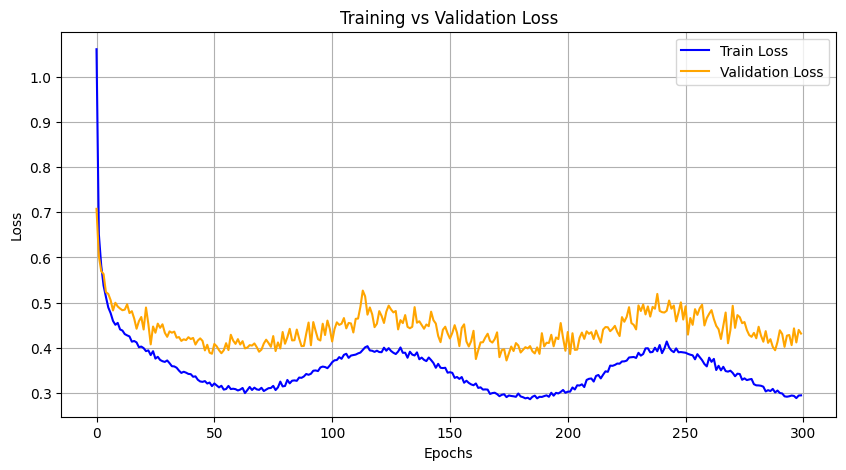

In [22]:
plot_loss(loss_history, os.path.join(outputs_directory, "loss_history.png"))

## Saving model

*   Save your best model  as a .pth file using torch.save() and name it as **model__Group_\<Your_Group_Number>.pth (e.g., model_Group_12.pth).**).

*  Do **Not** forget to download and submit your best along with the notebook submission



In [23]:
torch.save(model, os.path.join(outputs_directory, "model_Group_3_full.pth"))

## Load the model

*   You must include code to load the model and only then perform prediction.




In [24]:
model = torch.load(os.path.join(outputs_directory, "model_Group_3_full.pth"))

In [25]:
def inferenece(training_params, model, test_dataloader):
    criterion = training_params["loss_fn"]
    running_loss_val = 0.0
    count = 0
    predictions = []
    labels = []
    model.eval()
    with torch.no_grad():
        for idx, (image, label) in enumerate(test_dataloader):
            image = torch.tensor(image, dtype = torch.float32).to(device)
            label = torch.tensor(label, dtype = torch.long).to(device)
            prediction = model(image)
            predictions.append(prediction.cpu().detach())
            labels.append(label.cpu().detach())
            loss = criterion(prediction, label)
            running_loss_val += loss.item()
            # if idx%100 == 0:
            #     print(f"\t############# [Validation {idx + 1}] : Loss = {loss.item()}")
            count += 1
    predictions = torch.concat(predictions, dim = 0)
    labels = torch.concat(labels, dim = 0)
    metrics = compute_multiclass_metrics(predictions, labels)

    print("Evaluation Loss : ", running_loss_val / count)
    # print("Classification Report : ", metrics)

    return metrics


metrics_test = inferenece(training_params, model, test_dataloader)

Evaluation Loss :  0.38985650714408315


In [26]:
print("CLassification Report (Test) : \n", metrics_test)

CLassification Report (Test) : 
 {'roc_auc': {'class_0': 0.7683283026164621, 'class_1': 0.21663925821452976, 'class_2': 0.7204632244547425, 'class_3': 0.8053639266140721, 'class_4': 0.7916150069430667, 'class_5': 0.21746417997632358, 'class_6': 0.9100532629938775, 'class_7': 0.7125869885117914, 'class_8': 0.3074169242284909, 'class_9': 0.3703322501185368}, 'pr_auc': {'class_0': 0.20241362180282174, 'class_1': 0.05964930493933039, 'class_2': 0.15643411640727536, 'class_3': 0.22161012076657766, 'class_4': 0.2080352816820174, 'class_5': 0.06074793700999491, 'class_6': 0.4263053739329788, 'class_7': 0.15110200835752557, 'class_8': 0.06711184351414766, 'class_9': 0.07288597623646167}, 'precision_micro': 0.8892952720785013, 'recall_micro': 0.8892952720785013, 'f1_micro': 0.8892952720785013}


## Prediction


*   Show predicted labels for 5 samples from the test set.
*   For better visualization, show the input image and corresponding predicted label with the probability score.



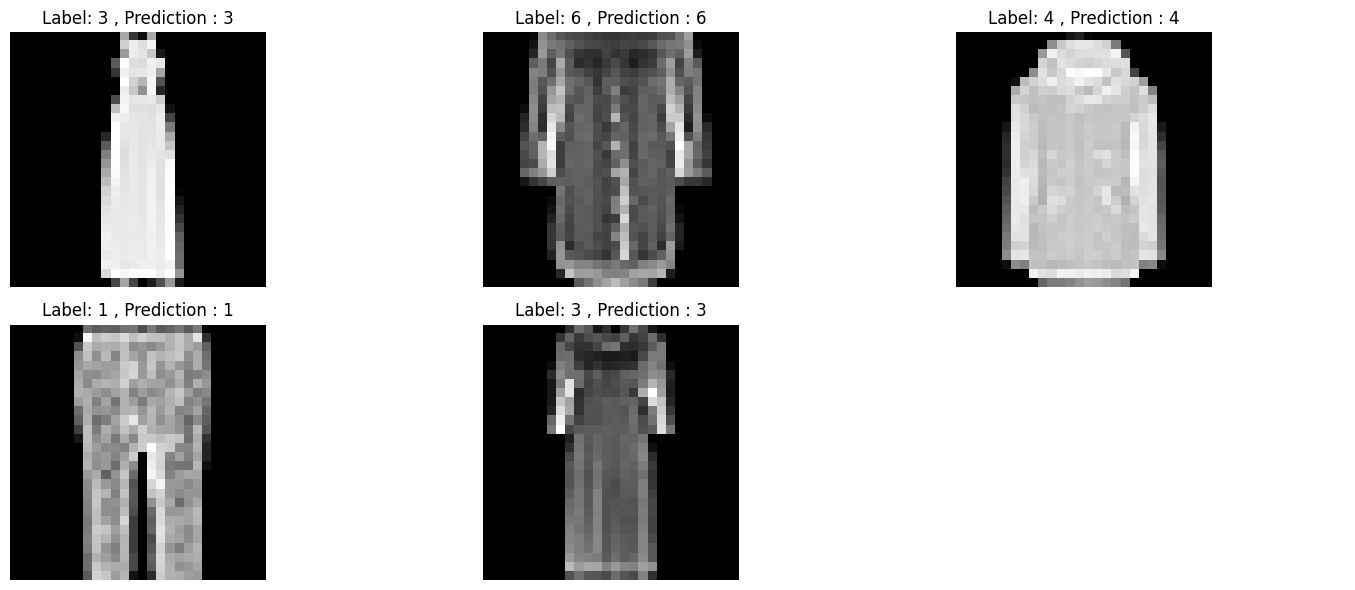

In [27]:
test_idxs = np.random.choice([idx for idx in range(len(test_images))], 5, replace = False)

# Calculate grid size (rows and columns)
num_images = len(test_idxs)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_images / cols)  # Calculate rows needed

# Create a figure for the grid
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  # Flatten axes for easy iteration
model.eval()
for i, (idx, ax) in enumerate(zip(test_idxs, axes)):
    image, label = test_dataset.__getitem__(idx)
    image = torch.tensor([image], dtype = torch.float32).to(device)
    prediction = model(image)

    ax.imshow(cv2.cvtColor(cv2.imread(test_dataset.data.loc[idx, "image_file_path"]), cv2.COLOR_BGR2RGB))
    ax.set_title(f"Label: {label} , Prediction : {prediction.argmax(dim=1).item()}")
    ax.axis("off")

# Turn off unused axes
for ax in axes[num_images:]:
    ax.axis("off")

# Display the grid
plt.tight_layout()
plt.show()